In [1]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm

import sys
import os
import multiprocessing as mp
from joblib import Parallel, delayed

C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\siptest\anaconda3\envs\py36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def test_stat_helper(est_nodes, eval_nodes, est_classes, class_counts, K, kappa=3, base=2):
    """
    est_nodes : list
        Leaf indices used for voting
    eval_nodes : list
        Leaf indices in which a sample from the density subsample falls
    est_classes : list
        Voter class labels in est_node leaves
    """
    for i in range(len(est_nodes)):
        class_counts[est_nodes[i], est_classes[i]] += 1

    # Total number of estimation points in each leaf.
    row_sums = class_counts.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid divide by zero.
    class_probs = class_counts / row_sums[:, None]

    # Make the nodes that have no estimation indices uniform.
    # This includes non-leaf nodes, but tha t will not affect the estimate.
    class_probs[np.argwhere(class_probs.sum(axis=1) == 0)] = [1 / K]*K
    # Apply finite sample correction and renormalize.
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / \
            (kappa*class_counts.sum(axis=1)[elem[0]])
    row_sums = class_probs.sum(axis=1)
    class_probs = class_probs / row_sums[:, None]

    # Place evaluation points in their corresponding leaf node.
    # Store evaluation posterior in a num_eval-by-num_class matrix.
    eval_class_probs = class_probs[eval_nodes]
    eval_entropies = [entropy(posterior, base=base)
                      for posterior in eval_class_probs]
    return np.mean(eval_entropies)


In [3]:
def uf(X, y, n_estimators=300, max_samples=.4, base=2, kappa=3, reps=100, n_jobs=None):
    # Build forest with default parameters.
    model = BaggingClassifier(DecisionTreeClassifier(),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              n_jobs=n_jobs,
                              bootstrap=False)
    model.fit(X, y)
    n = X.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)

    cond_entropy = 0
    final_null_dist = [0] * 100

    tree_est_nodes = []
    tree_eval_nodes = []
    tree_unsampled_indices = []

    # Get real test statistics
    for tree_idx, tree in enumerate(model):
        # Find the indices of the training set used for partition.
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0, n), sampled_indices)
        np.random.shuffle(unsampled_indices)
        tree_unsampled_indices.append(unsampled_indices)

        # Randomly split the rest into voting and evaluation.
        vote_indices = unsampled_indices[:len(unsampled_indices)//2]
        eval_indices = unsampled_indices[len(unsampled_indices)//2:]

        # Store the posterior in a num_nodes-by-num_classes matrix.
        # Posteriors in non-leaf cells will be zero everywhere
        # and later changed to uniform.
        node_counts = tree.tree_.n_node_samples
        class_counts = np.zeros((len(node_counts), K))
        est_nodes = tree.apply(X[vote_indices])
        tree_est_nodes.append(est_nodes)
        eval_nodes = tree.apply(X[eval_indices])
        tree_eval_nodes.append(eval_nodes)

        cond_entropy += test_stat_helper(
            est_nodes, eval_nodes, y[vote_indices], class_counts, K)

    # Generate null dist
    for j in range(reps):
        for tree, unsampled_indices, est_nodes, eval_nodes in zip(
            model, tree_unsampled_indices, tree_est_nodes, tree_eval_nodes
        ):
            node_counts = tree.tree_.n_node_samples
            class_counts = np.zeros((len(node_counts), K))
            y_vote = y[unsampled_indices]
            np.random.shuffle(y_vote)
            final_null_dist[j] += test_stat_helper(
                est_nodes, eval_nodes, y_vote[:len(unsampled_indices)//2], class_counts, K)

    # note: shuffling y doesn't change these outputs
    new_final_null_dist = [entropy([np.mean(
        y), 1 - np.mean(y)], base=2) - val / n_estimators for val in final_null_dist]

    final_stat = entropy([np.mean(y), 1 - np.mean(y)],
                         base=2) - cond_entropy / n_estimators
    return final_stat, new_final_null_dist

In [4]:
MAX_SAMPLE_SIZE = 1000
STEP_SIZE = 20
SAMP_SIZES = range(100, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 100

SIMULATIONS = [
    # "linear": "Linear",
    # "multimodal_independence": "Independence"
    # linear,
    multimodal_independence
]

In [43]:
from statsmodels.distributions.empirical_distribution import ECDF
def estimate_power(sim, n_jobs=None):
    samp_size_dict = dict()
    samp_size_dict['sample_sizes'] = SAMP_SIZES
    samp_size_dict['n_power_reps'] = POWER_REPS
    power = []
    for n_samples in SAMP_SIZES:
        pvalues = []
        samp_size_dict[n_samples] = {'stats': [], 'null_dists': []}
        for p in tqdm(range(POWER_REPS)):
            #plt.clf()
            np.random.seed(None)
            matrix1, matrix2 = multimodal_independence(n_samples, 2)
            x, y = k_sample_transform([matrix1, matrix2])
            stat, null_dist = uf(x, y.ravel(), n_jobs=n_jobs)
            samp_size_dict[n_samples]['stats'].append(stat)
            samp_size_dict[n_samples]['null_dists'].append(null_dist)
            pvalue = np.mean(np.asarray(null_dist) >= stat)
            print("P-value: " + str(pvalue))
            print(f'Test stat: {stat}')
            print(f'Null dist: {null_dist[:5]}')
            #if p % 4 == 0: 
                #plt.hist(null_dist)
                #plt.axvline(stat, c='r', ls='--')
            #plt.show()
            pvalues.append(pvalue)
        #plt.hist(pvalues, range=(0,1))
        #plt.show()
        ecdf = ECDF(pvalues)
        plt.plot(ecdf.x, ecdf.y)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel("p-value")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.ylabel("fraction of data")
        plt.show()
        power.append(np.mean(np.asarray(pvalues) <= 0.05))
        #power.append((pvalues >= 0.05).sum() / POWER_REPS)

    with open('multimodal_independence_power_reps.pkl', 'wb') as handle:
        pickle.dump(samp_size_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    np.savetxt('multimodal_independence_power1000.csv',
               power, delimiter=',')

    return power

  0%|                                                                              | 1/1000 [00:40<11:07:43, 40.10s/it]

P-value: 0.46
Test stat: 0.1448250933144789
Null dist: [0.14076347308942327, 0.13578615483382805, 0.1410559853240395, 0.15285076003009035, 0.14099525159039272]


  0%|▏                                                                             | 2/1000 [01:11<10:25:25, 37.60s/it]

P-value: 0.99
Test stat: 0.13412788633013029
Null dist: [0.15151389032335283, 0.15427188202298325, 0.14361974673062528, 0.14315970430947966, 0.1469799474013992]


  0%|▏                                                                              | 3/1000 [01:41<9:45:27, 35.23s/it]

P-value: 0.01
Test stat: 0.16232181547719937
Null dist: [0.1552775121193224, 0.14708646667117964, 0.14272768416863524, 0.13579571728488526, 0.1418190845868439]


  0%|▎                                                                              | 4/1000 [02:13<9:27:11, 34.17s/it]

P-value: 0.83
Test stat: 0.1422472248880795
Null dist: [0.15438626750042828, 0.15156172856087768, 0.14650918944823976, 0.14509503315323435, 0.15029441680138167]


  0%|▍                                                                             | 5/1000 [02:56<10:12:15, 36.92s/it]

P-value: 0.34
Test stat: 0.15070577270085062
Null dist: [0.13807170911791733, 0.13900548711231864, 0.1371273008273729, 0.14996527388126824, 0.14694430408082904]


  1%|▍                                                                              | 6/1000 [03:26<9:34:33, 34.68s/it]

P-value: 0.64
Test stat: 0.14493007965061355
Null dist: [0.15433317213645215, 0.1441853605768244, 0.15043476523577326, 0.14795788281763544, 0.14498490986894963]


  1%|▌                                                                              | 7/1000 [03:56<9:13:37, 33.45s/it]

P-value: 0.97
Test stat: 0.13496351487684077
Null dist: [0.14463819080428797, 0.14696299697815085, 0.15184414572232396, 0.14854129036033692, 0.14574941182936263]


  1%|▋                                                                              | 8/1000 [04:25<8:51:44, 32.16s/it]

P-value: 0.99
Test stat: 0.13357414623079
Null dist: [0.14178924173097696, 0.1579335629786649, 0.14425334781878763, 0.1348753088098802, 0.14447880974568328]


  1%|▋                                                                              | 9/1000 [04:55<8:37:56, 31.36s/it]

P-value: 0.36
Test stat: 0.15074258362753146
Null dist: [0.14142150619991678, 0.14091110403338725, 0.14041168008240168, 0.15527186593456221, 0.1521535306721935]


  1%|▊                                                                             | 10/1000 [05:24<8:27:11, 30.74s/it]

P-value: 0.26
Test stat: 0.15721980262738522
Null dist: [0.1514706090213348, 0.15126549759916497, 0.14650821588011698, 0.15561038008109662, 0.1503452706363283]


  1%|▊                                                                             | 11/1000 [05:54<8:22:39, 30.49s/it]

P-value: 0.98
Test stat: 0.13945180103670474
Null dist: [0.14518239596499694, 0.15423535205883976, 0.1543584187455309, 0.1515006211361969, 0.15327355084536953]


  1%|▉                                                                             | 12/1000 [06:23<8:16:32, 30.15s/it]

P-value: 0.34
Test stat: 0.15024303484002177
Null dist: [0.13935339809254177, 0.14873703293677887, 0.1442422706641152, 0.1591500602403766, 0.15811350972500327]


  1%|█                                                                             | 13/1000 [06:53<8:13:18, 29.99s/it]

P-value: 0.02
Test stat: 0.1661371388251648
Null dist: [0.1473601240309388, 0.15345434857406792, 0.14341333117825739, 0.1558647598524503, 0.15359722821958188]


  1%|█                                                                             | 14/1000 [07:22<8:09:06, 29.76s/it]

P-value: 0.86
Test stat: 0.14276908153117163
Null dist: [0.15432734393166214, 0.1395262884519245, 0.15293019786445783, 0.1371863367817584, 0.14894728126234147]


  2%|█▏                                                                            | 15/1000 [07:52<8:07:59, 29.73s/it]

P-value: 0.94
Test stat: 0.1374282193429015
Null dist: [0.1371241874680591, 0.14387867143131527, 0.13893465733778476, 0.14359850368734361, 0.1381718736409694]


  2%|█▏                                                                            | 16/1000 [08:22<8:07:39, 29.74s/it]

P-value: 0.97
Test stat: 0.13862587066119958
Null dist: [0.14722886967453608, 0.14586679687170123, 0.1478402951186405, 0.14776370761783375, 0.1423794195315734]


  2%|█▎                                                                            | 17/1000 [08:51<8:07:12, 29.74s/it]

P-value: 0.85
Test stat: 0.14171896824039398
Null dist: [0.13981785370929234, 0.14528282837816997, 0.1434570682444566, 0.15499501238311364, 0.1531551267655904]


  2%|█▍                                                                            | 18/1000 [09:21<8:04:23, 29.60s/it]

P-value: 0.65
Test stat: 0.14929977778338455
Null dist: [0.1631764391000443, 0.15733136924160718, 0.15068986237121562, 0.15228618796839233, 0.16208981589022908]


  2%|█▍                                                                            | 19/1000 [09:50<8:04:13, 29.62s/it]

P-value: 0.88
Test stat: 0.14501717060543384
Null dist: [0.1503149418340196, 0.14609420882850577, 0.15125154020254294, 0.1525441696174782, 0.14472672996882774]


  2%|█▌                                                                            | 20/1000 [10:20<8:01:58, 29.51s/it]

P-value: 0.56
Test stat: 0.14365093642056914
Null dist: [0.14467443371104272, 0.14613157698427715, 0.15575281281842246, 0.15380618627893017, 0.1505579866085156]


  2%|█▋                                                                            | 21/1000 [10:49<8:01:38, 29.52s/it]

P-value: 0.71
Test stat: 0.14130156028037866
Null dist: [0.13932394039526252, 0.13766977498330957, 0.1473244129114315, 0.15257608189420113, 0.1393573730876635]


  2%|█▋                                                                            | 22/1000 [11:18<8:00:11, 29.46s/it]

P-value: 0.83
Test stat: 0.14455126288192677
Null dist: [0.1499687291597186, 0.15000210846925544, 0.1469396777435268, 0.145397011382136, 0.15187857655739656]


  2%|█▊                                                                            | 23/1000 [11:48<8:00:16, 29.49s/it]

P-value: 0.42
Test stat: 0.14857788814930595
Null dist: [0.15774931272821346, 0.14043447275709975, 0.15045119024875864, 0.16052005143920056, 0.14973016975737496]


  2%|█▊                                                                            | 24/1000 [12:21<8:16:06, 30.50s/it]

P-value: 0.23
Test stat: 0.15620829753861354
Null dist: [0.162963878884546, 0.15031211538364886, 0.1391938847558587, 0.15107334978868214, 0.15846003076030235]


  2%|█▉                                                                            | 25/1000 [12:54<8:29:33, 31.36s/it]

P-value: 0.12
Test stat: 0.16310560189496892
Null dist: [0.15503683248093747, 0.1535499688983154, 0.14895345558145034, 0.16731013847877774, 0.16462098115022272]


  3%|██                                                                            | 26/1000 [13:29<8:46:15, 32.42s/it]

P-value: 0.08
Test stat: 0.16902020411957042
Null dist: [0.1596304406599811, 0.1595823753262925, 0.16900590697220552, 0.16242549751616064, 0.16660278488807712]


  3%|██                                                                            | 27/1000 [13:58<8:30:01, 31.45s/it]

P-value: 0.75
Test stat: 0.1401880381091235
Null dist: [0.1502777718878786, 0.14629412887850146, 0.1444034255164024, 0.13724963760024556, 0.15217770650875695]


  3%|██▏                                                                           | 28/1000 [14:30<8:32:01, 31.61s/it]

P-value: 0.11
Test stat: 0.16341967848640626
Null dist: [0.14937752778667945, 0.1563565922121849, 0.15717456126564688, 0.15945875816322663, 0.1643032759797981]


  3%|██▎                                                                           | 29/1000 [15:00<8:20:41, 30.94s/it]

P-value: 0.14
Test stat: 0.1565154401602552
Null dist: [0.14551884155872075, 0.15534524948593087, 0.1435704678077796, 0.14524920899690752, 0.1495263708549709]


  3%|██▎                                                                           | 30/1000 [15:29<8:12:10, 30.44s/it]

P-value: 0.27
Test stat: 0.1491417458843053
Null dist: [0.143158913898208, 0.14615222108609616, 0.1525253566877185, 0.14625504516245824, 0.1489794739372976]


  3%|██▍                                                                           | 31/1000 [15:59<8:08:01, 30.22s/it]

P-value: 0.97
Test stat: 0.13438130933623726
Null dist: [0.14958756584272181, 0.14698976836085842, 0.1506822500795647, 0.14560053355027147, 0.1616410167103287]


  3%|██▍                                                                           | 32/1000 [16:28<8:02:47, 29.93s/it]

P-value: 0.91
Test stat: 0.13486620737326538
Null dist: [0.15254839668836206, 0.1487573933344315, 0.15224100901488113, 0.13444340036239089, 0.14144577238284528]


  3%|██▌                                                                           | 33/1000 [16:57<8:00:27, 29.81s/it]

P-value: 0.29
Test stat: 0.15957364388483597
Null dist: [0.14895489051799427, 0.1510175834588836, 0.14778842022718475, 0.1516361397212702, 0.16616089234822606]


  3%|██▋                                                                           | 34/1000 [17:27<7:58:45, 29.74s/it]

P-value: 0.97
Test stat: 0.13243712881360736
Null dist: [0.1465454419782386, 0.14649096857287192, 0.13571861952167563, 0.14752190204423143, 0.15093618973726686]


  4%|██▋                                                                           | 35/1000 [17:57<7:58:36, 29.76s/it]

P-value: 0.29
Test stat: 0.14850320351610502
Null dist: [0.13714506355644496, 0.14728272319597036, 0.1518355791139847, 0.13218509569603076, 0.14149566029748462]


  4%|██▊                                                                           | 36/1000 [18:26<7:57:54, 29.75s/it]

P-value: 0.88
Test stat: 0.1416100352475076
Null dist: [0.1447128192780066, 0.15110364463137282, 0.1456224900288745, 0.14526729304722263, 0.13945377537721237]


  4%|██▉                                                                           | 37/1000 [18:56<7:56:07, 29.67s/it]

P-value: 0.93
Test stat: 0.1349697935741454
Null dist: [0.14518274414414212, 0.1473194425084049, 0.14803534088886006, 0.1478937926008046, 0.15273162628953363]


  4%|██▉                                                                           | 38/1000 [19:26<7:55:48, 29.68s/it]

P-value: 0.99
Test stat: 0.1318938760369428
Null dist: [0.14069201634750494, 0.13622001558521601, 0.14693797835902767, 0.14968331174117844, 0.1404028957118294]


  4%|███                                                                           | 39/1000 [19:55<7:53:44, 29.58s/it]

P-value: 0.63
Test stat: 0.14570026592858198
Null dist: [0.14706162645616105, 0.14464364149450415, 0.14298016513990486, 0.14491161447971668, 0.15108459490437764]


  4%|███                                                                           | 40/1000 [20:25<7:54:48, 29.68s/it]

P-value: 0.0
Test stat: 0.16866116715147417
Null dist: [0.15745011292304556, 0.15242063008634876, 0.15143404065738542, 0.14785337895062167, 0.14986852314026355]


  4%|███▏                                                                          | 41/1000 [20:55<7:55:10, 29.73s/it]

P-value: 0.45
Test stat: 0.15283022036426952
Null dist: [0.1429241844109962, 0.15930632302892433, 0.15034425174935218, 0.16068048799405932, 0.14220046675041864]


  4%|███▎                                                                          | 42/1000 [21:26<8:01:48, 30.18s/it]

P-value: 0.68
Test stat: 0.1474766584052679
Null dist: [0.1567170599354626, 0.1506372409331409, 0.1552515384517522, 0.14501551802898593, 0.14149443902356984]


  4%|███▎                                                                          | 43/1000 [21:56<8:01:16, 30.17s/it]

P-value: 1.0
Test stat: 0.13053421145430477
Null dist: [0.16086815011841182, 0.14499681790253627, 0.1353414309830655, 0.1422259000830074, 0.14528485400846702]


  4%|███▍                                                                          | 44/1000 [22:26<7:59:51, 30.12s/it]

P-value: 0.59
Test stat: 0.14726369837027498
Null dist: [0.16012360997630448, 0.14694784002149597, 0.154350309727057, 0.1449998364582774, 0.14457596826308472]


  4%|███▌                                                                          | 45/1000 [22:58<8:08:59, 30.72s/it]

P-value: 0.39
Test stat: 0.1513803802393341
Null dist: [0.14030532961514253, 0.14674111994473193, 0.15584399990243192, 0.15381373800945364, 0.16118728491957623]


  5%|███▌                                                                          | 46/1000 [23:28<8:01:35, 30.29s/it]

P-value: 0.88
Test stat: 0.13973496540819252
Null dist: [0.15379891005584223, 0.15015641553963677, 0.14732470765250438, 0.1474309455287437, 0.13082443870078975]


  5%|███▋                                                                          | 47/1000 [23:57<7:56:45, 30.02s/it]

P-value: 0.94
Test stat: 0.13542110230023996
Null dist: [0.1438056213783434, 0.15028281375492292, 0.1451656826534401, 0.15409732572038626, 0.13985468866763184]


  5%|███▋                                                                          | 48/1000 [24:26<7:53:18, 29.83s/it]

P-value: 0.5
Test stat: 0.14617164212724953
Null dist: [0.15302398251626959, 0.14126889892420103, 0.13994106070528511, 0.13069917146019427, 0.15015884425559523]


  5%|███▊                                                                          | 49/1000 [24:56<7:50:22, 29.68s/it]

P-value: 0.88
Test stat: 0.14273257675684947
Null dist: [0.14733956377867252, 0.13820891670190805, 0.14973140959670717, 0.15885746448373084, 0.15134618792794996]


  5%|███▉                                                                          | 50/1000 [25:25<7:48:15, 29.57s/it]

P-value: 0.79
Test stat: 0.14205802344283347
Null dist: [0.15119825464904613, 0.1486103340151811, 0.14985152389992573, 0.14842930881647742, 0.14081218262675843]


  5%|███▉                                                                          | 51/1000 [25:54<7:46:17, 29.48s/it]

P-value: 0.48
Test stat: 0.15135705313101022
Null dist: [0.1688514019131654, 0.1483401360405724, 0.1610810635671801, 0.16956675756271955, 0.15494767691304023]


  5%|████                                                                          | 52/1000 [26:24<7:45:56, 29.49s/it]

P-value: 0.37
Test stat: 0.14713341372266264
Null dist: [0.14795494920114727, 0.13768531556143504, 0.15050929781071598, 0.1488649101500693, 0.1426899695711238]


  5%|████▏                                                                         | 53/1000 [26:54<7:48:12, 29.66s/it]

P-value: 0.64
Test stat: 0.14420851041286875
Null dist: [0.13690525506718487, 0.14358414990100665, 0.1466229519327512, 0.14627218942617848, 0.149924778277724]


  5%|████▏                                                                         | 54/1000 [27:23<7:45:53, 29.55s/it]

P-value: 0.22
Test stat: 0.1585081038119398
Null dist: [0.14576628663696922, 0.15761676548327874, 0.15120503361986004, 0.16348719076834817, 0.1501969341839039]


  6%|████▎                                                                         | 55/1000 [27:53<7:49:01, 29.78s/it]

P-value: 0.19
Test stat: 0.15874179698316648
Null dist: [0.15098931982577335, 0.1574839833482251, 0.15367425300961002, 0.14494347540133035, 0.1632076021382617]


  6%|████▎                                                                         | 56/1000 [28:23<7:46:42, 29.66s/it]

P-value: 0.25
Test stat: 0.14799237200358517
Null dist: [0.14280560528425634, 0.1366116160820794, 0.14800609447192947, 0.1463057978104917, 0.13520523152669817]


  6%|████▍                                                                         | 57/1000 [28:52<7:44:50, 29.58s/it]

P-value: 0.0
Test stat: 0.16857484470932005
Null dist: [0.14534498877669988, 0.14319639450899713, 0.13236304536531307, 0.15751520906212668, 0.15298245347364525]


  6%|████▌                                                                         | 58/1000 [29:21<7:42:59, 29.49s/it]

P-value: 0.77
Test stat: 0.1435457104811113
Null dist: [0.15461926698864148, 0.13832346348054725, 0.14482930467684962, 0.14947073319448323, 0.1549040505755096]


  6%|████▌                                                                         | 59/1000 [29:53<7:53:43, 30.21s/it]

P-value: 0.0
Test stat: 0.17074071986853068
Null dist: [0.1517155528238764, 0.15302108542645432, 0.15233292367796736, 0.14764086078862093, 0.15793079520831776]


  6%|████▋                                                                         | 60/1000 [30:23<7:50:04, 30.00s/it]

P-value: 1.0
Test stat: 0.13493770124069837
Null dist: [0.13717741780188175, 0.1412407404231899, 0.14667129808936707, 0.15784285482464944, 0.1479112601121414]


  6%|████▊                                                                         | 61/1000 [30:53<7:49:57, 30.03s/it]

P-value: 0.65
Test stat: 0.1446226857781464
Null dist: [0.14944241502349198, 0.1535127525363409, 0.1468238497311889, 0.16028377462773635, 0.14610111240506762]


  6%|████▊                                                                         | 62/1000 [31:22<7:46:49, 29.86s/it]

P-value: 0.12
Test stat: 0.1549281970148022
Null dist: [0.1342605043257481, 0.16108373022689748, 0.15045869500509723, 0.14547307313504143, 0.14608263569996727]


  6%|████▉                                                                         | 63/1000 [31:52<7:45:40, 29.82s/it]

P-value: 0.87
Test stat: 0.1372488883155214
Null dist: [0.15054331260320497, 0.14823896747029586, 0.1518398182732862, 0.14748002232171287, 0.1339822426987206]


  6%|████▉                                                                         | 64/1000 [32:22<7:43:38, 29.72s/it]

P-value: 0.6
Test stat: 0.1437063255576665
Null dist: [0.13976259504803124, 0.1435662162097503, 0.15633126994544155, 0.13838702544906045, 0.14554386448380052]


  6%|█████                                                                         | 65/1000 [33:00<8:23:48, 32.33s/it]

P-value: 0.28
Test stat: 0.15346492487079888
Null dist: [0.15767762522977913, 0.1477270814109375, 0.1373482631497832, 0.14501226417560853, 0.15177815540421202]


  7%|█████▏                                                                        | 66/1000 [33:29<8:09:25, 31.44s/it]

P-value: 0.92
Test stat: 0.14342664251010584
Null dist: [0.1414908224340341, 0.14803383579775875, 0.15824816328219882, 0.15491284355460366, 0.15333622050658546]


  7%|█████▏                                                                        | 67/1000 [33:59<7:59:43, 30.85s/it]

P-value: 0.83
Test stat: 0.14518685167224077
Null dist: [0.1544443634284952, 0.16232354653304326, 0.16566854510592377, 0.14849214651828224, 0.15162095773564543]


  7%|█████▎                                                                        | 68/1000 [34:28<7:52:34, 30.42s/it]

P-value: 1.0
Test stat: 0.130250680314706
Null dist: [0.15120328746170064, 0.15575296836068953, 0.1587705104203686, 0.14949306888999114, 0.1412242882270952]


  7%|█████▍                                                                        | 69/1000 [34:58<7:47:34, 30.13s/it]

P-value: 0.95
Test stat: 0.13478104549155223
Null dist: [0.13906172746839807, 0.1405614151758996, 0.13046617517026482, 0.1436576353699004, 0.1443009771439394]


  7%|█████▍                                                                        | 70/1000 [35:27<7:43:15, 29.89s/it]

P-value: 0.7
Test stat: 0.1395876342632556
Null dist: [0.14962775692178132, 0.15725700044464153, 0.135494215019218, 0.14239747820302795, 0.14102034653784845]


  7%|█████▌                                                                        | 71/1000 [35:59<7:49:59, 30.35s/it]

P-value: 0.97
Test stat: 0.13649198221730063
Null dist: [0.15949928575489714, 0.15268613701956202, 0.15063565507334975, 0.14703140622111477, 0.1414323066237908]


  7%|█████▌                                                                        | 72/1000 [36:28<7:47:15, 30.21s/it]

P-value: 0.51
Test stat: 0.14791272527533994
Null dist: [0.15319605501035216, 0.15203781668017102, 0.15317698648049727, 0.14384962567472392, 0.13876195420946302]


  7%|█████▋                                                                        | 73/1000 [36:58<7:46:08, 30.17s/it]

P-value: 0.51
Test stat: 0.1475378177186757
Null dist: [0.1471400338031661, 0.1420523789244813, 0.14950990621507332, 0.1402397872717389, 0.1502378681685359]


  7%|█████▊                                                                        | 74/1000 [37:28<7:40:39, 29.85s/it]

P-value: 0.77
Test stat: 0.14608238051514344
Null dist: [0.15742051712765914, 0.15085712019178854, 0.1554838060813286, 0.14754793567529756, 0.1655604948567524]


  8%|█████▊                                                                        | 75/1000 [37:59<7:49:34, 30.46s/it]

P-value: 0.08
Test stat: 0.1620637952735604
Null dist: [0.1673537410612388, 0.1483994808076563, 0.1532531594076907, 0.1521527344322121, 0.15046271568913105]


  8%|█████▉                                                                        | 76/1000 [38:29<7:45:07, 30.20s/it]

P-value: 0.69
Test stat: 0.14522590109237044
Null dist: [0.1537611723818566, 0.1370578590156365, 0.14648255819701317, 0.16022996240799958, 0.14987478895328643]


  8%|██████                                                                        | 77/1000 [39:00<7:46:01, 30.29s/it]

P-value: 0.48
Test stat: 0.14987022358254842
Null dist: [0.15299177506093287, 0.15532695181849565, 0.1462046176304871, 0.15104867381338516, 0.160237029940553]


  8%|██████                                                                        | 78/1000 [39:30<7:46:10, 30.34s/it]

P-value: 0.09
Test stat: 0.158722075662721
Null dist: [0.15374291235766435, 0.14705726765376004, 0.15563661712499477, 0.15769668007025606, 0.15211595679990486]


  8%|██████▏                                                                       | 79/1000 [40:01<7:47:14, 30.44s/it]

P-value: 0.9
Test stat: 0.13659864773352282
Null dist: [0.14669610496725172, 0.1445027244976156, 0.1437351929366827, 0.14633661103242868, 0.14490375878174844]


  8%|██████▏                                                                       | 80/1000 [40:30<7:40:54, 30.06s/it]

P-value: 0.34
Test stat: 0.15097613179808855
Null dist: [0.15435784862319124, 0.14109385850214262, 0.15234203512741928, 0.14778489060519817, 0.14016165460239183]


  8%|██████▎                                                                       | 81/1000 [41:00<7:40:20, 30.06s/it]

P-value: 0.62
Test stat: 0.14590020861416464
Null dist: [0.15945526920329778, 0.1615369699099759, 0.1433581655418601, 0.1455677041121326, 0.15215426832928747]


  8%|██████▍                                                                       | 82/1000 [41:29<7:36:49, 29.86s/it]

P-value: 0.42
Test stat: 0.15430782905493756
Null dist: [0.1424291568255941, 0.1462187294826166, 0.16372900754040443, 0.15879021306334917, 0.15538173873207028]


  8%|██████▍                                                                       | 83/1000 [41:59<7:35:48, 29.82s/it]

P-value: 1.0
Test stat: 0.13682090232836852
Null dist: [0.1536644251735365, 0.1490908350155552, 0.158719667542373, 0.1457235308633752, 0.15412607395985412]


  8%|██████▌                                                                       | 84/1000 [42:30<7:38:11, 30.01s/it]

P-value: 0.13
Test stat: 0.15373191689025745
Null dist: [0.15109738159305997, 0.1463645222822746, 0.1473686348077845, 0.1418063806664679, 0.16174822605021033]


  8%|██████▋                                                                       | 85/1000 [43:01<7:44:59, 30.49s/it]

P-value: 0.96
Test stat: 0.1398646814807728
Null dist: [0.16550877234733596, 0.13194237182911028, 0.14706856674803082, 0.147675425735459, 0.14074462539541988]


  9%|██████▋                                                                       | 86/1000 [43:31<7:40:28, 30.23s/it]

P-value: 0.63
Test stat: 0.14143146085177993
Null dist: [0.14105335916384476, 0.14081030409738593, 0.1335147218826368, 0.14326118285435296, 0.14071570400910405]


  9%|██████▊                                                                       | 87/1000 [44:00<7:37:25, 30.06s/it]

P-value: 0.99
Test stat: 0.1340254703157988
Null dist: [0.1497416961249648, 0.1435948210443524, 0.14599251433907678, 0.13519330886831182, 0.15846080637364202]


  9%|██████▊                                                                       | 88/1000 [44:30<7:33:42, 29.85s/it]

P-value: 0.69
Test stat: 0.1437692424923095
Null dist: [0.14511714948449161, 0.15436387384786054, 0.14499612023010566, 0.13960287001478267, 0.14057216171559483]


  9%|██████▉                                                                       | 89/1000 [45:04<7:51:26, 31.05s/it]

P-value: 0.85
Test stat: 0.1469715692446374
Null dist: [0.16273762671254277, 0.1579458287376193, 0.15058437961697368, 0.14917906485847676, 0.15506184036754522]


  9%|███████                                                                       | 90/1000 [45:43<8:27:39, 33.47s/it]

P-value: 0.76
Test stat: 0.14501198722573239
Null dist: [0.14806365761129758, 0.15811994594092293, 0.145769517805301, 0.1478105665014421, 0.15195049580783748]


  9%|███████                                                                       | 91/1000 [46:22<8:54:59, 35.31s/it]

P-value: 0.9
Test stat: 0.13960126713814758
Null dist: [0.1500292845525455, 0.14587082260560047, 0.15040680240703064, 0.15515458198617949, 0.14749759564783493]


  9%|███████▏                                                                      | 92/1000 [47:01<9:10:17, 36.36s/it]

P-value: 0.84
Test stat: 0.14403288921455215
Null dist: [0.1403362859894961, 0.14517964422450425, 0.15182997885078886, 0.15517702249676024, 0.14946741721794077]


  9%|███████▎                                                                      | 93/1000 [47:30<8:37:03, 34.20s/it]

P-value: 0.81
Test stat: 0.1523458009293288
Null dist: [0.16379249341563462, 0.15080725414005336, 0.17149068803591605, 0.16141723186865264, 0.1726705410967494]


  9%|███████▎                                                                      | 94/1000 [48:03<8:30:46, 33.83s/it]

P-value: 0.95
Test stat: 0.13766278805187393
Null dist: [0.15666149394030193, 0.13885365944354155, 0.14482105046600469, 0.1528132775949771, 0.1404354151188293]


 10%|███████▍                                                                      | 95/1000 [48:33<8:10:19, 32.51s/it]

P-value: 0.95
Test stat: 0.13607431059008268
Null dist: [0.14492714604947254, 0.1419612051971516, 0.14898629513199357, 0.1420490442831429, 0.15196934183239674]


 10%|███████▍                                                                      | 96/1000 [49:02<7:55:51, 31.58s/it]

P-value: 0.79
Test stat: 0.14227566721782714
Null dist: [0.1447748146408524, 0.14968444745648768, 0.13948124453012267, 0.1496735361739081, 0.1463502100444598]


 10%|███████▌                                                                      | 97/1000 [49:31<7:44:35, 30.87s/it]

P-value: 0.96
Test stat: 0.13814031290598505
Null dist: [0.14150505169684946, 0.13619489609266777, 0.13931841554293845, 0.1542944776210805, 0.14963953056467172]


 10%|███████▋                                                                      | 98/1000 [50:01<7:37:30, 30.43s/it]

P-value: 0.64
Test stat: 0.1488915659443687
Null dist: [0.16278626456891976, 0.15376298402434885, 0.13935169604378206, 0.1590351187892387, 0.1512147206402633]


 10%|███████▋                                                                      | 99/1000 [50:30<7:30:37, 30.01s/it]

P-value: 0.54
Test stat: 0.1485769250186516
Null dist: [0.15394769647298112, 0.14693587806368724, 0.14637765292118465, 0.14513997359478448, 0.14710428276996013]


 10%|███████▋                                                                     | 100/1000 [51:00<7:30:00, 30.00s/it]

P-value: 0.93
Test stat: 0.13875206303675702
Null dist: [0.1449609315484649, 0.15187668429825463, 0.14232387318868234, 0.14964061244329108, 0.1473598671436981]


 10%|███████▊                                                                     | 101/1000 [51:29<7:26:10, 29.78s/it]

P-value: 0.99
Test stat: 0.12873947015039167
Null dist: [0.14752487216955024, 0.15185539457915842, 0.14162205343137169, 0.13442010183221764, 0.13175214605138008]


 10%|███████▊                                                                     | 102/1000 [51:58<7:23:56, 29.66s/it]

P-value: 0.9
Test stat: 0.14110650207531927
Null dist: [0.15582531201456362, 0.15260445032722425, 0.14971227295822764, 0.1563514374821975, 0.15349294988205275]


 10%|███████▉                                                                     | 103/1000 [52:29<7:25:32, 29.80s/it]

P-value: 0.45
Test stat: 0.1476174025621403
Null dist: [0.1398686857667225, 0.14181869006994363, 0.15252267608539194, 0.13636813893315192, 0.1528474552426876]


 10%|████████                                                                     | 104/1000 [53:03<7:45:54, 31.20s/it]

P-value: 0.48
Test stat: 0.15110639931469738
Null dist: [0.1480219107012536, 0.14450901404443528, 0.14784337411082016, 0.13847617824324976, 0.14315186318199546]


 10%|████████                                                                     | 105/1000 [53:33<7:40:18, 30.86s/it]

P-value: 0.81
Test stat: 0.13768672149928174
Null dist: [0.1455542428642328, 0.1418246728572573, 0.16137172702223257, 0.14778353321401705, 0.14350308773140952]


 11%|████████▏                                                                    | 106/1000 [54:02<7:32:02, 30.34s/it]

P-value: 0.43
Test stat: 0.14820191538423821
Null dist: [0.14732344056300495, 0.15658084769397917, 0.13485053766506416, 0.1406121531424469, 0.1467440254923429]


 11%|████████▏                                                                    | 107/1000 [54:31<7:26:15, 29.98s/it]

P-value: 0.47
Test stat: 0.14952863472862232
Null dist: [0.15020334273903913, 0.14612611874999748, 0.1635952072527206, 0.1489155436839822, 0.13931820469283818]


 11%|████████▎                                                                    | 108/1000 [55:01<7:22:34, 29.77s/it]

P-value: 0.52
Test stat: 0.14616862183595247
Null dist: [0.13064949328275643, 0.1498154939777856, 0.14997411852885378, 0.14441985343438657, 0.1408831911799696]


 11%|████████▍                                                                    | 109/1000 [55:30<7:19:04, 29.57s/it]

P-value: 0.61
Test stat: 0.14780436111897344
Null dist: [0.14964979331532968, 0.1605394946191655, 0.14689097683918273, 0.1474655481491619, 0.1477786868913702]


 11%|████████▍                                                                    | 110/1000 [55:59<7:17:15, 29.48s/it]

P-value: 0.38
Test stat: 0.14570844810471295
Null dist: [0.14780550643465606, 0.1459596412772417, 0.14764103170745935, 0.14278110255350085, 0.14438672542116704]


 11%|████████▌                                                                    | 111/1000 [56:28<7:15:31, 29.39s/it]

P-value: 0.29
Test stat: 0.1542607074449226
Null dist: [0.16240272830293856, 0.15403744623747884, 0.1548492583005664, 0.14850988324735426, 0.15262962452840834]


 11%|████████▌                                                                    | 112/1000 [56:57<7:14:27, 29.35s/it]

P-value: 0.03
Test stat: 0.1611941386581327
Null dist: [0.15742887095398217, 0.1431079544251116, 0.14953842247707982, 0.14194262079100028, 0.16070236490180922]


 11%|████████▋                                                                    | 113/1000 [57:27<7:12:54, 29.28s/it]

P-value: 0.63
Test stat: 0.143253026285606
Null dist: [0.14719821436863056, 0.14463587348706763, 0.13553718245730773, 0.1319687235971435, 0.14460709154270945]


 11%|████████▊                                                                    | 114/1000 [57:56<7:15:10, 29.47s/it]

P-value: 0.68
Test stat: 0.14324314943799776
Null dist: [0.14412743176096532, 0.13979789804400655, 0.15538510350777168, 0.1491123488178201, 0.14348194805308856]


 12%|████████▊                                                                    | 115/1000 [58:26<7:15:25, 29.52s/it]

P-value: 1.0
Test stat: 0.13146497959303982
Null dist: [0.15031952355852995, 0.15225315081374924, 0.14490693343293137, 0.1595323746521512, 0.14684753505381665]


 12%|████████▉                                                                    | 116/1000 [58:56<7:14:46, 29.51s/it]

P-value: 1.0
Test stat: 0.1311110267751805
Null dist: [0.14122981029702852, 0.15321809792912466, 0.1446636832249959, 0.14297602924631958, 0.1498403767312143]


 12%|█████████                                                                    | 117/1000 [59:24<7:11:35, 29.33s/it]

P-value: 0.9
Test stat: 0.13490035740135553
Null dist: [0.14070192729761777, 0.14499801399479695, 0.13929100583927645, 0.14442578454182842, 0.13547734613488271]


 12%|█████████                                                                    | 118/1000 [59:54<7:11:05, 29.33s/it]

P-value: 0.75
Test stat: 0.1443580195915668
Null dist: [0.13941479014731817, 0.1519976700433181, 0.14255571309812642, 0.14025675209052835, 0.1427566509515248]


 12%|████████▉                                                                  | 119/1000 [1:00:23<7:10:20, 29.31s/it]

P-value: 0.65
Test stat: 0.1476429464458876
Null dist: [0.14234044689468572, 0.151506320714198, 0.14445197624940498, 0.16006870009890428, 0.15010951594557775]


 12%|█████████                                                                  | 120/1000 [1:00:52<7:09:13, 29.27s/it]

P-value: 0.51
Test stat: 0.14850040232697947
Null dist: [0.1442168567167592, 0.13707009916572832, 0.16288412268267927, 0.15838100141814404, 0.14464145284550056]


 12%|█████████                                                                  | 121/1000 [1:01:21<7:08:38, 29.26s/it]

P-value: 0.95
Test stat: 0.13853339879131832
Null dist: [0.14500013950954138, 0.14539713332726079, 0.1503402434465333, 0.1513540538703294, 0.15682802412752683]


 12%|█████████▏                                                                 | 122/1000 [1:01:50<7:06:30, 29.15s/it]

P-value: 0.38
Test stat: 0.14530238254098604
Null dist: [0.1447703919035378, 0.14319297515529072, 0.15254088758147655, 0.1421469073085495, 0.13903754173220817]


 12%|█████████▏                                                                 | 123/1000 [1:02:19<7:05:32, 29.11s/it]

P-value: 0.98
Test stat: 0.13459047592269158
Null dist: [0.1563132580230484, 0.15826873427032162, 0.14895096211725567, 0.14971578207143932, 0.14430073257543063]


 12%|█████████▎                                                                 | 124/1000 [1:03:00<7:55:14, 32.55s/it]

P-value: 0.31
Test stat: 0.15736603261880733
Null dist: [0.16051306425242118, 0.15398456189729215, 0.14550764956749218, 0.1527763119334783, 0.16070774171293623]


 12%|█████████▍                                                                 | 125/1000 [1:03:29<7:40:35, 31.58s/it]

P-value: 0.5
Test stat: 0.1464675546436115
Null dist: [0.15499042006649877, 0.1442516761936702, 0.14465936255821776, 0.14013584844572124, 0.15258264937325627]


 13%|█████████▍                                                                 | 126/1000 [1:03:58<7:28:43, 30.81s/it]

P-value: 0.74
Test stat: 0.1434739017918243
Null dist: [0.1443999411864837, 0.14540417206408274, 0.14484591230654342, 0.1472030340156124, 0.1373763296234457]


 13%|█████████▌                                                                 | 127/1000 [1:04:29<7:29:19, 30.88s/it]

P-value: 0.16
Test stat: 0.16002627286434845
Null dist: [0.1561381607959309, 0.15761973887113956, 0.15265906842984478, 0.15524776788228112, 0.1656409717938946]


 13%|█████████▌                                                                 | 128/1000 [1:04:59<7:21:37, 30.39s/it]

P-value: 0.88
Test stat: 0.1395955878352927
Null dist: [0.14073337868139257, 0.14899224151676826, 0.13752859561013187, 0.13898685745620976, 0.14633604980284054]


 13%|█████████▋                                                                 | 129/1000 [1:05:28<7:14:51, 29.96s/it]

P-value: 1.0
Test stat: 0.13790586311251385
Null dist: [0.14384584497866382, 0.14965198004478564, 0.14181652936284728, 0.16341846139201366, 0.14612008053609638]


 13%|█████████▊                                                                 | 130/1000 [1:05:57<7:11:51, 29.78s/it]

P-value: 0.86
Test stat: 0.140737144923466
Null dist: [0.15086466480382366, 0.13511410258778023, 0.1570030380267078, 0.15350561477748081, 0.15610865833024734]


 13%|█████████▊                                                                 | 131/1000 [1:06:26<7:08:31, 29.59s/it]

P-value: 0.49
Test stat: 0.1523095659914443
Null dist: [0.14559186950328318, 0.158768248993698, 0.159694953446332, 0.16137560622153624, 0.1543409733777109]


 13%|█████████▉                                                                 | 132/1000 [1:06:55<7:06:06, 29.45s/it]

P-value: 0.68
Test stat: 0.14478886688038828
Null dist: [0.15409054358250784, 0.15337056739925414, 0.14568406883365503, 0.13801161630934222, 0.1604145521747915]


 13%|█████████▉                                                                 | 133/1000 [1:07:24<7:04:35, 29.38s/it]

P-value: 0.8
Test stat: 0.13910696407914103
Null dist: [0.14414222098120433, 0.15044188460132968, 0.15560809027339628, 0.13888971861730892, 0.1507914204516112]


 13%|██████████                                                                 | 134/1000 [1:07:55<7:07:58, 29.65s/it]

P-value: 0.9
Test stat: 0.14208659841150073
Null dist: [0.15300089198087719, 0.15541532497772648, 0.15987940300951664, 0.1446894021327051, 0.15131517259218985]


 14%|██████████▏                                                                | 135/1000 [1:08:25<7:09:44, 29.81s/it]

P-value: 0.31
Test stat: 0.1526700757239775
Null dist: [0.14483743725523635, 0.1540065383910475, 0.15075195113968853, 0.1425999796532127, 0.15528123671471217]


 14%|██████████▏                                                                | 136/1000 [1:09:10<8:16:34, 34.48s/it]

P-value: 0.41
Test stat: 0.15203186038130567
Null dist: [0.14492878279354482, 0.15243138575180493, 0.14954968717961392, 0.1500770065509891, 0.15679026641830995]


 14%|██████████▎                                                                | 137/1000 [1:09:46<8:22:32, 34.94s/it]

P-value: 0.23
Test stat: 0.15273288991448142
Null dist: [0.13814186596135147, 0.14899440148949883, 0.15024720595558094, 0.14094697767528697, 0.14608778797688127]


 14%|██████████▎                                                                | 138/1000 [1:10:19<8:13:22, 34.34s/it]

P-value: 0.58
Test stat: 0.14460306877643636
Null dist: [0.13272957261102514, 0.14179989569705964, 0.13992295641637287, 0.15062702776907133, 0.13549755444108147]


 14%|██████████▍                                                                | 139/1000 [1:10:49<7:52:34, 32.93s/it]

P-value: 0.69
Test stat: 0.14491947442414677
Null dist: [0.15813965603547475, 0.15234148769892053, 0.1479088295498372, 0.14320762470503345, 0.15157617138105894]


 14%|██████████▌                                                                | 140/1000 [1:11:18<7:36:50, 31.87s/it]

P-value: 0.76
Test stat: 0.14426772923163567
Null dist: [0.14687916271099732, 0.14388782900214492, 0.14235935824951018, 0.1539599665564252, 0.1592047447089855]


 14%|██████████▌                                                                | 141/1000 [1:11:47<7:24:40, 31.06s/it]

P-value: 0.08
Test stat: 0.16132909288407138
Null dist: [0.1464973794765384, 0.1642910819218354, 0.15604165307227935, 0.15331098977948465, 0.14529887053271195]


 14%|██████████▋                                                                | 142/1000 [1:12:17<7:16:35, 30.53s/it]

P-value: 0.9
Test stat: 0.13952652896810436
Null dist: [0.1520781707660498, 0.1547125935184963, 0.14292530256550817, 0.14350291142385196, 0.15034724663501253]


 14%|██████████▋                                                                | 143/1000 [1:12:52<7:38:31, 32.10s/it]

P-value: 0.93
Test stat: 0.1412187573875402
Null dist: [0.1512831938117165, 0.15353211711688008, 0.16121322631968082, 0.15592701766301187, 0.15443045193085747]


 14%|██████████▊                                                                | 144/1000 [1:13:23<7:31:20, 31.64s/it]

P-value: 0.19
Test stat: 0.15570778775995275
Null dist: [0.15506162113766708, 0.16507414883814397, 0.1368812791529469, 0.1446837095255631, 0.14694281523638864]


 14%|██████████▉                                                                | 145/1000 [1:13:52<7:21:40, 30.99s/it]

P-value: 0.76
Test stat: 0.1461507282849963
Null dist: [0.1467055573089736, 0.14188906495002906, 0.1506259637422125, 0.15504398989689228, 0.134022255139581]


 15%|██████████▉                                                                | 146/1000 [1:14:22<7:15:02, 30.56s/it]

P-value: 0.94
Test stat: 0.14024582366702176
Null dist: [0.14821183934324178, 0.14555772532267897, 0.14606328066656393, 0.1453647798022556, 0.15715020370561594]


 15%|███████████                                                                | 147/1000 [1:14:52<7:10:34, 30.29s/it]

P-value: 0.54
Test stat: 0.15068246307611133
Null dist: [0.14275525277262546, 0.15798260573212763, 0.1541120555417418, 0.152563845937413, 0.1524985585980242]


 15%|███████████                                                                | 148/1000 [1:15:22<7:08:05, 30.15s/it]

P-value: 0.4
Test stat: 0.1492855900493616
Null dist: [0.14580590893917644, 0.16390334714179955, 0.15378087027011667, 0.13891357760968426, 0.15457768393124693]


 15%|███████████▏                                                               | 149/1000 [1:15:51<7:04:41, 29.94s/it]

P-value: 0.96
Test stat: 0.14122661001495584
Null dist: [0.15114576259802426, 0.1621560788638231, 0.15580626170114664, 0.15642140802170246, 0.15134554271964362]


 15%|███████████▎                                                               | 150/1000 [1:16:20<7:01:55, 29.78s/it]

P-value: 0.68
Test stat: 0.14219507933098086
Null dist: [0.14425536857753574, 0.14646208593795218, 0.14517168681975556, 0.14626370503979347, 0.14375354205102908]


 15%|███████████▎                                                               | 151/1000 [1:16:51<7:03:53, 29.96s/it]

P-value: 0.22
Test stat: 0.16229397276070645
Null dist: [0.1521745619133319, 0.15146557930464588, 0.14136676204020815, 0.16614541441106656, 0.1564580639856219]


 15%|███████████▍                                                               | 152/1000 [1:17:20<7:00:05, 29.72s/it]

P-value: 0.98
Test stat: 0.13496428535858396
Null dist: [0.14857380752852445, 0.14871943829986756, 0.1525052690689216, 0.1347939689256492, 0.1537787020599215]


 15%|███████████▍                                                               | 153/1000 [1:17:49<6:57:37, 29.58s/it]

P-value: 0.88
Test stat: 0.1413034364153214
Null dist: [0.14871902077053523, 0.1451160076165252, 0.15165179060947154, 0.1424543092074163, 0.14812201541216874]


 15%|███████████▌                                                               | 154/1000 [1:18:18<6:55:37, 29.48s/it]

P-value: 0.82
Test stat: 0.14956640411880406
Null dist: [0.1597963645814514, 0.157241674943972, 0.16120837218659823, 0.14846671152333046, 0.15160597210010263]


 16%|███████████▋                                                               | 155/1000 [1:18:48<6:55:17, 29.49s/it]

P-value: 0.48
Test stat: 0.14923289158660225
Null dist: [0.1499964845921108, 0.1500576737195768, 0.15860199584647838, 0.1485878418604779, 0.13433542625653916]


 16%|███████████▋                                                               | 156/1000 [1:19:17<6:54:01, 29.43s/it]

P-value: 0.91
Test stat: 0.136988860200553
Null dist: [0.1416547720803324, 0.14813650626457087, 0.1438119143477382, 0.14299251646389166, 0.14534402489017872]


 16%|███████████▊                                                               | 157/1000 [1:19:46<6:52:27, 29.36s/it]

P-value: 0.65
Test stat: 0.1463325333804486
Null dist: [0.15525352835719053, 0.14227402826285318, 0.1507890274446525, 0.1552570970264574, 0.1552092236873942]


 16%|███████████▊                                                               | 158/1000 [1:20:16<6:51:57, 29.36s/it]

P-value: 0.45
Test stat: 0.1523989971404679
Null dist: [0.1520250524929675, 0.1386116717619026, 0.1580934377770261, 0.1447004456506943, 0.15282395265255444]


 16%|███████████▉                                                               | 159/1000 [1:20:45<6:52:51, 29.46s/it]

P-value: 0.06
Test stat: 0.16032643317402517
Null dist: [0.14621330027037172, 0.14236668016537213, 0.15574219704645065, 0.15915955701755236, 0.14856529900574222]


 16%|████████████                                                               | 160/1000 [1:21:15<6:50:57, 29.35s/it]

P-value: 0.54
Test stat: 0.14705930625220953
Null dist: [0.14832567232938276, 0.14503772308250495, 0.14592925336672347, 0.14869033969222856, 0.1519032848521047]


 16%|████████████                                                               | 161/1000 [1:21:45<6:56:41, 29.80s/it]

P-value: 0.94
Test stat: 0.1400512424290078
Null dist: [0.14954504276295644, 0.15106267635591986, 0.1505420327886552, 0.1506742926045348, 0.1505573642398701]


 16%|████████████▏                                                              | 162/1000 [1:22:15<6:54:41, 29.69s/it]

P-value: 0.46
Test stat: 0.15003750904837065
Null dist: [0.15700258916586063, 0.15538715629280886, 0.15242870350524995, 0.1485377264749721, 0.14768102795144145]


 16%|████████████▏                                                              | 163/1000 [1:22:47<7:05:16, 30.49s/it]

P-value: 0.1
Test stat: 0.15159199426254932
Null dist: [0.14865267735022025, 0.1347635702605301, 0.14215062893164243, 0.1331310699459991, 0.12584429287708854]


 16%|████████████▎                                                              | 164/1000 [1:23:16<6:59:20, 30.10s/it]

P-value: 0.05
Test stat: 0.1638470764078105
Null dist: [0.1492754114057524, 0.14685581865271524, 0.15354638155048295, 0.1473168204037586, 0.1498253119072327]


 16%|████████████▍                                                              | 165/1000 [1:23:46<6:55:33, 29.86s/it]

P-value: 0.02
Test stat: 0.1571667238696336
Null dist: [0.14187640856923656, 0.14859027465068386, 0.14679341551315117, 0.14491531522883727, 0.14806458794778654]


 17%|████████████▍                                                              | 166/1000 [1:24:15<6:52:36, 29.68s/it]

P-value: 0.15
Test stat: 0.1569511262068911
Null dist: [0.14970847672283527, 0.14638075723328958, 0.15456694941642757, 0.14637494672085227, 0.15395011720418683]


 17%|████████████▌                                                              | 167/1000 [1:24:44<6:50:43, 29.58s/it]

P-value: 0.61
Test stat: 0.14607021028741485
Null dist: [0.14416383773376107, 0.16166979914504775, 0.1509464452087531, 0.1435389061677913, 0.14987078182481695]


 17%|████████████▌                                                              | 168/1000 [1:25:14<6:49:11, 29.51s/it]

P-value: 0.0
Test stat: 0.16569908735236882
Null dist: [0.1351827755395537, 0.15481559731714978, 0.15177731371423386, 0.14826590296645625, 0.1406863800101147]


 17%|████████████▋                                                              | 169/1000 [1:25:43<6:48:07, 29.47s/it]

P-value: 0.06
Test stat: 0.1599292392743319
Null dist: [0.1524232281388206, 0.15736960037481407, 0.14083022460256545, 0.15089426681043594, 0.15124688798965846]


 17%|████████████▊                                                              | 170/1000 [1:26:12<6:47:16, 29.44s/it]

P-value: 1.0
Test stat: 0.13439496391222272
Null dist: [0.1610533520006311, 0.1394121692654714, 0.16058740890554657, 0.1489037378165171, 0.13610175843551242]


 17%|████████████▊                                                              | 171/1000 [1:26:42<6:47:24, 29.49s/it]

P-value: 0.78
Test stat: 0.14242618639233529
Null dist: [0.13670362841245232, 0.1465049305830587, 0.14079206913337938, 0.14370287413487537, 0.15119588745653112]


 17%|████████████▉                                                              | 172/1000 [1:27:12<6:47:44, 29.55s/it]

P-value: 0.39
Test stat: 0.1497249499769624
Null dist: [0.1536140365628036, 0.1490311848631397, 0.14170765645689076, 0.14379681598451177, 0.15901719815074933]


 17%|████████████▉                                                              | 173/1000 [1:27:41<6:47:21, 29.55s/it]

P-value: 0.0
Test stat: 0.17056602569570756
Null dist: [0.14541766895232722, 0.16041313698968007, 0.1584032163729573, 0.15023075566882038, 0.14541789507791691]


 17%|█████████████                                                              | 174/1000 [1:28:11<6:46:49, 29.55s/it]

P-value: 0.96
Test stat: 0.13288721133875947
Null dist: [0.15424019421456925, 0.14771980087962377, 0.15015790049275746, 0.14367335267858838, 0.14796578927476878]


 18%|█████████████▏                                                             | 175/1000 [1:28:41<6:47:28, 29.63s/it]

P-value: 0.86
Test stat: 0.14054214329339476
Null dist: [0.14442268279521409, 0.14552079163362486, 0.16072109527926481, 0.1496415447074747, 0.14535342134245488]


 18%|█████████████▏                                                             | 176/1000 [1:29:10<6:46:29, 29.60s/it]

P-value: 0.83
Test stat: 0.1466861581354033
Null dist: [0.15352789196014371, 0.14624244835110967, 0.14907021947997867, 0.15162276826650822, 0.15315658102119256]


 18%|█████████████▎                                                             | 177/1000 [1:29:40<6:45:04, 29.53s/it]

P-value: 0.99
Test stat: 0.13277320318350005
Null dist: [0.15354467111023617, 0.1430086033666741, 0.14431570963025275, 0.15191949310177644, 0.14346323286481422]


 18%|█████████████▎                                                             | 178/1000 [1:30:09<6:44:34, 29.53s/it]

P-value: 0.18
Test stat: 0.15011224279168556
Null dist: [0.14862934939378303, 0.1569163274463714, 0.14205393151974477, 0.14469619182844984, 0.15487398147485398]


 18%|█████████████▍                                                             | 179/1000 [1:30:39<6:46:38, 29.72s/it]

P-value: 0.72
Test stat: 0.13797042385316327
Null dist: [0.14948659087684324, 0.14273215639090042, 0.14058105564669232, 0.14972954885077883, 0.13412432999877166]


 18%|█████████████▌                                                             | 180/1000 [1:31:09<6:46:04, 29.71s/it]

P-value: 0.0
Test stat: 0.16637735179956903
Null dist: [0.149763870965387, 0.15104626782065178, 0.14296013870143232, 0.14752041268700777, 0.14850463583496232]


 18%|█████████████▌                                                             | 181/1000 [1:31:38<6:44:06, 29.60s/it]

P-value: 0.65
Test stat: 0.14780997223566972
Null dist: [0.13776325504496623, 0.15568419579731352, 0.14176075736596017, 0.14965601265572592, 0.1452223480717133]


 18%|█████████████▋                                                             | 182/1000 [1:32:08<6:43:51, 29.62s/it]

P-value: 0.0
Test stat: 0.17713548344272578
Null dist: [0.1448791370338125, 0.1371197486407073, 0.15742761234460845, 0.15857569232017998, 0.1488726409828015]


 18%|█████████████▋                                                             | 183/1000 [1:32:45<7:13:24, 31.83s/it]

P-value: 0.0
Test stat: 0.1704799196776957
Null dist: [0.15224968767348268, 0.14452277842010497, 0.1644542042877194, 0.15250949901242805, 0.151131161445764]


 18%|█████████████▊                                                             | 184/1000 [1:33:16<7:08:10, 31.48s/it]

P-value: 0.42
Test stat: 0.15694293650851354
Null dist: [0.1554544037707467, 0.16666443217207738, 0.15876793082752572, 0.15167914917657632, 0.14868554259548883]


 18%|█████████████▉                                                             | 185/1000 [1:33:45<6:58:13, 30.79s/it]

P-value: 0.09
Test stat: 0.15576568386254386
Null dist: [0.1484641960615688, 0.1524208784688854, 0.15065537431488485, 0.14165194643437184, 0.14402526451757824]


 19%|█████████████▉                                                             | 186/1000 [1:34:14<6:52:02, 30.37s/it]

P-value: 0.97
Test stat: 0.13250838210946014
Null dist: [0.1379902333045876, 0.137963166422305, 0.14380800823250017, 0.15241355971328552, 0.15020508611361616]


 19%|██████████████                                                             | 187/1000 [1:34:44<6:49:13, 30.20s/it]

P-value: 0.93
Test stat: 0.14229606925824478
Null dist: [0.15075788862733175, 0.15453194201811238, 0.1497044203766842, 0.14608250001915435, 0.1508173588143471]


 19%|██████████████                                                             | 188/1000 [1:35:13<6:45:52, 29.99s/it]

P-value: 0.5
Test stat: 0.14518674750103056
Null dist: [0.1465479280585521, 0.14903414436022588, 0.14218348813509218, 0.13498382865255376, 0.14386162633353272]


 19%|██████████████▏                                                            | 189/1000 [1:35:43<6:44:44, 29.94s/it]

P-value: 0.99
Test stat: 0.14082435251073355
Null dist: [0.15294744150638728, 0.16129506330577492, 0.1606529145205029, 0.14506922351174012, 0.15218685562048717]


 19%|██████████████▎                                                            | 190/1000 [1:36:13<6:41:59, 29.78s/it]

P-value: 0.84
Test stat: 0.1394703620648382
Null dist: [0.1490201294936384, 0.15602877933888648, 0.1442062277448224, 0.1491799233960981, 0.15271068714496272]


 19%|██████████████▎                                                            | 191/1000 [1:36:42<6:39:18, 29.61s/it]

P-value: 0.43
Test stat: 0.1461399798752071
Null dist: [0.14060790711228055, 0.1403640113799679, 0.15436152158077254, 0.12924436000814088, 0.15515786766723172]


 19%|██████████████▍                                                            | 192/1000 [1:37:12<6:40:11, 29.72s/it]

P-value: 0.82
Test stat: 0.14379508104597538
Null dist: [0.14934654854484486, 0.15105011742053953, 0.1614948641291697, 0.15158436840539835, 0.15348096274355072]


 19%|██████████████▍                                                            | 193/1000 [1:37:41<6:38:31, 29.63s/it]

P-value: 0.95
Test stat: 0.13521770836336566
Null dist: [0.14237713704111365, 0.1412538757596674, 0.15172046637455372, 0.1519095650520509, 0.144509780763464]


 19%|██████████████▌                                                            | 194/1000 [1:38:11<6:37:02, 29.56s/it]

P-value: 0.6
Test stat: 0.14786707616970773
Null dist: [0.15178355177675218, 0.15180695758235752, 0.15827355967413803, 0.1492852847698074, 0.15253442640256842]


 20%|██████████████▋                                                            | 195/1000 [1:38:40<6:36:50, 29.58s/it]

P-value: 0.88
Test stat: 0.14158924283760255
Null dist: [0.14363638899129327, 0.1601463977333022, 0.1539444185829444, 0.16135076147216842, 0.1426329621384862]


 20%|██████████████▋                                                            | 196/1000 [1:39:10<6:35:03, 29.48s/it]

P-value: 0.29
Test stat: 0.151726308151081
Null dist: [0.14770441917145227, 0.1574034636709346, 0.16559885037197997, 0.15721609284808635, 0.14793036620348965]


 20%|██████████████▊                                                            | 197/1000 [1:39:39<6:34:38, 29.49s/it]

P-value: 0.43
Test stat: 0.15061172132609046
Null dist: [0.14639237694013807, 0.14823271465569954, 0.1634789350971173, 0.13285416516408965, 0.15751933717377553]


 20%|██████████████▊                                                            | 198/1000 [1:40:09<6:35:04, 29.56s/it]

P-value: 0.0
Test stat: 0.16629000197035015
Null dist: [0.1527327007753586, 0.14501854681438542, 0.15270262801522383, 0.15094311859617615, 0.1446948074956066]


 20%|██████████████▉                                                            | 199/1000 [1:40:45<7:01:13, 31.55s/it]

P-value: 0.97
Test stat: 0.13738505753461105
Null dist: [0.15714773163770424, 0.1375855899782713, 0.13706236228711077, 0.14930930835025824, 0.14575047161336097]


 20%|███████████████                                                            | 200/1000 [1:41:14<6:49:23, 30.70s/it]

P-value: 1.0
Test stat: 0.13064720964282495
Null dist: [0.14845428375035097, 0.14552442613229077, 0.13928978817589444, 0.14157256567565146, 0.13786350776014633]


 20%|███████████████                                                            | 201/1000 [1:41:42<6:41:01, 30.11s/it]

P-value: 0.36
Test stat: 0.14772262545558823
Null dist: [0.13443407789531892, 0.14049222757352686, 0.14487503015101388, 0.1466661071944323, 0.15487260483937149]


 20%|███████████████▏                                                           | 202/1000 [1:42:11<6:35:42, 29.75s/it]

P-value: 0.1
Test stat: 0.15482323339024628
Null dist: [0.14421763418062883, 0.14506476166586713, 0.15467143045255194, 0.141587416133079, 0.14324518193069402]


 20%|███████████████▏                                                           | 203/1000 [1:42:44<6:44:48, 30.47s/it]

P-value: 0.87
Test stat: 0.14457588832243784
Null dist: [0.15809576608161746, 0.14795431125153335, 0.15798881685274468, 0.153464983499774, 0.16154829720955577]


 20%|███████████████▎                                                           | 204/1000 [1:43:13<6:39:20, 30.10s/it]

P-value: 0.83
Test stat: 0.14505078774700242
Null dist: [0.15710551936305728, 0.15370986642846407, 0.14884907093515654, 0.1489970131741174, 0.16060691631103208]


 20%|███████████████▎                                                           | 205/1000 [1:43:42<6:33:38, 29.71s/it]

P-value: 0.71
Test stat: 0.14571263483113384
Null dist: [0.1561002974583523, 0.14745798663803134, 0.1510136118585692, 0.15086416171425265, 0.15661786717699555]


 21%|███████████████▍                                                           | 206/1000 [1:44:11<6:32:41, 29.67s/it]

P-value: 0.09
Test stat: 0.15651986257224826
Null dist: [0.13503586272381674, 0.15076203749755468, 0.1471558113774959, 0.14167294267159392, 0.14181624855483788]


 21%|███████████████▌                                                           | 207/1000 [1:44:41<6:32:01, 29.66s/it]

P-value: 0.96
Test stat: 0.14088678385788134
Null dist: [0.14935809844532977, 0.1440973416642206, 0.1375645276862345, 0.14680859744380848, 0.15346477925478397]


 21%|███████████████▌                                                           | 208/1000 [1:45:10<6:27:55, 29.39s/it]

P-value: 0.03
Test stat: 0.1585742294440592
Null dist: [0.14444882347469667, 0.1479886115432003, 0.14677378780851913, 0.14750793148601715, 0.15030618787345873]


 21%|███████████████▋                                                           | 209/1000 [1:45:38<6:25:44, 29.26s/it]

P-value: 0.57
Test stat: 0.14664519868810322
Null dist: [0.1468672496515382, 0.15572649598895383, 0.1419482655261064, 0.14870799541153779, 0.1415324666274872]


 21%|███████████████▊                                                           | 210/1000 [1:46:07<6:22:48, 29.07s/it]

P-value: 0.68
Test stat: 0.14710306725161548
Null dist: [0.13809377976956516, 0.1555567507439054, 0.14586400216954287, 0.15068443329349424, 0.1517740348942639]


 21%|███████████████▊                                                           | 211/1000 [1:46:36<6:21:11, 28.99s/it]

P-value: 0.05
Test stat: 0.15943482586971802
Null dist: [0.15235425247743173, 0.14428700747224132, 0.15795598783208553, 0.16311373512369975, 0.14923289739827816]


 21%|███████████████▉                                                           | 212/1000 [1:47:05<6:20:06, 28.94s/it]

P-value: 0.96
Test stat: 0.1372376982879736
Null dist: [0.1586595252590537, 0.15238142658900666, 0.14154566340391017, 0.15060811291741516, 0.1450428248499166]


 21%|███████████████▉                                                           | 213/1000 [1:47:33<6:18:31, 28.86s/it]

P-value: 0.61
Test stat: 0.14667794744789076
Null dist: [0.13502858836737797, 0.14548607796657853, 0.147310104419752, 0.1581974886292431, 0.1554032051316736]


 21%|████████████████                                                           | 214/1000 [1:48:02<6:18:54, 28.92s/it]

P-value: 0.63
Test stat: 0.14261970038682192
Null dist: [0.14195412874051516, 0.14266004296463075, 0.1504159478101098, 0.13932536044488208, 0.1466371099268764]


 22%|████████████████▏                                                          | 215/1000 [1:48:31<6:17:58, 28.89s/it]

P-value: 0.9
Test stat: 0.14173433160438242
Null dist: [0.1447716945858465, 0.14876522708235318, 0.15264136434738285, 0.1465136573775635, 0.1608367887666856]


 22%|████████████████▏                                                          | 216/1000 [1:49:01<6:19:20, 29.03s/it]

P-value: 0.92
Test stat: 0.13629863967317246
Null dist: [0.15006200575110884, 0.15005269916522335, 0.1556024635922777, 0.14671273022992082, 0.14058945012789237]


 22%|████████████████▎                                                          | 217/1000 [1:49:29<6:16:44, 28.87s/it]

P-value: 0.04
Test stat: 0.1728462923140146
Null dist: [0.1567867945870014, 0.1612937308932333, 0.16544263777778345, 0.14144272647528855, 0.15808932475803306]


 22%|████████████████▎                                                          | 218/1000 [1:49:58<6:15:00, 28.77s/it]

P-value: 0.92
Test stat: 0.14284680200282573
Null dist: [0.14266271910719652, 0.15316674922809514, 0.14410853663295675, 0.14862366204988786, 0.1503297860501417]


 22%|████████████████▍                                                          | 219/1000 [1:50:27<6:14:50, 28.80s/it]

P-value: 0.17
Test stat: 0.15527664743616543
Null dist: [0.14980861701094528, 0.15566169715761657, 0.15930913532145774, 0.14487800061721623, 0.14959538239403425]


 22%|████████████████▌                                                          | 220/1000 [1:50:55<6:14:43, 28.83s/it]

P-value: 0.97
Test stat: 0.13632405677030213
Null dist: [0.14777475709392207, 0.15238695310121053, 0.15810390733314839, 0.1515303237483977, 0.14698373424929012]


 22%|████████████████▌                                                          | 221/1000 [1:51:24<6:13:22, 28.76s/it]

P-value: 0.39
Test stat: 0.1547119932755635
Null dist: [0.1599268981270382, 0.15251943183940153, 0.14907691738844486, 0.15612220233794982, 0.15724642747591522]


 22%|████████████████▋                                                          | 222/1000 [1:51:53<6:12:23, 28.72s/it]

P-value: 0.32
Test stat: 0.15105649164722768
Null dist: [0.14344065209070644, 0.14853543961414672, 0.13050026421231964, 0.14329223991468454, 0.14028487509942067]


 22%|████████████████▋                                                          | 223/1000 [1:52:21<6:10:52, 28.64s/it]

P-value: 0.25
Test stat: 0.15346594751781606
Null dist: [0.14545835113643613, 0.15128372101533283, 0.1482256885564247, 0.14349591969969477, 0.15588978522065666]


 22%|████████████████▊                                                          | 224/1000 [1:52:53<6:24:38, 29.74s/it]

P-value: 0.37
Test stat: 0.1460885252761437
Null dist: [0.1440061262044613, 0.14711620601058062, 0.15120605890755368, 0.14286761750149668, 0.1441506287194303]


 22%|████████████████▉                                                          | 225/1000 [1:53:22<6:19:41, 29.40s/it]

P-value: 0.77
Test stat: 0.14699086081737767
Null dist: [0.14549078101983093, 0.1465865211071935, 0.1502508884058168, 0.16213607387059326, 0.1365822360403045]


 23%|████████████████▉                                                          | 226/1000 [1:53:51<6:15:59, 29.15s/it]

P-value: 0.99
Test stat: 0.13435619703314006
Null dist: [0.15043005402998988, 0.15360286048242577, 0.15328646525428513, 0.14069464442397195, 0.14108127391522207]


 23%|█████████████████                                                          | 227/1000 [1:54:19<6:13:00, 28.95s/it]

P-value: 0.09
Test stat: 0.15832412194794598
Null dist: [0.15505525375986562, 0.14477773399571148, 0.14058473375677294, 0.14985692347354118, 0.153234929926094]


 23%|█████████████████                                                          | 228/1000 [1:54:48<6:14:17, 29.09s/it]

P-value: 0.81
Test stat: 0.14027775073117466
Null dist: [0.13168160595747092, 0.1441421413519044, 0.15059439204789804, 0.14277132108106327, 0.1429330559557801]


 23%|█████████████████▏                                                         | 229/1000 [1:55:17<6:12:43, 29.01s/it]

P-value: 0.32
Test stat: 0.1500836379949103
Null dist: [0.13740936474735632, 0.15503651350067083, 0.13933788942190173, 0.14749690701488982, 0.1357969127140961]


 23%|█████████████████▎                                                         | 230/1000 [1:55:46<6:10:36, 28.88s/it]

P-value: 0.73
Test stat: 0.14866605679144296
Null dist: [0.15935743015355353, 0.1645569273397448, 0.14702171377450757, 0.150458082581992, 0.14978113477887467]


 23%|█████████████████▎                                                         | 231/1000 [1:56:15<6:11:08, 28.96s/it]

P-value: 0.69
Test stat: 0.14816949473758612
Null dist: [0.1513001973653061, 0.1449929100794638, 0.1548509179090093, 0.14673998603926364, 0.15094456536203504]


 23%|█████████████████▍                                                         | 232/1000 [1:56:44<6:10:21, 28.93s/it]

P-value: 0.93
Test stat: 0.13384030379916545
Null dist: [0.1438240380900898, 0.14474064926142982, 0.13987132465872287, 0.13301317695288917, 0.13126245120841573]


 23%|█████████████████▍                                                         | 233/1000 [1:57:12<6:08:34, 28.83s/it]

P-value: 0.07
Test stat: 0.16225601374080256
Null dist: [0.15186958864096245, 0.1515857613442031, 0.14911804225510428, 0.1407101013883293, 0.15067180412244097]


 23%|█████████████████▌                                                         | 234/1000 [1:57:41<6:07:05, 28.75s/it]

P-value: 0.34
Test stat: 0.15562570483460936
Null dist: [0.14714946739960033, 0.15618506600495508, 0.15529718167171147, 0.1481154468533291, 0.1607757200404848]


 24%|█████████████████▋                                                         | 235/1000 [1:58:10<6:06:33, 28.75s/it]

P-value: 0.87
Test stat: 0.13894374730523107
Null dist: [0.14158260151452373, 0.14335713970183217, 0.14194875619649105, 0.14417090784046993, 0.1466642494835334]


 24%|█████████████████▋                                                         | 236/1000 [1:58:39<6:07:09, 28.83s/it]

P-value: 0.93
Test stat: 0.1486576998004161
Null dist: [0.15494542016152557, 0.17407987333819464, 0.1623276568511095, 0.1519325865802118, 0.16047056535121962]


 24%|█████████████████▊                                                         | 237/1000 [1:59:08<6:06:07, 28.79s/it]

P-value: 0.9
Test stat: 0.1396551103730712
Null dist: [0.15223145099648117, 0.14929824148954718, 0.14779059434242048, 0.15874226944881153, 0.14947916296785257]


 24%|█████████████████▊                                                         | 238/1000 [1:59:36<6:05:33, 28.78s/it]

P-value: 0.03
Test stat: 0.16392726442716699
Null dist: [0.15327683818899485, 0.15545959929864295, 0.15157791412413313, 0.1567139257466711, 0.15031745351972237]


 24%|█████████████████▉                                                         | 239/1000 [2:00:05<6:04:30, 28.74s/it]

P-value: 0.36
Test stat: 0.15225578394065264
Null dist: [0.1495862997977646, 0.14370162195755298, 0.15142474894007363, 0.15725281309068917, 0.15855809024461398]


 24%|██████████████████                                                         | 240/1000 [2:00:34<6:04:44, 28.79s/it]

P-value: 0.99
Test stat: 0.13197037798970357
Null dist: [0.15062319768288734, 0.1454538220603787, 0.13625226653438838, 0.14233713767550737, 0.14218673642387136]


 24%|██████████████████                                                         | 241/1000 [2:01:03<6:04:05, 28.78s/it]

P-value: 0.21
Test stat: 0.15522232406166747
Null dist: [0.15321486429553854, 0.14257940095863864, 0.15170928771101155, 0.15575834122656995, 0.14831277846452295]


 24%|██████████████████▏                                                        | 242/1000 [2:01:33<6:11:07, 29.38s/it]

P-value: 0.31
Test stat: 0.1508746185547113
Null dist: [0.15123342873850332, 0.15005251353835025, 0.15097078002800302, 0.1424409954804382, 0.148151929470291]


 24%|██████████████████▏                                                        | 243/1000 [2:02:02<6:09:22, 29.28s/it]

P-value: 0.87
Test stat: 0.13719644889567328
Null dist: [0.14360470219198684, 0.1373258439592866, 0.13369878486235198, 0.14786651200142253, 0.1485696934034273]


 24%|██████████████████▎                                                        | 244/1000 [2:02:37<6:28:32, 30.84s/it]

P-value: 0.66
Test stat: 0.14445914126384096
Null dist: [0.1456136182447888, 0.14002314520976866, 0.14481157510970566, 0.1416893770124722, 0.14712354213489476]


 24%|██████████████████▍                                                        | 245/1000 [2:03:09<6:31:01, 31.07s/it]

P-value: 0.07
Test stat: 0.1563104454904909
Null dist: [0.15168946583762966, 0.1484266283944522, 0.14697413955813954, 0.15632448305074054, 0.15139918603377256]


 25%|██████████████████▍                                                        | 246/1000 [2:03:37<6:21:37, 30.37s/it]

P-value: 0.82
Test stat: 0.14238662461014595
Null dist: [0.1492249262317521, 0.1433366595591502, 0.14124463853926383, 0.16045458483731612, 0.14460891251813623]


 25%|██████████████████▌                                                        | 247/1000 [2:04:06<6:14:57, 29.88s/it]

P-value: 0.23
Test stat: 0.15630970371340258
Null dist: [0.14785380187999964, 0.14894710576872705, 0.15477265386131744, 0.15430853008792245, 0.15826006911249302]


 25%|██████████████████▌                                                        | 248/1000 [2:04:35<6:10:55, 29.59s/it]

P-value: 0.34
Test stat: 0.1575535369252844
Null dist: [0.15447986340544806, 0.14511984160577318, 0.1709007989264606, 0.15027178440761935, 0.16213976884749437]


 25%|██████████████████▋                                                        | 249/1000 [2:05:04<6:06:51, 29.31s/it]

P-value: 0.46
Test stat: 0.14826933580374246
Null dist: [0.14255833501180004, 0.15391115660326615, 0.15079987443544884, 0.14626927826767866, 0.14599709025880092]


 25%|██████████████████▊                                                        | 250/1000 [2:05:32<6:03:31, 29.08s/it]

P-value: 0.77
Test stat: 0.14468286019658516
Null dist: [0.15375234850303043, 0.14646338352650146, 0.1486474146715956, 0.14239378127689462, 0.15461028961062606]


 25%|██████████████████▊                                                        | 251/1000 [2:06:01<6:02:02, 29.00s/it]

P-value: 0.73
Test stat: 0.1473394996773143
Null dist: [0.15478498870107205, 0.15116688370731912, 0.1527867086687471, 0.15850112207134404, 0.13809358631507296]


 25%|██████████████████▉                                                        | 252/1000 [2:06:30<6:00:43, 28.94s/it]

P-value: 0.22
Test stat: 0.15161599470860065
Null dist: [0.14463553534412255, 0.14839770787809758, 0.1388198112913288, 0.14205851184561025, 0.1479414990712956]


 25%|██████████████████▉                                                        | 253/1000 [2:06:58<5:59:05, 28.84s/it]

P-value: 0.69
Test stat: 0.1456872258405425
Null dist: [0.14192549123340714, 0.14853147702323288, 0.14935209458469745, 0.14178521016080858, 0.1457571098836079]


 25%|███████████████████                                                        | 254/1000 [2:07:27<5:57:29, 28.75s/it]

P-value: 0.71
Test stat: 0.14405904032311734
Null dist: [0.14719259253468076, 0.14257079377731852, 0.14358046302111538, 0.14547708452028685, 0.15312629130255795]


 26%|███████████████████▏                                                       | 255/1000 [2:07:56<5:59:13, 28.93s/it]

P-value: 0.69
Test stat: 0.1414037441318946
Null dist: [0.1486338020410234, 0.1417682097316909, 0.13992686588480086, 0.14425325595629568, 0.14293753475501147]


 26%|███████████████████▏                                                       | 256/1000 [2:08:25<5:57:55, 28.86s/it]

P-value: 0.49
Test stat: 0.1471308756583204
Null dist: [0.14930621410226275, 0.1525223765677387, 0.14163979694419193, 0.14890795126749734, 0.15319738507506697]


 26%|███████████████████▎                                                       | 257/1000 [2:08:54<5:57:03, 28.83s/it]

P-value: 0.6
Test stat: 0.14244459155219036
Null dist: [0.14131454287033984, 0.1528055425963959, 0.14152205105442062, 0.14889972795293338, 0.15533508409414853]


 26%|███████████████████▎                                                       | 258/1000 [2:09:22<5:55:58, 28.78s/it]

P-value: 0.37
Test stat: 0.14845967650926684
Null dist: [0.14344806411990152, 0.1436079506983542, 0.14588904672759495, 0.1462611332162519, 0.1385959714015229]


 26%|███████████████████▍                                                       | 259/1000 [2:09:52<5:57:57, 28.98s/it]

P-value: 0.37
Test stat: 0.1497861753592553
Null dist: [0.1566272346929114, 0.14983576424730816, 0.15059236124000652, 0.1411797121766576, 0.15746095575457575]


 26%|███████████████████▌                                                       | 260/1000 [2:10:21<5:56:31, 28.91s/it]

P-value: 0.77
Test stat: 0.14368790473074722
Null dist: [0.142584775161683, 0.1517715332432309, 0.1540969094370669, 0.13935996039883003, 0.14454942566890794]


 26%|███████████████████▌                                                       | 261/1000 [2:10:50<5:56:48, 28.97s/it]

P-value: 0.89
Test stat: 0.14256310139498884
Null dist: [0.1526238625937386, 0.1453867303719587, 0.1544052433446077, 0.1539755143703203, 0.1451297310933385]


 26%|███████████████████▋                                                       | 262/1000 [2:11:18<5:55:51, 28.93s/it]

P-value: 0.99
Test stat: 0.1259136696616554
Null dist: [0.1389108433586097, 0.14388804964388913, 0.13383377129185214, 0.14750272836635658, 0.14580935176437093]


 26%|███████████████████▋                                                       | 263/1000 [2:11:47<5:53:19, 28.76s/it]

P-value: 0.2
Test stat: 0.15723279224380193
Null dist: [0.15029119750082798, 0.15232002360498054, 0.14840939983275858, 0.14788270166991524, 0.1503909791992255]


 26%|███████████████████▊                                                       | 264/1000 [2:12:15<5:51:54, 28.69s/it]

P-value: 0.69
Test stat: 0.14148107495741746
Null dist: [0.1348203423649469, 0.1316164254832899, 0.13836307076815502, 0.1340883030178529, 0.1638872301169323]


 26%|███████████████████▉                                                       | 265/1000 [2:12:47<6:03:58, 29.71s/it]

P-value: 0.77
Test stat: 0.14120868493500893
Null dist: [0.15635479609741199, 0.14492001638055985, 0.13955537927220552, 0.13716349804239447, 0.14397169231619422]


 27%|███████████████████▉                                                       | 266/1000 [2:13:16<6:00:31, 29.47s/it]

P-value: 0.36
Test stat: 0.15382426691650897
Null dist: [0.16032394852840537, 0.1569625164621642, 0.14433218135261783, 0.15732434710342003, 0.14754182623119538]


 27%|████████████████████                                                       | 267/1000 [2:13:45<5:57:05, 29.23s/it]

P-value: 0.6
Test stat: 0.14632276386447451
Null dist: [0.15042262884230984, 0.15515200050277778, 0.15434642966614365, 0.14129530078530117, 0.14610500522436776]


 27%|████████████████████                                                       | 268/1000 [2:14:14<5:55:12, 29.12s/it]

P-value: 0.11
Test stat: 0.15889485535918002
Null dist: [0.14668856604774716, 0.154339566784648, 0.13528604320682958, 0.15022433349436204, 0.13970866038978746]


 27%|████████████████████▏                                                      | 269/1000 [2:14:43<5:53:49, 29.04s/it]

P-value: 0.45
Test stat: 0.14699182692673274
Null dist: [0.14488511739308818, 0.15504736214035153, 0.14419555472850198, 0.14119078604955315, 0.153487098675947]


 27%|████████████████████▎                                                      | 270/1000 [2:15:11<5:51:14, 28.87s/it]

P-value: 0.0
Test stat: 0.20260963664227016
Null dist: [0.1457426268350518, 0.15568592114609148, 0.16303278719275194, 0.1503472829671043, 0.1517944740113294]


 27%|████████████████████▎                                                      | 271/1000 [2:15:40<5:50:39, 28.86s/it]

P-value: 0.67
Test stat: 0.14211908917261418
Null dist: [0.14158001320627533, 0.1371306020165156, 0.14441957382018222, 0.13369919527631013, 0.14058925365609787]


 27%|████████████████████▍                                                      | 272/1000 [2:16:09<5:49:30, 28.81s/it]

P-value: 0.79
Test stat: 0.15032482077535336
Null dist: [0.15131154623317922, 0.15395455698261407, 0.157657099270322, 0.14614355184279837, 0.15447361135126536]


 27%|████████████████████▍                                                      | 273/1000 [2:16:38<5:49:42, 28.86s/it]

P-value: 0.69
Test stat: 0.15149551750057222
Null dist: [0.16481404241048614, 0.14615772679245354, 0.15909143118224434, 0.15569298907220652, 0.16504735927248904]


 27%|████████████████████▌                                                      | 274/1000 [2:17:06<5:48:05, 28.77s/it]

P-value: 0.17
Test stat: 0.15769232902723962
Null dist: [0.15413554876028157, 0.15555253405148473, 0.1515755568687185, 0.15163935537353557, 0.15887053584838728]


 28%|████████████████████▋                                                      | 275/1000 [2:17:35<5:48:49, 28.87s/it]

P-value: 0.16
Test stat: 0.14831433921589054
Null dist: [0.14734283091604272, 0.14439371702800086, 0.13499168247466076, 0.13772650162510525, 0.14765136999921968]


 28%|████████████████████▋                                                      | 276/1000 [2:18:04<5:48:01, 28.84s/it]

P-value: 0.59
Test stat: 0.14733559679222108
Null dist: [0.15240623339804404, 0.13583743096899392, 0.14565433018933727, 0.15676687263944078, 0.15372772660857703]


 28%|████████████████████▊                                                      | 277/1000 [2:18:33<5:47:44, 28.86s/it]

P-value: 0.12
Test stat: 0.16129327301383078
Null dist: [0.15110191530617478, 0.15620115764047937, 0.15350159309998712, 0.16171454089431103, 0.15937336790760326]


 28%|████████████████████▊                                                      | 278/1000 [2:19:04<5:52:55, 29.33s/it]

P-value: 0.48
Test stat: 0.15187187964081716
Null dist: [0.14381297153415784, 0.1592967717916145, 0.14864750131228477, 0.15437420647116373, 0.15063593887607352]


 28%|████████████████████▉                                                      | 279/1000 [2:19:32<5:50:47, 29.19s/it]

P-value: 0.59
Test stat: 0.15149103317102075
Null dist: [0.14173348874198366, 0.15558895687724672, 0.14973265435358463, 0.1400729215366241, 0.15517137181081453]


 28%|█████████████████████                                                      | 280/1000 [2:20:01<5:48:24, 29.03s/it]

P-value: 0.02
Test stat: 0.16877485507474854
Null dist: [0.16473980939856958, 0.1540136055061312, 0.15212777983092873, 0.1523834098689636, 0.16488182196892898]


 28%|█████████████████████                                                      | 281/1000 [2:20:30<5:46:48, 28.94s/it]

P-value: 0.32
Test stat: 0.15450593738448437
Null dist: [0.1539483101600161, 0.14765246481653227, 0.1667686972362955, 0.15566182480673363, 0.15393276447733795]


 28%|█████████████████████▏                                                     | 282/1000 [2:20:58<5:44:55, 28.82s/it]

P-value: 0.81
Test stat: 0.14196101383236603
Null dist: [0.1409862391116803, 0.14106654717140088, 0.1397276890598621, 0.1479548450215501, 0.14120098119037383]


 28%|█████████████████████▏                                                     | 283/1000 [2:21:27<5:43:13, 28.72s/it]

P-value: 0.0
Test stat: 0.1875649599698599
Null dist: [0.1425280638390226, 0.1495927742595462, 0.15486587995072953, 0.14823877000052965, 0.15480964178102763]


 28%|█████████████████████▎                                                     | 284/1000 [2:21:57<5:48:21, 29.19s/it]

P-value: 0.87
Test stat: 0.14142868123667673
Null dist: [0.14444092073420844, 0.14484357304615758, 0.15481367641337107, 0.14095572171250104, 0.14493537558576142]


 28%|█████████████████████▎                                                     | 285/1000 [2:22:26<5:48:21, 29.23s/it]

P-value: 0.82
Test stat: 0.14456904308629193
Null dist: [0.14800574402520894, 0.140839308173481, 0.13842804831387012, 0.1555703575138171, 0.13231321324766632]


 29%|█████████████████████▍                                                     | 286/1000 [2:22:58<5:57:16, 30.02s/it]

P-value: 0.07
Test stat: 0.1615673469237685
Null dist: [0.165844066608549, 0.1545146240544909, 0.15192916294357584, 0.15264527285053742, 0.15314703907192517]


 29%|█████████████████████▌                                                     | 287/1000 [2:23:27<5:52:08, 29.63s/it]

P-value: 1.0
Test stat: 0.12079984004118294
Null dist: [0.13642395027727028, 0.14756912904194042, 0.1513151543710195, 0.14209830955692093, 0.14407926215837463]


 29%|█████████████████████▌                                                     | 288/1000 [2:23:56<5:48:23, 29.36s/it]

P-value: 0.0
Test stat: 0.17829078931826925
Null dist: [0.1443831102039621, 0.16291904102007781, 0.14606594916425286, 0.1577177550143205, 0.14481337093165492]


 29%|█████████████████████▋                                                     | 289/1000 [2:24:24<5:45:36, 29.16s/it]

P-value: 0.3
Test stat: 0.15266059014729672
Null dist: [0.15057514179890086, 0.1483254184866708, 0.15314754933911756, 0.15136374991422985, 0.14467852752982213]


 29%|█████████████████████▊                                                     | 290/1000 [2:24:53<5:43:26, 29.02s/it]

P-value: 0.83
Test stat: 0.1447313534701723
Null dist: [0.15704362100320413, 0.15369916419772245, 0.15696665153905676, 0.15108862505385856, 0.15396616274994845]


 29%|█████████████████████▊                                                     | 291/1000 [2:25:22<5:40:52, 28.85s/it]

P-value: 0.62
Test stat: 0.1503104649676109
Null dist: [0.15003763514836788, 0.15330112689890263, 0.1583341756275468, 0.14168146993676223, 0.15502267307848916]


 29%|█████████████████████▉                                                     | 292/1000 [2:25:50<5:40:13, 28.83s/it]

P-value: 0.06
Test stat: 0.15711631033942453
Null dist: [0.15685514044018267, 0.14092601068016508, 0.1431245879133286, 0.16469308813385242, 0.14891307906521078]


 29%|█████████████████████▉                                                     | 293/1000 [2:26:19<5:39:31, 28.81s/it]

P-value: 0.89
Test stat: 0.13997555916980464
Null dist: [0.15371155093077926, 0.1446377651492361, 0.1465253250787638, 0.14316110542057214, 0.14765979295937992]


 29%|██████████████████████                                                     | 294/1000 [2:26:48<5:38:52, 28.80s/it]

P-value: 0.05
Test stat: 0.1537609041345599
Null dist: [0.1444167086733107, 0.1474150266812263, 0.14689302273914773, 0.15099690047868664, 0.13887834921529418]


 30%|██████████████████████▏                                                    | 295/1000 [2:27:16<5:37:32, 28.73s/it]

P-value: 0.82
Test stat: 0.1467835069813972
Null dist: [0.1478448691904889, 0.15520012199455469, 0.1485795721517511, 0.14453255383226804, 0.16232884946069737]


 30%|██████████████████████▏                                                    | 296/1000 [2:27:45<5:37:16, 28.74s/it]

P-value: 0.46
Test stat: 0.14996248105499066
Null dist: [0.15284653358362965, 0.14883837984895554, 0.14755918073146335, 0.13493987328251578, 0.1524399072270607]


 30%|██████████████████████▎                                                    | 297/1000 [2:28:14<5:37:25, 28.80s/it]

P-value: 0.2
Test stat: 0.15339487028339582
Null dist: [0.14400341185769505, 0.14666188486988607, 0.14383217491482658, 0.15330757401908446, 0.14989640654257896]


 30%|██████████████████████▎                                                    | 298/1000 [2:28:43<5:37:22, 28.84s/it]

P-value: 0.04
Test stat: 0.15830133000045632
Null dist: [0.1455813418259836, 0.14330755565930797, 0.14170243860722698, 0.14534462919166813, 0.16378344879226447]


 30%|██████████████████████▍                                                    | 299/1000 [2:29:12<5:36:24, 28.79s/it]

P-value: 0.9
Test stat: 0.1409294980541328
Null dist: [0.15975240620678655, 0.1443406557057163, 0.14792460869324564, 0.1462390340603128, 0.15564471478594932]


 30%|██████████████████████▌                                                    | 300/1000 [2:29:41<5:35:41, 28.77s/it]

P-value: 0.82
Test stat: 0.14139828937968524
Null dist: [0.14848297401897603, 0.14417481786444108, 0.14273986059320687, 0.14498348577011522, 0.1305543163776427]


 30%|██████████████████████▌                                                    | 301/1000 [2:30:09<5:34:45, 28.74s/it]

P-value: 0.75
Test stat: 0.1437735327921541
Null dist: [0.15547808373322336, 0.1393732813643057, 0.15509592294347718, 0.15149837198864413, 0.15468880276254326]


 30%|██████████████████████▋                                                    | 302/1000 [2:30:38<5:35:59, 28.88s/it]

P-value: 0.65
Test stat: 0.15231394334412185
Null dist: [0.15114251230079678, 0.15329211597267378, 0.14418865033293438, 0.15751652315027642, 0.16238809456985426]


 30%|██████████████████████▋                                                    | 303/1000 [2:31:07<5:35:25, 28.87s/it]

P-value: 0.95
Test stat: 0.14361365795940007
Null dist: [0.16417750141300447, 0.1513595642415967, 0.14779208984010606, 0.1539590508701757, 0.1654759611119636]


 30%|██████████████████████▊                                                    | 304/1000 [2:31:36<5:34:36, 28.85s/it]

P-value: 0.07
Test stat: 0.1612793766136017
Null dist: [0.14990836477458214, 0.1529351100375692, 0.15181102771555777, 0.15619504777781335, 0.15555906244420648]


 30%|██████████████████████▉                                                    | 305/1000 [2:32:05<5:33:27, 28.79s/it]

P-value: 0.09
Test stat: 0.16261925195967342
Null dist: [0.15050254386432305, 0.15280315099907238, 0.1519636677914915, 0.14942452853530097, 0.15239164934588667]


 31%|██████████████████████▉                                                    | 306/1000 [2:32:40<5:56:35, 30.83s/it]

P-value: 0.94
Test stat: 0.13675129920584894
Null dist: [0.14953347286785446, 0.14806494995299768, 0.15003975492954047, 0.1521117208546433, 0.1462526932730439]


 31%|███████████████████████                                                    | 307/1000 [2:33:10<5:53:35, 30.61s/it]

P-value: 0.01
Test stat: 0.1653869374118111
Null dist: [0.1397456505858785, 0.15447106509113795, 0.13822877038154147, 0.14399177262609064, 0.15022008703431344]


 31%|███████████████████████                                                    | 308/1000 [2:33:39<5:45:50, 29.99s/it]

P-value: 0.06
Test stat: 0.15610073238417055
Null dist: [0.14556184165045827, 0.14828379572239114, 0.15490267471813945, 0.143035273711832, 0.15891824162709323]


 31%|███████████████████████▏                                                   | 309/1000 [2:34:08<5:41:02, 29.61s/it]

P-value: 0.55
Test stat: 0.14341218426382685
Null dist: [0.1430086098701876, 0.14189884013864495, 0.15628446765129633, 0.13536579570837792, 0.13876224357832523]


 31%|███████████████████████▎                                                   | 310/1000 [2:34:37<5:37:56, 29.39s/it]

P-value: 0.97
Test stat: 0.1383619030663812
Null dist: [0.14507604392060214, 0.1424140338077151, 0.1461107600100381, 0.14718188964829382, 0.14961230422584337]


 31%|███████████████████████▎                                                   | 311/1000 [2:35:05<5:35:31, 29.22s/it]

P-value: 0.63
Test stat: 0.14544347001076685
Null dist: [0.1559362690252043, 0.1503084275421529, 0.13369990302377688, 0.13377018963621046, 0.14898364188960778]


 31%|███████████████████████▍                                                   | 312/1000 [2:35:34<5:32:57, 29.04s/it]

P-value: 0.9
Test stat: 0.14083806972483126
Null dist: [0.14498089044095097, 0.15432736075318587, 0.14895147625266392, 0.1443712204711386, 0.14885064293910444]


 31%|███████████████████████▍                                                   | 313/1000 [2:36:03<5:31:16, 28.93s/it]

P-value: 0.54
Test stat: 0.15116553713920955
Null dist: [0.15307898456503766, 0.14939938676898323, 0.1542621411422449, 0.14512828074630346, 0.14475894634080755]


 31%|███████████████████████▌                                                   | 314/1000 [2:36:31<5:30:07, 28.87s/it]

P-value: 0.79
Test stat: 0.14168110679095225
Null dist: [0.1354103611628189, 0.15971729704446103, 0.1440923420082686, 0.14557534358463142, 0.14681678634060835]


 32%|███████████████████████▋                                                   | 315/1000 [2:37:00<5:30:21, 28.94s/it]

P-value: 0.89
Test stat: 0.14542987247302652
Null dist: [0.1579364907588463, 0.1404625816558841, 0.1554444183335122, 0.15434458740114987, 0.14554943022226519]


 32%|███████████████████████▋                                                   | 316/1000 [2:37:29<5:29:25, 28.90s/it]

P-value: 0.67
Test stat: 0.14682107050124216
Null dist: [0.1346941684201265, 0.1454997596232399, 0.14938456977714343, 0.14150119717556742, 0.1449840380980385]


 32%|███████████████████████▊                                                   | 317/1000 [2:37:58<5:27:46, 28.79s/it]

P-value: 0.01
Test stat: 0.16659819325540814
Null dist: [0.1586314000465434, 0.1450672907525905, 0.15833346313743246, 0.15993987212942962, 0.16658114890149855]


 32%|███████████████████████▊                                                   | 318/1000 [2:38:26<5:26:32, 28.73s/it]

P-value: 0.93
Test stat: 0.13952719185886808
Null dist: [0.1453814437422123, 0.15096603612977366, 0.14914084888693835, 0.1492660418426015, 0.1564541777013393]


 32%|███████████████████████▉                                                   | 319/1000 [2:38:55<5:27:13, 28.83s/it]

P-value: 0.77
Test stat: 0.14305359305801824
Null dist: [0.13573182523645322, 0.1627327102843359, 0.15216509225561714, 0.14854251271253982, 0.14778790823960053]


 32%|████████████████████████                                                   | 320/1000 [2:39:24<5:26:04, 28.77s/it]

P-value: 0.79
Test stat: 0.14173256928068
Null dist: [0.15775779703600856, 0.150384192250144, 0.15163429630599412, 0.15313102884655627, 0.1581815478364328]


 32%|████████████████████████                                                   | 321/1000 [2:39:53<5:24:38, 28.69s/it]

P-value: 0.53
Test stat: 0.14389428108527147
Null dist: [0.14215394283107574, 0.14597202810269305, 0.14710587670897102, 0.14967951457568807, 0.14682660284751303]


 32%|████████████████████████▏                                                  | 322/1000 [2:40:21<5:22:55, 28.58s/it]

P-value: 0.16
Test stat: 0.15543069586672897
Null dist: [0.14937411497768505, 0.16287476951601076, 0.14597085134711452, 0.1492117703679765, 0.1467313513076267]


 32%|████████████████████████▏                                                  | 323/1000 [2:40:50<5:23:44, 28.69s/it]

P-value: 0.65
Test stat: 0.1475457626137232
Null dist: [0.1436330716882782, 0.14330678428996235, 0.15364121373758266, 0.14899941035753894, 0.14976264160147423]


 32%|████████████████████████▎                                                  | 324/1000 [2:41:19<5:23:11, 28.69s/it]

P-value: 0.0
Test stat: 0.1866481859930409
Null dist: [0.16402603172645047, 0.1720590932768441, 0.1672905281143412, 0.16100917301407658, 0.16749214103529175]


 32%|████████████████████████▍                                                  | 325/1000 [2:41:47<5:22:17, 28.65s/it]

P-value: 0.56
Test stat: 0.1493349570392697
Null dist: [0.15018922944335478, 0.15083968418337013, 0.15055820840632705, 0.1553994708100498, 0.15280529849886015]


 33%|████████████████████████▍                                                  | 326/1000 [2:42:16<5:21:01, 28.58s/it]

P-value: 0.39
Test stat: 0.14833408242196033
Null dist: [0.14187396120718854, 0.15410797982853042, 0.15015361207660027, 0.14260294152894426, 0.15900870996024308]


 33%|████████████████████████▌                                                  | 327/1000 [2:42:48<5:33:01, 29.69s/it]

P-value: 0.14
Test stat: 0.14933228179991598
Null dist: [0.13920591977700347, 0.138695145291588, 0.14168970791290691, 0.137031223857486, 0.13502949854676127]


 33%|████████████████████████▌                                                  | 328/1000 [2:43:16<5:29:06, 29.38s/it]

P-value: 0.26
Test stat: 0.15019439595176243
Null dist: [0.1451012555373844, 0.15249121082719086, 0.15301021419657979, 0.13973575862483534, 0.15424760808907445]


 33%|████████████████████████▋                                                  | 329/1000 [2:43:45<5:25:37, 29.12s/it]

P-value: 0.0
Test stat: 0.1822272555534301
Null dist: [0.15656391117621604, 0.16448786384126313, 0.1480669958678542, 0.15584949374214774, 0.14554978951389252]


 33%|████████████████████████▊                                                  | 330/1000 [2:44:14<5:23:57, 29.01s/it]

P-value: 0.28
Test stat: 0.15299742410120865
Null dist: [0.14603118990000985, 0.1472819150713376, 0.14454826299215295, 0.15848567562761806, 0.1533745339738296]


 33%|████████████████████████▊                                                  | 331/1000 [2:44:43<5:23:16, 28.99s/it]

P-value: 0.14
Test stat: 0.1536196713427952
Null dist: [0.1484361929484509, 0.14483284928739637, 0.14491319278415138, 0.15502424943805349, 0.15647247251402963]


 33%|████████████████████████▉                                                  | 332/1000 [2:45:11<5:21:32, 28.88s/it]

P-value: 0.48
Test stat: 0.14955979162117616
Null dist: [0.15060197076589743, 0.13927061911554173, 0.14796244491420252, 0.14414605495494093, 0.14740446315760802]


 33%|████████████████████████▉                                                  | 333/1000 [2:45:40<5:22:09, 28.98s/it]

P-value: 0.18
Test stat: 0.15778506972917838
Null dist: [0.1535838036805175, 0.15608640659198803, 0.15553261117629658, 0.15910945034444068, 0.15241728983756042]


 33%|█████████████████████████                                                  | 334/1000 [2:46:09<5:21:44, 28.99s/it]

P-value: 0.15
Test stat: 0.15789348146094384
Null dist: [0.16402113769264937, 0.15406965444608123, 0.15608663359328145, 0.15273027322142407, 0.16063783955394584]


 34%|█████████████████████████▏                                                 | 335/1000 [2:46:39<5:22:09, 29.07s/it]

P-value: 0.03
Test stat: 0.16558167722617345
Null dist: [0.1530316168344551, 0.13849821083657543, 0.15414433881253164, 0.15315810526506535, 0.14915984816694805]


 34%|█████████████████████████▏                                                 | 336/1000 [2:47:07<5:20:29, 28.96s/it]

P-value: 0.0
Test stat: 0.18821933884865116
Null dist: [0.14990018060956134, 0.1598331605423875, 0.1596349488452966, 0.15870389735780366, 0.1625937368320468]


 34%|█████████████████████████▎                                                 | 337/1000 [2:47:36<5:19:23, 28.90s/it]

P-value: 0.91
Test stat: 0.13803322479607227
Null dist: [0.14046338643874734, 0.14403363684778503, 0.13941514873577487, 0.15779278319373025, 0.1486388263304631]


 34%|█████████████████████████▎                                                 | 338/1000 [2:48:05<5:17:48, 28.80s/it]

P-value: 0.87
Test stat: 0.14302471708243047
Null dist: [0.16287661022117528, 0.16203968322951545, 0.15272956366795998, 0.15883257198836231, 0.14531286272663124]


 34%|█████████████████████████▍                                                 | 339/1000 [2:48:34<5:17:35, 28.83s/it]

P-value: 0.53
Test stat: 0.15172709189598566
Null dist: [0.15829067300644128, 0.1471123228427197, 0.15125118999924236, 0.16033263367250283, 0.15164007693769532]


 34%|█████████████████████████▌                                                 | 340/1000 [2:49:02<5:16:37, 28.78s/it]

P-value: 0.04
Test stat: 0.15392981927671512
Null dist: [0.1420980434783108, 0.1467365124219786, 0.14191560119922597, 0.14963029477720946, 0.14285343950864515]


 34%|█████████████████████████▌                                                 | 341/1000 [2:49:31<5:16:25, 28.81s/it]

P-value: 0.8
Test stat: 0.14201839106597847
Null dist: [0.14502993301919698, 0.15303202937611848, 0.15325549068412325, 0.14936173660141894, 0.14870239506267757]


 34%|█████████████████████████▋                                                 | 342/1000 [2:50:00<5:16:09, 28.83s/it]

P-value: 0.26
Test stat: 0.15118459601719192
Null dist: [0.15475959072520085, 0.1598448006188462, 0.1510481317469916, 0.147345687738331, 0.14843343585794067]


 34%|█████████████████████████▋                                                 | 343/1000 [2:50:29<5:15:53, 28.85s/it]

P-value: 0.97
Test stat: 0.13594643696091968
Null dist: [0.15307336104205183, 0.14454129351226863, 0.1418508596569018, 0.15232989624236226, 0.15310344364584616]


 34%|█████████████████████████▊                                                 | 344/1000 [2:50:58<5:14:49, 28.80s/it]

P-value: 0.11
Test stat: 0.15445212667488595
Null dist: [0.15604409541844633, 0.14804905914571553, 0.14529143937152678, 0.14113343090976282, 0.15048117069551903]


 34%|█████████████████████████▊                                                 | 345/1000 [2:51:26<5:14:09, 28.78s/it]

P-value: 0.68
Test stat: 0.14734977188024745
Null dist: [0.16015574534017185, 0.14014095003708027, 0.15769914986025968, 0.156043355883548, 0.15024927136914057]


 35%|█████████████████████████▉                                                 | 346/1000 [2:51:55<5:13:07, 28.73s/it]

P-value: 0.37
Test stat: 0.14770649654674317
Null dist: [0.14568253044607293, 0.13896607394683547, 0.1351876353031526, 0.14321985996791242, 0.14851485363481387]


 35%|██████████████████████████                                                 | 347/1000 [2:52:24<5:13:20, 28.79s/it]

P-value: 0.0
Test stat: 0.19515371053799546
Null dist: [0.1585096481226559, 0.14693353541847032, 0.16965066271450868, 0.14841329183109053, 0.16831099431946905]


 35%|██████████████████████████                                                 | 348/1000 [2:52:56<5:22:37, 29.69s/it]

P-value: 0.94
Test stat: 0.1435165472113764
Null dist: [0.14350879089559232, 0.15582418558254374, 0.15311594657346195, 0.15585116860750492, 0.14931600602252149]


 35%|██████████████████████████▏                                                | 349/1000 [2:53:24<5:19:03, 29.41s/it]

P-value: 0.03
Test stat: 0.1670436083063599
Null dist: [0.1430993638642063, 0.16671608451468867, 0.14613470733084966, 0.1476101482841038, 0.15465103397444768]


 35%|██████████████████████████▎                                                | 350/1000 [2:53:53<5:16:05, 29.18s/it]

P-value: 0.65
Test stat: 0.14308488609818404
Null dist: [0.1458670125467355, 0.13812616712721215, 0.12506765097341865, 0.15423424507980377, 0.14660914384020785]


 35%|██████████████████████████▎                                                | 351/1000 [2:54:22<5:14:10, 29.05s/it]

P-value: 0.09
Test stat: 0.1544029536487661
Null dist: [0.15400534931241316, 0.13916152392571024, 0.14802795224891585, 0.14959111327043617, 0.13572111208480164]


 35%|██████████████████████████▍                                                | 352/1000 [2:54:51<5:12:38, 28.95s/it]

P-value: 0.58
Test stat: 0.146807108593355
Null dist: [0.151752573970364, 0.13926777178097471, 0.1567551706714393, 0.15481596468023473, 0.13997225100658572]


 35%|██████████████████████████▍                                                | 353/1000 [2:55:19<5:10:45, 28.82s/it]

P-value: 0.07
Test stat: 0.15351902904546744
Null dist: [0.14399946114885986, 0.15663005062170932, 0.14183468531594445, 0.14036324581665138, 0.15065845247473608]


 35%|██████████████████████████▌                                                | 354/1000 [2:55:48<5:10:29, 28.84s/it]

P-value: 0.93
Test stat: 0.14424166967106067
Null dist: [0.1560903564789321, 0.14513236871676782, 0.15473737725667125, 0.14951325394587922, 0.15877184012487178]


 36%|██████████████████████████▋                                                | 355/1000 [2:56:17<5:09:54, 28.83s/it]

P-value: 0.0
Test stat: 0.17853645278450836
Null dist: [0.14871501317198754, 0.1550350972062522, 0.16292297554766366, 0.16329142761547488, 0.16070915851317613]


 36%|██████████████████████████▋                                                | 356/1000 [2:56:46<5:09:47, 28.86s/it]

P-value: 0.0
Test stat: 0.24734296047101634
Null dist: [0.15201541974267063, 0.16074100426182747, 0.16388103582371538, 0.1785369593839311, 0.16761789663291793]


 36%|██████████████████████████▊                                                | 357/1000 [2:57:14<5:08:33, 28.79s/it]

P-value: 0.89
Test stat: 0.13933497946049822
Null dist: [0.14970661495745463, 0.149628271708396, 0.1551234966896018, 0.14293011848213721, 0.14245573503278974]


 36%|██████████████████████████▊                                                | 358/1000 [2:57:43<5:07:34, 28.74s/it]

P-value: 0.37
Test stat: 0.15082202273076029
Null dist: [0.15402484106016667, 0.15713247830235022, 0.14890062315108532, 0.14922813700588755, 0.15160834913284138]


 36%|██████████████████████████▉                                                | 359/1000 [2:58:12<5:06:56, 28.73s/it]

P-value: 0.68
Test stat: 0.14865037897244504
Null dist: [0.14845824470463787, 0.14160818484190907, 0.14490261998438658, 0.1485114712087685, 0.15088733986435465]


 36%|███████████████████████████                                                | 360/1000 [2:58:41<5:07:05, 28.79s/it]

P-value: 0.65
Test stat: 0.14796084343115123
Null dist: [0.15419392137037458, 0.14886526805773714, 0.15583999273473537, 0.16004880473963923, 0.15221261721313062]


 36%|███████████████████████████                                                | 361/1000 [2:59:09<5:06:35, 28.79s/it]

P-value: 0.78
Test stat: 0.14424667567601057
Null dist: [0.16048573422995716, 0.15123225055408152, 0.15032726405287333, 0.1561267326276723, 0.14235554534271067]


 36%|███████████████████████████▏                                               | 362/1000 [2:59:39<5:08:08, 28.98s/it]

P-value: 0.97
Test stat: 0.13655089347161953
Null dist: [0.1460891867905595, 0.14931933434011913, 0.15553315652846678, 0.15111680923367954, 0.15013254180078317]


 36%|███████████████████████████▏                                               | 363/1000 [3:00:07<5:06:36, 28.88s/it]

P-value: 0.37
Test stat: 0.15389583074608637
Null dist: [0.15482003607020967, 0.1478496926907319, 0.14935744187948574, 0.15339009427466044, 0.148051464062944]


 36%|███████████████████████████▎                                               | 364/1000 [3:00:37<5:06:50, 28.95s/it]

P-value: 0.38
Test stat: 0.15756072412157496
Null dist: [0.14136587433196535, 0.15268574710705074, 0.16007182924771635, 0.16021521415542284, 0.14801488254515438]


 36%|███████████████████████████▍                                               | 365/1000 [3:01:05<5:04:50, 28.80s/it]

P-value: 0.32
Test stat: 0.15551192612702847
Null dist: [0.1610905691270924, 0.15850444588457369, 0.1582674579194837, 0.15404028011990756, 0.15509588125930673]


 37%|███████████████████████████▍                                               | 366/1000 [3:01:34<5:03:28, 28.72s/it]

P-value: 0.37
Test stat: 0.15032020808220226
Null dist: [0.15202659334325264, 0.14270776823511222, 0.1384397053668357, 0.14762581650515205, 0.14078625669233058]


 37%|███████████████████████████▌                                               | 367/1000 [3:02:44<7:16:10, 41.34s/it]

P-value: 0.09
Test stat: 0.16255225310470978
Null dist: [0.15360841720201535, 0.1512570746443651, 0.15178920389389639, 0.14333625283440465, 0.14269641085165352]


 37%|███████████████████████████▌                                               | 368/1000 [3:03:28<7:22:51, 42.04s/it]

P-value: 0.57
Test stat: 0.1408752577844251
Null dist: [0.1422605637664831, 0.1467422187978097, 0.13940031372530348, 0.1508522243289664, 0.13670485742740268]


 37%|███████████████████████████▋                                               | 369/1000 [3:04:16<7:41:42, 43.90s/it]

P-value: 0.21
Test stat: 0.15916410518099477
Null dist: [0.141119271523778, 0.13805176109918438, 0.15852861695059917, 0.1467052811827262, 0.16782911888004826]


 37%|███████████████████████████▊                                               | 370/1000 [3:04:47<6:59:39, 39.97s/it]

P-value: 0.37
Test stat: 0.15370811106747606
Null dist: [0.14975658994488794, 0.1589519124880946, 0.15365129209022577, 0.14557727255971276, 0.13970681058898526]


 37%|███████████████████████████▊                                               | 371/1000 [3:05:18<6:30:45, 37.27s/it]

P-value: 0.49
Test stat: 0.1473230494192549
Null dist: [0.15539362626106779, 0.1466529468712423, 0.14206340598985245, 0.14527290646428492, 0.14785719987835932]


 37%|███████████████████████████▉                                               | 372/1000 [3:05:49<6:09:45, 35.33s/it]

P-value: 0.66
Test stat: 0.14396487861285023
Null dist: [0.14807115413260463, 0.14684168566810485, 0.14229775619289364, 0.14573075623036436, 0.14044717189462252]


 37%|███████████████████████████▉                                               | 373/1000 [3:06:29<6:23:49, 36.73s/it]

P-value: 1.0
Test stat: 0.1344094777935737
Null dist: [0.14693353122146968, 0.1481981816629886, 0.14147029883956486, 0.1464574152323591, 0.1520303126340482]


 37%|████████████████████████████                                               | 374/1000 [3:07:12<6:42:40, 38.60s/it]

P-value: 0.88
Test stat: 0.14224529357176963
Null dist: [0.1538272103332302, 0.14925294022348345, 0.14398939788855392, 0.15224605937490476, 0.1515244807636984]


 38%|████████████████████████████▏                                              | 375/1000 [3:07:45<6:25:14, 36.98s/it]

P-value: 0.53
Test stat: 0.15537128944571932
Null dist: [0.15294861687637062, 0.15707961284744387, 0.16319056530847675, 0.15550371214227843, 0.15217257725622957]


 38%|████████████████████████████▏                                              | 376/1000 [3:08:30<6:48:12, 39.25s/it]

P-value: 0.89
Test stat: 0.1441792570493815
Null dist: [0.15313600194132115, 0.15434798112292292, 0.15456619280248785, 0.14584711906554537, 0.14908892593046663]


 38%|████████████████████████████▎                                              | 377/1000 [3:09:06<6:39:27, 38.47s/it]

P-value: 0.08
Test stat: 0.16274805109268653
Null dist: [0.15352386521956862, 0.1629989706760402, 0.13832533144342074, 0.14848006198720676, 0.15231680500395295]


 38%|████████████████████████████▎                                              | 378/1000 [3:09:56<7:12:58, 41.77s/it]

P-value: 0.76
Test stat: 0.1433961956926436
Null dist: [0.13936944805006568, 0.14265915452581013, 0.14784414350063202, 0.14626366243361888, 0.15423400113337704]


 38%|████████████████████████████▍                                              | 379/1000 [3:10:29<6:47:18, 39.35s/it]

P-value: 0.75
Test stat: 0.144214518025351
Null dist: [0.1588523665569037, 0.16179501309090394, 0.15817212103551093, 0.1494193524661498, 0.1511526768987278]


 38%|████████████████████████████▌                                              | 380/1000 [3:11:13<7:00:03, 40.65s/it]

P-value: 0.8
Test stat: 0.1441961938464914
Null dist: [0.15290287114831347, 0.14620010631927094, 0.15245607771324854, 0.14655656350651936, 0.15147944286414872]


 38%|████████████████████████████▌                                              | 381/1000 [3:11:50<6:49:09, 39.66s/it]

P-value: 0.27
Test stat: 0.15344168877778297
Null dist: [0.1514239139407475, 0.15113574022160203, 0.15795564885273516, 0.1526652479984868, 0.1558429863028361]


 38%|████████████████████████████▋                                              | 382/1000 [3:12:24<6:28:28, 37.72s/it]

P-value: 0.95
Test stat: 0.13206654028476728
Null dist: [0.1437588441992682, 0.14787459015730042, 0.14872496828110537, 0.14841264352351502, 0.14195451960443084]


 38%|████████████████████████████▋                                              | 383/1000 [3:12:56<6:12:44, 36.25s/it]

P-value: 0.46
Test stat: 0.15020052226864922
Null dist: [0.15183684645197704, 0.15683092348121075, 0.15073066291261183, 0.15033093005714349, 0.1397619590907342]


 38%|████████████████████████████▊                                              | 384/1000 [3:13:32<6:10:42, 36.11s/it]

P-value: 0.48
Test stat: 0.15021576871137599
Null dist: [0.1532606446423932, 0.15382799630451904, 0.14737595914156598, 0.15884460744331275, 0.1487232647046035]


 38%|████████████████████████████▉                                              | 385/1000 [3:14:03<5:54:34, 34.59s/it]

P-value: 0.59
Test stat: 0.14296736781145303
Null dist: [0.14316121144578764, 0.14114841502405395, 0.16063218378077482, 0.14266250625403354, 0.14378760727155926]


 39%|████████████████████████████▉                                              | 386/1000 [3:14:33<5:38:49, 33.11s/it]

P-value: 0.4
Test stat: 0.1477354989131482
Null dist: [0.14007281790849313, 0.1438661873730871, 0.15659408082760418, 0.15338797147012417, 0.15032002627378171]


 39%|█████████████████████████████                                              | 387/1000 [3:15:18<6:14:42, 36.68s/it]

P-value: 0.37
Test stat: 0.14380557970301877
Null dist: [0.1365540737760974, 0.14875002837577245, 0.13855365869482306, 0.14352562275960545, 0.15147469239424582]


 39%|█████████████████████████████                                              | 388/1000 [3:15:48<5:55:11, 34.82s/it]

P-value: 0.94
Test stat: 0.14231453873229916
Null dist: [0.14813374947454405, 0.16115866270435553, 0.16236338152590657, 0.15729489337308578, 0.15680538963970259]


 39%|█████████████████████████████▏                                             | 389/1000 [3:16:19<5:40:16, 33.42s/it]

P-value: 0.33
Test stat: 0.14848024581364694
Null dist: [0.13926360574930352, 0.1473633625272529, 0.15321084492288184, 0.14108011973179824, 0.14349897614397156]


 39%|█████████████████████████████▎                                             | 390/1000 [3:16:49<5:29:34, 32.42s/it]

P-value: 0.83
Test stat: 0.1425693876958476
Null dist: [0.15428555038105896, 0.14969770243124803, 0.15682371058620825, 0.15601432205946486, 0.14258021319760317]


 39%|█████████████████████████████▎                                             | 391/1000 [3:17:18<5:20:04, 31.53s/it]

P-value: 0.88
Test stat: 0.1367990968681818
Null dist: [0.14535776995547112, 0.14461855979617932, 0.13249925672792628, 0.16163849482560888, 0.1619210991263329]


 39%|█████████████████████████████▍                                             | 392/1000 [3:17:47<5:12:50, 30.87s/it]

P-value: 0.32
Test stat: 0.1492629873538448
Null dist: [0.14327698820378387, 0.15163513405229245, 0.14026279916951334, 0.13797615703516386, 0.14964266958375994]


 39%|█████████████████████████████▍                                             | 393/1000 [3:18:17<5:07:36, 30.41s/it]

P-value: 0.12
Test stat: 0.15496884460803773
Null dist: [0.147327827995684, 0.1516796029763342, 0.15836270340075054, 0.14871461347998194, 0.13969207911958148]


 39%|█████████████████████████████▌                                             | 394/1000 [3:18:46<5:04:15, 30.12s/it]

P-value: 0.91
Test stat: 0.1390095682034811
Null dist: [0.14819257346822734, 0.14976119135736443, 0.14582045143433964, 0.145831377862635, 0.14175089492640303]


 40%|█████████████████████████████▋                                             | 395/1000 [3:19:17<5:04:23, 30.19s/it]

P-value: 0.08
Test stat: 0.16305019061190518
Null dist: [0.1451687494684495, 0.16076044884841323, 0.15465389243255423, 0.15085543502956056, 0.1609787893539224]


 40%|█████████████████████████████▋                                             | 396/1000 [3:19:46<5:02:31, 30.05s/it]

P-value: 0.34
Test stat: 0.15373638421071767
Null dist: [0.16806993124081737, 0.14011970025915788, 0.14888060503137923, 0.1556482843137843, 0.14746078636964044]


 40%|█████████████████████████████▊                                             | 397/1000 [3:20:16<4:59:32, 29.81s/it]

P-value: 0.92
Test stat: 0.14131809259300843
Null dist: [0.15151581843576722, 0.1355755954260025, 0.14995276715229944, 0.15407460022188268, 0.1514164283208529]


 40%|█████████████████████████████▊                                             | 398/1000 [3:20:46<5:01:32, 30.05s/it]

P-value: 0.0
Test stat: 0.17997283222486427
Null dist: [0.1576839186319412, 0.16344272527218517, 0.16839561332353947, 0.16060248583635006, 0.15906950521438712]


 40%|█████████████████████████████▉                                             | 399/1000 [3:21:17<5:03:08, 30.26s/it]

P-value: 0.0
Test stat: 0.16754115013890092
Null dist: [0.14921517552355001, 0.15657451267087097, 0.16530023203765243, 0.16253316914738314, 0.15456194049406013]


 40%|██████████████████████████████                                             | 400/1000 [3:21:46<4:59:27, 29.95s/it]

P-value: 0.96
Test stat: 0.14137738915329368
Null dist: [0.1365737371378155, 0.1597706397597265, 0.15768645757914235, 0.14730171928837898, 0.14557806445734567]


 40%|██████████████████████████████                                             | 401/1000 [3:22:17<5:03:05, 30.36s/it]

P-value: 0.3
Test stat: 0.14989640780376756
Null dist: [0.15896777781715443, 0.14387057067265896, 0.13972382672752592, 0.14098710528940184, 0.14362857773096394]


 40%|██████████████████████████████▏                                            | 402/1000 [3:22:50<5:08:59, 31.00s/it]

P-value: 0.19
Test stat: 0.15645969463697829
Null dist: [0.14003041830834695, 0.14307309318333405, 0.15723000179279623, 0.15820986021107852, 0.16289933504988174]


 40%|██████████████████████████████▏                                            | 403/1000 [3:23:20<5:05:05, 30.66s/it]

P-value: 0.99
Test stat: 0.13514657201650115
Null dist: [0.1591942774194346, 0.15177376300288192, 0.14361912305631908, 0.1535744701318903, 0.1525974404706627]


 40%|██████████████████████████████▎                                            | 404/1000 [3:23:49<5:00:33, 30.26s/it]

P-value: 0.01
Test stat: 0.1735818530082599
Null dist: [0.15089937428308509, 0.15075769198711553, 0.16036521100619927, 0.16068868376471113, 0.153282378544351]


 40%|██████████████████████████████▍                                            | 405/1000 [3:24:18<4:57:13, 29.97s/it]

P-value: 0.52
Test stat: 0.141366538964661
Null dist: [0.1445940868551855, 0.144136491946673, 0.13892692975957177, 0.1457668162414535, 0.14608260991710897]


 41%|██████████████████████████████▍                                            | 406/1000 [3:24:48<4:55:17, 29.83s/it]

P-value: 0.32
Test stat: 0.15274416915221023
Null dist: [0.1386262638707687, 0.15391778177231463, 0.15376371013286827, 0.15359648262643533, 0.1446607195994125]


 41%|██████████████████████████████▌                                            | 407/1000 [3:25:17<4:53:50, 29.73s/it]

P-value: 0.13
Test stat: 0.15713587882258861
Null dist: [0.15276727365466536, 0.15053194309807272, 0.1509246737811939, 0.14556181285075864, 0.14972759072892805]


 41%|██████████████████████████████▌                                            | 408/1000 [3:25:47<4:51:40, 29.56s/it]

P-value: 0.99
Test stat: 0.13551899549703927
Null dist: [0.14392798678601237, 0.1478682345052621, 0.1449186500310259, 0.14117258120177534, 0.14499465673418777]


 41%|██████████████████████████████▋                                            | 409/1000 [3:26:24<5:14:06, 31.89s/it]

P-value: 0.25
Test stat: 0.1539136339879641
Null dist: [0.14972233965186477, 0.16680490090389255, 0.144132839578063, 0.14930219667316436, 0.14878173951127427]


 41%|██████████████████████████████▋                                            | 410/1000 [3:27:19<6:22:04, 38.85s/it]

P-value: 0.6
Test stat: 0.1494925958214698
Null dist: [0.1579524112022781, 0.14484053292119847, 0.14672037596268583, 0.1532619090622369, 0.14259546930349376]


 41%|██████████████████████████████▊                                            | 411/1000 [3:28:04<6:40:10, 40.76s/it]

P-value: 0.32
Test stat: 0.15015963467748294
Null dist: [0.1430674922958085, 0.14852153915898458, 0.13653295102633134, 0.1593697856068611, 0.16242612541971213]


 41%|██████████████████████████████▉                                            | 412/1000 [3:28:51<6:56:25, 42.49s/it]

P-value: 0.02
Test stat: 0.17420245852029992
Null dist: [0.1537938726648378, 0.15898773252108467, 0.15710505006885833, 0.15249624353525348, 0.15436426546723214]


 41%|██████████████████████████████▉                                            | 413/1000 [3:29:35<7:00:35, 42.99s/it]

P-value: 0.63
Test stat: 0.14862092339970412
Null dist: [0.1548631858348276, 0.14526416926443553, 0.14293603617896922, 0.14584010995077012, 0.15628421620060307]


 41%|███████████████████████████████                                            | 414/1000 [3:30:31<7:37:35, 46.85s/it]

P-value: 0.16
Test stat: 0.15038885359247434
Null dist: [0.14139183785702336, 0.13942630978221393, 0.14803074613873857, 0.14219883711349568, 0.15238926219279858]


 42%|███████████████████████████████▏                                           | 415/1000 [3:31:27<8:04:54, 49.73s/it]

P-value: 0.02
Test stat: 0.16302126422726648
Null dist: [0.15307150550927084, 0.157954894508596, 0.1429441262682991, 0.14148481649492395, 0.15297772025502965]


 42%|███████████████████████████████▏                                           | 416/1000 [3:32:07<7:34:54, 46.74s/it]

P-value: 0.67
Test stat: 0.145509637829785
Null dist: [0.14207015554910374, 0.14397195555531428, 0.15144235834283581, 0.1475742717980063, 0.1526562218048102]


 42%|███████████████████████████████▎                                           | 417/1000 [3:33:01<7:55:04, 48.89s/it]

P-value: 0.22
Test stat: 0.1474819184357199
Null dist: [0.14382515778043192, 0.14957535289657586, 0.14070830440760274, 0.13674457210118074, 0.14270950023428008]


 42%|███████████████████████████████▎                                           | 418/1000 [3:33:39<7:22:20, 45.60s/it]

P-value: 0.32
Test stat: 0.1515083922433439
Null dist: [0.13849671963766186, 0.14502208425657537, 0.14206645714800614, 0.14038211468402306, 0.1517315828413318]


 42%|███████████████████████████████▍                                           | 419/1000 [3:34:46<8:22:58, 51.94s/it]

P-value: 0.96
Test stat: 0.13634946760397515
Null dist: [0.15108182279749238, 0.13478745443033258, 0.152221357967397, 0.14966150752486296, 0.15222700540437994]


 42%|███████████████████████████████▌                                           | 420/1000 [3:35:36<8:17:59, 51.52s/it]

P-value: 0.61
Test stat: 0.14831623845586706
Null dist: [0.14563968739917987, 0.1522376532272789, 0.14918483340566324, 0.1558881690139149, 0.14639484684384518]


 42%|███████████████████████████████▌                                           | 421/1000 [3:36:24<8:05:49, 50.34s/it]

P-value: 0.62
Test stat: 0.14548136936620604
Null dist: [0.1553290923814742, 0.13542011581001678, 0.14901379334531817, 0.14982095144563556, 0.1457347716116415]


 42%|███████████████████████████████▋                                           | 422/1000 [3:37:13<8:03:11, 50.16s/it]

P-value: 0.11
Test stat: 0.16212066514598833
Null dist: [0.15090817695644598, 0.1480478996174367, 0.15648729552564555, 0.15709334552588938, 0.15156681127255767]


 42%|███████████████████████████████▋                                           | 423/1000 [3:37:59<7:49:02, 48.77s/it]

P-value: 0.66
Test stat: 0.14124293478313898
Null dist: [0.13855769981734, 0.13880013842718164, 0.14859961713139735, 0.13621802050347087, 0.14246878449240474]


 42%|███████████████████████████████▊                                           | 424/1000 [3:38:43<7:34:23, 47.33s/it]

P-value: 0.69
Test stat: 0.1442496952828498
Null dist: [0.14130449118064137, 0.1478956013880276, 0.14274567174120323, 0.14603600440248599, 0.12895260471529868]


 42%|███████████████████████████████▉                                           | 425/1000 [3:39:29<7:30:33, 47.01s/it]

P-value: 0.5
Test stat: 0.15223394085999886
Null dist: [0.1564132138524924, 0.14869182413093895, 0.14754068541509635, 0.15293276118578258, 0.16336513153036847]


 43%|███████████████████████████████▉                                           | 426/1000 [3:40:11<7:14:33, 45.42s/it]

P-value: 0.72
Test stat: 0.14565920350298522
Null dist: [0.14827528859786288, 0.14382376992938117, 0.1536253917776349, 0.15422271774616947, 0.1495772745683731]


 43%|████████████████████████████████                                           | 427/1000 [3:40:51<6:58:42, 43.84s/it]

P-value: 0.77
Test stat: 0.14194052806237356
Null dist: [0.15210630871213127, 0.1460453319815017, 0.14660908188641142, 0.15606088370015236, 0.14414448982343708]


 43%|████████████████████████████████                                           | 428/1000 [3:41:32<6:49:08, 42.92s/it]

P-value: 0.94
Test stat: 0.14002292725920784
Null dist: [0.14944941745337914, 0.13735322870400102, 0.14733197441129975, 0.15084270540503786, 0.14661954257040677]


 43%|████████████████████████████████▏                                          | 429/1000 [3:42:13<6:44:30, 42.50s/it]

P-value: 0.97
Test stat: 0.1383415295394369
Null dist: [0.1455533503292984, 0.1426473748687609, 0.14845304003204163, 0.14578928313216044, 0.15815268310655772]


 43%|████████████████████████████████▎                                          | 430/1000 [3:42:59<6:53:01, 43.48s/it]

P-value: 0.7
Test stat: 0.14519284607869798
Null dist: [0.14227801350597735, 0.15098165933645136, 0.14192418506665438, 0.14349590340751428, 0.150788051043092]


 43%|████████████████████████████████▎                                          | 431/1000 [3:43:42<6:50:27, 43.28s/it]

P-value: 0.98
Test stat: 0.13989259885160965
Null dist: [0.1567503845280801, 0.14623009977544843, 0.1600608013493997, 0.16623403788097024, 0.15229772804693487]


 43%|████████████████████████████████▍                                          | 432/1000 [3:44:27<6:55:04, 43.85s/it]

P-value: 0.75
Test stat: 0.14807392578048306
Null dist: [0.14875311095586963, 0.1504970489917281, 0.1531035524375436, 0.15213780688527223, 0.15036948019411478]


 43%|████████████████████████████████▍                                          | 433/1000 [3:45:07<6:42:06, 42.55s/it]

P-value: 0.4
Test stat: 0.14881470987549605
Null dist: [0.14396228271279354, 0.14979948084353556, 0.15653642392999734, 0.14577802015213936, 0.1522608232592142]


 43%|████████████████████████████████▌                                          | 434/1000 [3:45:46<6:32:31, 41.61s/it]

P-value: 0.74
Test stat: 0.14560080887297577
Null dist: [0.15960424656198602, 0.1490051128809411, 0.1536054652579535, 0.16069896529476357, 0.15235282679158346]


 44%|████████████████████████████████▋                                          | 435/1000 [3:46:26<6:25:52, 40.98s/it]

P-value: 0.79
Test stat: 0.14686659877403974
Null dist: [0.15122508288136316, 0.14746648573570853, 0.1631151962802584, 0.13890064909139932, 0.1617061581489403]


 44%|████████████████████████████████▋                                          | 436/1000 [3:47:05<6:22:13, 40.66s/it]

P-value: 0.21
Test stat: 0.15198627705362133
Null dist: [0.14570848034664685, 0.15157235288186355, 0.14069315554028305, 0.1441396676436284, 0.14474135239445918]


 44%|████████████████████████████████▊                                          | 437/1000 [3:47:45<6:17:23, 40.22s/it]

P-value: 0.69
Test stat: 0.14431083025507807
Null dist: [0.1491928157241451, 0.14732566325453988, 0.1576582995230128, 0.13861345295565453, 0.13965949354008922]


 44%|████████████████████████████████▊                                          | 438/1000 [3:48:25<6:16:52, 40.24s/it]

P-value: 0.26
Test stat: 0.15127487502930248
Null dist: [0.14035386882812473, 0.15273280200517847, 0.14514532701366423, 0.14853840242719563, 0.14996293251076998]


 44%|████████████████████████████████▉                                          | 439/1000 [3:49:05<6:16:21, 40.25s/it]

P-value: 0.02
Test stat: 0.16577713414684392
Null dist: [0.14735186210262285, 0.15421995196474914, 0.15379910470526958, 0.14082502632698723, 0.15554102405201076]


 44%|█████████████████████████████████                                          | 440/1000 [3:49:45<6:13:00, 39.96s/it]

P-value: 0.35
Test stat: 0.14991916135094785
Null dist: [0.15296677255927138, 0.14556854762861504, 0.15430228183572603, 0.15143810871548524, 0.14649290513885793]


 44%|█████████████████████████████████                                          | 441/1000 [3:50:24<6:11:42, 39.90s/it]

P-value: 0.59
Test stat: 0.14681328824244622
Null dist: [0.14694166074836634, 0.15255479111331982, 0.1511598363894855, 0.15901121604040147, 0.15179603251299545]


 44%|█████████████████████████████████▏                                         | 442/1000 [3:51:05<6:14:20, 40.25s/it]

P-value: 0.77
Test stat: 0.13998377240770443
Null dist: [0.13621822238411996, 0.13842413583377677, 0.14973042722405638, 0.14191781887550992, 0.14052329775773553]


 44%|█████████████████████████████████▏                                         | 443/1000 [3:51:45<6:11:51, 40.06s/it]

P-value: 0.84
Test stat: 0.14038585307719353
Null dist: [0.14265107681635336, 0.1444700392538235, 0.1376792476340173, 0.15490751461712715, 0.13936275710445611]


 44%|█████████████████████████████████▎                                         | 444/1000 [3:52:26<6:12:48, 40.23s/it]

P-value: 0.51
Test stat: 0.14758036239112604
Null dist: [0.14876193994146947, 0.14211609079312992, 0.1425235773533028, 0.15074950686564104, 0.13811599832844834]


 44%|█████████████████████████████████▍                                         | 445/1000 [3:53:10<6:23:35, 41.47s/it]

P-value: 0.94
Test stat: 0.13643207630030418
Null dist: [0.14547766542247287, 0.15093005917067615, 0.13433428810549763, 0.14643906638447424, 0.1411636420196155]


 45%|█████████████████████████████████▍                                         | 446/1000 [3:53:50<6:19:06, 41.06s/it]

P-value: 0.56
Test stat: 0.1562878257747965
Null dist: [0.1499661591184932, 0.16169411407454992, 0.15528786186087862, 0.1514807965963879, 0.16172909761769338]


 45%|█████████████████████████████████▌                                         | 447/1000 [3:54:30<6:14:13, 40.60s/it]

P-value: 0.02
Test stat: 0.1585921941689733
Null dist: [0.15116292785522067, 0.15455218801438164, 0.15588699033307807, 0.14953202751565287, 0.14158879616671627]


 45%|█████████████████████████████████▌                                         | 448/1000 [3:55:09<6:10:10, 40.24s/it]

P-value: 0.86
Test stat: 0.14408360986792124
Null dist: [0.1524390414094069, 0.14689206106520203, 0.14965771963773133, 0.1586176474237153, 0.1587198609353031]


 45%|█████████████████████████████████▋                                         | 449/1000 [3:55:49<6:08:29, 40.13s/it]

P-value: 0.33
Test stat: 0.15033520290764324
Null dist: [0.1353092372794117, 0.14339012764464898, 0.1448732435082476, 0.14760766315559337, 0.1532982297171145]


 45%|█████████████████████████████████▊                                         | 450/1000 [3:56:32<6:15:09, 40.93s/it]

P-value: 0.89
Test stat: 0.13933978509977885
Null dist: [0.1521309015696627, 0.1421992421964796, 0.14680493490251056, 0.1467278096209853, 0.15156308649514694]


 45%|█████████████████████████████████▊                                         | 451/1000 [3:57:12<6:12:24, 40.70s/it]

P-value: 0.54
Test stat: 0.14512028123596787
Null dist: [0.14322592378815258, 0.13982178684742108, 0.14642669630695104, 0.14895722045843995, 0.1438806345559296]


 45%|█████████████████████████████████▉                                         | 452/1000 [3:57:51<6:08:11, 40.31s/it]

P-value: 0.67
Test stat: 0.14162520107619325
Null dist: [0.14755190756740444, 0.14483990237291378, 0.14897880875300995, 0.14131027215355174, 0.13735263236812345]


 45%|█████████████████████████████████▉                                         | 453/1000 [3:58:31<6:06:01, 40.15s/it]

P-value: 0.55
Test stat: 0.14679290186559435
Null dist: [0.1378539439058034, 0.14262752292608583, 0.14485769347529398, 0.14269875607835047, 0.15109690248512164]


 45%|██████████████████████████████████                                         | 454/1000 [3:59:10<6:03:25, 39.94s/it]

P-value: 0.21
Test stat: 0.15577575605092675
Null dist: [0.13854132831512078, 0.14038029070626123, 0.16214498224523666, 0.15124776400392226, 0.1567092638082156]


 46%|██████████████████████████████████▏                                        | 455/1000 [3:59:50<6:01:25, 39.79s/it]

P-value: 0.0
Test stat: 0.17889743332786778
Null dist: [0.15411434101116805, 0.14400851567793538, 0.15556013824758697, 0.15837691980696145, 0.1431554948272441]


 46%|██████████████████████████████████▏                                        | 456/1000 [4:00:29<6:00:10, 39.72s/it]

P-value: 0.9
Test stat: 0.14110506296398362
Null dist: [0.16639955191279776, 0.1532238329401706, 0.1577982201038317, 0.15174124252549936, 0.14069718649529606]


 46%|██████████████████████████████████▎                                        | 457/1000 [4:01:08<5:57:22, 39.49s/it]

P-value: 0.9
Test stat: 0.14273118090083659
Null dist: [0.1387951980805402, 0.14554532141919918, 0.14669747101468378, 0.16392239652107865, 0.14819008451136007]


 46%|██████████████████████████████████▎                                        | 458/1000 [4:01:48<5:56:26, 39.46s/it]

P-value: 0.16
Test stat: 0.1521060942825091
Null dist: [0.14179761373824284, 0.15148794426677736, 0.142502617935088, 0.15023448120817717, 0.1404523018345204]


 46%|██████████████████████████████████▍                                        | 459/1000 [4:02:31<6:05:28, 40.53s/it]

P-value: 0.89
Test stat: 0.14602282171212366
Null dist: [0.14453301237783367, 0.15631513177273637, 0.15868456068935222, 0.1612250530967394, 0.1480797228912114]


 46%|██████████████████████████████████▌                                        | 460/1000 [4:03:20<6:28:16, 43.14s/it]

P-value: 0.93
Test stat: 0.13587193768374528
Null dist: [0.1443046795694627, 0.15042662438000864, 0.14664419241550486, 0.14715761425175633, 0.15631066442514863]


 46%|██████████████████████████████████▌                                        | 461/1000 [4:04:00<6:17:52, 42.06s/it]

P-value: 0.95
Test stat: 0.13349921853417757
Null dist: [0.1456543883428687, 0.1516507227608166, 0.14897533611516, 0.1386487987081415, 0.14828429822696465]


 46%|██████████████████████████████████▋                                        | 462/1000 [4:04:40<6:13:25, 41.65s/it]

P-value: 0.18
Test stat: 0.1516382730485446
Null dist: [0.13992297540365195, 0.1470418247116385, 0.14542352863632746, 0.15250725618678895, 0.14209330416991084]


 46%|██████████████████████████████████▋                                        | 463/1000 [4:05:18<6:02:55, 40.55s/it]

P-value: 0.22
Test stat: 0.15199107503877674
Null dist: [0.15557230197939753, 0.15502783033137535, 0.14028354742467908, 0.1565730770429784, 0.1434217052722242]


 46%|██████████████████████████████████▊                                        | 464/1000 [4:05:57<5:58:38, 40.15s/it]

P-value: 0.55
Test stat: 0.14636772375018836
Null dist: [0.1433504296924053, 0.15532475320931305, 0.15393371874515993, 0.1475849196002884, 0.15722793962578163]


 46%|██████████████████████████████████▉                                        | 465/1000 [4:07:03<7:05:21, 47.70s/it]

P-value: 0.35
Test stat: 0.14963383691064314
Null dist: [0.1506520099369022, 0.14207934419997537, 0.1435620761085591, 0.14153512018388026, 0.13514123467503247]


 47%|██████████████████████████████████▉                                        | 466/1000 [4:07:42<6:42:16, 45.20s/it]

P-value: 0.17
Test stat: 0.15910255141367324
Null dist: [0.1508607545797963, 0.16049953449586185, 0.15355683829584577, 0.15288332122131953, 0.15007268568438714]


 47%|███████████████████████████████████                                        | 467/1000 [4:08:23<6:29:28, 43.84s/it]

P-value: 0.89
Test stat: 0.13666778313582317
Null dist: [0.1431201820751532, 0.133997772023438, 0.1402043957174658, 0.15067345173215618, 0.1429139077319278]


 47%|███████████████████████████████████                                        | 468/1000 [4:09:03<6:17:45, 42.60s/it]

P-value: 0.38
Test stat: 0.15164278391473884
Null dist: [0.15497831963700592, 0.14959627556927724, 0.14794263551317555, 0.15181072782797145, 0.1466919346115395]


 47%|███████████████████████████████████▏                                       | 469/1000 [4:09:43<6:10:06, 41.82s/it]

P-value: 0.09
Test stat: 0.16288336765228972
Null dist: [0.15578379454492464, 0.14784652727134096, 0.15113705890062246, 0.15358612032641217, 0.15565903411122017]


 47%|███████████████████████████████████▎                                       | 470/1000 [4:10:26<6:14:17, 42.37s/it]

P-value: 0.41
Test stat: 0.14936047984023437
Null dist: [0.15746513757514935, 0.14305277909962988, 0.14137169941722827, 0.1471788281376899, 0.1391834896522054]


 47%|███████████████████████████████████▎                                       | 471/1000 [4:11:06<6:06:36, 41.58s/it]

P-value: 0.93
Test stat: 0.14089375497624035
Null dist: [0.14753620704031667, 0.15130109684371118, 0.14332838982802532, 0.14365735235884602, 0.14345454091678045]


 47%|███████████████████████████████████▍                                       | 472/1000 [4:11:45<6:00:18, 40.94s/it]

P-value: 0.73
Test stat: 0.14870656262965531
Null dist: [0.15250025364945008, 0.14620528472064487, 0.15237841089390547, 0.14921487078877194, 0.14778161470880502]


 47%|███████████████████████████████████▍                                       | 473/1000 [4:12:25<5:56:20, 40.57s/it]

P-value: 0.9
Test stat: 0.13920718077259053
Null dist: [0.14763083880785244, 0.1493148175438861, 0.1494559900378445, 0.1422519876164472, 0.15162326405766613]


 47%|███████████████████████████████████▌                                       | 474/1000 [4:13:10<6:07:37, 41.93s/it]

P-value: 0.23
Test stat: 0.15793628588198572
Null dist: [0.15169690596247787, 0.14959677706038366, 0.1609063931377549, 0.1452538527051701, 0.14426882113095318]


 48%|███████████████████████████████████▋                                       | 475/1000 [4:13:50<6:00:27, 41.19s/it]

P-value: 0.99
Test stat: 0.1374314464954648
Null dist: [0.14648467786393038, 0.1500593411689417, 0.1546599024910037, 0.15504016472199778, 0.14807675381919672]


 48%|███████████████████████████████████▋                                       | 476/1000 [4:14:29<5:56:07, 40.78s/it]

P-value: 0.0
Test stat: 0.159653473309479
Null dist: [0.15485505821060297, 0.15839396385876858, 0.14728427228462226, 0.14727798971608408, 0.1459066192949865]


 48%|███████████████████████████████████▊                                       | 477/1000 [4:15:09<5:51:40, 40.35s/it]

P-value: 0.81
Test stat: 0.15027197434974948
Null dist: [0.1657562100633243, 0.15749231236595096, 0.15760971294120618, 0.14031781278626754, 0.1470258943008872]


 48%|███████████████████████████████████▊                                       | 478/1000 [4:15:57<6:12:29, 42.82s/it]

P-value: 0.11
Test stat: 0.15831232909955117
Null dist: [0.14322851843723206, 0.14426002835821994, 0.14281571479912636, 0.14811026590132803, 0.16124612958008033]


 48%|███████████████████████████████████▉                                       | 479/1000 [4:16:38<6:06:36, 42.22s/it]

P-value: 0.09
Test stat: 0.15501423054117058
Null dist: [0.1474244792255187, 0.1436656809426694, 0.14743135390159934, 0.15200729516231726, 0.14329877786511735]


 48%|████████████████████████████████████                                       | 480/1000 [4:17:24<6:14:46, 43.24s/it]

P-value: 0.79
Test stat: 0.14917606748725376
Null dist: [0.14410153402030346, 0.15949895022349125, 0.15192001519406906, 0.1489920057516334, 0.15983681067640632]


 48%|████████████████████████████████████                                       | 481/1000 [4:18:15<6:34:35, 45.62s/it]

P-value: 0.31
Test stat: 0.15347712896235932
Null dist: [0.1590546050339091, 0.16196951483412292, 0.1460146631711552, 0.14858077055525165, 0.15505827372366]


 48%|████████████████████████████████████▏                                      | 482/1000 [4:19:03<6:38:52, 46.20s/it]

P-value: 0.33
Test stat: 0.15807616465864371
Null dist: [0.16488316292341465, 0.1445555460030672, 0.14844255086040292, 0.16355103215453815, 0.15500120309232945]


 48%|████████████████████████████████████▏                                      | 483/1000 [4:19:48<6:37:16, 46.11s/it]

P-value: 0.56
Test stat: 0.15280039283972824
Null dist: [0.16672665074294213, 0.1563648030667072, 0.15454407128932002, 0.16520117845585858, 0.15017340195926276]


 48%|████████████████████████████████████▎                                      | 484/1000 [4:20:40<6:50:48, 47.77s/it]

P-value: 0.94
Test stat: 0.13344270802936786
Null dist: [0.14110551067213428, 0.14820403397005366, 0.15299435898601144, 0.15346675059210324, 0.15218581160602296]


 48%|████████████████████████████████████▍                                      | 485/1000 [4:21:30<6:54:42, 48.31s/it]

P-value: 0.11
Test stat: 0.16170305391634998
Null dist: [0.15142116445526232, 0.1535969777124887, 0.15963535864084766, 0.17353661659090447, 0.15550964865132555]


 49%|████████████████████████████████████▍                                      | 486/1000 [4:22:18<6:54:26, 48.38s/it]

P-value: 0.66
Test stat: 0.14647625431804667
Null dist: [0.1464092365628975, 0.14710486840562975, 0.1474486250565331, 0.14741936254772103, 0.15601992543206367]


 49%|████████████████████████████████████▌                                      | 487/1000 [4:23:18<7:21:41, 51.66s/it]

P-value: 0.0
Test stat: 0.18311083696494668
Null dist: [0.14993151113675374, 0.15069647891042603, 0.14294992132644513, 0.13852136604814835, 0.14460794811677757]


 49%|████████████████████████████████████▌                                      | 488/1000 [4:24:05<7:10:32, 50.45s/it]

P-value: 0.02
Test stat: 0.165411104292703
Null dist: [0.15691022786958542, 0.14261633495571746, 0.15307440187286248, 0.15151753716754546, 0.15965188314238765]


 49%|████████████████████████████████████▋                                      | 489/1000 [4:24:46<6:44:02, 47.44s/it]

P-value: 0.97
Test stat: 0.1363801702557199
Null dist: [0.13684298311222676, 0.13398288139255532, 0.1455350392238154, 0.1407438049202604, 0.13662833584384904]


 49%|████████████████████████████████████▊                                      | 490/1000 [4:25:26<6:24:09, 45.19s/it]

P-value: 0.82
Test stat: 0.14091007671867284
Null dist: [0.15634822387136948, 0.14788771917615828, 0.14819241497166535, 0.15442386167568756, 0.14901906810100973]


 49%|████████████████████████████████████▊                                      | 491/1000 [4:26:10<6:21:51, 45.01s/it]

P-value: 0.49
Test stat: 0.15190428221793695
Null dist: [0.15138639102229745, 0.15223714664556853, 0.14710610630135257, 0.1474855404280594, 0.14547769433707802]


 49%|████████████████████████████████████▉                                      | 492/1000 [4:26:54<6:17:48, 44.62s/it]

P-value: 0.12
Test stat: 0.1526492769051344
Null dist: [0.14628827551443413, 0.13718413854070777, 0.151974807910205, 0.15045062249216268, 0.14426979962112874]


 49%|████████████████████████████████████▉                                      | 493/1000 [4:27:37<6:12:09, 44.04s/it]

P-value: 0.16
Test stat: 0.15794230361209316
Null dist: [0.13947853783631348, 0.15909659629825668, 0.14955833059614487, 0.1467668455353297, 0.15453906507901916]


 49%|█████████████████████████████████████                                      | 494/1000 [4:28:22<6:13:52, 44.33s/it]

P-value: 0.98
Test stat: 0.1369319569297437
Null dist: [0.14447833154364198, 0.1440731365313077, 0.1442550460675288, 0.13753418962590025, 0.14999118429526093]


 50%|█████████████████████████████████████▏                                     | 495/1000 [4:29:05<6:11:53, 44.19s/it]

P-value: 0.12
Test stat: 0.156998205340402
Null dist: [0.1641848502609231, 0.15651582327052183, 0.15425719394654935, 0.15026160283903534, 0.15265941493839918]


 50%|█████████████████████████████████████▏                                     | 496/1000 [4:29:55<6:25:34, 45.90s/it]

P-value: 0.05
Test stat: 0.15632887074156665
Null dist: [0.15011158064085928, 0.14945057033060527, 0.14487513902171123, 0.13391613550164705, 0.14781356336718765]


 50%|█████████████████████████████████████▎                                     | 497/1000 [4:30:49<6:45:32, 48.37s/it]

P-value: 0.0
Test stat: 0.16929920242449892
Null dist: [0.1596746043893913, 0.14694225640723435, 0.1507190047877628, 0.15321643800150098, 0.1526719743934063]


 50%|█████████████████████████████████████▎                                     | 498/1000 [4:31:34<6:35:59, 47.33s/it]

P-value: 0.38
Test stat: 0.15941237472559733
Null dist: [0.1550929234386521, 0.16122795136953472, 0.14956726903009698, 0.16539250979538178, 0.1668752435719566]


 50%|█████████████████████████████████████▍                                     | 499/1000 [4:32:19<6:27:26, 46.40s/it]

P-value: 0.01
Test stat: 0.16914810995241347
Null dist: [0.13886527042359587, 0.1561968245671599, 0.15032339038750264, 0.16225474228168713, 0.16032606261089244]


 50%|█████████████████████████████████████▌                                     | 500/1000 [4:33:14<6:48:40, 49.04s/it]

P-value: 0.9
Test stat: 0.1348728132007
Null dist: [0.15408679747479015, 0.12838858495109173, 0.14523906779213103, 0.14633592102774573, 0.1408305913903274]


 50%|█████████████████████████████████████▌                                     | 501/1000 [4:33:59<6:37:14, 47.77s/it]

P-value: 0.85
Test stat: 0.1378013224410085
Null dist: [0.1360738823223342, 0.14584441361050515, 0.13447816612601227, 0.14463673054529447, 0.15561718715583495]


 50%|█████████████████████████████████████▋                                     | 502/1000 [4:34:44<6:30:09, 47.01s/it]

P-value: 0.11
Test stat: 0.15795142338707624
Null dist: [0.14029090491503005, 0.1566327923205768, 0.14839529829913745, 0.14339612930667367, 0.15538391958193853]


 50%|█████████████████████████████████████▋                                     | 503/1000 [4:35:44<7:02:19, 50.99s/it]

P-value: 0.17
Test stat: 0.15667670858456317
Null dist: [0.1508555228795454, 0.15333492552691919, 0.14623684030835304, 0.16399109186408267, 0.1449476490277145]


 50%|█████████████████████████████████████▊                                     | 504/1000 [4:36:41<7:15:22, 52.67s/it]

P-value: 0.38
Test stat: 0.1526607006133115
Null dist: [0.16009337816132174, 0.15601394811548364, 0.15069765625296128, 0.1542716517127768, 0.15165641918341843]


 50%|█████████████████████████████████████▉                                     | 505/1000 [4:37:34<7:17:13, 53.00s/it]

P-value: 0.14
Test stat: 0.1616900845923399
Null dist: [0.15615942272962835, 0.1394332476682706, 0.15583284732366687, 0.15623108457401036, 0.15550171806121282]


 51%|█████████████████████████████████████▉                                     | 506/1000 [4:38:32<7:28:38, 54.49s/it]

P-value: 0.18
Test stat: 0.15480483688344826
Null dist: [0.1605604039401588, 0.15122887278646402, 0.153425587049147, 0.13880787697189245, 0.1436816423822811]


 51%|██████████████████████████████████████                                     | 507/1000 [4:39:31<7:36:42, 55.58s/it]

P-value: 0.55
Test stat: 0.14822199964526994
Null dist: [0.15467909271427982, 0.15438226150045864, 0.1392039811730219, 0.1527482355929699, 0.13992674219107337]


 51%|██████████████████████████████████████                                     | 508/1000 [4:40:20<7:19:56, 53.65s/it]

P-value: 0.27
Test stat: 0.15995335193247784
Null dist: [0.16076043182879407, 0.15191883781260918, 0.15168604021916898, 0.14111056895160234, 0.16319554042371398]


 51%|██████████████████████████████████████▏                                    | 509/1000 [4:41:03<6:54:16, 50.62s/it]

P-value: 0.8
Test stat: 0.15064549735416077
Null dist: [0.15792990656698092, 0.16091997456574414, 0.15472999141924748, 0.1585659107663876, 0.1537621726787579]


 51%|██████████████████████████████████████▎                                    | 510/1000 [4:41:49<6:41:19, 49.14s/it]

P-value: 0.57
Test stat: 0.14656505447451063
Null dist: [0.13565133081464253, 0.148948839996355, 0.14910553153149608, 0.14539662905563222, 0.1559123252418183]


 51%|██████████████████████████████████████▎                                    | 511/1000 [4:42:44<6:56:02, 51.05s/it]

P-value: 0.77
Test stat: 0.14633668077183715
Null dist: [0.1550535724422608, 0.14694496010925628, 0.1557953706603734, 0.14657898600708597, 0.15750275314237527]


 51%|██████████████████████████████████████▍                                    | 512/1000 [4:43:40<7:06:41, 52.46s/it]

P-value: 0.64
Test stat: 0.1454896052287944
Null dist: [0.14856041542057452, 0.1479444345401325, 0.14441803231839645, 0.14579890914743976, 0.15337535502365374]


 51%|██████████████████████████████████████▍                                    | 513/1000 [4:44:32<7:03:12, 52.14s/it]

P-value: 0.12
Test stat: 0.1612756762766977
Null dist: [0.16099449415877876, 0.15661942245856475, 0.15938837673214867, 0.1513855177017851, 0.16500331483118602]


 51%|██████████████████████████████████████▌                                    | 514/1000 [4:45:27<7:09:39, 53.04s/it]

P-value: 0.7
Test stat: 0.1478980335222405
Null dist: [0.13934049556957218, 0.17101048920202389, 0.1492819935211367, 0.15383356148285632, 0.14581004192103197]


 52%|██████████████████████████████████████▋                                    | 515/1000 [4:46:10<6:45:22, 50.15s/it]

P-value: 0.78
Test stat: 0.14670423177477043
Null dist: [0.14580941316687202, 0.16032974451613802, 0.14400388895188865, 0.13896442212488735, 0.15851030583352]


 52%|██████████████████████████████████████▋                                    | 516/1000 [4:47:04<6:53:42, 51.29s/it]

P-value: 1.0
Test stat: 0.13693079920434492
Null dist: [0.15759548131706436, 0.14429672548909955, 0.1524250985758553, 0.15408090520622764, 0.13936855429310946]


 52%|██████████████████████████████████████▊                                    | 517/1000 [4:48:00<7:04:03, 52.68s/it]

P-value: 0.6
Test stat: 0.14598764103930273
Null dist: [0.14721494043241012, 0.1448687369170023, 0.1563336108011416, 0.14567810172112616, 0.1527442224976444]


 52%|██████████████████████████████████████▊                                    | 518/1000 [4:48:54<7:07:16, 53.19s/it]

P-value: 0.56
Test stat: 0.14987835185023413
Null dist: [0.15845774976171012, 0.1528574050158069, 0.14439236148930068, 0.1559924961526048, 0.146757068524761]


 52%|██████████████████████████████████████▉                                    | 519/1000 [4:49:41<6:50:46, 51.24s/it]

P-value: 0.78
Test stat: 0.14586342774356809
Null dist: [0.13853017281317492, 0.1390984834893637, 0.15908070723903445, 0.1377514500951158, 0.14439707569204885]


 52%|███████████████████████████████████████                                    | 520/1000 [4:50:31<6:46:28, 50.81s/it]

P-value: 1.0
Test stat: 0.13467040507643258
Null dist: [0.15753328436365266, 0.15729184623434844, 0.15056747182759322, 0.15816099523555716, 0.14763751161937]


 52%|███████████████████████████████████████                                    | 521/1000 [4:51:25<6:52:38, 51.69s/it]

P-value: 0.79
Test stat: 0.14544176696709443
Null dist: [0.13506115568272248, 0.1501086714900265, 0.14564669452209744, 0.15512811217153977, 0.14979045217558584]


 52%|███████████████████████████████████████▏                                   | 522/1000 [4:52:15<6:49:23, 51.39s/it]

P-value: 0.95
Test stat: 0.14376871194011676
Null dist: [0.15398716270150636, 0.14957190277339438, 0.14601618079707424, 0.16294399465337717, 0.1595714004758284]


 52%|███████████████████████████████████████▏                                   | 523/1000 [4:53:06<6:47:52, 51.30s/it]

P-value: 0.27
Test stat: 0.15278313799292143
Null dist: [0.13962273327216845, 0.15039937491255295, 0.15078459270541755, 0.15208228708439664, 0.15590087467861558]


 52%|███████████████████████████████████████▎                                   | 524/1000 [4:53:47<6:22:43, 48.24s/it]

P-value: 0.92
Test stat: 0.1355592102619918
Null dist: [0.14397346508719788, 0.15255454534454593, 0.14674354908860754, 0.1387246654455525, 0.14224388120391718]


 52%|███████████████████████████████████████▍                                   | 525/1000 [4:54:33<6:14:29, 47.30s/it]

P-value: 1.0
Test stat: 0.13443626367102435
Null dist: [0.143611041351986, 0.151531784578102, 0.1462615430904689, 0.1567286114216193, 0.15702889671096754]


 53%|███████████████████████████████████████▍                                   | 526/1000 [4:55:17<6:07:13, 46.48s/it]

P-value: 0.66
Test stat: 0.14883122370127155
Null dist: [0.16713389152410896, 0.16093939728694928, 0.15779652917350484, 0.14029087594107448, 0.1538981443973796]


 53%|███████████████████████████████████████▌                                   | 527/1000 [4:56:05<6:09:56, 46.93s/it]

P-value: 0.0
Test stat: 0.17595486298159768
Null dist: [0.15157849974853976, 0.16182561919147975, 0.16049820115841373, 0.1502414258396414, 0.15437625660194265]


 53%|███████████████████████████████████████▌                                   | 528/1000 [4:56:44<5:50:58, 44.62s/it]

P-value: 0.07
Test stat: 0.15668118152411614
Null dist: [0.15506247404192441, 0.149920211407498, 0.15602868171835438, 0.15201418030786895, 0.156185210655593]


 53%|███████████████████████████████████████▋                                   | 529/1000 [4:57:14<5:14:34, 40.07s/it]

P-value: 0.95
Test stat: 0.13963952657658807
Null dist: [0.1354987931260374, 0.15420727293184933, 0.1386125222047343, 0.15360003774380893, 0.15020580916293114]


 53%|███████████████████████████████████████▊                                   | 530/1000 [4:57:43<4:48:36, 36.84s/it]

P-value: 0.82
Test stat: 0.137911675290047
Null dist: [0.1354936435821995, 0.1424837992189576, 0.1438566185504302, 0.13757287747737257, 0.1460660641625562]


 53%|███████████████████████████████████████▊                                   | 531/1000 [4:58:13<4:32:15, 34.83s/it]

P-value: 0.97
Test stat: 0.1426314536816896
Null dist: [0.14990066505345212, 0.1456230183521906, 0.16056163359705555, 0.14676737598808498, 0.15389870471051847]


 53%|███████████████████████████████████████▉                                   | 532/1000 [4:58:43<4:20:01, 33.34s/it]

P-value: 0.76
Test stat: 0.14576627738001036
Null dist: [0.14654684862675138, 0.15525108000158128, 0.14530770939095194, 0.14837413050226833, 0.15596605609662229]


 53%|███████████████████████████████████████▉                                   | 533/1000 [4:59:13<4:10:17, 32.16s/it]

P-value: 0.83
Test stat: 0.14374575179641413
Null dist: [0.15593640583866575, 0.14550199082027238, 0.16430251777712646, 0.15501914344819034, 0.13832850250702566]


 53%|████████████████████████████████████████                                   | 534/1000 [4:59:42<4:03:53, 31.40s/it]

P-value: 0.92
Test stat: 0.142673551770511
Null dist: [0.14751494438180357, 0.15118121279566465, 0.14873581639513556, 0.14093946411803127, 0.1487001630253202]


 54%|████████████████████████████████████████▏                                  | 535/1000 [5:00:12<3:58:52, 30.82s/it]

P-value: 0.0
Test stat: 0.17204871647888642
Null dist: [0.1498387832142548, 0.15676981366932607, 0.14709894962515724, 0.15562229183447174, 0.13826903201133367]


 54%|████████████████████████████████████████▏                                  | 536/1000 [5:00:41<3:55:41, 30.48s/it]

P-value: 0.85
Test stat: 0.1473637170785057
Null dist: [0.15091550879467697, 0.14964206494351695, 0.15689405345497065, 0.1482358392618779, 0.15743761491644814]


 54%|████████████████████████████████████████▎                                  | 537/1000 [5:01:12<3:55:08, 30.47s/it]

P-value: 0.44
Test stat: 0.14711495911958616
Null dist: [0.1543088658325844, 0.13644833502225173, 0.139203621841696, 0.15351742591408546, 0.14136253223032613]


 54%|████████████████████████████████████████▎                                  | 538/1000 [5:01:41<3:51:59, 30.13s/it]

P-value: 0.47
Test stat: 0.14562566870320348
Null dist: [0.1388330425698121, 0.14519910716788142, 0.15200851381389524, 0.15565447229058904, 0.13971314904839727]


 54%|████████████████████████████████████████▍                                  | 539/1000 [5:02:19<4:09:18, 32.45s/it]

P-value: 0.36
Test stat: 0.1482242603564231
Null dist: [0.1432385086161131, 0.15077481697965234, 0.14888839215137561, 0.1470993696746561, 0.14854494175549937]


 54%|████████████████████████████████████████▌                                  | 540/1000 [5:03:07<4:44:09, 37.06s/it]

P-value: 0.37
Test stat: 0.14672116909860067
Null dist: [0.1452797559994914, 0.1497836364127385, 0.14212932642348652, 0.15906339231245603, 0.1393483831833553]


 54%|████████████████████████████████████████▌                                  | 541/1000 [5:03:41<4:36:18, 36.12s/it]

P-value: 0.59
Test stat: 0.150504921318398
Null dist: [0.15287120203091809, 0.14625895359228347, 0.14496273670521853, 0.15289363136956236, 0.147066978724244]


 54%|████████████████████████████████████████▋                                  | 542/1000 [5:04:20<4:43:35, 37.15s/it]

P-value: 0.72
Test stat: 0.14928914670345383
Null dist: [0.1644142898248011, 0.16497618802073177, 0.14785105194018866, 0.165757006137926, 0.1522462078370549]


 54%|████████████████████████████████████████▋                                  | 543/1000 [5:04:57<4:41:28, 36.96s/it]

P-value: 0.07
Test stat: 0.15285012242934726
Null dist: [0.1439659757420768, 0.13170464115519465, 0.14673167024939804, 0.15094320024027963, 0.14280146465879118]


 54%|████████████████████████████████████████▊                                  | 544/1000 [5:05:32<4:36:26, 36.37s/it]

P-value: 0.3
Test stat: 0.1468379134685388
Null dist: [0.13759799879855183, 0.14002412928961783, 0.14644792963383846, 0.13405321749271992, 0.14456004874166217]


 55%|████████████████████████████████████████▉                                  | 545/1000 [5:06:07<4:33:57, 36.13s/it]

P-value: 0.67
Test stat: 0.14781211072278222
Null dist: [0.15198147499879477, 0.15594606815565915, 0.13976167789087224, 0.14452243201526793, 0.1520362754432183]


 55%|████████████████████████████████████████▉                                  | 546/1000 [5:06:43<4:32:28, 36.01s/it]

P-value: 0.63
Test stat: 0.14416834594899375
Null dist: [0.14774262013672856, 0.14457157544670673, 0.1430920810032762, 0.15640353193714374, 0.16116551151936853]


 55%|█████████████████████████████████████████                                  | 547/1000 [5:07:19<4:32:42, 36.12s/it]

P-value: 0.6
Test stat: 0.14725713689074982
Null dist: [0.13989073418804143, 0.1472699500478356, 0.14940216708472143, 0.15426697938923006, 0.14763843652572173]


 55%|█████████████████████████████████████████                                  | 548/1000 [5:07:57<4:35:50, 36.62s/it]

P-value: 0.83
Test stat: 0.14374661226277174
Null dist: [0.1476508547495522, 0.1483712176678582, 0.14572487302852555, 0.13820629057711675, 0.14880193889257531]


 55%|█████████████████████████████████████████▏                                 | 549/1000 [5:08:37<4:41:27, 37.44s/it]

P-value: 0.99
Test stat: 0.14232354740554798
Null dist: [0.15952889753852972, 0.1543310321576643, 0.15136552559456007, 0.1520196763376841, 0.15466503460714265]


 55%|█████████████████████████████████████████▎                                 | 550/1000 [5:09:07<4:25:32, 35.40s/it]

P-value: 0.36
Test stat: 0.1508974314263788
Null dist: [0.14768957438942998, 0.15601385673942836, 0.15581426253410946, 0.15222092192584014, 0.14642451634390963]


 55%|█████████████████████████████████████████▎                                 | 551/1000 [5:09:40<4:17:59, 34.48s/it]

P-value: 0.17
Test stat: 0.1528376225891227
Null dist: [0.15055109791218557, 0.14584703709656655, 0.15072410472363118, 0.14432856038959885, 0.15597636772758028]


 55%|█████████████████████████████████████████▍                                 | 552/1000 [5:10:16<4:21:47, 35.06s/it]

P-value: 0.05
Test stat: 0.16474945435640342
Null dist: [0.1488509908582063, 0.1503929576318187, 0.13777992771288494, 0.14907881677275858, 0.14694407612928373]


 55%|█████████████████████████████████████████▍                                 | 553/1000 [5:10:50<4:19:16, 34.80s/it]

P-value: 0.38
Test stat: 0.14365517750654588
Null dist: [0.13483583076206684, 0.14305088844366232, 0.13887198827206226, 0.12981949401394277, 0.13573479213363115]


 55%|█████████████████████████████████████████▌                                 | 554/1000 [5:11:20<4:07:37, 33.31s/it]

P-value: 0.72
Test stat: 0.14470829947478647
Null dist: [0.15707442907538982, 0.1392127715716278, 0.154383459537345, 0.15328757676596738, 0.15257724743465795]


 56%|█████████████████████████████████████████▋                                 | 555/1000 [5:11:50<3:59:05, 32.24s/it]

P-value: 0.64
Test stat: 0.1494871520742247
Null dist: [0.1473040213319936, 0.1598495267636817, 0.1559684230572752, 0.15912820425347718, 0.14573009412479965]


 56%|█████████████████████████████████████████▋                                 | 556/1000 [5:12:19<3:53:04, 31.50s/it]

P-value: 0.51
Test stat: 0.14818181383177254
Null dist: [0.1528944809776811, 0.1572423124536041, 0.16415684965380262, 0.14845911731749506, 0.13932831042031601]


 56%|█████████████████████████████████████████▊                                 | 557/1000 [5:12:54<3:58:27, 32.30s/it]

P-value: 0.8
Test stat: 0.14029321409456885
Null dist: [0.14046901298048242, 0.1460817575172424, 0.1496935873025541, 0.14859611608114442, 0.15305919660193934]


 56%|█████████████████████████████████████████▊                                 | 558/1000 [5:13:25<3:55:14, 31.93s/it]

P-value: 0.63
Test stat: 0.14010397059748791
Null dist: [0.15247019874211698, 0.14089558101963362, 0.14038633113850152, 0.13791120818917424, 0.14098331479044302]


 56%|█████████████████████████████████████████▉                                 | 559/1000 [5:13:57<3:54:50, 31.95s/it]

P-value: 0.85
Test stat: 0.1408449096582225
Null dist: [0.14465611956234248, 0.1381400374551136, 0.15171762572231717, 0.15080071090623304, 0.14880533994924594]


 56%|██████████████████████████████████████████                                 | 560/1000 [5:14:33<4:03:33, 33.21s/it]

P-value: 0.1
Test stat: 0.15279837199165136
Null dist: [0.13505339792560445, 0.1474713773841787, 0.13379830509458068, 0.14799520775224884, 0.14165646828529155]


 56%|██████████████████████████████████████████                                 | 561/1000 [5:15:04<3:58:27, 32.59s/it]

P-value: 0.95
Test stat: 0.14046224178025113
Null dist: [0.1448536540854557, 0.16428335949223938, 0.14866179153276704, 0.14231051428538932, 0.1473468383302926]


 56%|██████████████████████████████████████████▏                                | 562/1000 [5:15:39<4:03:29, 33.36s/it]

P-value: 0.17
Test stat: 0.15901121128921047
Null dist: [0.14358611608372318, 0.15273291869656447, 0.14689094652360457, 0.15483227858206083, 0.15185934822500924]


 56%|██████████████████████████████████████████▏                                | 563/1000 [5:16:18<4:14:22, 34.93s/it]

P-value: 0.22
Test stat: 0.15367277103219412
Null dist: [0.14937992307744163, 0.14626410053419592, 0.14646647377573552, 0.1431144390232526, 0.14809856733929705]


 56%|██████████████████████████████████████████▎                                | 564/1000 [5:16:52<4:12:13, 34.71s/it]

P-value: 0.89
Test stat: 0.1362744137880315
Null dist: [0.14384567928486003, 0.13735098707405868, 0.14484241645005136, 0.13949895971963733, 0.14527607760182115]


 56%|██████████████████████████████████████████▎                                | 565/1000 [5:17:26<4:09:57, 34.48s/it]

P-value: 0.02
Test stat: 0.1596437496543398
Null dist: [0.15819536256254274, 0.14129345062884413, 0.1468266709822077, 0.1495332344596776, 0.15124430235017006]


 57%|██████████████████████████████████████████▍                                | 566/1000 [5:17:58<4:04:39, 33.82s/it]

P-value: 0.59
Test stat: 0.147070086795697
Null dist: [0.14430293853767462, 0.16101752725194085, 0.15020672336893204, 0.13902984227416137, 0.15489952026635845]


 57%|██████████████████████████████████████████▌                                | 567/1000 [5:18:28<3:55:56, 32.69s/it]

P-value: 0.99
Test stat: 0.1355937402316063
Null dist: [0.1494163190799016, 0.1539820400984977, 0.1579139725992995, 0.15068459398344558, 0.1562629594182673]


 57%|██████████████████████████████████████████▌                                | 568/1000 [5:18:58<3:48:28, 31.73s/it]

P-value: 0.32
Test stat: 0.1554498723276605
Null dist: [0.14559940549516914, 0.15823000068189896, 0.1517204463761973, 0.15446540085236915, 0.1612578754818531]


 57%|██████████████████████████████████████████▋                                | 569/1000 [5:19:27<3:42:58, 31.04s/it]

P-value: 0.39
Test stat: 0.14972352607543082
Null dist: [0.14881133405427271, 0.14518912625507374, 0.15598633561159547, 0.15155218293893769, 0.14154196727791868]


 57%|██████████████████████████████████████████▋                                | 570/1000 [5:19:57<3:39:23, 30.61s/it]

P-value: 0.98
Test stat: 0.1363539055362114
Null dist: [0.15005683320737984, 0.15606206541424616, 0.15127858409670458, 0.1508850539044625, 0.14519238861720885]


 57%|██████████████████████████████████████████▊                                | 571/1000 [5:20:27<3:37:55, 30.48s/it]

P-value: 0.78
Test stat: 0.14134851945535487
Null dist: [0.14509197690741038, 0.14548620808630175, 0.1442749882523191, 0.1444096163604034, 0.1552631049066544]


 57%|██████████████████████████████████████████▉                                | 572/1000 [5:20:57<3:36:28, 30.35s/it]

P-value: 0.97
Test stat: 0.13701836031117065
Null dist: [0.14154191189559018, 0.14241484034544238, 0.14470129091352835, 0.14114104319496845, 0.15086701110267275]


 57%|██████████████████████████████████████████▉                                | 573/1000 [5:21:27<3:34:56, 30.20s/it]

P-value: 0.48
Test stat: 0.14755342099203184
Null dist: [0.14557137537255893, 0.1543074742560171, 0.14658650343075386, 0.15137594797422693, 0.14856093478222387]


 57%|███████████████████████████████████████████                                | 574/1000 [5:21:57<3:33:59, 30.14s/it]

P-value: 0.94
Test stat: 0.1308788710326163
Null dist: [0.13698846540532372, 0.1430297331631626, 0.13441705604544196, 0.14515739229473956, 0.13402259730619237]


 57%|███████████████████████████████████████████▏                               | 575/1000 [5:22:29<3:38:38, 30.87s/it]

P-value: 0.42
Test stat: 0.1505875252915544
Null dist: [0.1375039496755689, 0.15649278330198801, 0.1426239661363623, 0.1487742421282141, 0.15393277545265716]


 58%|███████████████████████████████████████████▏                               | 576/1000 [5:23:02<3:41:44, 31.38s/it]

P-value: 0.11
Test stat: 0.15962202901817435
Null dist: [0.14700698832919812, 0.1543882588551676, 0.15486216631559235, 0.13985088245087374, 0.14835857709941724]


 58%|███████████████████████████████████████████▎                               | 577/1000 [5:23:32<3:37:57, 30.92s/it]

P-value: 0.78
Test stat: 0.14593371259144727
Null dist: [0.15034683207184796, 0.15729327747440225, 0.15082676940012307, 0.1496216682864917, 0.14366337255513906]


 58%|███████████████████████████████████████████▎                               | 578/1000 [5:24:02<3:35:02, 30.57s/it]

P-value: 0.29
Test stat: 0.15215782981294712
Null dist: [0.14827527983392064, 0.15942378989071382, 0.14738567493006127, 0.14466713934932163, 0.1513520104131053]


 58%|███████████████████████████████████████████▍                               | 579/1000 [5:24:31<3:32:25, 30.27s/it]

P-value: 0.37
Test stat: 0.1532666585493293
Null dist: [0.1446428642316584, 0.1532814911787207, 0.15852189234488645, 0.14371675971519648, 0.14849111651590052]


 58%|███████████████████████████████████████████▌                               | 580/1000 [5:25:01<3:30:46, 30.11s/it]

P-value: 0.01
Test stat: 0.16615115994449325
Null dist: [0.16564147540946195, 0.13811427862454861, 0.15457483306655795, 0.14432835012355139, 0.15115039256282092]


 58%|███████████████████████████████████████████▌                               | 581/1000 [5:25:31<3:29:16, 29.97s/it]

P-value: 0.48
Test stat: 0.15029949000064058
Null dist: [0.14123014496300645, 0.15580511329441848, 0.1562961702194423, 0.15545308487313247, 0.15671758634198785]


 58%|███████████████████████████████████████████▋                               | 582/1000 [5:26:00<3:27:57, 29.85s/it]

P-value: 0.12
Test stat: 0.1502546320169733
Null dist: [0.1346218629507272, 0.1462351049303504, 0.1463713577360195, 0.13846913733462107, 0.1407737477202876]


 58%|███████████████████████████████████████████▋                               | 583/1000 [5:26:31<3:29:29, 30.14s/it]

P-value: 0.95
Test stat: 0.13385724075569483
Null dist: [0.1410299843365952, 0.13860340548881855, 0.14414994663446257, 0.14769257247098444, 0.14426821052729033]


 58%|███████████████████████████████████████████▊                               | 584/1000 [5:27:01<3:28:58, 30.14s/it]

P-value: 0.01
Test stat: 0.16100757125076337
Null dist: [0.14945327623031746, 0.1551751740647046, 0.1438820825217778, 0.14659220312847765, 0.1568228160652999]


 58%|███████████████████████████████████████████▉                               | 585/1000 [5:27:31<3:28:27, 30.14s/it]

P-value: 0.13
Test stat: 0.15371858256048831
Null dist: [0.1549282489463224, 0.1484729276893818, 0.15226446343288558, 0.14585241537906235, 0.13580319471001157]


 59%|███████████████████████████████████████████▉                               | 586/1000 [5:28:01<3:27:27, 30.07s/it]

P-value: 0.7
Test stat: 0.14516871754788008
Null dist: [0.15201062866694015, 0.15155019551662974, 0.1406241157629442, 0.15439297000660024, 0.1493817907716516]


 59%|████████████████████████████████████████████                               | 587/1000 [5:28:31<3:26:33, 30.01s/it]

P-value: 0.27
Test stat: 0.14936017098876342
Null dist: [0.1482404123163149, 0.1482029852498844, 0.14602511390608564, 0.16449367936615966, 0.14440438382643206]


 59%|████████████████████████████████████████████                               | 588/1000 [5:29:01<3:26:00, 30.00s/it]

P-value: 0.99
Test stat: 0.12925462976158464
Null dist: [0.1481340630891479, 0.15365883838663674, 0.1564257366698223, 0.1536583107016063, 0.1459274549054046]


 59%|████████████████████████████████████████████▏                              | 589/1000 [5:29:31<3:24:46, 29.89s/it]

P-value: 0.29
Test stat: 0.15274424039265166
Null dist: [0.1451211123876679, 0.1538078991053562, 0.1509262140233888, 0.1540973829863197, 0.15083812408453146]


 59%|████████████████████████████████████████████▎                              | 590/1000 [5:30:00<3:24:05, 29.87s/it]

P-value: 0.25
Test stat: 0.15347728023987983
Null dist: [0.14650728648788813, 0.15782620923604418, 0.15729506849663577, 0.1391012650141531, 0.14118379280129845]


 59%|████████████████████████████████████████████▎                              | 591/1000 [5:30:30<3:23:58, 29.92s/it]

P-value: 0.2
Test stat: 0.15422330248239624
Null dist: [0.149934227649673, 0.1483930979792859, 0.15210595920173764, 0.15154058480315558, 0.14509369842438746]


 59%|████████████████████████████████████████████▍                              | 592/1000 [5:31:00<3:23:30, 29.93s/it]

P-value: 0.84
Test stat: 0.14068266095217663
Null dist: [0.15657489493550603, 0.1367125274229143, 0.16221784811242657, 0.15183651712009427, 0.1412322319182825]


 59%|████████████████████████████████████████████▍                              | 593/1000 [5:31:30<3:22:21, 29.83s/it]

P-value: 0.97
Test stat: 0.136847435074273
Null dist: [0.15767969853003327, 0.1527623549803373, 0.15545773462959456, 0.15458261955348984, 0.14267740122812145]


 59%|████████████████████████████████████████████▌                              | 594/1000 [5:32:00<3:21:47, 29.82s/it]

P-value: 0.99
Test stat: 0.12776664271117566
Null dist: [0.14423969712707707, 0.13663752779068583, 0.1472956867205213, 0.1392199064038656, 0.14687857432362672]


 60%|████████████████████████████████████████████▋                              | 595/1000 [5:32:33<3:28:39, 30.91s/it]

P-value: 0.19
Test stat: 0.14933529047066318
Null dist: [0.14003121433890575, 0.15032222961594288, 0.1486288077222685, 0.14531628870796798, 0.13494563346311605]


 60%|████████████████████████████████████████████▋                              | 596/1000 [5:33:09<3:37:17, 32.27s/it]

P-value: 0.52
Test stat: 0.1503978918587996
Null dist: [0.16306890152334108, 0.154143493319014, 0.1524152722905322, 0.1557519291356605, 0.1491834277847749]


 60%|████████████████████████████████████████████▊                              | 597/1000 [5:33:38<3:31:39, 31.51s/it]

P-value: 0.64
Test stat: 0.14838755010096183
Null dist: [0.15285744954199776, 0.14763239417839602, 0.15864472961958942, 0.15436236023723104, 0.1552512896905892]


 60%|████████████████████████████████████████████▊                              | 598/1000 [5:34:08<3:26:58, 30.89s/it]

P-value: 0.58
Test stat: 0.1485646321642602
Null dist: [0.15029970056283815, 0.1502903852997085, 0.1487815922150929, 0.1543350730045865, 0.14886385342707864]


 60%|████████████████████████████████████████████▉                              | 599/1000 [5:34:39<3:26:01, 30.83s/it]

P-value: 0.5
Test stat: 0.15658998766465804
Null dist: [0.14427423810618567, 0.16273159556800432, 0.1570900114706253, 0.16403718829144653, 0.15054118846849562]


 60%|█████████████████████████████████████████████                              | 600/1000 [5:35:11<3:29:24, 31.41s/it]

P-value: 0.75
Test stat: 0.13716119532985338
Null dist: [0.1440242170404743, 0.13704405200909353, 0.12480232002088298, 0.13732593850577735, 0.14359854572960884]


 60%|█████████████████████████████████████████████                              | 601/1000 [5:35:42<3:26:42, 31.08s/it]

P-value: 0.18
Test stat: 0.15049072286249254
Null dist: [0.13498052804683214, 0.14275805345042136, 0.13923749211506298, 0.15530048558585463, 0.14946343420272212]


 60%|█████████████████████████████████████████████▏                             | 602/1000 [5:36:12<3:24:26, 30.82s/it]

P-value: 0.39
Test stat: 0.14921393090049573
Null dist: [0.14366928105158117, 0.14242800548162815, 0.13782552487297717, 0.15479300137851004, 0.14163052929817999]


 60%|█████████████████████████████████████████████▏                             | 603/1000 [5:36:42<3:22:12, 30.56s/it]

P-value: 0.16
Test stat: 0.15853801087944253
Null dist: [0.1651207279592991, 0.15161223794607837, 0.15774584854170093, 0.1520212685786706, 0.1478944621434437]


 60%|█████████████████████████████████████████████▎                             | 604/1000 [5:37:12<3:21:35, 30.54s/it]

P-value: 0.89
Test stat: 0.1380048792836467
Null dist: [0.13661574388772657, 0.13440352512049358, 0.14296174914851534, 0.1474750726123779, 0.15201647736026858]


 60%|█████████████████████████████████████████████▍                             | 605/1000 [5:37:42<3:19:08, 30.25s/it]

P-value: 0.99
Test stat: 0.13725678018593768
Null dist: [0.13868636811731616, 0.15157743027006665, 0.15763123604283125, 0.14941786699249304, 0.15572390097360078]


 61%|█████████████████████████████████████████████▍                             | 606/1000 [5:38:11<3:17:20, 30.05s/it]

P-value: 0.59
Test stat: 0.15002939955627714
Null dist: [0.1510696321484235, 0.16760097851568034, 0.14898629534339025, 0.14777297621472518, 0.15678625249216938]


 61%|█████████████████████████████████████████████▌                             | 607/1000 [5:38:42<3:16:47, 30.04s/it]

P-value: 0.58
Test stat: 0.1491492686372612
Null dist: [0.14855704324342134, 0.16006077774775285, 0.14746699198409685, 0.1475687767197803, 0.13611981202494183]


 61%|█████████████████████████████████████████████▌                             | 608/1000 [5:39:11<3:15:35, 29.94s/it]

P-value: 0.19
Test stat: 0.16220629618236004
Null dist: [0.15453879237735124, 0.15758321628876248, 0.16018072488403, 0.15561679321483002, 0.14515463929460304]


 61%|█████████████████████████████████████████████▋                             | 609/1000 [5:39:41<3:14:11, 29.80s/it]

P-value: 0.55
Test stat: 0.14744151071351097
Null dist: [0.13239401797785355, 0.14742255279636107, 0.14754608576461525, 0.15017204882418056, 0.1489737788166441]


 61%|█████████████████████████████████████████████▊                             | 610/1000 [5:40:10<3:13:42, 29.80s/it]

P-value: 0.51
Test stat: 0.15116368419118198
Null dist: [0.152737572565679, 0.1476954216037616, 0.14208794888385112, 0.15055445042045712, 0.16099673004195658]


 61%|█████████████████████████████████████████████▊                             | 611/1000 [5:40:41<3:14:17, 29.97s/it]

P-value: 0.5
Test stat: 0.14314615900906635
Null dist: [0.13637647060545965, 0.14918494868533927, 0.13500557557677972, 0.14808144599083106, 0.14189818403561727]


 61%|█████████████████████████████████████████████▉                             | 612/1000 [5:41:11<3:13:41, 29.95s/it]

P-value: 0.03
Test stat: 0.15790086728129293
Null dist: [0.13518232407936792, 0.14790736193294884, 0.13865746581928173, 0.15388429771584144, 0.1439992379537074]


 61%|█████████████████████████████████████████████▉                             | 613/1000 [5:41:41<3:12:53, 29.90s/it]

P-value: 0.43
Test stat: 0.15392121374300038
Null dist: [0.14879256313074862, 0.15524409286662388, 0.14811285887547354, 0.15716110227500624, 0.14954563597901593]


 61%|██████████████████████████████████████████████                             | 614/1000 [5:42:10<3:11:49, 29.82s/it]

P-value: 0.88
Test stat: 0.1356833969843264
Null dist: [0.1446887759974118, 0.14529629710208647, 0.1461821831269784, 0.14977221944451802, 0.15423982298692884]


 62%|██████████████████████████████████████████████▏                            | 615/1000 [5:42:43<3:17:45, 30.82s/it]

P-value: 0.99
Test stat: 0.1389794874549758
Null dist: [0.15523974029186405, 0.14893489261036608, 0.14888820787711055, 0.16172089787014476, 0.14845265769412064]


 62%|██████████████████████████████████████████████▏                            | 616/1000 [5:43:13<3:15:14, 30.51s/it]

P-value: 0.88
Test stat: 0.1437720862696873
Null dist: [0.158590823224678, 0.16168766223072484, 0.15722377878169458, 0.14973209944624188, 0.14624621540228377]


 62%|██████████████████████████████████████████████▎                            | 617/1000 [5:43:43<3:13:32, 30.32s/it]

P-value: 0.12
Test stat: 0.15715705247162604
Null dist: [0.14321372895740503, 0.15322371129792112, 0.14434647612985974, 0.15139407697930884, 0.1503544271917444]


 62%|██████████████████████████████████████████████▎                            | 618/1000 [5:44:13<3:11:53, 30.14s/it]

P-value: 0.19
Test stat: 0.151263055565525
Null dist: [0.14963617208477575, 0.1383957065434639, 0.14142449216644326, 0.13089109383804387, 0.14589025139203837]


 62%|██████████████████████████████████████████████▍                            | 619/1000 [5:44:43<3:11:12, 30.11s/it]

P-value: 0.91
Test stat: 0.13948866056083586
Null dist: [0.14784147751943744, 0.13879804893808967, 0.1539101702531801, 0.14590672009554095, 0.14435610344751826]


 62%|██████████████████████████████████████████████▌                            | 620/1000 [5:45:13<3:10:10, 30.03s/it]

P-value: 0.62
Test stat: 0.1499329374747297
Null dist: [0.14735318583102563, 0.1516815249746586, 0.1580659226827097, 0.1682069486143326, 0.14309263756144242]


 62%|██████████████████████████████████████████████▌                            | 621/1000 [5:45:42<3:08:55, 29.91s/it]

P-value: 0.5
Test stat: 0.15421843025795035
Null dist: [0.15354506770126508, 0.15827324010164467, 0.1427439489904615, 0.16498450355911132, 0.15917142655516214]


 62%|██████████████████████████████████████████████▋                            | 622/1000 [5:46:12<3:08:17, 29.89s/it]

P-value: 0.51
Test stat: 0.1433415632121412
Null dist: [0.13845401749109143, 0.16015517575118987, 0.14244093205431307, 0.1462851792041897, 0.14387417224729426]


 62%|██████████████████████████████████████████████▋                            | 623/1000 [5:46:42<3:08:07, 29.94s/it]

P-value: 0.81
Test stat: 0.1423190626580373
Null dist: [0.15259622535973516, 0.16485377132701118, 0.14571052278218488, 0.15841648599574343, 0.15323668188626738]


 62%|██████████████████████████████████████████████▊                            | 624/1000 [5:47:12<3:07:20, 29.89s/it]

P-value: 0.16
Test stat: 0.14956724690782475
Null dist: [0.15032200048662514, 0.13793445333523113, 0.14992910627101652, 0.13909141859670793, 0.13467229931768]


 62%|██████████████████████████████████████████████▉                            | 625/1000 [5:47:42<3:06:52, 29.90s/it]

P-value: 0.9
Test stat: 0.14044543660605768
Null dist: [0.14375036686901388, 0.1350839237597783, 0.15146615595199864, 0.14075251528239907, 0.15242094828203678]


 63%|██████████████████████████████████████████████▉                            | 626/1000 [5:48:12<3:06:41, 29.95s/it]

P-value: 0.82
Test stat: 0.14436407561599385
Null dist: [0.14301672929937292, 0.16282305436380795, 0.14663379369574447, 0.15822567422390243, 0.14807226645574978]


 63%|███████████████████████████████████████████████                            | 627/1000 [5:48:42<3:06:31, 30.00s/it]

P-value: 0.49
Test stat: 0.1449064109035193
Null dist: [0.1566171853210524, 0.14371155394681867, 0.14489270489050055, 0.14755989615233966, 0.1546690644504004]


 63%|███████████████████████████████████████████████                            | 628/1000 [5:49:12<3:05:28, 29.92s/it]

P-value: 0.04
Test stat: 0.1525764225695967
Null dist: [0.13736381189659175, 0.14359178277727191, 0.14828293229687994, 0.1481381990260039, 0.14642891283908]


 63%|███████████████████████████████████████████████▏                           | 629/1000 [5:49:42<3:04:45, 29.88s/it]

P-value: 0.96
Test stat: 0.13929394180093901
Null dist: [0.1478265605054062, 0.14711138716064043, 0.1528731465831249, 0.15142082902066145, 0.15529287361914001]


 63%|███████████████████████████████████████████████▎                           | 630/1000 [5:50:12<3:05:31, 30.09s/it]

P-value: 0.78
Test stat: 0.14655659732052695
Null dist: [0.15707754149147457, 0.16129727861221999, 0.14518569022066785, 0.15302206486984715, 0.1426765331775166]


 63%|███████████████████████████████████████████████▎                           | 631/1000 [5:50:42<3:05:25, 30.15s/it]

P-value: 0.54
Test stat: 0.1505195216153825
Null dist: [0.14951823224368122, 0.1404712473186036, 0.15491543082029113, 0.1532805818378945, 0.14437925223220194]


 63%|███████████████████████████████████████████████▍                           | 632/1000 [5:51:12<3:04:21, 30.06s/it]

P-value: 0.57
Test stat: 0.15072543876642785
Null dist: [0.1514101453301051, 0.1482165773636157, 0.14835710317154582, 0.15534682402895106, 0.1629240511696608]


 63%|███████████████████████████████████████████████▍                           | 633/1000 [5:51:42<3:03:15, 29.96s/it]

P-value: 0.36
Test stat: 0.14636796418936493
Null dist: [0.1406118955072282, 0.14927689331085148, 0.1481135338530457, 0.14584674412716647, 0.13400548395434708]


 63%|███████████████████████████████████████████████▌                           | 634/1000 [5:52:12<3:02:42, 29.95s/it]

P-value: 0.18
Test stat: 0.15703536154228892
Null dist: [0.14785072375527686, 0.15295028365772567, 0.16423168483100115, 0.15557271245314996, 0.1493794624327094]


 64%|███████████████████████████████████████████████▋                           | 635/1000 [5:52:46<3:09:09, 31.09s/it]

P-value: 0.35
Test stat: 0.15469149327758136
Null dist: [0.1497488048125094, 0.15663250949937935, 0.1494842841181908, 0.14950026683365958, 0.15661919500175714]


 64%|███████████████████████████████████████████████▋                           | 636/1000 [5:53:16<3:06:55, 30.81s/it]

P-value: 0.09
Test stat: 0.15888454013865305
Null dist: [0.14897907404621835, 0.14948033473320188, 0.148164302475999, 0.15453931129019194, 0.15442916445524202]


 64%|███████████████████████████████████████████████▊                           | 637/1000 [5:53:45<3:04:09, 30.44s/it]

P-value: 0.18
Test stat: 0.1572982590700276
Null dist: [0.14610082429308424, 0.14812103774775798, 0.14142221473849326, 0.14737489934900583, 0.14779989527411808]


 64%|███████████████████████████████████████████████▊                           | 638/1000 [5:54:15<3:02:23, 30.23s/it]

P-value: 0.27
Test stat: 0.1533259267957554
Null dist: [0.16076176367665684, 0.14481494059676303, 0.15286715703763032, 0.14579105017553462, 0.14185429569659957]


 64%|███████████████████████████████████████████████▉                           | 639/1000 [5:54:45<3:01:33, 30.18s/it]

P-value: 0.65
Test stat: 0.14952524717996318
Null dist: [0.15638689784054538, 0.1399714053569049, 0.1585170083078744, 0.14824321785172678, 0.1511770735481215]


 64%|████████████████████████████████████████████████                           | 640/1000 [5:55:15<3:00:33, 30.09s/it]

P-value: 0.61
Test stat: 0.14924482673836237
Null dist: [0.15354647435202373, 0.15134572979204264, 0.15443627398706883, 0.1506324974601977, 0.14751987749607587]


 64%|████████████████████████████████████████████████                           | 641/1000 [5:55:45<2:59:10, 29.95s/it]

P-value: 0.83
Test stat: 0.14086662264400673
Null dist: [0.1576962588180051, 0.15552066798103925, 0.14888546397143387, 0.14481394867416597, 0.14415347300435943]


 64%|████████████████████████████████████████████████▏                          | 642/1000 [5:56:22<3:12:23, 32.25s/it]

P-value: 0.01
Test stat: 0.16473060015264096
Null dist: [0.14111565064861986, 0.14418820447801006, 0.1575498784541297, 0.14721567971949634, 0.14442656229534256]


 64%|████████████████████████████████████████████████▏                          | 643/1000 [5:56:58<3:18:40, 33.39s/it]

P-value: 0.33
Test stat: 0.1471982271614345
Null dist: [0.13772304839687577, 0.15075305268031292, 0.15773603958113602, 0.14099891701082146, 0.1444755730338877]


 64%|████████████████████████████████████████████████▎                          | 644/1000 [5:57:42<3:36:18, 36.46s/it]

P-value: 0.56
Test stat: 0.1489398669444567
Null dist: [0.15178271720901937, 0.14393987477379766, 0.1455491328740809, 0.14829857734658725, 0.14627130732050486]


 64%|████████████████████████████████████████████████▍                          | 645/1000 [5:58:32<3:59:56, 40.55s/it]

P-value: 0.64
Test stat: 0.14956079338327122
Null dist: [0.15726177667801045, 0.15174165949447116, 0.15778385385557803, 0.16139505914925778, 0.14485590455121722]


 65%|████████████████████████████████████████████████▍                          | 646/1000 [5:59:21<4:14:53, 43.20s/it]

P-value: 0.0
Test stat: 0.16677700061917888
Null dist: [0.14816026508537794, 0.14139428330047488, 0.15365862744113312, 0.15129994318902262, 0.14727411104702903]


 65%|████████████████████████████████████████████████▌                          | 647/1000 [5:59:57<4:00:02, 40.80s/it]

P-value: 0.34
Test stat: 0.1486872977499195
Null dist: [0.14597243561477036, 0.15012394123710437, 0.13748744754205788, 0.13926664006472433, 0.12676893201498407]


 65%|████████████████████████████████████████████████▌                          | 648/1000 [6:00:32<3:49:50, 39.18s/it]

P-value: 0.17
Test stat: 0.1569839063439542
Null dist: [0.15225002674424004, 0.15725849848710383, 0.13739400660017342, 0.1413708434346137, 0.16124382927372516]


 65%|████████████████████████████████████████████████▋                          | 649/1000 [6:01:07<3:41:10, 37.81s/it]

P-value: 0.73
Test stat: 0.14346831907365865
Null dist: [0.13422598948631015, 0.14427460778947643, 0.14912799708044977, 0.14621379640902865, 0.14785330748795622]


 65%|████████████████████████████████████████████████▊                          | 650/1000 [6:01:41<3:34:35, 36.79s/it]

P-value: 0.02
Test stat: 0.15838456914878762
Null dist: [0.14643788548958503, 0.14694507057792916, 0.15401668305172467, 0.15692263084159064, 0.1453616694635118]


 65%|████████████████████████████████████████████████▊                          | 651/1000 [6:02:17<3:32:30, 36.53s/it]

P-value: 0.91
Test stat: 0.13912993285741093
Null dist: [0.14321968679562225, 0.14777758338391567, 0.1541611890633322, 0.15476924060367192, 0.1559906504453774]


 65%|████████████████████████████████████████████████▉                          | 652/1000 [6:03:05<3:51:48, 39.97s/it]

P-value: 0.5
Test stat: 0.1561327871967484
Null dist: [0.15647873533081857, 0.1498130836719227, 0.17115369305738015, 0.15466624354683567, 0.16425337577601884]


 65%|████████████████████████████████████████████████▉                          | 653/1000 [6:03:39<3:40:40, 38.16s/it]

P-value: 0.47
Test stat: 0.14901138993059249
Null dist: [0.15353614686624661, 0.15029076550387577, 0.1421523540092452, 0.15419401925303022, 0.14729664366857032]


 65%|█████████████████████████████████████████████████                          | 654/1000 [6:04:13<3:32:57, 36.93s/it]

P-value: 0.97
Test stat: 0.1361703200634129
Null dist: [0.15304313076480858, 0.15961534287504697, 0.15276764690337807, 0.14879501307659393, 0.1332922222140862]


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [6:04:48<3:28:18, 36.23s/it]

P-value: 0.32
Test stat: 0.1536501285160894
Null dist: [0.15713012367478751, 0.1465406546515131, 0.14599548144104968, 0.1560819072651639, 0.13701925729670217]


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [6:05:22<3:25:03, 35.76s/it]

P-value: 0.36
Test stat: 0.15116606090023976
Null dist: [0.15616321988161308, 0.1437582667538806, 0.1505406106654399, 0.14945096872706443, 0.15340545314052978]


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [6:05:57<3:23:10, 35.54s/it]

P-value: 0.56
Test stat: 0.14806594793323513
Null dist: [0.14693721470579335, 0.14777821400045787, 0.13482083081643947, 0.14936006368350807, 0.15301336491304007]


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [6:06:34<3:24:48, 35.93s/it]

P-value: 0.26
Test stat: 0.15676453891994435
Null dist: [0.1490457016189537, 0.1492870793787865, 0.15202857598923225, 0.15381817105427553, 0.16083095610816045]


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [6:07:09<3:21:53, 35.52s/it]

P-value: 0.51
Test stat: 0.14616852326856422
Null dist: [0.15140917912116147, 0.14512782470113772, 0.1460032837064993, 0.14993125183008627, 0.14634106738765318]


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [6:07:44<3:20:19, 35.35s/it]

P-value: 0.48
Test stat: 0.14692882215666436
Null dist: [0.1445814805763158, 0.14623344442110564, 0.15168292780209902, 0.15406334953382617, 0.14483032615301894]


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [6:08:20<3:21:22, 35.64s/it]

P-value: 0.05
Test stat: 0.15812009676874206
Null dist: [0.1534726188276857, 0.14004845650319098, 0.14799191898815334, 0.14487242192785854, 0.1385211090869818]


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [6:08:56<3:21:20, 35.74s/it]

P-value: 0.82
Test stat: 0.14258268985000389
Null dist: [0.1485475362407449, 0.1546539978661009, 0.1500460018740405, 0.1471505485448562, 0.14592563648780432]


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [6:09:32<3:20:44, 35.74s/it]

P-value: 0.91
Test stat: 0.14246118162602617
Null dist: [0.14709601263062622, 0.1454692923514712, 0.1586723098002487, 0.15732580411096408, 0.1485777952612567]


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [6:10:07<3:19:18, 35.59s/it]

P-value: 0.82
Test stat: 0.14508329463659964
Null dist: [0.15173972634120536, 0.1510831883376884, 0.14686460048255345, 0.15111388045934548, 0.1520045589900385]


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [6:10:42<3:18:30, 35.55s/it]

P-value: 0.59
Test stat: 0.15041905139908252
Null dist: [0.1607536933144852, 0.1512200996974642, 0.14858902816667363, 0.15201604555866344, 0.15688666262139606]


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [6:11:18<3:17:42, 35.52s/it]

P-value: 0.2
Test stat: 0.15213354480698527
Null dist: [0.1498240000535117, 0.14465349569922337, 0.15501584188752981, 0.1601249599738125, 0.14508074335847498]


 67%|██████████████████████████████████████████████████                         | 667/1000 [6:11:53<3:16:02, 35.32s/it]

P-value: 0.84
Test stat: 0.14016277033457014
Null dist: [0.14977361641975306, 0.1461484533492059, 0.14852824440620116, 0.13823407837356738, 0.14775263885664924]


 67%|██████████████████████████████████████████████████                         | 668/1000 [6:12:30<3:19:33, 36.07s/it]

P-value: 0.99
Test stat: 0.13679123447683483
Null dist: [0.15004629725643215, 0.14153846562996608, 0.1571890174846593, 0.15133860515375952, 0.15003276379633468]


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [6:13:08<3:21:53, 36.60s/it]

P-value: 0.71
Test stat: 0.14510666965268781
Null dist: [0.15682655516553234, 0.15929013237615608, 0.14188713884985327, 0.14676333858303336, 0.14965996604952425]


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [6:13:44<3:19:18, 36.24s/it]

P-value: 0.71
Test stat: 0.14715880810144333
Null dist: [0.15771805988301935, 0.1359550567241573, 0.14721771744454182, 0.14284316627463456, 0.15949221485170895]


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [6:14:19<3:17:44, 36.06s/it]

P-value: 0.48
Test stat: 0.14848451364505166
Null dist: [0.15242141394506836, 0.15193302709294765, 0.145521415305099, 0.13685609538056265, 0.1516431106098649]


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [6:14:57<3:20:04, 36.60s/it]

P-value: 0.86
Test stat: 0.1393016694492214
Null dist: [0.1534423643375975, 0.1442173497291308, 0.13619592076814724, 0.15048127182003834, 0.14146443192769498]


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [6:15:33<3:17:20, 36.21s/it]

P-value: 0.85
Test stat: 0.1447441973807143
Null dist: [0.16070012027512282, 0.1513043112978616, 0.15367780450477175, 0.14728307431296817, 0.14616079903795198]


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [6:16:08<3:14:56, 35.88s/it]

P-value: 0.24
Test stat: 0.15080729534845105
Null dist: [0.15437547134212037, 0.1470096056566731, 0.14458964092260995, 0.15161567564868728, 0.1509376166767168]


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [6:16:44<3:15:11, 36.03s/it]

P-value: 0.66
Test stat: 0.15106745020028334
Null dist: [0.15182671484155108, 0.156721371867362, 0.15949584341303547, 0.14761252009242587, 0.14672998225699363]


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [6:17:19<3:13:01, 35.74s/it]

P-value: 0.98
Test stat: 0.140082633834815
Null dist: [0.15349164780791413, 0.1461286494814129, 0.16614748436876137, 0.15636101749744813, 0.1480203908768608]


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [6:17:55<3:12:05, 35.68s/it]

P-value: 0.86
Test stat: 0.14319636764866805
Null dist: [0.13870164023135356, 0.14968529951676424, 0.16529857354855604, 0.16013304941910877, 0.15538209968081695]


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [6:18:31<3:12:12, 35.81s/it]

P-value: 0.39
Test stat: 0.1480614539935794
Null dist: [0.1510256049921378, 0.15017661058195175, 0.13642054385910796, 0.13503762186873114, 0.15286862322690342]


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [6:19:06<3:11:18, 35.76s/it]

P-value: 0.67
Test stat: 0.14648680972532002
Null dist: [0.14139083530099694, 0.15847373342075055, 0.15512019987015002, 0.14913222659195768, 0.14410160000922212]


 68%|███████████████████████████████████████████████████                        | 680/1000 [6:19:42<3:10:00, 35.63s/it]

P-value: 0.35
Test stat: 0.14923884536506293
Null dist: [0.14091069431821612, 0.14318613180180406, 0.16000500607789003, 0.14580069659968442, 0.14786508451021008]


 68%|███████████████████████████████████████████████████                        | 681/1000 [6:20:17<3:08:33, 35.47s/it]

P-value: 0.65
Test stat: 0.1460979812083233
Null dist: [0.15301008711595854, 0.15020462896177889, 0.13621343035847588, 0.15143398634846905, 0.14578627359956353]


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [6:20:52<3:07:54, 35.46s/it]

P-value: 0.46
Test stat: 0.14815229564756782
Null dist: [0.15394277622917707, 0.1485221219696079, 0.14793648116724045, 0.1372947901477879, 0.14686815916980722]


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [6:21:28<3:07:35, 35.51s/it]

P-value: 0.97
Test stat: 0.1327438968726864
Null dist: [0.1354426548323715, 0.14700473101208056, 0.14252383360974463, 0.14861304139264497, 0.14091190548908472]


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [6:22:05<3:09:01, 35.89s/it]

P-value: 0.64
Test stat: 0.14894429285671662
Null dist: [0.16048540986562565, 0.14284785478468265, 0.15128496456946716, 0.15378829423804663, 0.14469738527607323]


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [6:22:47<3:17:59, 37.71s/it]

P-value: 0.82
Test stat: 0.14598359620498214
Null dist: [0.16362053421316014, 0.15162364618580892, 0.15780579303827635, 0.14953579459937172, 0.15210704080981574]


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [6:23:23<3:15:10, 37.30s/it]

P-value: 1.0
Test stat: 0.13462522695553802
Null dist: [0.1503237306584283, 0.15328514961307182, 0.1574753744820323, 0.1500835682421492, 0.15474116594956167]


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [6:24:01<3:15:08, 37.41s/it]

P-value: 0.48
Test stat: 0.15278407730937704
Null dist: [0.1691229207767211, 0.15033800714309276, 0.15499764602477062, 0.1649982998861952, 0.162820651018882]


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [6:24:49<3:31:41, 40.71s/it]

P-value: 0.17
Test stat: 0.15367968121693798
Null dist: [0.15303741559082829, 0.13529717110345452, 0.15127246503264724, 0.1407437389659263, 0.15197079514766154]


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [6:25:32<3:35:13, 41.52s/it]

P-value: 0.14
Test stat: 0.1586082548479838
Null dist: [0.1531565557935589, 0.16324897914228298, 0.15877279158323554, 0.15291915233230768, 0.157366369569528]


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [6:26:08<3:25:42, 39.81s/it]

P-value: 0.73
Test stat: 0.141821190490387
Null dist: [0.15550686980912742, 0.14579146800737552, 0.15086095988776327, 0.15297503951431846, 0.13295638238303198]


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [6:26:45<3:20:05, 38.85s/it]

P-value: 0.02
Test stat: 0.16408027491061117
Null dist: [0.13891205886452596, 0.1463784058796963, 0.14131328678908295, 0.1403830132046181, 0.1471691384918501]


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [6:27:20<3:13:54, 37.77s/it]

P-value: 0.61
Test stat: 0.14656499463400152
Null dist: [0.1493550057951719, 0.14534139182684447, 0.14129182959089903, 0.15424290578162758, 0.15721509860503757]


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [6:27:56<3:09:46, 37.09s/it]

P-value: 0.01
Test stat: 0.1581538870281397
Null dist: [0.15354032930034567, 0.15012854195503822, 0.1506751067550418, 0.148211890188382, 0.15152312280183333]


 69%|████████████████████████████████████████████████████                       | 694/1000 [6:28:34<3:11:54, 37.63s/it]

P-value: 0.68
Test stat: 0.14280056977657996
Null dist: [0.14908029218340624, 0.14637358969792402, 0.14450467985903115, 0.1448136194677636, 0.14857749668610964]


 70%|████████████████████████████████████████████████████                       | 695/1000 [6:29:10<3:08:34, 37.10s/it]

P-value: 0.05
Test stat: 0.15699161929220296
Null dist: [0.14061036700282326, 0.14188621692953818, 0.1516716279481336, 0.14729322075370466, 0.1408400384824563]


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [6:29:46<3:05:17, 36.57s/it]

P-value: 0.52
Test stat: 0.14858999875725898
Null dist: [0.1380455785984105, 0.15261656776152, 0.1502182024808384, 0.12861329507240082, 0.14550490436682728]


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [6:30:23<3:06:27, 36.92s/it]

P-value: 0.88
Test stat: 0.13783421356848635
Null dist: [0.14657619172781966, 0.13054167217931212, 0.15021829530268183, 0.1502264179245768, 0.14390151985200306]


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [6:30:59<3:04:27, 36.65s/it]

P-value: 0.64
Test stat: 0.1468343227253177
Null dist: [0.13965462149928576, 0.14961539623192643, 0.14864739703750451, 0.15275452922758426, 0.13624250609223165]


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [6:31:35<3:02:07, 36.31s/it]

P-value: 0.12
Test stat: 0.15762391220134708
Null dist: [0.16147972106236408, 0.15909710520274956, 0.1424644190807911, 0.15543987232926326, 0.1460805544287168]


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [6:32:11<3:01:11, 36.24s/it]

P-value: 0.63
Test stat: 0.1448890337255816
Null dist: [0.15394228026296075, 0.14857814781987544, 0.1557940194164722, 0.1472558821071429, 0.14909331403186565]


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [6:33:01<3:20:28, 40.23s/it]

P-value: 0.26
Test stat: 0.1488287248304372
Null dist: [0.14738040929803498, 0.1503589800523788, 0.14549945191830604, 0.14785103072648276, 0.14762332674015566]


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [6:33:42<3:21:43, 40.61s/it]

P-value: 0.83
Test stat: 0.14511697793599088
Null dist: [0.15578199356930167, 0.1542719576229774, 0.14578796380757597, 0.14366770740794665, 0.15142219271075008]


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [6:34:17<3:13:18, 39.05s/it]

P-value: 0.35
Test stat: 0.15557108685514653
Null dist: [0.1561429714399396, 0.14978684142300824, 0.1602289621378925, 0.14513014217308784, 0.1502677639299449]


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [6:34:54<3:08:35, 38.23s/it]

P-value: 0.4
Test stat: 0.14911871851487457
Null dist: [0.14131855247127723, 0.13885339167503308, 0.14573932865166528, 0.15095889047239675, 0.1574168830708016]


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [6:35:29<3:03:09, 37.25s/it]

P-value: 0.58
Test stat: 0.14250783986836213
Null dist: [0.15137962940252603, 0.14382752278509126, 0.15031043108018094, 0.14124104508407853, 0.14101174686990403]


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [6:36:04<2:59:31, 36.64s/it]

P-value: 0.39
Test stat: 0.15016158981343675
Null dist: [0.14527192193843164, 0.14709124380672245, 0.14020091493460063, 0.13667242244813627, 0.1502148411153137]


 71%|█████████████████████████████████████████████████████                      | 707/1000 [6:36:41<2:59:45, 36.81s/it]

P-value: 0.97
Test stat: 0.13792943126891755
Null dist: [0.15152855425924106, 0.1495841497993624, 0.1475127816604065, 0.14484845845253702, 0.14239793819255697]


 71%|█████████████████████████████████████████████████████                      | 708/1000 [6:37:18<2:58:39, 36.71s/it]

P-value: 0.97
Test stat: 0.13516442727943878
Null dist: [0.14465981294732277, 0.14479987719891518, 0.14599886999535971, 0.14683792138481166, 0.15132694981965245]


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [6:37:54<2:57:57, 36.69s/it]

P-value: 0.9
Test stat: 0.14180027480907176
Null dist: [0.14888188789581092, 0.1454224034699818, 0.1433789887636988, 0.15351697812842624, 0.15832546898843625]


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [6:38:30<2:56:31, 36.52s/it]

P-value: 0.0
Test stat: 0.1959788569590315
Null dist: [0.1654425380703355, 0.16707338357314694, 0.16463946205050495, 0.16636712113533358, 0.16168872812717427]


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [6:39:07<2:55:56, 36.53s/it]

P-value: 1.0
Test stat: 0.1265598923861152
Null dist: [0.13373840560748707, 0.15527087873705137, 0.14556999991637098, 0.14147582449350427, 0.15535382000592413]


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [6:39:43<2:54:39, 36.39s/it]

P-value: 0.99
Test stat: 0.13115746859969213
Null dist: [0.14086816598160212, 0.1435013296185459, 0.1535541436180341, 0.16567127026666917, 0.1391692562118737]


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [6:40:18<2:52:10, 36.00s/it]

P-value: 0.8
Test stat: 0.14443960740805606
Null dist: [0.14644258027452128, 0.1382794720606101, 0.15169673958853847, 0.1477299193795748, 0.15307726626937945]


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [6:40:54<2:51:52, 36.06s/it]

P-value: 0.13
Test stat: 0.1616446473520058
Null dist: [0.1555732762103198, 0.13798917716439363, 0.1546464015132376, 0.16246253628112162, 0.1578489171184656]


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [6:41:29<2:49:59, 35.79s/it]

P-value: 0.87
Test stat: 0.1411492833592043
Null dist: [0.14429488392596324, 0.14055402060358257, 0.1448115829663773, 0.14871977236355893, 0.15206375270851913]


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [6:42:05<2:48:29, 35.60s/it]

P-value: 0.1
Test stat: 0.15811197477119043
Null dist: [0.14170895857842913, 0.14995218539843436, 0.14994834626484055, 0.14859957521696354, 0.14137350467835785]


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [6:42:44<2:53:24, 36.76s/it]

P-value: 0.94
Test stat: 0.13643834037149194
Null dist: [0.13471382455564485, 0.15235047035869365, 0.142588016925276, 0.15565837090012913, 0.14211539680378182]


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [6:43:20<2:51:29, 36.49s/it]

P-value: 0.78
Test stat: 0.1402886912503163
Null dist: [0.14345653304597172, 0.15195537341168908, 0.15368980732951631, 0.13966574131576692, 0.15819494276442259]


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [6:43:56<2:49:58, 36.29s/it]

P-value: 0.82
Test stat: 0.13734589353012083
Null dist: [0.14943577196911983, 0.1476396348680421, 0.14301091617529893, 0.14091732129263945, 0.14454315592602351]


 72%|██████████████████████████████████████████████████████                     | 720/1000 [6:44:32<2:48:40, 36.15s/it]

P-value: 0.12
Test stat: 0.1609833611951692
Null dist: [0.1605619766765456, 0.1629681202391412, 0.15322083721885105, 0.15682646679984624, 0.16218035206874148]


 72%|██████████████████████████████████████████████████████                     | 721/1000 [6:45:07<2:46:44, 35.86s/it]

P-value: 0.95
Test stat: 0.13620294853803216
Null dist: [0.15770530783325476, 0.14631836061081538, 0.1477027732462719, 0.1532272288155876, 0.14279896757299293]


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [6:45:44<2:47:20, 36.12s/it]

P-value: 0.8
Test stat: 0.146193098963461
Null dist: [0.1482764801784332, 0.14590229783179176, 0.15623753275850183, 0.15673450266908018, 0.16261203692539972]


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [6:46:19<2:45:38, 35.88s/it]

P-value: 0.37
Test stat: 0.14914600626470187
Null dist: [0.1404798412325291, 0.13828610135980246, 0.15011396327402204, 0.13728537313296973, 0.1352273803918248]


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [6:46:55<2:45:15, 35.92s/it]

P-value: 0.25
Test stat: 0.15173596368135545
Null dist: [0.14396768904201418, 0.14922440837859174, 0.15211232651432904, 0.15044129989541155, 0.14724270284036767]


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [6:47:33<2:47:36, 36.57s/it]

P-value: 0.65
Test stat: 0.14891622773468705
Null dist: [0.14756531312313792, 0.1557336427687167, 0.15161944795091287, 0.14479642700704154, 0.17522264807826204]


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [6:48:08<2:44:45, 36.08s/it]

P-value: 0.58
Test stat: 0.14788258014198774
Null dist: [0.1465744952028547, 0.15121285722581124, 0.14902901468599894, 0.15202987075809427, 0.15008724099386672]


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [6:48:43<2:42:51, 35.79s/it]

P-value: 0.58
Test stat: 0.1554142128302125
Null dist: [0.15883604357268688, 0.15835296559008438, 0.16778209446986136, 0.1597607620055712, 0.15389499810161222]


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [6:49:19<2:42:45, 35.90s/it]

P-value: 0.12
Test stat: 0.1501038367756531
Null dist: [0.14887164224132288, 0.14655149317298122, 0.1545870776673195, 0.13648022956157868, 0.13723929776080035]


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [6:49:54<2:40:54, 35.63s/it]

P-value: 0.89
Test stat: 0.14265136850097326
Null dist: [0.1488716831950917, 0.16177032025551297, 0.14914069993115486, 0.1449629783050076, 0.15365652566650734]


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [6:50:30<2:40:30, 35.67s/it]

P-value: 0.99
Test stat: 0.13395671621238248
Null dist: [0.14661522763681656, 0.15545665090597416, 0.14270160882953087, 0.14325307893660233, 0.14026184936195074]


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [6:51:06<2:40:22, 35.77s/it]

P-value: 0.51
Test stat: 0.15125819036851218
Null dist: [0.15363417777051935, 0.14745649378978865, 0.14481209153013874, 0.15284016146143953, 0.1508655165878987]


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [6:51:42<2:40:02, 35.83s/it]

P-value: 0.0
Test stat: 0.23493274344913084
Null dist: [0.16582753488163404, 0.15508771125437415, 0.1610095342613247, 0.1569851544417049, 0.1628108621708223]


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [6:52:18<2:39:21, 35.81s/it]

P-value: 0.29
Test stat: 0.15179428214607038
Null dist: [0.14169002142718679, 0.1423082837832209, 0.14576883617826086, 0.13746854291628663, 0.15465428577376905]


 73%|███████████████████████████████████████████████████████                    | 734/1000 [6:52:58<2:44:26, 37.09s/it]

P-value: 0.65
Test stat: 0.14333235068661943
Null dist: [0.151150501828626, 0.1485694952293407, 0.1412038390312489, 0.12864931110427957, 0.14492100549626175]


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [6:53:34<2:42:10, 36.72s/it]

P-value: 0.0
Test stat: 0.18341103836400907
Null dist: [0.15396549464374298, 0.15301533221432884, 0.15167536853075336, 0.15589722322548716, 0.15912846950758786]


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [6:54:10<2:41:31, 36.71s/it]

P-value: 0.67
Test stat: 0.14911798825285127
Null dist: [0.15227052589131562, 0.15857306752244327, 0.1617267809055848, 0.15297494799273992, 0.15736243508354764]


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [6:54:46<2:40:01, 36.51s/it]

P-value: 0.15
Test stat: 0.15240108269997976
Null dist: [0.14872753834293584, 0.14577330159648205, 0.1448616834985076, 0.15226571131699107, 0.15334906690563388]


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [6:55:22<2:38:50, 36.37s/it]

P-value: 0.95
Test stat: 0.13373303397605207
Null dist: [0.143640895851063, 0.14352855230159323, 0.13541584008341578, 0.14889025528850508, 0.12940601050490352]


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [6:56:01<2:40:53, 36.99s/it]

P-value: 0.76
Test stat: 0.14205861124162045
Null dist: [0.1415966477148436, 0.1427071461013837, 0.14198470917995998, 0.15358719059893933, 0.14723707853998647]


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [6:56:37<2:38:40, 36.62s/it]

P-value: 0.82
Test stat: 0.14040004545178497
Null dist: [0.14778905148506605, 0.14865948782515892, 0.14089380103945282, 0.15107514204415584, 0.14194316242507876]


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [6:57:13<2:38:24, 36.70s/it]

P-value: 0.03
Test stat: 0.17290521629780553
Null dist: [0.15627569408749353, 0.16256937587335218, 0.1756660016013114, 0.1527460821401988, 0.15662709925780072]


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [6:57:51<2:39:32, 37.10s/it]

P-value: 0.92
Test stat: 0.138258434258841
Null dist: [0.14388963651539433, 0.15836395847806528, 0.14748748879557494, 0.15921118931370581, 0.13667807261499532]


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [6:58:27<2:37:14, 36.71s/it]

P-value: 0.08
Test stat: 0.15818024188392454
Null dist: [0.14736290015500397, 0.14162650915649977, 0.14591373589202794, 0.14449600950918162, 0.14368293286680744]


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [6:59:03<2:34:54, 36.31s/it]

P-value: 0.24
Test stat: 0.14929891155763564
Null dist: [0.14381756006647128, 0.1524582409812547, 0.13786742118514927, 0.14131791438736208, 0.14843644827998614]


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [6:59:38<2:33:15, 36.06s/it]

P-value: 0.0
Test stat: 0.1784863448083378
Null dist: [0.16116305211126514, 0.15311671092635137, 0.15011318809819685, 0.16882018641845942, 0.14795796730935717]


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [7:00:15<2:33:19, 36.22s/it]

P-value: 0.74
Test stat: 0.14874334992244098
Null dist: [0.15867220225428336, 0.1500992917246562, 0.15712272777404257, 0.1586944020799148, 0.1453143225879171]


 75%|██████████████████████████████████████████████████████▌                  | 747/1000 [7:07:54<11:27:30, 163.05s/it]

P-value: 0.58
Test stat: 0.14610315219024772
Null dist: [0.14349105601361845, 0.14565841000989532, 0.15141183605674802, 0.14018199890961303, 0.15851955176254084]


 75%|███████████████████████████████████████████████████████▎                  | 748/1000 [7:08:38<8:54:48, 127.34s/it]

P-value: 0.87
Test stat: 0.14524380348347998
Null dist: [0.14802336858185428, 0.14542052209427692, 0.15996120633965238, 0.15070759914349208, 0.16324757899157827]


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [7:09:09<6:52:24, 98.58s/it]

P-value: 0.43
Test stat: 0.14376636475164706
Null dist: [0.13589933901042472, 0.1521199052035498, 0.14867886305627365, 0.14781516419386165, 0.14417484615562726]


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [7:09:39<5:24:55, 77.98s/it]

P-value: 0.85
Test stat: 0.14161947243817208
Null dist: [0.14356339970971188, 0.14621882297608146, 0.14001663352474714, 0.14296242075532994, 0.14451997633220992]


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [7:10:09<4:23:38, 63.53s/it]

P-value: 0.88
Test stat: 0.14405755857140212
Null dist: [0.16420584041767616, 0.14595736929942504, 0.14611015523304327, 0.14822807137984317, 0.15861832277802745]


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [7:10:40<3:41:45, 53.65s/it]

P-value: 0.04
Test stat: 0.16268583067343156
Null dist: [0.1456501067196475, 0.14964392311569374, 0.15992603707023756, 0.15339487242480165, 0.14421665052181032]


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [7:11:09<3:11:28, 46.51s/it]

P-value: 0.97
Test stat: 0.1329826707543964
Null dist: [0.14898618109902462, 0.14289564396873056, 0.14395812451973578, 0.14427275242360826, 0.14746323125063265]


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [7:11:40<2:50:39, 41.62s/it]

P-value: 0.43
Test stat: 0.14877511794600196
Null dist: [0.15170284019390423, 0.15376379631530623, 0.1467379516792645, 0.14288524659856627, 0.14102934923353072]


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [7:12:10<2:36:47, 38.40s/it]

P-value: 0.84
Test stat: 0.14369949261904214
Null dist: [0.158957131969635, 0.15568041992214665, 0.14161517455526218, 0.14647250431143566, 0.16925694740025898]


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [7:12:44<2:29:38, 36.80s/it]

P-value: 0.99
Test stat: 0.13712156555700683
Null dist: [0.14050273134727986, 0.1664767119815349, 0.13874190389949248, 0.15425718302032798, 0.15814949181058324]


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [7:13:13<2:20:43, 34.74s/it]

P-value: 0.33
Test stat: 0.153930900927426
Null dist: [0.15752181275620303, 0.15787226620935368, 0.14637631696387643, 0.1585309285463331, 0.15271308066558176]


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [7:13:45<2:15:57, 33.71s/it]

P-value: 0.15
Test stat: 0.16034497519175883
Null dist: [0.15469984891081134, 0.1557739337157189, 0.1559294711514131, 0.14968614663821178, 0.14505235915755876]


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [7:14:14<2:10:24, 32.47s/it]

P-value: 0.98
Test stat: 0.12518413572635056
Null dist: [0.1337864781150533, 0.13797006009111956, 0.13696976822854023, 0.14972747771311912, 0.13293743045394402]


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [7:14:45<2:07:28, 31.87s/it]

P-value: 0.51
Test stat: 0.14446713675323486
Null dist: [0.14706746412125515, 0.14437585000284114, 0.15070944577170842, 0.14389388971134143, 0.14443412939033595]


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [7:15:14<2:03:54, 31.11s/it]

P-value: 0.89
Test stat: 0.14214835687672311
Null dist: [0.14264299693616012, 0.15351777191446936, 0.15345204085649589, 0.14158995786840134, 0.14721288045586634]


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [7:15:44<2:01:25, 30.61s/it]

P-value: 0.44
Test stat: 0.14828873546995291
Null dist: [0.14973704996978365, 0.1632888775365532, 0.14409124671093876, 0.15122888258518796, 0.1467522239932939]


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [7:16:13<1:59:47, 30.33s/it]

P-value: 0.36
Test stat: 0.1503773683502293
Null dist: [0.1480387828772658, 0.15234055066382746, 0.1508433158578033, 0.15422673852654045, 0.1493578564301521]


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [7:16:43<1:58:48, 30.21s/it]

P-value: 0.97
Test stat: 0.13551286928785033
Null dist: [0.15352479275109987, 0.14499219690225418, 0.1499334334086765, 0.1533032926170077, 0.1442404391738341]


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [7:17:13<1:57:26, 29.98s/it]

P-value: 0.38
Test stat: 0.14999348817424762
Null dist: [0.14616132834486484, 0.1431726279561154, 0.15317244339647396, 0.14418410010813731, 0.15144334820454108]


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [7:17:42<1:56:14, 29.81s/it]

P-value: 0.98
Test stat: 0.1336414854168887
Null dist: [0.14688051717404504, 0.15270499141231653, 0.14357679890288466, 0.1405008974386429, 0.14106914484314903]


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [7:18:11<1:55:19, 29.70s/it]

P-value: 0.64
Test stat: 0.14483018645155032
Null dist: [0.1529104648359817, 0.14140693405305194, 0.13847294960482448, 0.14571807965142114, 0.15004002233694036]


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [7:18:41<1:55:05, 29.76s/it]

P-value: 0.99
Test stat: 0.1363466207740497
Null dist: [0.1474628439436626, 0.14873964066063972, 0.15339447137290885, 0.15088246082290213, 0.1408206593852861]


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [7:19:11<1:54:11, 29.66s/it]

P-value: 0.0
Test stat: 0.19400984728053416
Null dist: [0.1504998161047666, 0.15094937353890103, 0.15497890707788586, 0.14129752033876364, 0.1581997424333218]


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [7:19:40<1:53:33, 29.62s/it]

P-value: 0.54
Test stat: 0.1471512890339134
Null dist: [0.1476992348741586, 0.15265381070392692, 0.14092061164378322, 0.14696674951502542, 0.15296617890468833]


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [7:20:10<1:52:48, 29.56s/it]

P-value: 0.19
Test stat: 0.15517769985053864
Null dist: [0.14933530309621135, 0.1447452198810424, 0.14609782800632254, 0.15198508972057112, 0.15075943076419407]


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [7:20:40<1:52:52, 29.70s/it]

P-value: 0.96
Test stat: 0.13683608030637384
Null dist: [0.1413909121154463, 0.13703309780237005, 0.14906785421799162, 0.15201396860588579, 0.1413265703034413]


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [7:21:09<1:51:59, 29.60s/it]

P-value: 0.68
Test stat: 0.14444692462608255
Null dist: [0.15808637392190095, 0.15466032098835747, 0.13480708930569618, 0.149236180815292, 0.15802820399424422]


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [7:21:39<1:51:25, 29.58s/it]

P-value: 0.49
Test stat: 0.14391776493705244
Null dist: [0.148735046495719, 0.14088707386474653, 0.13916404977594976, 0.15428454149170157, 0.14967767696591516]


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [7:22:08<1:50:48, 29.55s/it]

P-value: 0.93
Test stat: 0.13301311581564235
Null dist: [0.13834290822267004, 0.14723218386861803, 0.13920837098570682, 0.13459387913018173, 0.14178698824506764]


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [7:22:41<1:54:13, 30.59s/it]

P-value: 0.35
Test stat: 0.14931825806459975
Null dist: [0.14657492386265059, 0.1393338296751898, 0.14946254445582596, 0.14256543463828997, 0.1442919095898738]


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [7:23:13<1:55:18, 31.02s/it]

P-value: 0.14
Test stat: 0.15613216706601685
Null dist: [0.1472485821156213, 0.14214028032677906, 0.15221132413231786, 0.1390335609023483, 0.16182528928411843]


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [7:23:42<1:52:46, 30.48s/it]

P-value: 0.1
Test stat: 0.1553762788971942
Null dist: [0.14933579976640243, 0.15007435626394516, 0.1489324232978414, 0.14832882937069802, 0.15066360715747373]


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [7:24:12<1:51:07, 30.17s/it]

P-value: 0.92
Test stat: 0.13906181930869232
Null dist: [0.1424858999739882, 0.1492886145099056, 0.1520738759764403, 0.14383496658309847, 0.1496765469835002]


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [7:24:42<1:50:19, 30.09s/it]

P-value: 0.31
Test stat: 0.14695374527579896
Null dist: [0.15325346566414877, 0.14073359695757703, 0.1354499425839415, 0.1281212366376182, 0.15079570787994456]


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [7:25:11<1:49:10, 29.91s/it]

P-value: 0.97
Test stat: 0.13276956748944047
Null dist: [0.14719857092057242, 0.1442630440545558, 0.13344272187757777, 0.1452073728879587, 0.13992610821817075]


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [7:25:41<1:48:22, 29.83s/it]

P-value: 0.93
Test stat: 0.13746567375265362
Null dist: [0.14218235481502006, 0.15232159695358016, 0.14187381611725147, 0.14296016648840593, 0.1440485510950179]


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [7:26:10<1:47:30, 29.73s/it]

P-value: 0.74
Test stat: 0.1394167089977869
Null dist: [0.13332096071567, 0.14340130153051656, 0.1495420417529033, 0.14219005704086785, 0.14661161986824933]


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [7:26:40<1:47:13, 29.78s/it]

P-value: 0.17
Test stat: 0.15306963655026784
Null dist: [0.1505684486272434, 0.13928921827197993, 0.14200815780479392, 0.1331765380508182, 0.14871880844178753]


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [7:27:10<1:46:38, 29.76s/it]

P-value: 1.0
Test stat: 0.13502176604214655
Null dist: [0.15007798187544585, 0.13553694267138272, 0.14766805434781627, 0.14424907000900045, 0.14504470968242178]


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [7:27:39<1:45:39, 29.62s/it]

P-value: 0.95
Test stat: 0.14058557590231868
Null dist: [0.14240613960544313, 0.15983446945374302, 0.1450842201528144, 0.1534361931755559, 0.15634304917914355]


 79%|███████████████████████████████████████████████████████████                | 787/1000 [7:28:09<1:45:03, 29.59s/it]

P-value: 0.66
Test stat: 0.14125563214631998
Null dist: [0.1405193510460585, 0.1627117974547827, 0.14245128285737962, 0.14823876131351799, 0.14929109577348765]


 79%|███████████████████████████████████████████████████████████                | 788/1000 [7:28:40<1:46:14, 30.07s/it]

P-value: 0.29
Test stat: 0.15386523554736387
Null dist: [0.15859061291887433, 0.15365736917499373, 0.14335205470307788, 0.15191205286225373, 0.1419571263336743]


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [7:29:10<1:45:25, 29.98s/it]

P-value: 0.43
Test stat: 0.1457337947777052
Null dist: [0.14161771921888122, 0.13758926185400622, 0.15481347794065836, 0.15007061068551597, 0.14452191728722708]


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [7:29:39<1:44:29, 29.85s/it]

P-value: 0.76
Test stat: 0.1372125103106574
Null dist: [0.1461909132028556, 0.1498147986162569, 0.1508749196716701, 0.1347031469465999, 0.14637030531223882]


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [7:30:09<1:43:48, 29.80s/it]

P-value: 0.67
Test stat: 0.14917463718943103
Null dist: [0.1463434922127198, 0.15634747434895402, 0.15239628235467184, 0.1497695953735516, 0.15708056518312763]


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [7:30:39<1:43:29, 29.85s/it]

P-value: 0.78
Test stat: 0.14770017149227177
Null dist: [0.15301933383467659, 0.15779629850229027, 0.15479733690321595, 0.15299368302338645, 0.15863836033837364]


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [7:31:09<1:42:38, 29.75s/it]

P-value: 0.6
Test stat: 0.14869752723752638
Null dist: [0.15549156283209897, 0.15290812254587294, 0.14283685628024234, 0.14615603164149904, 0.1512748705996143]


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [7:31:38<1:41:46, 29.64s/it]

P-value: 0.75
Test stat: 0.14610100336179566
Null dist: [0.1446261527954893, 0.14452964130321244, 0.15044354398521975, 0.15034724888626994, 0.151388547135339]


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [7:32:07<1:41:08, 29.60s/it]

P-value: 0.77
Test stat: 0.1425051604287535
Null dist: [0.14918779796490722, 0.15210502001224968, 0.14772185113347025, 0.1490744736162949, 0.1595321771786642]


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [7:32:45<1:48:30, 31.92s/it]

P-value: 0.46
Test stat: 0.150723430868963
Null dist: [0.14731379595755312, 0.16668880412456077, 0.14724577627062607, 0.15579305829770373, 0.16175209100898225]


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [7:33:15<1:46:01, 31.34s/it]

P-value: 0.99
Test stat: 0.13306591275644863
Null dist: [0.15517559375247503, 0.14776885444703292, 0.15354586180052565, 0.14219615895795068, 0.14572063757162557]


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [7:33:44<1:43:28, 30.73s/it]

P-value: 1.0
Test stat: 0.13519344811442024
Null dist: [0.1398426532826187, 0.15256114593976944, 0.15388327743687769, 0.16290011548616856, 0.1494208965556617]


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [7:34:13<1:41:40, 30.35s/it]

P-value: 0.36
Test stat: 0.148459431573007
Null dist: [0.1404354425302271, 0.15121233637543086, 0.1427407547974442, 0.1396322090549088, 0.1518989523818124]


 80%|████████████████████████████████████████████████████████████               | 800/1000 [7:34:43<1:40:41, 30.21s/it]

P-value: 0.98
Test stat: 0.13924145892255624
Null dist: [0.14825861974824994, 0.1489281301420151, 0.14459178634636016, 0.14222590153487846, 0.14985833190709252]


 80%|████████████████████████████████████████████████████████████               | 801/1000 [7:35:13<1:39:25, 29.98s/it]

P-value: 0.27
Test stat: 0.1540768840164154
Null dist: [0.15471192764455144, 0.15359568669441148, 0.1518795379200697, 0.14657306444658535, 0.14890070186809845]


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [7:35:42<1:38:18, 29.79s/it]

P-value: 0.58
Test stat: 0.14439696396855806
Null dist: [0.1434765323047964, 0.13973858515651083, 0.15531115400911644, 0.14939499434611592, 0.1414587073978424]


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [7:36:12<1:38:20, 29.95s/it]

P-value: 0.52
Test stat: 0.14947687803724585
Null dist: [0.15739929109228934, 0.15364642981039422, 0.1496873376689558, 0.14676253997493816, 0.14069399840229113]


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [7:36:43<1:38:01, 30.01s/it]

P-value: 0.98
Test stat: 0.13288316675170486
Null dist: [0.15595438327780142, 0.14804544874502956, 0.15112996311598603, 0.1472499430387899, 0.1484341562042404]


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [7:37:12<1:36:55, 29.82s/it]

P-value: 0.45
Test stat: 0.1479135676626364
Null dist: [0.14098104782340137, 0.1555240316242068, 0.1497487438867382, 0.1519818911575107, 0.1435111707363923]


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [7:37:42<1:36:29, 29.84s/it]

P-value: 0.12
Test stat: 0.15847663259446432
Null dist: [0.14269264498468281, 0.1500946894962687, 0.15485014725249024, 0.14557946466229932, 0.15188781769258985]


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [7:38:22<1:46:07, 32.99s/it]

P-value: 0.99
Test stat: 0.12632353848667033
Null dist: [0.1515309363155023, 0.1547000725045058, 0.1417672006090015, 0.14451843328009417, 0.14520027861821705]


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [7:38:51<1:41:51, 31.83s/it]

P-value: 1.0
Test stat: 0.12638789054955735
Null dist: [0.14174237990908167, 0.1582374805764688, 0.14320498555323524, 0.14796597186236982, 0.14520087149848526]


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [7:39:20<1:38:25, 30.92s/it]

P-value: 0.2
Test stat: 0.1557422318201086
Null dist: [0.1523532703852336, 0.14575727464085542, 0.15067863882484422, 0.1468228068768952, 0.1436557846915243]


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [7:39:50<1:36:30, 30.48s/it]

P-value: 0.03
Test stat: 0.15779642167634
Null dist: [0.1504390871976179, 0.14790342565280123, 0.1440744954991463, 0.13395566934142566, 0.1586351794911326]


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [7:40:18<1:34:27, 29.99s/it]

P-value: 0.69
Test stat: 0.14463467089351545
Null dist: [0.15208629090595627, 0.14595149731031432, 0.14411672889321092, 0.14561032261363982, 0.16155318691911214]


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [7:40:48<1:33:30, 29.84s/it]

P-value: 0.93
Test stat: 0.1354590922545591
Null dist: [0.14787507879775186, 0.13618794518742372, 0.1393589269525971, 0.15227135277730464, 0.14827822577243865]


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [7:41:17<1:31:57, 29.50s/it]

P-value: 0.99
Test stat: 0.12899738963380747
Null dist: [0.14469655996483066, 0.142164100895792, 0.14257269309526466, 0.1423231048938317, 0.138025861513137]


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [7:41:47<1:31:53, 29.64s/it]

P-value: 0.33
Test stat: 0.1477466631298744
Null dist: [0.13602977840016406, 0.1489138765249074, 0.1473681891789519, 0.15325377348297364, 0.1411595456845458]


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [7:42:16<1:31:05, 29.54s/it]

P-value: 0.93
Test stat: 0.13648158206198213
Null dist: [0.13756018790226654, 0.1648509423368184, 0.14850997401090205, 0.1573677079725616, 0.14266596680941368]


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [7:42:48<1:33:14, 30.40s/it]

P-value: 0.93
Test stat: 0.1394306885050779
Null dist: [0.15542731869150406, 0.14269541388074192, 0.14419924921505145, 0.14199919261888905, 0.1510410959517582]


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [7:43:17<1:31:06, 29.87s/it]

P-value: 0.81
Test stat: 0.13621538359331908
Null dist: [0.13211691763457145, 0.1388148282695567, 0.13721885791336808, 0.14833775584572972, 0.14915693467041136]


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [7:43:46<1:29:35, 29.53s/it]

P-value: 0.25
Test stat: 0.153313445163071
Null dist: [0.1581913658413433, 0.15061660521492548, 0.1534737671635128, 0.16053089144707822, 0.15365805364368812]


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [7:44:14<1:28:20, 29.29s/it]

P-value: 0.02
Test stat: 0.16092543764375566
Null dist: [0.1558002039607106, 0.14821611740871876, 0.158034198752952, 0.14375869763366556, 0.15206633766235067]


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [7:44:44<1:27:51, 29.29s/it]

P-value: 0.6
Test stat: 0.15058909555277034
Null dist: [0.15204158904021703, 0.15638758564903243, 0.15540136684124262, 0.1491447049014084, 0.15731060331265434]


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [7:45:12<1:26:45, 29.08s/it]

P-value: 0.54
Test stat: 0.14740048612478784
Null dist: [0.14608761473518428, 0.1496529718029157, 0.15514122433891198, 0.14162532634722746, 0.13575080950577423]


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [7:45:41<1:25:52, 28.95s/it]

P-value: 0.93
Test stat: 0.13557204617196605
Null dist: [0.1341489291971838, 0.13330662292992412, 0.1440367830604078, 0.1425025128262909, 0.13734685535059987]


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [7:46:10<1:25:22, 28.94s/it]

P-value: 0.73
Test stat: 0.1506272939634541
Null dist: [0.15469382513072327, 0.1548793774724273, 0.15852828057879165, 0.15319969678608159, 0.15324715622360197]


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [7:46:39<1:25:01, 28.99s/it]

P-value: 0.0
Test stat: 0.175164401039977
Null dist: [0.1534269528042771, 0.147656861198332, 0.15757041413978579, 0.15693920202976208, 0.14083357518374628]


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [7:47:08<1:24:18, 28.91s/it]

P-value: 0.34
Test stat: 0.15531632281948837
Null dist: [0.15571590739924768, 0.14325062801968558, 0.14618219421159462, 0.15498821000473784, 0.14507876728774605]


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [7:47:36<1:23:37, 28.84s/it]

P-value: 0.78
Test stat: 0.14908251280952545
Null dist: [0.15964767620889853, 0.16422086051149032, 0.1474675936575216, 0.1563673827609947, 0.1557643989827897]


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [7:48:05<1:22:58, 28.78s/it]

P-value: 0.37
Test stat: 0.14859579750555274
Null dist: [0.15079444143455312, 0.15212431582996888, 0.160832589835341, 0.14742393196983028, 0.14518144277401002]


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [7:48:34<1:22:43, 28.86s/it]

P-value: 0.44
Test stat: 0.1472996417891831
Null dist: [0.15093189360317194, 0.14794089524122478, 0.138929169532103, 0.1485740915921151, 0.14096129020395576]


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [7:49:03<1:22:01, 28.78s/it]

P-value: 0.0
Test stat: 0.1897397207048236
Null dist: [0.1562011677810713, 0.15415573530626892, 0.15593854331323664, 0.15719793023403217, 0.1556017052620089]


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [7:49:31<1:21:23, 28.73s/it]

P-value: 0.21
Test stat: 0.15281172368829143
Null dist: [0.15436280317192985, 0.15277696020197074, 0.14599966233360473, 0.15165640452192575, 0.150820919098949]


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [7:50:00<1:20:55, 28.73s/it]

P-value: 0.51
Test stat: 0.15029652157299278
Null dist: [0.15219944306733357, 0.1486871620345307, 0.15289054147599546, 0.14136230732853083, 0.148957258449543]


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [7:50:29<1:20:42, 28.82s/it]

P-value: 0.78
Test stat: 0.1430733698773814
Null dist: [0.147186655307037, 0.1414229418398798, 0.14179115649165208, 0.14031674844958486, 0.13112096640528836]


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [7:50:58<1:20:11, 28.81s/it]

P-value: 0.7
Test stat: 0.14860512139917437
Null dist: [0.14334622339343261, 0.15254717254561445, 0.15116728727061102, 0.16689333486105773, 0.16163370229733498]


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [7:51:27<1:19:42, 28.81s/it]

P-value: 0.91
Test stat: 0.1439513321071303
Null dist: [0.14216995338013594, 0.15616403316461558, 0.15350481125599102, 0.14200268014546436, 0.15678686238934636]


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [7:51:57<1:20:52, 29.41s/it]

P-value: 0.87
Test stat: 0.1461024845795248
Null dist: [0.1326870813884562, 0.14136836057995505, 0.15211112159665963, 0.15423417404739193, 0.1476623207837967]


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [7:52:27<1:20:45, 29.55s/it]

P-value: 0.11
Test stat: 0.15660714467171133
Null dist: [0.155540310628124, 0.14859585408909226, 0.1440304915119125, 0.15134741835642562, 0.151429632424404]


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [7:52:58<1:21:22, 29.95s/it]

P-value: 0.78
Test stat: 0.14028639334231208
Null dist: [0.1414969255628029, 0.15516129232951326, 0.1432981191239202, 0.14833165946781623, 0.14374559488975858]


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [7:53:27<1:19:54, 29.60s/it]

P-value: 0.0
Test stat: 0.1703104680094346
Null dist: [0.1480980593363832, 0.14489201813392183, 0.14655071699002808, 0.14897160060155124, 0.14109399756581564]


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [7:53:56<1:18:48, 29.37s/it]

P-value: 0.62
Test stat: 0.14596627725007938
Null dist: [0.14185161433281945, 0.1467762357541148, 0.14176158830479668, 0.1444188928748834, 0.15033740877747603]


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [7:54:25<1:17:52, 29.20s/it]

P-value: 0.19
Test stat: 0.15084676088632287
Null dist: [0.14881440377035693, 0.14898680169862222, 0.15229872155027557, 0.13742083863742116, 0.1408355063188007]


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [7:54:55<1:18:25, 29.59s/it]

P-value: 0.79
Test stat: 0.1466004682915646
Null dist: [0.15804091531104592, 0.1540275976114569, 0.1461363478974549, 0.1468299822086252, 0.14730129006369996]


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [7:55:24<1:17:10, 29.31s/it]

P-value: 0.36
Test stat: 0.1539608537422219
Null dist: [0.1480500180000931, 0.1519231812192655, 0.1498307011176847, 0.152573788054006, 0.14818022423319377]


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [7:55:53<1:16:25, 29.21s/it]

P-value: 0.65
Test stat: 0.14580376616511137
Null dist: [0.14969694224353536, 0.14209515751556312, 0.14954909150635287, 0.13692293640994435, 0.14758708650874452]


 84%|███████████████████████████████████████████████████████████████▎           | 844/1000 [7:56:21<1:15:29, 29.04s/it]

P-value: 0.79
Test stat: 0.13960049199265412
Null dist: [0.1515239910221361, 0.15456237796981975, 0.15289520842242288, 0.149026742784102, 0.14262410559645577]


 84%|███████████████████████████████████████████████████████████████▍           | 845/1000 [7:56:51<1:15:13, 29.12s/it]

P-value: 0.07
Test stat: 0.15971177396082603
Null dist: [0.15976807773810808, 0.14695456163886222, 0.1536719880159363, 0.14573920206099522, 0.1453166104918423]


 85%|███████████████████████████████████████████████████████████████▍           | 846/1000 [7:57:20<1:14:36, 29.07s/it]

P-value: 0.96
Test stat: 0.13502835051268502
Null dist: [0.14801033168467015, 0.15063500094926896, 0.14953860840762823, 0.1467285976023558, 0.1459794460251288]


 85%|███████████████████████████████████████████████████████████████▌           | 847/1000 [7:57:48<1:13:45, 28.93s/it]

P-value: 0.26
Test stat: 0.14926049794723784
Null dist: [0.14302706118123698, 0.13655567210302588, 0.14885067587276712, 0.14032556916965122, 0.15184772926689083]


 85%|███████████████████████████████████████████████████████████████▌           | 848/1000 [7:58:18<1:13:40, 29.08s/it]

P-value: 0.15
Test stat: 0.15872237564374247
Null dist: [0.13964852119663362, 0.1617565877903313, 0.15499094384601264, 0.1422533128276331, 0.1498539539794691]


 85%|███████████████████████████████████████████████████████████████▋           | 849/1000 [7:58:47<1:13:08, 29.06s/it]

P-value: 0.0
Test stat: 0.22978894771204528
Null dist: [0.1529415412863716, 0.16673431746996314, 0.15936887049881743, 0.15291412014521744, 0.163281451730392]


 85%|███████████████████████████████████████████████████████████████▊           | 850/1000 [7:59:15<1:12:20, 28.93s/it]

P-value: 0.19
Test stat: 0.15224948899801571
Null dist: [0.14536083205119832, 0.14374597029825054, 0.1453378876398349, 0.1379166443026999, 0.15690765441660037]


 85%|███████████████████████████████████████████████████████████████▊           | 851/1000 [7:59:44<1:11:45, 28.89s/it]

P-value: 0.99
Test stat: 0.13563126341185539
Null dist: [0.15153286509677633, 0.15065140391227672, 0.14862849340142725, 0.15166847138695738, 0.14514038770933024]


 85%|███████████████████████████████████████████████████████████████▉           | 852/1000 [8:00:13<1:11:16, 28.90s/it]

P-value: 0.83
Test stat: 0.1375351362915781
Null dist: [0.1456574122453964, 0.1308760295070952, 0.15042167472645251, 0.14032722016006027, 0.14287463427996916]


 85%|███████████████████████████████████████████████████████████████▉           | 853/1000 [8:00:42<1:11:04, 29.01s/it]

P-value: 0.15
Test stat: 0.15233717288107873
Null dist: [0.13199359983710002, 0.14304858455029545, 0.1453271519713648, 0.14993824466337036, 0.15122479062924132]


 85%|████████████████████████████████████████████████████████████████           | 854/1000 [8:01:11<1:10:17, 28.89s/it]

P-value: 0.96
Test stat: 0.14193100055331287
Null dist: [0.15068201952004767, 0.14625819305834775, 0.1541936966773696, 0.148841297244784, 0.15359405372898738]


 86%|████████████████████████████████████████████████████████████████▏          | 855/1000 [8:01:40<1:09:46, 28.87s/it]

P-value: 0.4
Test stat: 0.14603381886924605
Null dist: [0.1436209844368509, 0.14820704161961296, 0.13045124542807252, 0.12752233175645566, 0.14437245875162263]


 86%|████████████████████████████████████████████████████████████████▏          | 856/1000 [8:02:08<1:09:09, 28.82s/it]

P-value: 0.79
Test stat: 0.14292072546612744
Null dist: [0.1441525970679478, 0.14044287008778644, 0.15090508305673567, 0.15250965337094768, 0.1504389848122425]


 86%|████████████████████████████████████████████████████████████████▎          | 857/1000 [8:02:46<1:14:36, 31.31s/it]

P-value: 1.0
Test stat: 0.1351977588272507
Null dist: [0.15416230747288584, 0.15293648017533934, 0.15591435791262465, 0.15282596247600133, 0.13571033414938938]


 86%|████████████████████████████████████████████████████████████████▎          | 858/1000 [8:03:14<1:12:12, 30.51s/it]

P-value: 0.81
Test stat: 0.14238351518264813
Null dist: [0.1429192847629449, 0.156585876240653, 0.150903663662052, 0.15245374727391803, 0.14379924686750623]


 86%|████████████████████████████████████████████████████████████████▍          | 859/1000 [8:03:43<1:10:23, 29.96s/it]

P-value: 0.09
Test stat: 0.15977459355799484
Null dist: [0.14933394985809711, 0.15273356598731935, 0.15933153122679378, 0.14408373096358573, 0.15472485739373376]


 86%|████████████████████████████████████████████████████████████████▌          | 860/1000 [8:04:12<1:09:04, 29.60s/it]

P-value: 0.75
Test stat: 0.14477581389270222
Null dist: [0.14495586977931163, 0.14696627832994635, 0.15383667253701272, 0.16024648850825784, 0.15357461916087223]


 86%|████████████████████████████████████████████████████████████████▌          | 861/1000 [8:04:41<1:08:10, 29.43s/it]

P-value: 0.9
Test stat: 0.13702742319891026
Null dist: [0.14267357374618184, 0.158788856088535, 0.14212502147348038, 0.14972415199294697, 0.1475620342648849]


 86%|████████████████████████████████████████████████████████████████▋          | 862/1000 [8:05:09<1:07:14, 29.24s/it]

P-value: 0.97
Test stat: 0.13121484685501528
Null dist: [0.1421393162514092, 0.15599616295130325, 0.13995411551407944, 0.1307010555229582, 0.141480819428914]


 86%|████████████████████████████████████████████████████████████████▋          | 863/1000 [8:05:38<1:06:22, 29.07s/it]

P-value: 0.99
Test stat: 0.13775210814641048
Null dist: [0.14373614704129467, 0.15189093370990048, 0.14740308115997103, 0.15841921568300055, 0.15513302490965009]


 86%|████████████████████████████████████████████████████████████████▊          | 864/1000 [8:06:07<1:05:53, 29.07s/it]

P-value: 1.0
Test stat: 0.1344403276411379
Null dist: [0.1404536148527198, 0.16108137437309944, 0.15664550316923054, 0.15478903012021583, 0.15275024998044873]


 86%|████████████████████████████████████████████████████████████████▉          | 865/1000 [8:06:36<1:05:27, 29.09s/it]

P-value: 0.84
Test stat: 0.14176603358520012
Null dist: [0.1411998571523735, 0.15818898416827443, 0.13886486005402598, 0.14619392521890495, 0.1470922850028782]


 87%|████████████████████████████████████████████████████████████████▉          | 866/1000 [8:07:05<1:04:43, 28.98s/it]

P-value: 0.03
Test stat: 0.153399854160302
Null dist: [0.13862140794890399, 0.14372599107120432, 0.15037725879217456, 0.13981611668138705, 0.1412590562360274]


 87%|█████████████████████████████████████████████████████████████████          | 867/1000 [8:07:34<1:04:04, 28.91s/it]

P-value: 0.41
Test stat: 0.14857509012899195
Null dist: [0.15305434497178216, 0.15563932744818187, 0.1447014278964298, 0.14222896067436297, 0.14468707785592827]


 87%|█████████████████████████████████████████████████████████████████          | 868/1000 [8:08:03<1:03:37, 28.92s/it]

P-value: 0.31
Test stat: 0.1487007276958502
Null dist: [0.14072754328079817, 0.1456958825691288, 0.12774958688629345, 0.1431931915219472, 0.1475093762313321]


 87%|█████████████████████████████████████████████████████████████████▏         | 869/1000 [8:08:32<1:03:12, 28.95s/it]

P-value: 0.46
Test stat: 0.14771162009552008
Null dist: [0.1503115002044716, 0.14203095422921364, 0.14219484197240495, 0.14323936236885626, 0.1518430951996479]


 87%|█████████████████████████████████████████████████████████████████▎         | 870/1000 [8:09:02<1:03:15, 29.20s/it]

P-value: 0.75
Test stat: 0.13924406525482558
Null dist: [0.14836169516567055, 0.14278929310571697, 0.1389421377290948, 0.13812484700819727, 0.15183606724546983]


 87%|█████████████████████████████████████████████████████████████████▎         | 871/1000 [8:09:31<1:03:00, 29.30s/it]

P-value: 0.0
Test stat: 0.18802323575145163
Null dist: [0.1551588746304151, 0.14926484541784835, 0.16534560362490625, 0.15944790239840745, 0.16070848776690083]


 87%|█████████████████████████████████████████████████████████████████▍         | 872/1000 [8:10:00<1:02:05, 29.11s/it]

P-value: 0.49
Test stat: 0.14732175132941694
Null dist: [0.14644887386846717, 0.1478107158480183, 0.15569351446999158, 0.15553618629137744, 0.14516046994592902]


 87%|█████████████████████████████████████████████████████████████████▍         | 873/1000 [8:10:29<1:01:33, 29.08s/it]

P-value: 1.0
Test stat: 0.1361946588460884
Null dist: [0.13875814880831572, 0.1514609473949473, 0.15249409340248465, 0.1503841367879668, 0.1520318272836113]


 87%|█████████████████████████████████████████████████████████████████▌         | 874/1000 [8:10:58<1:01:05, 29.09s/it]

P-value: 0.0
Test stat: 0.16691065857896337
Null dist: [0.15919983022648077, 0.15108526408097267, 0.14444802587945726, 0.16118752727551677, 0.15051781317066537]


 88%|█████████████████████████████████████████████████████████████████▋         | 875/1000 [8:11:27<1:00:33, 29.06s/it]

P-value: 0.97
Test stat: 0.13785630768212476
Null dist: [0.14732640263717733, 0.14605096725993882, 0.1600903488280958, 0.15102296153110983, 0.14154876000524264]


 88%|█████████████████████████████████████████████████████████████████▋         | 876/1000 [8:11:56<1:00:00, 29.04s/it]

P-value: 0.86
Test stat: 0.1450993865752268
Null dist: [0.15504593778601194, 0.15199465977991833, 0.15093531717820408, 0.15015994271008115, 0.1605311722132482]


 88%|█████████████████████████████████████████████████████████████████▊         | 877/1000 [8:12:42<1:10:05, 34.19s/it]

P-value: 0.0
Test stat: 0.20057068193820904
Null dist: [0.16037559235343468, 0.15972356076168792, 0.14876642974291387, 0.1624007984598821, 0.1519877469885862]


 88%|█████████████████████████████████████████████████████████████████▊         | 878/1000 [8:13:12<1:06:53, 32.90s/it]

P-value: 0.0
Test stat: 0.19159607491794872
Null dist: [0.15746516685978895, 0.15226977086030014, 0.17471702634811803, 0.15723824441852852, 0.14991795148210485]


 88%|█████████████████████████████████████████████████████████████████▉         | 879/1000 [8:13:45<1:06:07, 32.79s/it]

P-value: 0.96
Test stat: 0.1399917810623792
Null dist: [0.14938033564974318, 0.14763579201314259, 0.15233287538354834, 0.14641089896585258, 0.14260839637156697]


 88%|██████████████████████████████████████████████████████████████████         | 880/1000 [8:14:14<1:03:37, 31.81s/it]

P-value: 0.7
Test stat: 0.14854072635101645
Null dist: [0.1376258986317308, 0.1558231302148404, 0.15068216555360092, 0.15613243319731818, 0.16314645189929633]


 88%|██████████████████████████████████████████████████████████████████         | 881/1000 [8:14:45<1:02:21, 31.44s/it]

P-value: 0.21
Test stat: 0.14990293802947607
Null dist: [0.15206981024568966, 0.13295626405452443, 0.14692487459710635, 0.13997205940833513, 0.151235936955041]


 88%|██████████████████████████████████████████████████████████████████▏        | 882/1000 [8:15:14<1:00:48, 30.92s/it]

P-value: 0.55
Test stat: 0.14911943303070496
Null dist: [0.1525560921226491, 0.13578770449032052, 0.1577498672339398, 0.13728270083127148, 0.13809979199704703]


 88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [8:15:44<59:44, 30.63s/it]

P-value: 0.99
Test stat: 0.13424815505878696
Null dist: [0.13667440773169082, 0.1451385032781466, 0.14321257495750894, 0.14304734922854057, 0.15521191526136902]


 88%|████████████████████████████████████████████████████████████████████         | 884/1000 [8:16:14<58:44, 30.38s/it]

P-value: 0.51
Test stat: 0.14480834911020513
Null dist: [0.14108814979229034, 0.14809162495673112, 0.14510378247280753, 0.1461521338081735, 0.13971090086679572]


 88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [8:16:44<57:51, 30.19s/it]

P-value: 0.31
Test stat: 0.14542260880939994
Null dist: [0.14072545125164881, 0.1311099714165529, 0.1345110472471398, 0.14718114843011298, 0.133489712756666]


 89%|████████████████████████████████████████████████████████████████████▏        | 886/1000 [8:17:13<56:47, 29.89s/it]

P-value: 0.96
Test stat: 0.13782206119479612
Null dist: [0.1397635764070264, 0.15346967294122016, 0.1571736884038294, 0.14782681532686537, 0.16110661578831653]


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [8:17:43<56:09, 29.82s/it]

P-value: 0.67
Test stat: 0.14872925036728402
Null dist: [0.14472046054427912, 0.14754088601697424, 0.14895171309917388, 0.1584335257325883, 0.15020191880358613]


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [8:18:12<55:26, 29.70s/it]

P-value: 0.3
Test stat: 0.15299647734599597
Null dist: [0.15473706061659875, 0.15631484176947186, 0.15060184038843483, 0.1430750124925656, 0.13834811396142999]


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [8:18:42<55:09, 29.81s/it]

P-value: 0.97
Test stat: 0.13134672912132794
Null dist: [0.13339160910086678, 0.1417860059289916, 0.14961488463761008, 0.14011126470925228, 0.140776369812862]


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [8:19:12<54:25, 29.68s/it]

P-value: 0.09
Test stat: 0.167661177542188
Null dist: [0.16430095748807605, 0.16103615492467105, 0.16263288469073933, 0.14881166563081838, 0.1508266226758016]


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [8:19:41<53:41, 29.55s/it]

P-value: 0.15
Test stat: 0.16217918344008198
Null dist: [0.1553952240104538, 0.14816347689876586, 0.14002037955207358, 0.13839098874320233, 0.15831894792164258]


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [8:20:10<53:07, 29.52s/it]

P-value: 0.8
Test stat: 0.14417132440754088
Null dist: [0.14066633351340596, 0.14916192377398507, 0.15732026865045834, 0.1437929339483679, 0.14394416552174238]


 89%|██████████████████████████████████████████████████████████████████▉        | 893/1000 [8:20:57<1:02:04, 34.81s/it]

P-value: 0.06
Test stat: 0.16745922216529052
Null dist: [0.16188115991232988, 0.1561616768905092, 0.1421656526642412, 0.14935072134300453, 0.16279308002121962]


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [8:21:27<58:45, 33.26s/it]

P-value: 0.01
Test stat: 0.16704847108938958
Null dist: [0.15357199361827623, 0.1514925510966192, 0.1614211440252885, 0.14662122764474095, 0.15544394463514943]


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [8:21:56<56:12, 32.12s/it]

P-value: 0.91
Test stat: 0.14508104679741263
Null dist: [0.15002899030346029, 0.15025614352444527, 0.1480496446017312, 0.15046091986336374, 0.1521603550999654]


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [8:22:27<54:53, 31.67s/it]

P-value: 0.53
Test stat: 0.15003134692682973
Null dist: [0.14378871254564485, 0.15057981167344558, 0.1553044136775984, 0.14810760228725395, 0.1528810948728262]


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [8:23:00<54:50, 31.95s/it]

P-value: 0.86
Test stat: 0.14971802919133215
Null dist: [0.16004877818717167, 0.1623568917422611, 0.15287956715128326, 0.16617567495243257, 0.15285178519854592]


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [8:23:31<53:46, 31.63s/it]

P-value: 0.86
Test stat: 0.14352487227138355
Null dist: [0.15423431585825165, 0.15504246284056278, 0.14275593427103916, 0.1414815462642669, 0.13970605583053064]


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [8:24:00<52:11, 31.00s/it]

P-value: 0.67
Test stat: 0.1394788925267051
Null dist: [0.1422735317674947, 0.14805084757530196, 0.13490783538587492, 0.15550631497583645, 0.1608399287863035]


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [8:24:30<50:59, 30.60s/it]

P-value: 0.75
Test stat: 0.14809560436282976
Null dist: [0.14992294756640345, 0.16487306796927592, 0.161537554711762, 0.14766648810941874, 0.1565291163207858]


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [8:24:59<49:55, 30.25s/it]

P-value: 0.99
Test stat: 0.13652809762472273
Null dist: [0.1502211597343165, 0.14876582896150958, 0.15636251280188518, 0.15185727422980322, 0.15053592463644339]


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [8:25:29<49:11, 30.12s/it]

P-value: 0.7
Test stat: 0.14691451568428415
Null dist: [0.14477428726909236, 0.14828297303079596, 0.15082909269653333, 0.14750047985007086, 0.1478764094319276]


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [8:25:59<48:38, 30.09s/it]

P-value: 0.8
Test stat: 0.14489111856028447
Null dist: [0.14555468101919133, 0.14993592923565235, 0.14772163659564774, 0.14809118193247595, 0.14814858853019275]


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [8:26:29<48:01, 30.01s/it]

P-value: 0.58
Test stat: 0.14850236986604692
Null dist: [0.14835402544329512, 0.14218100353321217, 0.1516291591226674, 0.15502660529231405, 0.148088187630793]


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [8:27:00<48:13, 30.46s/it]

P-value: 0.05
Test stat: 0.1571677989277217
Null dist: [0.13773998533098786, 0.1430544232110077, 0.15007985147110292, 0.14025109360269727, 0.1463405764867881]


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [8:27:30<47:30, 30.32s/it]

P-value: 0.5
Test stat: 0.14551601573507544
Null dist: [0.14405617861535103, 0.14344799580067558, 0.14444087888631651, 0.15328120868605544, 0.14554604146429517]


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [8:28:01<46:56, 30.28s/it]

P-value: 0.1
Test stat: 0.15679384242874084
Null dist: [0.15247023044926045, 0.15326924855485713, 0.17001537205944717, 0.15577730939752943, 0.14711615166088765]


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [8:28:30<46:09, 30.10s/it]

P-value: 0.77
Test stat: 0.14593095989835148
Null dist: [0.153967246171002, 0.15783915642860058, 0.1507510525754414, 0.15560662194264263, 0.1444578906939027]


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [8:29:00<45:27, 29.98s/it]

P-value: 0.42
Test stat: 0.15489888173578403
Null dist: [0.15024203291177274, 0.16009324630935595, 0.16532674412085258, 0.1507011616859376, 0.13781432219151724]


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [8:29:29<44:43, 29.82s/it]

P-value: 0.87
Test stat: 0.14359814983676644
Null dist: [0.1473374835548087, 0.1509007268296626, 0.15574602772217971, 0.15542187357247894, 0.1444327190547834]


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [8:29:59<44:09, 29.76s/it]

P-value: 1.0
Test stat: 0.13433882966881694
Null dist: [0.146100387384814, 0.14020830310736532, 0.1414237724426971, 0.1550217541095803, 0.1583502624015899]


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [8:30:29<43:38, 29.75s/it]

P-value: 0.8
Test stat: 0.14978857542497248
Null dist: [0.15082223776646564, 0.15407246094996163, 0.14934031032877015, 0.14858914446106786, 0.16156381653410012]


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [8:30:58<43:04, 29.70s/it]

P-value: 0.68
Test stat: 0.14169068251366124
Null dist: [0.14677984008446565, 0.1370256880128704, 0.13831379721400894, 0.1557986574722311, 0.141066508763531]


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [8:31:29<42:48, 29.87s/it]

P-value: 0.9
Test stat: 0.14057039455964926
Null dist: [0.14823135850622193, 0.13846592573078054, 0.15633062052349211, 0.15259825560859863, 0.14911613234246723]


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [8:31:59<42:29, 30.00s/it]

P-value: 0.47
Test stat: 0.14544375855548808
Null dist: [0.1414287273086251, 0.14385917140140658, 0.14428517737705604, 0.139112015434799, 0.1522633132726786]


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [8:32:37<45:16, 32.34s/it]

P-value: 0.0
Test stat: 0.16830866916591358
Null dist: [0.15217611142300724, 0.146681739573295, 0.15043589931780177, 0.14079721247797938, 0.16021808903121293]


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [8:33:09<44:48, 32.39s/it]

P-value: 0.91
Test stat: 0.14207631836312717
Null dist: [0.153453146068399, 0.1454839999614217, 0.13664204408740188, 0.15275689608032483, 0.15118318811227294]


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [8:33:39<43:17, 31.68s/it]

P-value: 0.43
Test stat: 0.14740707790694907
Null dist: [0.14058404973070115, 0.146916206355725, 0.14542763992684626, 0.14822150897678288, 0.16587891359796625]


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [8:34:09<41:56, 31.07s/it]

P-value: 0.08
Test stat: 0.15886548419583624
Null dist: [0.14860164981273694, 0.1474882719712175, 0.1606939364670592, 0.15234126026820927, 0.14972323940235255]


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [8:34:39<40:57, 30.72s/it]

P-value: 0.32
Test stat: 0.15098054076510337
Null dist: [0.15816671196317877, 0.14123713833148055, 0.14961976030245916, 0.148993771865917, 0.14717333139143385]


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [8:35:09<40:10, 30.51s/it]

P-value: 0.0
Test stat: 0.1703029742893979
Null dist: [0.1485152781559359, 0.14605342364750018, 0.14046786567311798, 0.15103884679141522, 0.14808400272150324]


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [8:35:39<39:40, 30.51s/it]

P-value: 0.96
Test stat: 0.1425253693537385
Null dist: [0.16209040339675285, 0.1448134339440944, 0.1552723900970172, 0.15068963120087087, 0.14079418554124046]


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [8:36:09<38:51, 30.27s/it]

P-value: 0.7
Test stat: 0.1455692683073463
Null dist: [0.14691197058845806, 0.16539899449886464, 0.14904320005938376, 0.15199811711133493, 0.15008445341897014]


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [8:36:38<38:01, 30.02s/it]

P-value: 0.36
Test stat: 0.1508785809326496
Null dist: [0.1621267823515964, 0.14717670886309642, 0.15266898226446668, 0.13731177029877695, 0.1420885433170196]


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [8:37:08<37:31, 30.02s/it]

P-value: 0.96
Test stat: 0.13550168145769403
Null dist: [0.14369046289203913, 0.1508469833207532, 0.1459320777433264, 0.14369810166473218, 0.14693064180966975]


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [8:37:38<36:58, 29.98s/it]

P-value: 0.62
Test stat: 0.14666240397032004
Null dist: [0.15555303203682203, 0.15344246633073244, 0.1482370467052253, 0.1317615879277444, 0.14551280020363266]


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [8:38:09<36:47, 30.24s/it]

P-value: 0.55
Test stat: 0.1408260918286084
Null dist: [0.13846003429786513, 0.13390329208347396, 0.13801276540281437, 0.13648302920587485, 0.1444829962506291]


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [8:38:39<36:14, 30.20s/it]

P-value: 0.99
Test stat: 0.13478189940161767
Null dist: [0.14793884437386884, 0.1469483050492656, 0.14739257104430592, 0.15630395073184333, 0.15161872771322393]


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [8:39:10<35:59, 30.41s/it]

P-value: 0.86
Test stat: 0.14666950860523043
Null dist: [0.16427920216548086, 0.15540158314285002, 0.14379423980185946, 0.1693857404540191, 0.15362985869783718]


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [8:39:41<35:29, 30.42s/it]

P-value: 0.0
Test stat: 0.1775584012953897
Null dist: [0.16716477888192804, 0.15058551202660164, 0.15584292773889885, 0.1453630184290775, 0.1476991115382792]


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [8:40:10<34:36, 30.10s/it]

P-value: 0.96
Test stat: 0.13880657675191177
Null dist: [0.1408586914171841, 0.1470899399429898, 0.15643878868527816, 0.14303817585576462, 0.14722459939591537]


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [8:40:41<34:27, 30.41s/it]

P-value: 0.91
Test stat: 0.1409575922052113
Null dist: [0.13931153840311328, 0.15213255704976192, 0.13873565876016758, 0.1433858146783319, 0.15564417573443634]


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [8:41:11<33:45, 30.22s/it]

P-value: 0.96
Test stat: 0.13981113299974235
Null dist: [0.14985633464364612, 0.14863784818946257, 0.15187743500167172, 0.13896372304331028, 0.14568425158699083]


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [8:41:40<32:59, 29.99s/it]

P-value: 0.99
Test stat: 0.13433357899752607
Null dist: [0.14666535843027395, 0.13802326681767962, 0.14267099094153968, 0.15538772288582958, 0.141755615692995]


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [8:42:10<32:15, 29.78s/it]

P-value: 0.97
Test stat: 0.13611645366031666
Null dist: [0.13766887045548082, 0.15571495062335539, 0.14208856403443137, 0.14669760262501452, 0.1495075671480014]


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [8:42:43<32:47, 30.74s/it]

P-value: 0.59
Test stat: 0.15518867848397733
Null dist: [0.15947521067480652, 0.1512170469035925, 0.15228420124138908, 0.1570536542816131, 0.1570778312139257]


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [8:43:13<32:16, 30.74s/it]

P-value: 0.58
Test stat: 0.14817726592546843
Null dist: [0.15228428751253675, 0.14418012024310678, 0.16083536350463623, 0.15651786329762496, 0.13612361208195867]


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [8:43:43<31:26, 30.43s/it]

P-value: 0.22
Test stat: 0.15794455292935938
Null dist: [0.15952956839609722, 0.15277768492280808, 0.15006676475327008, 0.15730812216660817, 0.15370703405913932]


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [8:44:12<30:36, 30.11s/it]

P-value: 0.98
Test stat: 0.13832322555218945
Null dist: [0.1598690852801239, 0.14880301473153434, 0.15042954784130225, 0.1380998598133677, 0.1638342817587033]


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [8:44:42<30:04, 30.07s/it]

P-value: 0.96
Test stat: 0.13621405494075534
Null dist: [0.15469686597593268, 0.14549111213075827, 0.14662013926243167, 0.1440439164087327, 0.14313490353711866]


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [8:45:13<29:41, 30.19s/it]

P-value: 0.16
Test stat: 0.15630619344896746
Null dist: [0.15659082287313186, 0.14951379580606006, 0.1546906908262654, 0.1624857618955443, 0.15272621854607038]


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [8:45:43<29:02, 30.04s/it]

P-value: 0.71
Test stat: 0.1455336284267016
Null dist: [0.14802072800420252, 0.1451193888567256, 0.1480878457305156, 0.1541113658797464, 0.15036722302197658]


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [8:46:13<28:32, 30.05s/it]

P-value: 0.1
Test stat: 0.15869884561965242
Null dist: [0.15963696590171494, 0.15650916232924061, 0.14922769683257586, 0.13614239277174633, 0.15025487933330772]


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [8:46:43<28:00, 30.00s/it]

P-value: 0.89
Test stat: 0.1422948505563233
Null dist: [0.14358077286975535, 0.1467653044968955, 0.15172427601828808, 0.1459888928459604, 0.15141317047908398]


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [8:47:12<27:21, 29.85s/it]

P-value: 0.04
Test stat: 0.16754938474053338
Null dist: [0.14856474745116466, 0.16607992696740748, 0.15604546045373868, 0.1498084318700873, 0.15405723018025774]


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [8:47:42<27:00, 30.01s/it]

P-value: 0.94
Test stat: 0.13894248934218123
Null dist: [0.1496358528026247, 0.14225080338750673, 0.16657056579453489, 0.14480913571178367, 0.14600800246044265]


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [8:48:13<26:43, 30.25s/it]

P-value: 0.07
Test stat: 0.15858278200371334
Null dist: [0.14128313323514985, 0.1471000584865415, 0.14821643812294938, 0.15023360502892835, 0.14964542485593524]


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [8:48:43<26:08, 30.17s/it]

P-value: 0.47
Test stat: 0.14834806464716033
Null dist: [0.15945660990976862, 0.13681019239183723, 0.14546737437956347, 0.13503266898058242, 0.1550734697474112]


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [8:49:13<25:28, 29.97s/it]

P-value: 0.47
Test stat: 0.1490645685606692
Null dist: [0.14897389116310333, 0.1557297944549455, 0.14463528729698116, 0.13851991533166175, 0.14837033351123963]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [8:49:42<24:50, 29.81s/it]

P-value: 0.13
Test stat: 0.14750394601816041
Null dist: [0.13631746646150056, 0.1470808455622593, 0.14239882942862325, 0.13117505420751818, 0.13243748841386038]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [8:50:12<24:13, 29.66s/it]

P-value: 0.65
Test stat: 0.15189875215898618
Null dist: [0.1611298801217127, 0.15161978671926302, 0.15376820143525083, 0.15024562663716212, 0.15254022082211482]


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [8:50:42<23:54, 29.89s/it]

P-value: 0.15
Test stat: 0.1544998042018716
Null dist: [0.15643648134529964, 0.15013867721232776, 0.1519122721381393, 0.14414525147244106, 0.13986196337625534]


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [8:51:12<23:21, 29.82s/it]

P-value: 0.51
Test stat: 0.14920995132207815
Null dist: [0.15272260104010815, 0.14437309066592585, 0.14332010121385474, 0.14256382204901175, 0.15031168723396182]


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [8:51:42<22:59, 29.98s/it]

P-value: 0.89
Test stat: 0.13943835071091315
Null dist: [0.14929957755055956, 0.14283019438706868, 0.1517525872134432, 0.15058082814869955, 0.13846501093247654]


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [8:52:13<22:42, 30.28s/it]

P-value: 0.19
Test stat: 0.15681226384439872
Null dist: [0.15625393802458676, 0.1512822436815664, 0.14249012318325427, 0.15489360594479828, 0.15006924056420068]


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [8:52:46<22:54, 31.24s/it]

P-value: 0.0
Test stat: 0.17521658907597304
Null dist: [0.14953421409084722, 0.15011899039125043, 0.15820046427593948, 0.1548590998878312, 0.16814148325497602]


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [8:53:17<22:17, 31.10s/it]

P-value: 0.46
Test stat: 0.14913498646613377
Null dist: [0.1461784648420026, 0.14843063178234805, 0.1513708494897128, 0.14529442979619434, 0.15157320527349671]


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [8:53:47<21:27, 30.66s/it]

P-value: 0.79
Test stat: 0.146522829473116
Null dist: [0.1422353883433074, 0.15924866575150798, 0.1554797031250995, 0.17514629473101195, 0.15103059520483342]


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [8:54:17<20:52, 30.56s/it]

P-value: 0.93
Test stat: 0.14119750682464882
Null dist: [0.15362495679322286, 0.1514669476476902, 0.15310277896451652, 0.1467303991361555, 0.14293693628569282]


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [8:54:47<20:17, 30.43s/it]

P-value: 0.98
Test stat: 0.13838516460533867
Null dist: [0.1631941592220637, 0.16169630609117436, 0.14901647361752435, 0.15567325264945864, 0.14959412612481882]


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [8:55:29<21:54, 33.71s/it]

P-value: 0.36
Test stat: 0.1524193208419543
Null dist: [0.14914194823849658, 0.16701890256963992, 0.15037983407847189, 0.16716399634928225, 0.14096713694868468]


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [8:56:22<25:01, 39.52s/it]

P-value: 0.05
Test stat: 0.15386472102543536
Null dist: [0.14256123979161206, 0.1425882963454006, 0.1419932908890087, 0.13634402891410502, 0.14324882909988224]


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [8:57:05<25:00, 40.56s/it]

P-value: 0.88
Test stat: 0.14135453904411444
Null dist: [0.14873451193455656, 0.1600461490370375, 0.14881104321739236, 0.14384001263213297, 0.15083146677526915]


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [8:57:46<24:22, 40.64s/it]

P-value: 0.95
Test stat: 0.1345118438688454
Null dist: [0.14655136821291936, 0.1389881611845042, 0.15974872100760995, 0.14501478167764748, 0.1411089413787152]


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [8:58:29<24:07, 41.35s/it]

P-value: 0.54
Test stat: 0.14701154798941596
Null dist: [0.15512595784367067, 0.1408365512095836, 0.1523504914673922, 0.14575370825000789, 0.15119158199036942]


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [8:59:11<23:39, 41.74s/it]

P-value: 0.49
Test stat: 0.15417454339000125
Null dist: [0.15226525970054372, 0.15083105404142316, 0.15550713155605744, 0.1593271101229391, 0.1476039602523299]


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [8:59:53<22:59, 41.81s/it]

P-value: 0.99
Test stat: 0.13448844120998138
Null dist: [0.14224614939077718, 0.1401437643541552, 0.15162988581958137, 0.15112011805219083, 0.15415563740144944]


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [9:00:36<22:30, 42.19s/it]

P-value: 0.91
Test stat: 0.14311134752172694
Null dist: [0.1512068926143212, 0.1492844998152646, 0.14511026212660094, 0.1524811181886836, 0.1465266546956392]


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [9:01:30<23:37, 45.71s/it]

P-value: 0.9
Test stat: 0.14351704930481768
Null dist: [0.14788694469247832, 0.15555721794242738, 0.14871566739239084, 0.15347314281565283, 0.14295358283314308]


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [9:02:12<22:17, 44.60s/it]

P-value: 0.66
Test stat: 0.14805459047717495
Null dist: [0.14176655262625804, 0.1528259000731227, 0.14986950677449107, 0.14985031036140883, 0.15037720768355267]


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [9:02:59<21:54, 45.31s/it]

P-value: 0.96
Test stat: 0.13593878490071598
Null dist: [0.14234524566536588, 0.1583461200467291, 0.14814981380049064, 0.13836214820803017, 0.14975124461645128]


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [9:03:34<19:39, 42.11s/it]

P-value: 0.89
Test stat: 0.14980176401813738
Null dist: [0.15646310017686405, 0.15354051773193667, 0.15612942509155892, 0.16104336296209742, 0.15089170201640112]


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [9:04:08<17:54, 39.78s/it]

P-value: 0.62
Test stat: 0.14593653633736803
Null dist: [0.1422754517308582, 0.1450696413803102, 0.1501721254055961, 0.15686312079686338, 0.15015521942324195]


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [9:04:43<16:37, 38.36s/it]

P-value: 0.59
Test stat: 0.14427655324303124
Null dist: [0.14877182398787647, 0.14543795271538296, 0.14312222718483059, 0.1438498357211474, 0.13882561672848948]


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [9:05:17<15:27, 37.10s/it]

P-value: 0.52
Test stat: 0.14989308123344558
Null dist: [0.15559748623711467, 0.14541348304115898, 0.14518515069882065, 0.14974388194145505, 0.16066687510417876]


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [9:05:52<14:29, 36.23s/it]

P-value: 0.57
Test stat: 0.14568892404683098
Null dist: [0.1530136758772681, 0.1402274951774285, 0.14503948256322208, 0.14442673760197278, 0.14559340937808996]


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [9:06:31<14:16, 37.23s/it]

P-value: 0.61
Test stat: 0.142284137650467
Null dist: [0.1375021514939918, 0.1433600907608752, 0.15110152186139625, 0.13893611892826774, 0.1458817746870441]


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [9:07:06<13:25, 36.60s/it]

P-value: 0.66
Test stat: 0.1495037676735277
Null dist: [0.1447233260219466, 0.1470794230405421, 0.1558147849421868, 0.152960718505031, 0.1511433821969721]


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [9:07:40<12:32, 35.83s/it]

P-value: 0.95
Test stat: 0.13623446862705801
Null dist: [0.13486389157142564, 0.13974392476461772, 0.14497098324084046, 0.14039664566876275, 0.13457442486464644]


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [9:08:15<11:50, 35.53s/it]

P-value: 0.52
Test stat: 0.1494531262292802
Null dist: [0.15014920315436564, 0.1456462610233138, 0.14729036349002855, 0.14715458914971613, 0.1469185827492565]


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [9:08:50<11:10, 35.27s/it]

P-value: 0.25
Test stat: 0.14790635678644415
Null dist: [0.13384561162473818, 0.1427489772979743, 0.14287496831243784, 0.13635079783741122, 0.13912273631875183]


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [9:09:24<10:27, 34.83s/it]

P-value: 0.34
Test stat: 0.15075217737107582
Null dist: [0.15801956955851748, 0.14147131836605065, 0.1327146542436971, 0.14668044030041605, 0.1491631295682121]


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [9:10:00<10:00, 35.32s/it]

P-value: 0.29
Test stat: 0.1568524300109887
Null dist: [0.15592552405929716, 0.15713181945884658, 0.16167314258123344, 0.1414349641565874, 0.15258607074931374]


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [9:10:34<09:19, 34.99s/it]

P-value: 0.36
Test stat: 0.14997390176696956
Null dist: [0.1497044877347361, 0.15748534674635473, 0.13875765667717266, 0.14726425972227375, 0.15619262630298125]


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [9:11:10<08:49, 35.31s/it]

P-value: 0.01
Test stat: 0.1672484131146038
Null dist: [0.15831300546650884, 0.1429795851865553, 0.15560549839322912, 0.16051954756511866, 0.15129220181289682]


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [9:11:45<08:12, 35.21s/it]

P-value: 0.72
Test stat: 0.14206946740516457
Null dist: [0.13930048618737834, 0.14591871570446524, 0.144900995214006, 0.1469029282315355, 0.13602987899493368]


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [9:12:19<07:32, 34.78s/it]

P-value: 0.71
Test stat: 0.14236616661444756
Null dist: [0.14800080820165273, 0.15021475409496277, 0.1517247631434988, 0.14961295352518633, 0.16315339173142085]


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [9:12:58<07:11, 35.98s/it]

P-value: 0.92
Test stat: 0.1391385530634517
Null dist: [0.13367731468393473, 0.14563363341505942, 0.14410323104044342, 0.13374095054055124, 0.14486759269803218]


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [9:13:33<06:33, 35.78s/it]

P-value: 0.23
Test stat: 0.14929407210562062
Null dist: [0.15087044238226466, 0.13307727108555145, 0.13742781966494744, 0.15226184733138737, 0.1613251272489894]


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [9:14:09<05:59, 35.92s/it]

P-value: 0.82
Test stat: 0.14743368359322007
Null dist: [0.1510561588671716, 0.1607536111851534, 0.15562115169467494, 0.15179674770785978, 0.15190677022433874]


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [9:14:45<05:22, 35.79s/it]

P-value: 0.9
Test stat: 0.1329632022238718
Null dist: [0.13729582021739195, 0.150726627594155, 0.13078053369722098, 0.13926519720794428, 0.14045879892567315]


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [9:15:21<04:46, 35.82s/it]

P-value: 0.96
Test stat: 0.14051523426359191
Null dist: [0.15280637560459975, 0.1526349455053171, 0.15316164195946746, 0.1474321260356729, 0.15729428673429713]


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [9:15:55<04:08, 35.48s/it]

P-value: 0.71
Test stat: 0.1394094905298321
Null dist: [0.1372931414070263, 0.1409880550200997, 0.1353700374773361, 0.14738220051099848, 0.1442393437119991]


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [9:16:30<03:32, 35.34s/it]

P-value: 0.97
Test stat: 0.14141513102116055
Null dist: [0.1497051215394396, 0.1511846984323113, 0.15223084008710186, 0.14968581665484104, 0.1522386852621469]


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [9:17:05<02:55, 35.11s/it]

P-value: 0.59
Test stat: 0.1471794751969817
Null dist: [0.14353476726341763, 0.14949756463179809, 0.1659742233985685, 0.1508168498907495, 0.15610317760232406]


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [9:17:39<02:19, 34.77s/it]

P-value: 0.34
Test stat: 0.15517723266795114
Null dist: [0.15161993055724876, 0.15984795446612776, 0.16045963137042696, 0.14518059030183716, 0.16759671650212093]


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [9:18:14<01:44, 34.78s/it]

P-value: 0.97
Test stat: 0.12816593028166512
Null dist: [0.1408249503287391, 0.14993974299751522, 0.1495016518908574, 0.1385424785699957, 0.13702640474690708]


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [9:18:48<01:09, 34.60s/it]

P-value: 0.91
Test stat: 0.13675539065094466
Null dist: [0.14474505851928576, 0.14102428431971648, 0.14182648668951303, 0.14840810223065315, 0.13736021738508208]


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [9:19:22<00:34, 34.41s/it]

P-value: 0.6
Test stat: 0.14639993302181664
Null dist: [0.1359410186963559, 0.14686216305167898, 0.14831246834854772, 0.13419741869841217, 0.14957057452018752]


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [9:19:56<00:00, 33.60s/it]

P-value: 0.61
Test stat: 0.14820203754743055
Null dist: [0.1428232896255891, 0.15382607167185214, 0.1472761866387774, 0.13246542370398384, 0.15559022588005034]


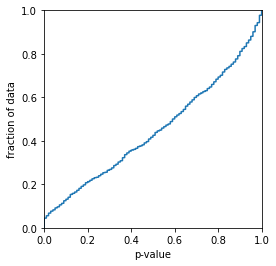

  0%|                                                                              | 1/1000 [00:43<11:56:54, 43.06s/it]

P-value: 0.83
Test stat: 0.14175350934496278
Null dist: [0.15175290336761482, 0.14192087833687617, 0.14998715925029138, 0.15045382732048462, 0.13818546758724082]


  0%|▏                                                                             | 2/1000 [01:25<11:53:18, 42.88s/it]

P-value: 0.49
Test stat: 0.14299759863887995
Null dist: [0.14057956734137955, 0.14884467985100203, 0.14284706873379738, 0.1371616244649294, 0.15274701677862312]


  0%|▏                                                                             | 3/1000 [02:07<11:49:41, 42.71s/it]

P-value: 0.36
Test stat: 0.14264406348655545
Null dist: [0.13700713559062438, 0.1474421763570214, 0.144641538060716, 0.1472914488508087, 0.13961464581801508]


  0%|▎                                                                             | 4/1000 [02:55<12:12:55, 44.15s/it]

P-value: 0.06
Test stat: 0.1446691145842235
Null dist: [0.13827015543975785, 0.1388500976831294, 0.133746524556682, 0.1392860697697228, 0.14326809614053615]


  0%|▍                                                                             | 5/1000 [03:40<12:16:13, 44.40s/it]

P-value: 0.41
Test stat: 0.14711040144308718
Null dist: [0.13829547615514026, 0.15021729969580266, 0.14954114337958246, 0.14674631172182195, 0.1489985657962729]


  1%|▍                                                                             | 6/1000 [04:24<12:13:41, 44.29s/it]

P-value: 0.97
Test stat: 0.13327982538354777
Null dist: [0.14563285723491404, 0.1390528329067684, 0.15334266278227304, 0.13666940820574724, 0.13872562569529956]


  1%|▌                                                                             | 7/1000 [05:06<12:03:03, 43.69s/it]

P-value: 0.0
Test stat: 0.1524297350298084
Null dist: [0.14266843139785257, 0.1347906083321565, 0.13454818898896426, 0.13437754096482102, 0.13815363412852477]


  1%|▌                                                                             | 8/1000 [05:49<11:56:30, 43.34s/it]

P-value: 0.8
Test stat: 0.1387186117762098
Null dist: [0.1533658224293838, 0.1396775787141128, 0.13624082189961462, 0.14124356841158814, 0.14345181113522942]


  1%|▋                                                                             | 9/1000 [06:31<11:51:28, 43.08s/it]

P-value: 0.44
Test stat: 0.14292834565909096
Null dist: [0.14246987098477537, 0.1405732844732489, 0.1468360186789588, 0.14182879009595695, 0.14829513008116824]


  1%|▊                                                                            | 10/1000 [07:13<11:44:34, 42.70s/it]

P-value: 0.97
Test stat: 0.13488666510637626
Null dist: [0.13739652922376744, 0.1452372243601655, 0.1376087249660607, 0.14385917652323787, 0.14038164945137266]


  1%|▊                                                                            | 11/1000 [07:56<11:43:13, 42.66s/it]

P-value: 0.92
Test stat: 0.13747268798317158
Null dist: [0.14454077622290884, 0.13318929745854446, 0.13402704910397123, 0.14406162571374104, 0.14922503245023688]


  1%|▉                                                                            | 12/1000 [08:39<11:44:52, 42.81s/it]

P-value: 0.98
Test stat: 0.13245693448014928
Null dist: [0.1345921793303847, 0.14415645458107818, 0.1413816334017599, 0.13933605438707375, 0.13537926785039944]


  1%|█                                                                            | 13/1000 [09:21<11:43:06, 42.74s/it]

P-value: 0.84
Test stat: 0.1398701877930375
Null dist: [0.1468133041487567, 0.1481605927187667, 0.14590794717829814, 0.14567961954856667, 0.14296254555427856]


  1%|█                                                                            | 14/1000 [10:05<11:46:45, 43.01s/it]

P-value: 1.0
Test stat: 0.13310194692147015
Null dist: [0.13741251514311703, 0.14113228837530434, 0.13972941295824381, 0.14524708020233446, 0.13478770195266254]


  2%|█▏                                                                           | 15/1000 [10:48<11:47:44, 43.11s/it]

P-value: 0.62
Test stat: 0.14083220384415784
Null dist: [0.14200472836550182, 0.14139323758696432, 0.14631311882823828, 0.1467243144006275, 0.1443757469423188]


  2%|█▏                                                                           | 16/1000 [11:30<11:40:53, 42.74s/it]

P-value: 0.91
Test stat: 0.13922645226470987
Null dist: [0.14540067091591447, 0.13937939192517546, 0.14035069699707847, 0.14588336234515775, 0.15017459959483948]


  2%|█▎                                                                           | 17/1000 [12:13<11:40:42, 42.77s/it]

P-value: 0.21
Test stat: 0.14547731406418773
Null dist: [0.14144357359716997, 0.14296879743139135, 0.14086524354199048, 0.14845310246136445, 0.14192956982007998]


  2%|█▍                                                                           | 18/1000 [13:13<13:02:37, 47.82s/it]

P-value: 1.0
Test stat: 0.12766886460055538
Null dist: [0.13696766856621634, 0.1351678211602818, 0.13846336777050394, 0.150094413845402, 0.14514761683030997]


  2%|█▍                                                                           | 19/1000 [13:57<12:47:30, 46.94s/it]

P-value: 0.0
Test stat: 0.15068894485039952
Null dist: [0.13341959183129326, 0.13953979718234066, 0.13414906709228436, 0.1377627798721166, 0.14200308750520507]


  2%|█▌                                                                           | 20/1000 [14:41<12:31:48, 46.03s/it]

P-value: 0.0
Test stat: 0.160157519325554
Null dist: [0.14694814524733346, 0.14018934619697498, 0.14949492769156225, 0.14458393288481186, 0.14582315595512774]


  2%|█▌                                                                           | 21/1000 [15:25<12:18:04, 45.23s/it]

P-value: 0.98
Test stat: 0.13505026845343937
Null dist: [0.1457758916039592, 0.1418436740360507, 0.143841561859824, 0.14913818393776412, 0.14369751742518266]


  2%|█▋                                                                           | 22/1000 [16:08<12:08:13, 44.68s/it]

P-value: 0.23
Test stat: 0.1438859063228375
Null dist: [0.1455246158557456, 0.14138038132825914, 0.13540349765825288, 0.13956921177345327, 0.1423389542026301]


  2%|█▊                                                                           | 23/1000 [16:52<12:04:35, 44.50s/it]

P-value: 0.95
Test stat: 0.1379139025927668
Null dist: [0.14943240446101402, 0.14976310178944507, 0.14048625085579147, 0.1449602956685917, 0.14634146532990844]


  2%|█▊                                                                           | 24/1000 [17:36<11:58:05, 44.15s/it]

P-value: 0.2
Test stat: 0.14720913763997268
Null dist: [0.14808410754745738, 0.14911828706930552, 0.14491796110301058, 0.14623430637342172, 0.14349116138784934]


  2%|█▉                                                                           | 25/1000 [18:20<11:59:39, 44.29s/it]

P-value: 0.0
Test stat: 0.1571626624672008
Null dist: [0.14135298799807816, 0.14080315663483645, 0.14167037899869328, 0.14852837338701264, 0.13942354774462629]


  3%|██                                                                           | 26/1000 [19:04<11:58:39, 44.27s/it]

P-value: 0.94
Test stat: 0.1346361611298389
Null dist: [0.14290107768248717, 0.14544772814362505, 0.1379452083665037, 0.13293438764845855, 0.13399608698791632]


  3%|██                                                                           | 27/1000 [19:48<11:56:30, 44.18s/it]

P-value: 0.59
Test stat: 0.14182153365717376
Null dist: [0.14780793611009846, 0.13647974851267308, 0.14144424765018115, 0.14170211173411829, 0.15418771830714584]


  3%|██▏                                                                          | 28/1000 [20:33<11:56:08, 44.21s/it]

P-value: 0.24
Test stat: 0.1485415277664468
Null dist: [0.14229234281210268, 0.14243444097877345, 0.14300742364405894, 0.13925536420731366, 0.14540638031350417]


  3%|██▏                                                                          | 29/1000 [21:16<11:51:46, 43.98s/it]

P-value: 0.0
Test stat: 0.18490099877840838
Null dist: [0.14726381395799104, 0.13523733507817615, 0.14662390732838404, 0.14480469899357307, 0.1412927843447147]


  3%|██▎                                                                          | 30/1000 [21:59<11:47:35, 43.77s/it]

P-value: 0.88
Test stat: 0.1407747591548031
Null dist: [0.14509426665684033, 0.15425422045951265, 0.1430263523415478, 0.15149837433942503, 0.14209699532535391]


  3%|██▍                                                                          | 31/1000 [22:49<12:13:36, 45.42s/it]

P-value: 0.41
Test stat: 0.14176929321316611
Null dist: [0.13911806987695285, 0.13773597866261378, 0.1368319812719564, 0.1369910988645089, 0.137585400121914]


  3%|██▍                                                                          | 32/1000 [23:32<12:05:08, 44.95s/it]

P-value: 0.0
Test stat: 0.14876007677004155
Null dist: [0.14258920567247058, 0.13785948144470694, 0.13890428225030116, 0.14148503817918234, 0.1405466985382594]


  3%|██▌                                                                          | 33/1000 [24:17<12:02:25, 44.82s/it]

P-value: 0.96
Test stat: 0.13742805431504712
Null dist: [0.14128476231358167, 0.14335536968575524, 0.14099816791100217, 0.1351882762853378, 0.14311184807598998]


  3%|██▌                                                                          | 34/1000 [25:01<11:58:48, 44.65s/it]

P-value: 0.0
Test stat: 0.1546182562729027
Null dist: [0.14024898852789347, 0.13659403999973185, 0.14255298357205337, 0.1420319751597119, 0.13580310125509587]


  4%|██▋                                                                          | 35/1000 [25:45<11:53:44, 44.38s/it]

P-value: 0.73
Test stat: 0.14003388254055926
Null dist: [0.15223291817841444, 0.13491519651412753, 0.14139643003459412, 0.14141410988439607, 0.13522836836912655]


  4%|██▊                                                                          | 36/1000 [26:30<11:57:08, 44.64s/it]

P-value: 0.15
Test stat: 0.14708120829273774
Null dist: [0.14143303548133002, 0.13726854949826128, 0.14482255206527295, 0.14510765614109045, 0.13957457638622583]


  4%|██▊                                                                          | 37/1000 [27:14<11:50:27, 44.27s/it]

P-value: 0.96
Test stat: 0.13426371033170026
Null dist: [0.15130200237248603, 0.1383619879510024, 0.14151649236283015, 0.1358521553155062, 0.13816268598514536]


  4%|██▉                                                                          | 38/1000 [27:57<11:47:17, 44.11s/it]

P-value: 1.0
Test stat: 0.13130839866860522
Null dist: [0.13933207618085253, 0.14331565969932814, 0.15509164910616724, 0.1415954733245418, 0.14480349524299185]


  4%|███                                                                          | 39/1000 [28:43<11:56:13, 44.72s/it]

P-value: 0.61
Test stat: 0.1391420556629238
Null dist: [0.1358896906141407, 0.13849453437857073, 0.13866609447070322, 0.13998358109681608, 0.1381585079186698]


  4%|███                                                                          | 40/1000 [29:27<11:47:19, 44.21s/it]

P-value: 0.66
Test stat: 0.14028522731047266
Null dist: [0.1408382936777961, 0.140699439266887, 0.135719958663449, 0.14273042760854937, 0.14719643397160964]


  4%|███▏                                                                         | 41/1000 [30:10<11:42:30, 43.95s/it]

P-value: 0.95
Test stat: 0.13836211588114866
Null dist: [0.1428946530338694, 0.14588328760887848, 0.14403673530906536, 0.15114288782963747, 0.14543447029712453]


  4%|███▏                                                                         | 42/1000 [30:54<11:43:30, 44.06s/it]

P-value: 1.0
Test stat: 0.13578054977893772
Null dist: [0.14459472743945334, 0.14348035484309796, 0.15963592360665724, 0.13855501825821326, 0.14226052662553512]


  4%|███▎                                                                         | 43/1000 [31:42<12:00:43, 45.19s/it]

P-value: 0.82
Test stat: 0.14220848069363345
Null dist: [0.15208319045175933, 0.14915882918302925, 0.14335347976892843, 0.14632828219456184, 0.15604270153397304]


  4%|███▍                                                                         | 44/1000 [32:21<11:31:13, 43.38s/it]

P-value: 0.43
Test stat: 0.14374779788868963
Null dist: [0.140561087028518, 0.13578651669217412, 0.14211129034693704, 0.1489347573374461, 0.14002518489749904]


  4%|███▍                                                                         | 45/1000 [33:05<11:32:44, 43.52s/it]

P-value: 0.0
Test stat: 0.16768476374960906
Null dist: [0.1352020421251393, 0.14404258144867166, 0.12380748183405521, 0.1372752978469538, 0.13154888558962152]


  5%|███▌                                                                         | 46/1000 [33:44<11:09:39, 42.12s/it]

P-value: 1.0
Test stat: 0.13349363362124167
Null dist: [0.1415803256191862, 0.1476754361321333, 0.1405796221111547, 0.14783275680438146, 0.14467738743887826]


  5%|███▌                                                                         | 47/1000 [34:24<10:57:47, 41.41s/it]

P-value: 0.82
Test stat: 0.14042076400000347
Null dist: [0.15163867233363337, 0.14934220863862846, 0.13736540956212617, 0.14788521356522688, 0.1419529650728083]


  5%|███▋                                                                         | 48/1000 [35:02<10:42:08, 40.47s/it]

P-value: 0.02
Test stat: 0.14719068027716598
Null dist: [0.1429073121541844, 0.13815945294865417, 0.15097783902139195, 0.1409877360858961, 0.14257191859406493]


  5%|███▊                                                                         | 49/1000 [35:40<10:29:40, 39.73s/it]

P-value: 0.87
Test stat: 0.1377971945694526
Null dist: [0.13572026509426616, 0.14065169154929624, 0.14374576188352284, 0.14697127993741, 0.14405666394154826]


  5%|███▊                                                                         | 50/1000 [36:20<10:29:19, 39.75s/it]

P-value: 0.91
Test stat: 0.14257165413235628
Null dist: [0.1424062656062972, 0.15231391163352115, 0.14372661928575936, 0.1465778858407617, 0.1413108655045774]


  5%|███▉                                                                         | 51/1000 [36:58<10:23:15, 39.41s/it]

P-value: 0.16
Test stat: 0.14470482465461754
Null dist: [0.14622192674075862, 0.14138238547246984, 0.14445611195171582, 0.1320229858223384, 0.13547329756255622]


  5%|████                                                                         | 52/1000 [37:37<10:17:59, 39.11s/it]

P-value: 0.68
Test stat: 0.14292951918978336
Null dist: [0.14713889006538527, 0.14875935396345696, 0.1393426521659582, 0.14059379516035486, 0.14134111164569063]


  5%|████                                                                         | 53/1000 [38:16<10:15:47, 39.02s/it]

P-value: 0.9
Test stat: 0.1390652074472285
Null dist: [0.1485881033337283, 0.15259968980967697, 0.14139467909438808, 0.14637470861897195, 0.1526380072299366]


  5%|████▏                                                                        | 54/1000 [38:57<10:27:41, 39.81s/it]

P-value: 0.16
Test stat: 0.14547007368193177
Null dist: [0.14165943654465596, 0.14712802958271598, 0.14742139691573086, 0.1418636661157937, 0.1487982226539566]


  6%|████▏                                                                        | 55/1000 [39:41<10:43:41, 40.87s/it]

P-value: 0.09
Test stat: 0.1489410075225549
Null dist: [0.14270281187595057, 0.13727360046320747, 0.13831996442454375, 0.14812553941553575, 0.1429936069455241]


  6%|████▎                                                                        | 56/1000 [40:20<10:37:57, 40.55s/it]

P-value: 0.22
Test stat: 0.14564477234014328
Null dist: [0.1458855670998509, 0.14408018305592518, 0.14484972923465422, 0.14203821359963797, 0.14060569637373022]


  6%|████▍                                                                        | 57/1000 [40:59<10:27:35, 39.93s/it]

P-value: 0.97
Test stat: 0.13616244007011458
Null dist: [0.13467616464325827, 0.14292900390059682, 0.14395529406698815, 0.147061594311226, 0.14951470298114167]


  6%|████▍                                                                        | 58/1000 [41:36<10:15:43, 39.22s/it]

P-value: 0.42
Test stat: 0.1426164154592332
Null dist: [0.141295232608602, 0.14788298621781615, 0.13600023154933605, 0.1330470388064816, 0.1388065941822091]


  6%|████▌                                                                        | 59/1000 [42:14<10:09:05, 38.84s/it]

P-value: 0.05
Test stat: 0.1467984494155229
Null dist: [0.13553919179429996, 0.13926955332820223, 0.14123517714193456, 0.14675129189673053, 0.13743542647548324]


  6%|████▌                                                                        | 60/1000 [43:09<11:21:59, 43.53s/it]

P-value: 0.96
Test stat: 0.13307522522166138
Null dist: [0.14500460952751615, 0.14079725757773232, 0.14352883503753577, 0.14296242134380144, 0.14141838327987466]


  6%|████▋                                                                        | 61/1000 [43:49<11:04:12, 42.44s/it]

P-value: 0.99
Test stat: 0.1347840462456369
Null dist: [0.14172649941856263, 0.13534342929660592, 0.1427791914788512, 0.1490036862842935, 0.14512220341327764]


  6%|████▊                                                                        | 62/1000 [44:27<10:42:41, 41.11s/it]

P-value: 0.73
Test stat: 0.14054426378352158
Null dist: [0.14042853048767767, 0.13684653785416057, 0.1403919587745741, 0.14864741950764992, 0.1482741470139084]


  6%|████▊                                                                        | 63/1000 [45:04<10:25:32, 40.06s/it]

P-value: 0.76
Test stat: 0.1366771901947641
Null dist: [0.1368097027930446, 0.14754893751344933, 0.13864188530228294, 0.13616594704763052, 0.13751276162417048]


  6%|████▉                                                                        | 64/1000 [45:42<10:14:23, 39.38s/it]

P-value: 0.3
Test stat: 0.14427438028558603
Null dist: [0.14445247958256746, 0.14271930822233703, 0.14258503000154255, 0.14118263034480494, 0.13732779391763317]


  6%|█████                                                                        | 65/1000 [46:20<10:05:47, 38.87s/it]

P-value: 0.44
Test stat: 0.14041753055553097
Null dist: [0.14057062796188635, 0.14731978751224228, 0.147333006991049, 0.1437164915645741, 0.14176321193924157]


  7%|█████                                                                        | 66/1000 [46:58<10:01:27, 38.64s/it]

P-value: 0.52
Test stat: 0.14426613498992746
Null dist: [0.1478961694652814, 0.1428602853764389, 0.13430170846098766, 0.14435082427662682, 0.14595874748365056]


  7%|█████▏                                                                        | 67/1000 [47:35<9:53:54, 38.19s/it]

P-value: 0.04
Test stat: 0.1508296507054565
Null dist: [0.1468300411229393, 0.14045461847469842, 0.1405153618404017, 0.14167718742924684, 0.14046021300610467]


  7%|█████▎                                                                        | 68/1000 [48:13<9:53:13, 38.19s/it]

P-value: 0.52
Test stat: 0.14399140048439485
Null dist: [0.14517226355866342, 0.14185220846642632, 0.15561678567709236, 0.14925159826565026, 0.15344476359434256]


  7%|█████▍                                                                        | 69/1000 [48:52<9:55:19, 38.37s/it]

P-value: 0.74
Test stat: 0.14148034233093232
Null dist: [0.13627481284113308, 0.14225066696166133, 0.1439649631151263, 0.1440424849011267, 0.14680893491056768]


  7%|█████▍                                                                        | 70/1000 [49:29<9:49:33, 38.04s/it]

P-value: 1.0
Test stat: 0.13081041260022708
Null dist: [0.1515812232865712, 0.14293704349250103, 0.14301878176124816, 0.14749400541270208, 0.13437696364661256]


  7%|█████▌                                                                        | 71/1000 [50:07<9:48:36, 38.02s/it]

P-value: 0.68
Test stat: 0.14052932149791864
Null dist: [0.14695080927279802, 0.14733679164434277, 0.1412211410914851, 0.14248124682844399, 0.14555308750741613]


  7%|█████▌                                                                        | 72/1000 [50:45<9:48:43, 38.06s/it]

P-value: 0.99
Test stat: 0.130603405049186
Null dist: [0.13503091024353575, 0.141865144703484, 0.1358877866728746, 0.14780402725879738, 0.14178982907036797]


  7%|█████▋                                                                        | 73/1000 [51:23<9:47:01, 38.00s/it]

P-value: 0.24
Test stat: 0.1445750933697849
Null dist: [0.1342078481121466, 0.1410000006978025, 0.1432949638882548, 0.144624493891355, 0.14167487920159128]


  7%|█████▊                                                                        | 74/1000 [52:01<9:46:12, 37.98s/it]

P-value: 1.0
Test stat: 0.13109937813215478
Null dist: [0.1423483698473007, 0.1438186002258821, 0.14804338364837732, 0.1380220747215174, 0.13821421669522715]


  8%|█████▊                                                                        | 75/1000 [52:42<9:56:26, 38.69s/it]

P-value: 0.78
Test stat: 0.1363005701735578
Null dist: [0.14370660706752236, 0.1331778665413329, 0.14243696163255148, 0.13832392818473915, 0.13969496985871788]


  8%|█████▉                                                                        | 76/1000 [53:19<9:49:41, 38.29s/it]

P-value: 0.0
Test stat: 0.17267383445558582
Null dist: [0.1350649750514119, 0.13608232995412317, 0.1306058383300155, 0.13627007183030437, 0.13061926422026426]


  8%|██████                                                                        | 77/1000 [53:56<9:45:08, 38.04s/it]

P-value: 0.26
Test stat: 0.14376917053337213
Null dist: [0.1342419584112523, 0.14348871179041545, 0.14804724413747783, 0.14042394803933933, 0.143988663174898]


  8%|██████                                                                        | 78/1000 [54:34<9:43:43, 37.99s/it]

P-value: 1.0
Test stat: 0.12887130959602533
Null dist: [0.14208292773960696, 0.1392581993387374, 0.13799655604429117, 0.13691735396063975, 0.14775348312541636]


  8%|██████▏                                                                       | 79/1000 [55:12<9:42:27, 37.95s/it]

P-value: 0.28
Test stat: 0.14042278086068904
Null dist: [0.13779335086997513, 0.13292446504778066, 0.1330432273941875, 0.13800300784062003, 0.149266373714265]


  8%|██████▏                                                                       | 80/1000 [55:50<9:39:57, 37.82s/it]

P-value: 0.76
Test stat: 0.13676392332775156
Null dist: [0.14131235565886835, 0.1459214524019563, 0.13285282855844271, 0.13608141634485194, 0.13986668107892364]


  8%|██████▎                                                                       | 81/1000 [56:28<9:41:05, 37.94s/it]

P-value: 0.17
Test stat: 0.1436149683430642
Null dist: [0.14232671433042032, 0.1431727511608657, 0.14256116059922386, 0.1413472586742781, 0.1381319075228462]


  8%|██████▍                                                                       | 82/1000 [57:06<9:39:49, 37.90s/it]

P-value: 0.93
Test stat: 0.1391791007321973
Null dist: [0.14251150452202943, 0.14400256663705102, 0.14757033756723803, 0.14220790966548402, 0.14729603440367178]


  8%|██████▍                                                                       | 83/1000 [57:43<9:38:09, 37.83s/it]

P-value: 0.01
Test stat: 0.15138576954649519
Null dist: [0.135343611068807, 0.13753718924893577, 0.13703665967123246, 0.14045835731625722, 0.1420303317317949]


  8%|██████▌                                                                       | 84/1000 [58:21<9:36:30, 37.76s/it]

P-value: 0.22
Test stat: 0.14513705512671682
Null dist: [0.13199551267275433, 0.14102059573098547, 0.13328119533271832, 0.14409222555786316, 0.14393560054340282]


  8%|██████▋                                                                       | 85/1000 [58:59<9:35:59, 37.77s/it]

P-value: 0.0
Test stat: 0.16423498338400178
Null dist: [0.14634101809557443, 0.13971862756533726, 0.1495976466137372, 0.14571931874222455, 0.14235766426437924]


  9%|██████▋                                                                       | 86/1000 [59:36<9:32:26, 37.58s/it]

P-value: 0.0
Test stat: 0.1508530430369892
Null dist: [0.1435416376506743, 0.12267407242284356, 0.13540589092594013, 0.1421123726335759, 0.12645505459090034]


  9%|██████▌                                                                     | 87/1000 [1:00:13<9:30:33, 37.50s/it]

P-value: 0.99
Test stat: 0.13622003913271974
Null dist: [0.14411946744565096, 0.13870236917994705, 0.1452738379009958, 0.13865458468699632, 0.14755649422172756]


  9%|██████▋                                                                     | 88/1000 [1:00:51<9:32:40, 37.68s/it]

P-value: 1.0
Test stat: 0.12846541072212503
Null dist: [0.13284086166263342, 0.13846648709072873, 0.14434762571866488, 0.1362129516184658, 0.14110084564158643]


  9%|██████▊                                                                     | 89/1000 [1:01:29<9:30:24, 37.57s/it]

P-value: 0.0
Test stat: 0.16567198917935222
Null dist: [0.14016936223919418, 0.14487854167020586, 0.1351197335877129, 0.14433142860955384, 0.14318637363945352]


  9%|██████▊                                                                     | 90/1000 [1:02:06<9:28:09, 37.46s/it]

P-value: 0.0
Test stat: 0.1807097333719424
Null dist: [0.1465884675988468, 0.15078028841237934, 0.14018709966513687, 0.13755395500722745, 0.149596659752954]


  9%|██████▉                                                                     | 91/1000 [1:02:46<9:40:58, 38.35s/it]

P-value: 0.99
Test stat: 0.13152930175554123
Null dist: [0.13598648467702656, 0.13739455818710633, 0.13677636870553878, 0.14054227486499338, 0.13542825492631927]


  9%|██████▉                                                                     | 92/1000 [1:03:24<9:37:33, 38.16s/it]

P-value: 0.39
Test stat: 0.144215859186142
Null dist: [0.14134643208918196, 0.14419707982968955, 0.1454680785201462, 0.14336399845508896, 0.14047423684275584]


  9%|███████                                                                     | 93/1000 [1:04:04<9:43:35, 38.61s/it]

P-value: 0.44
Test stat: 0.14132672472776753
Null dist: [0.15017221636216493, 0.1469586782720087, 0.14180123253948262, 0.14223055615093527, 0.14924265331620845]


  9%|███████▏                                                                    | 94/1000 [1:04:42<9:40:09, 38.42s/it]

P-value: 0.99
Test stat: 0.13502052176110757
Null dist: [0.13824853241557566, 0.14764936357671632, 0.1364119026395576, 0.1426498021023197, 0.14569668419308457]


 10%|███████▏                                                                    | 95/1000 [1:05:19<9:35:54, 38.18s/it]

P-value: 0.98
Test stat: 0.135698488030089
Null dist: [0.1376345349624264, 0.13651973273163154, 0.14038527831894843, 0.1455155111270684, 0.1410319137057614]


 10%|███████▎                                                                    | 96/1000 [1:05:57<9:32:39, 38.01s/it]

P-value: 0.89
Test stat: 0.13164308827433424
Null dist: [0.13654221748006212, 0.13783269363125572, 0.13215807789954548, 0.1393617134329348, 0.13754910251761088]


 10%|███████▎                                                                    | 97/1000 [1:06:35<9:31:44, 37.99s/it]

P-value: 0.04
Test stat: 0.15488492158384226
Null dist: [0.15325417575823763, 0.14400920017449115, 0.1454194095543685, 0.14535804604390312, 0.13894467813807898]


 10%|███████▍                                                                    | 98/1000 [1:07:12<9:29:12, 37.86s/it]

P-value: 1.0
Test stat: 0.13395354113112112
Null dist: [0.13999909575892555, 0.14676362277048804, 0.14355139637775005, 0.1498886860838038, 0.14510517129516032]


 10%|███████▌                                                                    | 99/1000 [1:07:50<9:28:18, 37.85s/it]

P-value: 0.75
Test stat: 0.13559625266110176
Null dist: [0.1401440714290677, 0.1379866548058556, 0.14588862288355242, 0.1367217987596231, 0.14217030897398142]


 10%|███████▌                                                                   | 100/1000 [1:08:28<9:27:31, 37.83s/it]

P-value: 0.26
Test stat: 0.14324088692245485
Null dist: [0.13975959465845578, 0.14026471474242552, 0.14495609766256945, 0.13970732776506722, 0.14352153293009073]


 10%|███████▌                                                                   | 101/1000 [1:09:06<9:27:36, 37.88s/it]

P-value: 0.55
Test stat: 0.14551215281427587
Null dist: [0.1433884755263144, 0.1403717493288057, 0.14686987144245223, 0.141353856789317, 0.14386410644298264]


 10%|███████▋                                                                   | 102/1000 [1:09:43<9:25:45, 37.80s/it]

P-value: 0.05
Test stat: 0.14838675196052442
Null dist: [0.1416912617427153, 0.13654552597783243, 0.13595310700394858, 0.14766539715168292, 0.1489065815159144]


 10%|███████▋                                                                   | 103/1000 [1:10:21<9:24:55, 37.79s/it]

P-value: 0.62
Test stat: 0.13745093781047424
Null dist: [0.14034645350972408, 0.13972159391615357, 0.1418165849234394, 0.1367908878443994, 0.14015702018452691]


 10%|███████▊                                                                   | 104/1000 [1:11:01<9:31:28, 38.27s/it]

P-value: 0.06
Test stat: 0.14545865665691682
Null dist: [0.1413290788449132, 0.1342199049347077, 0.13439954025375733, 0.136676844718571, 0.14051625625145425]


 10%|███████▉                                                                   | 105/1000 [1:11:38<9:28:24, 38.11s/it]

P-value: 0.53
Test stat: 0.140321663560955
Null dist: [0.1419693719332109, 0.1415539354703763, 0.14371382524224163, 0.13934268401156713, 0.14646395874438245]


 11%|███████▉                                                                   | 106/1000 [1:12:16<9:25:40, 37.96s/it]

P-value: 0.81
Test stat: 0.13969015332758372
Null dist: [0.14700313304781432, 0.15078758472814147, 0.14164051944058298, 0.14089698845764076, 0.1427619798531663]


 11%|███████▉                                                                  | 107/1000 [1:13:03<10:07:04, 40.79s/it]

P-value: 0.75
Test stat: 0.14162386713634023
Null dist: [0.1421415251212852, 0.1406653695974054, 0.15107729830953676, 0.14356113589618402, 0.15294486305063482]


 11%|████████                                                                   | 108/1000 [1:13:41<9:52:55, 39.88s/it]

P-value: 0.97
Test stat: 0.1353694218916428
Null dist: [0.1479202705462993, 0.14102353941942014, 0.1419343538097525, 0.13643763036077194, 0.14139189480611114]


 11%|████████                                                                  | 109/1000 [1:14:28<10:23:20, 41.98s/it]

P-value: 0.0
Test stat: 0.164420633917171
Null dist: [0.14615396178217888, 0.14962905493379908, 0.14330856872260278, 0.1460672166859549, 0.1509356965224412]


 11%|████████▏                                                                 | 110/1000 [1:15:17<10:52:30, 43.99s/it]

P-value: 0.99
Test stat: 0.1329994963230522
Null dist: [0.13850856780210807, 0.13824930295399063, 0.14029059932146837, 0.14383714660037528, 0.14170473443171716]


 11%|████████▏                                                                 | 111/1000 [1:16:01<10:53:07, 44.08s/it]

P-value: 0.92
Test stat: 0.1364837591415463
Null dist: [0.15158140666240782, 0.1431303935099839, 0.1402178730871968, 0.138801369886685, 0.14257904609456928]


 11%|████████▎                                                                 | 112/1000 [1:16:40<10:28:09, 42.44s/it]

P-value: 0.57
Test stat: 0.13938579661296957
Null dist: [0.13425387228888686, 0.13611248621416827, 0.138425836033781, 0.13889250349544624, 0.1447430634734851]


 11%|████████▎                                                                 | 113/1000 [1:17:18<10:08:16, 41.15s/it]

P-value: 0.88
Test stat: 0.13739481294473
Null dist: [0.142398502630243, 0.13958914842017411, 0.14206873400762488, 0.13149247777999662, 0.14655997769379725]


 11%|████████▌                                                                  | 114/1000 [1:17:56<9:53:11, 40.17s/it]

P-value: 1.0
Test stat: 0.1312886596262458
Null dist: [0.1483752278831797, 0.14750036400636057, 0.1419928217378813, 0.14340713431822205, 0.14061174039716928]


 12%|████████▋                                                                  | 115/1000 [1:18:34<9:45:43, 39.71s/it]

P-value: 0.42
Test stat: 0.14261628849512686
Null dist: [0.14209635659003883, 0.14241270559451547, 0.14573470169874514, 0.14988362369304253, 0.1442560704484398]


 12%|████████▋                                                                  | 116/1000 [1:19:12<9:37:55, 39.23s/it]

P-value: 0.05
Test stat: 0.14335428744358292
Null dist: [0.13331578308983794, 0.1349033922420083, 0.13197308877009406, 0.13687765310088595, 0.1352458852004761]


 12%|████████▊                                                                  | 117/1000 [1:19:50<9:30:24, 38.76s/it]

P-value: 0.49
Test stat: 0.14301367898275508
Null dist: [0.13650814906656994, 0.14623199151027544, 0.14404785815473908, 0.14523090810358574, 0.1409244192989466]


 12%|████████▊                                                                  | 118/1000 [1:20:28<9:26:26, 38.53s/it]

P-value: 0.4
Test stat: 0.14275621525638482
Null dist: [0.14418992697367738, 0.13503971322235242, 0.144640025262183, 0.13629904472620957, 0.14538622274590007]


 12%|████████▉                                                                  | 119/1000 [1:21:07<9:27:52, 38.68s/it]

P-value: 0.97
Test stat: 0.13503467564736016
Null dist: [0.14809069764498006, 0.14600937289835736, 0.1415996467021008, 0.14261918531544415, 0.137907966316569]


 12%|█████████                                                                  | 120/1000 [1:21:45<9:22:20, 38.34s/it]

P-value: 0.91
Test stat: 0.13710642840631726
Null dist: [0.14679751143905195, 0.1428237816120742, 0.14241347352785827, 0.14556636940069534, 0.1444226671826886]


 12%|█████████                                                                  | 121/1000 [1:22:22<9:19:00, 38.16s/it]

P-value: 0.0
Test stat: 0.16478485414752742
Null dist: [0.13163808788218978, 0.14018219537061571, 0.1410412357868931, 0.14415384279704957, 0.13677881107910883]


 12%|█████████▏                                                                 | 122/1000 [1:23:07<9:47:09, 40.12s/it]

P-value: 0.97
Test stat: 0.13740289899561597
Null dist: [0.14742670096051458, 0.14600392407385399, 0.14436865533916887, 0.14326087035413027, 0.14535763847794136]


 12%|█████████▏                                                                 | 123/1000 [1:23:45<9:37:42, 39.52s/it]

P-value: 1.0
Test stat: 0.12962846206152356
Null dist: [0.14167014979736037, 0.13902481301469582, 0.1524773228927757, 0.13600533154553585, 0.14524993065327563]


 12%|█████████▎                                                                 | 124/1000 [1:24:23<9:31:06, 39.12s/it]

P-value: 0.57
Test stat: 0.14322849187371545
Null dist: [0.14153851545353002, 0.1363112435741035, 0.14626196780524936, 0.14384241963290667, 0.14592317060065452]


 12%|█████████▍                                                                 | 125/1000 [1:25:02<9:27:40, 38.93s/it]

P-value: 0.97
Test stat: 0.13368656823430136
Null dist: [0.1461981483885072, 0.13366467706595164, 0.14221756786727857, 0.13927695035452892, 0.1396024381722788]


 13%|█████████▍                                                                 | 126/1000 [1:25:39<9:20:49, 38.50s/it]

P-value: 0.0
Test stat: 0.16811821361554058
Null dist: [0.14126465556458945, 0.1470250681704709, 0.13569387936830268, 0.15373456390057005, 0.14401227129528305]


 13%|█████████▌                                                                 | 127/1000 [1:26:17<9:17:11, 38.30s/it]

P-value: 0.24
Test stat: 0.1435881762186928
Null dist: [0.1407500493625965, 0.13559782083334582, 0.14746358350395772, 0.13739194668930277, 0.132977107627129]


 13%|█████████▌                                                                 | 128/1000 [1:26:57<9:23:23, 38.77s/it]

P-value: 0.81
Test stat: 0.1411646502503896
Null dist: [0.14015439756186543, 0.14702821992657433, 0.14359302790176764, 0.14323797971239438, 0.13814098420311682]


 13%|█████████▋                                                                 | 129/1000 [1:27:35<9:17:52, 38.43s/it]

P-value: 0.02
Test stat: 0.15240859832668086
Null dist: [0.13891907903410772, 0.14381589408223305, 0.14621890263649373, 0.14699443886182384, 0.15100977493292767]


 13%|█████████▊                                                                 | 130/1000 [1:28:12<9:13:28, 38.17s/it]

P-value: 0.0
Test stat: 0.17313508210428452
Null dist: [0.13455762568592566, 0.12947862459444137, 0.1358898105928641, 0.13540163071109812, 0.14406309630851888]


 13%|█████████▊                                                                 | 131/1000 [1:28:51<9:14:01, 38.25s/it]

P-value: 0.44
Test stat: 0.14546765677284001
Null dist: [0.1472850159428255, 0.14256241276484904, 0.14226345811648777, 0.14292259635288962, 0.14143577655587003]


 13%|█████████▉                                                                 | 132/1000 [1:29:29<9:14:38, 38.34s/it]

P-value: 0.79
Test stat: 0.13416934149801196
Null dist: [0.14038118196346716, 0.14805291269473497, 0.1381559025191249, 0.13285075395326074, 0.12754555641670184]


 13%|█████████▉                                                                 | 133/1000 [1:30:08<9:14:37, 38.38s/it]

P-value: 1.0
Test stat: 0.13000305351780395
Null dist: [0.14308069034655435, 0.14592314477496093, 0.13921988136558583, 0.14200495176215255, 0.14450728303634397]


 13%|██████████                                                                 | 134/1000 [1:30:47<9:17:30, 38.63s/it]

P-value: 0.0
Test stat: 0.16051098999936853
Null dist: [0.1400513872423088, 0.14092256865133457, 0.1394135341913344, 0.14119941566497007, 0.13013893168329915]


 14%|██████████▏                                                                | 135/1000 [1:31:25<9:13:01, 38.36s/it]

P-value: 0.03
Test stat: 0.1497469956624582
Null dist: [0.1399189309490877, 0.13470949994763104, 0.13773987917173292, 0.13501316522669127, 0.14224529614413028]


 14%|██████████▏                                                                | 136/1000 [1:32:03<9:11:16, 38.28s/it]

P-value: 0.27
Test stat: 0.14563778700572239
Null dist: [0.1516678224880229, 0.14814074937651733, 0.141344460694387, 0.14541811215524303, 0.1396553764484173]


 14%|██████████▎                                                                | 137/1000 [1:32:44<9:22:35, 39.11s/it]

P-value: 0.96
Test stat: 0.13259862617067808
Null dist: [0.14113066657588813, 0.1458158428222881, 0.146356620759862, 0.13391211353123744, 0.1362075565600861]


 14%|██████████▎                                                                | 138/1000 [1:33:22<9:18:34, 38.88s/it]

P-value: 0.76
Test stat: 0.13812676772890697
Null dist: [0.14129667488537245, 0.14501343911822973, 0.1436295734240417, 0.1400593993953423, 0.13996994368205795]


 14%|██████████▍                                                                | 139/1000 [1:34:00<9:13:03, 38.54s/it]

P-value: 0.57
Test stat: 0.14171581521598564
Null dist: [0.14325704505796633, 0.14316518139302425, 0.14007434320526346, 0.13624367179012875, 0.1462992262082662]


 14%|██████████▌                                                                | 140/1000 [1:34:38<9:10:02, 38.37s/it]

P-value: 0.29
Test stat: 0.14183163061738813
Null dist: [0.1475117331074839, 0.14027717701264086, 0.13749527178408305, 0.13748583390375568, 0.1392991518219352]


 14%|██████████▌                                                                | 141/1000 [1:35:16<9:10:13, 38.43s/it]

P-value: 0.07
Test stat: 0.14654112199600222
Null dist: [0.132904415032566, 0.14769486082035643, 0.1424566744453868, 0.1352073744012231, 0.14190265660830292]


 14%|██████████▋                                                                | 142/1000 [1:36:01<9:34:35, 40.18s/it]

P-value: 0.76
Test stat: 0.13927064603493933
Null dist: [0.1421164431320564, 0.1415625528373221, 0.14119909230807914, 0.1368190726938796, 0.13813793904697624]


 14%|██████████▌                                                               | 143/1000 [1:36:57<10:44:16, 45.11s/it]

P-value: 0.34
Test stat: 0.1444839929122702
Null dist: [0.14335756095421626, 0.14767754824398127, 0.14009513896644588, 0.14192115320106113, 0.14585522529709072]


 14%|██████████▋                                                               | 144/1000 [1:37:38<10:23:15, 43.69s/it]

P-value: 0.17
Test stat: 0.14673461924892528
Null dist: [0.135132069483624, 0.14700536269671338, 0.1347571629583445, 0.14327481638939232, 0.141647446333392]


 14%|██████████▋                                                               | 145/1000 [1:38:19<10:11:45, 42.93s/it]

P-value: 0.79
Test stat: 0.14098532557232246
Null dist: [0.1478790280219172, 0.13625738253893172, 0.14697307066970444, 0.13885775327814298, 0.1410585806991348]


 15%|██████████▊                                                               | 146/1000 [1:39:04<10:18:48, 43.48s/it]

P-value: 0.96
Test stat: 0.13870406294297977
Null dist: [0.14521210538298002, 0.15003915297052828, 0.13848736956750518, 0.14498390522040838, 0.14021683664633655]


 15%|██████████▉                                                               | 147/1000 [1:39:44<10:04:48, 42.54s/it]

P-value: 0.99
Test stat: 0.13500792950054363
Null dist: [0.1399770442069932, 0.14394176785257418, 0.1450445622303549, 0.14724876656658026, 0.13352869881822094]


 15%|███████████                                                                | 148/1000 [1:40:24<9:53:28, 41.79s/it]

P-value: 0.93
Test stat: 0.13505254335873362
Null dist: [0.13816835997417132, 0.14225689210994308, 0.14152274266255804, 0.1349809713303688, 0.13959185009220276]


 15%|███████████▏                                                               | 149/1000 [1:41:06<9:51:58, 41.74s/it]

P-value: 0.37
Test stat: 0.144693874469066
Null dist: [0.14073542365778247, 0.1415883870835758, 0.13699116415578527, 0.1439422285605807, 0.14344438889925049]


 15%|███████████▎                                                               | 150/1000 [1:41:45<9:43:11, 41.17s/it]

P-value: 0.99
Test stat: 0.1375992443005939
Null dist: [0.14803745445416816, 0.14498989215081948, 0.14969855666339937, 0.14977281944574727, 0.1450784775845636]


 15%|███████████▎                                                               | 151/1000 [1:42:27<9:42:28, 41.16s/it]

P-value: 0.63
Test stat: 0.14414623586262
Null dist: [0.1539242581132888, 0.13649958971819998, 0.14543899637682478, 0.14774556825308072, 0.14657525885064826]


 15%|███████████▍                                                               | 152/1000 [1:43:08<9:41:50, 41.17s/it]

P-value: 0.0
Test stat: 0.15092519634217438
Null dist: [0.1425721630060628, 0.13401435309933585, 0.12915339688701577, 0.1403953070921775, 0.14020414465009423]


 15%|███████████▍                                                               | 153/1000 [1:43:50<9:44:02, 41.37s/it]

P-value: 0.95
Test stat: 0.133457942005345
Null dist: [0.13973087797131656, 0.1425778594675574, 0.1415934845839335, 0.14099980628807163, 0.14204123865642015]


 15%|███████████▌                                                               | 154/1000 [1:44:32<9:45:54, 41.55s/it]

P-value: 0.95
Test stat: 0.1345791058364102
Null dist: [0.13229438421793394, 0.14785659832665832, 0.13728745710473944, 0.14705812062515533, 0.13624996912979115]


 16%|███████████▋                                                               | 155/1000 [1:45:12<9:40:11, 41.20s/it]

P-value: 0.65
Test stat: 0.1389608126211732
Null dist: [0.13981058994815387, 0.1426559571109487, 0.13950198276241377, 0.13919841257869658, 0.13926322557682702]


 16%|███████████▋                                                               | 156/1000 [1:45:52<9:35:46, 40.93s/it]

P-value: 0.94
Test stat: 0.1326002637561754
Null dist: [0.1401277145517622, 0.13848691478280573, 0.13481553364169718, 0.13537295298694096, 0.12962597897424155]


 16%|███████████▊                                                               | 157/1000 [1:46:36<9:46:14, 41.73s/it]

P-value: 0.92
Test stat: 0.13477733448853824
Null dist: [0.14900349510996524, 0.13956853218389975, 0.13661269976395263, 0.13205798775531363, 0.14498196703359045]


 16%|███████████▊                                                               | 158/1000 [1:47:16<9:38:49, 41.25s/it]

P-value: 0.8
Test stat: 0.13792074524075304
Null dist: [0.13923653177606943, 0.15511112994015552, 0.1388993099642778, 0.14213559724705194, 0.14375972205386534]


 16%|███████████▉                                                               | 159/1000 [1:47:59<9:44:55, 41.73s/it]

P-value: 0.22
Test stat: 0.14477475178542176
Null dist: [0.1453920313973941, 0.13703638149707364, 0.14075520571326872, 0.14450017699924522, 0.14148341466846792]


 16%|████████████                                                               | 160/1000 [1:48:40<9:40:32, 41.47s/it]

P-value: 0.27
Test stat: 0.14601457634466575
Null dist: [0.1360383223295497, 0.1468809195556341, 0.14363007888833068, 0.14708565486836345, 0.14595342781666143]


 16%|████████████                                                               | 161/1000 [1:49:21<9:40:29, 41.51s/it]

P-value: 0.23
Test stat: 0.1417420914183325
Null dist: [0.1401723517949155, 0.1434391069009141, 0.13291090861960342, 0.1364557963391132, 0.13849107468040034]


 16%|████████████▏                                                              | 162/1000 [1:49:59<9:24:34, 40.42s/it]

P-value: 0.47
Test stat: 0.14121151732778037
Null dist: [0.14028208903424189, 0.14101994242361138, 0.13856456100865666, 0.1408030801907013, 0.14688454928022854]


 16%|████████████▏                                                              | 163/1000 [1:50:37<9:13:28, 39.68s/it]

P-value: 0.56
Test stat: 0.14143363126744457
Null dist: [0.1448068818311291, 0.1391700414975382, 0.14123087209126728, 0.14339823239915117, 0.1437769655036235]


 16%|████████████▎                                                              | 164/1000 [1:51:16<9:07:50, 39.32s/it]

P-value: 0.56
Test stat: 0.1387936819508807
Null dist: [0.13744988268418312, 0.14248166049728805, 0.13293086629606587, 0.14097261447560683, 0.14117758486123533]


 16%|████████████▍                                                              | 165/1000 [1:51:54<9:01:39, 38.92s/it]

P-value: 0.59
Test stat: 0.14071345571887628
Null dist: [0.13495732213594613, 0.13901440778362728, 0.14154805207593657, 0.14194972194126798, 0.14495584143340423]


 17%|████████████▍                                                              | 166/1000 [1:52:32<9:00:07, 38.86s/it]

P-value: 0.87
Test stat: 0.1391325261541163
Null dist: [0.14106905707280926, 0.14653324790220423, 0.13925026116610562, 0.14648612279451378, 0.14230400506699648]


 17%|████████████▌                                                              | 167/1000 [1:53:11<8:58:18, 38.77s/it]

P-value: 0.31
Test stat: 0.14788332667186943
Null dist: [0.14956059348951112, 0.14561733621343553, 0.14267061745951026, 0.14441709639525468, 0.14306797116051262]


 17%|████████████▌                                                              | 168/1000 [1:53:50<9:01:08, 39.02s/it]

P-value: 0.0
Test stat: 0.15645283075780547
Null dist: [0.13650783756055695, 0.14553879613105303, 0.1386427126891313, 0.14182082407954089, 0.14012502771567292]


 17%|████████████▋                                                              | 169/1000 [1:54:37<9:30:58, 41.23s/it]

P-value: 0.22
Test stat: 0.14623163637040082
Null dist: [0.14652608489774444, 0.1447979665925171, 0.13929286592130652, 0.14432496850140375, 0.1453649171914475]


 17%|████████████▊                                                              | 170/1000 [1:55:17<9:24:22, 40.80s/it]

P-value: 0.88
Test stat: 0.1383824820417039
Null dist: [0.1479951981809865, 0.13909642638222186, 0.13375865969921086, 0.14467727586836954, 0.14488891532132753]


 17%|████████████▊                                                              | 171/1000 [1:55:54<9:09:58, 39.81s/it]

P-value: 0.68
Test stat: 0.13872772921871668
Null dist: [0.14353200275347278, 0.14682785216114236, 0.1364437028405916, 0.13728293665852254, 0.14124168414251603]


 17%|████████████▋                                                             | 172/1000 [1:56:49<10:10:14, 44.22s/it]

P-value: 0.95
Test stat: 0.1335404287020996
Null dist: [0.14072018289024812, 0.14057140220133968, 0.14420967500523485, 0.1395091447467227, 0.14252655246926416]


 17%|████████████▊                                                             | 173/1000 [1:57:31<10:01:18, 43.63s/it]

P-value: 0.96
Test stat: 0.13325611035508855
Null dist: [0.13988878211625144, 0.14344985217248085, 0.13589034666680677, 0.1378981657118068, 0.1383465290814354]


 17%|█████████████                                                              | 174/1000 [1:58:09<9:39:23, 42.09s/it]

P-value: 0.84
Test stat: 0.14615254436699732
Null dist: [0.1498735907457034, 0.15243608766884453, 0.14817463663095187, 0.1508944364292355, 0.14868119360041632]


 18%|█████████████▏                                                             | 175/1000 [1:58:48<9:23:18, 40.97s/it]

P-value: 0.0
Test stat: 0.1758146971401625
Null dist: [0.15197233834164503, 0.15094282765657152, 0.14164249118421557, 0.14309339163087487, 0.14797412699643742]


 18%|█████████████▏                                                             | 176/1000 [1:59:25<9:07:38, 39.88s/it]

P-value: 0.24
Test stat: 0.14282532970130257
Null dist: [0.14848803358110962, 0.1385561305202051, 0.13408651884571554, 0.13128262056109352, 0.1460151768752087]


 18%|█████████████▎                                                             | 177/1000 [2:00:02<8:56:26, 39.11s/it]

P-value: 0.68
Test stat: 0.1409962410899216
Null dist: [0.14390214355469066, 0.14169152225313042, 0.138265716034349, 0.14212350328592793, 0.14366743008049465]


 18%|█████████████▎                                                             | 178/1000 [2:00:40<8:51:18, 38.78s/it]

P-value: 0.8
Test stat: 0.13829572648451938
Null dist: [0.14602514061377325, 0.1381766288975801, 0.13812501059831483, 0.13877952341619237, 0.13862426584607157]


 18%|█████████████▍                                                             | 179/1000 [2:01:18<8:46:36, 38.49s/it]

P-value: 0.61
Test stat: 0.14104093653841687
Null dist: [0.13862322476219335, 0.14649915172119776, 0.1399393013707223, 0.14176318326935666, 0.1373591662188024]


 18%|█████████████▌                                                             | 180/1000 [2:01:57<8:45:46, 38.47s/it]

P-value: 1.0
Test stat: 0.1366011914711167
Null dist: [0.1466227210243113, 0.14358165483664098, 0.14702850674681978, 0.1450319294472543, 0.15217423160878107]


 18%|█████████████▌                                                             | 181/1000 [2:02:34<8:42:23, 38.27s/it]

P-value: 0.03
Test stat: 0.14440444239452854
Null dist: [0.13463797974545, 0.13876594177395607, 0.1327385755659356, 0.1307778493657833, 0.14329564027335517]


 18%|█████████████▋                                                             | 182/1000 [2:03:12<8:40:16, 38.16s/it]

P-value: 0.79
Test stat: 0.13880151346186287
Null dist: [0.14682018103923977, 0.14611096722693484, 0.13527490825595467, 0.14473617247621806, 0.13539735770376848]


 18%|█████████████▋                                                             | 183/1000 [2:03:51<8:40:20, 38.21s/it]

P-value: 0.24
Test stat: 0.14842477452041902
Null dist: [0.14167849179386283, 0.13792067107530592, 0.14310685285957447, 0.14675028666233791, 0.14747612184556635]


 18%|█████████████▊                                                             | 184/1000 [2:04:28<8:37:31, 38.05s/it]

P-value: 0.0
Test stat: 0.16950904723663274
Null dist: [0.1477121569854395, 0.13428994294092755, 0.13853898234082507, 0.13734697296269494, 0.14053600169194114]


 18%|█████████████▉                                                             | 185/1000 [2:05:06<8:35:34, 37.96s/it]

P-value: 0.37
Test stat: 0.14398575475994302
Null dist: [0.14786222986945918, 0.1380418072765417, 0.14291151078422581, 0.14169949653395175, 0.14715323661486102]


 19%|█████████████▉                                                             | 186/1000 [2:05:44<8:35:06, 37.97s/it]

P-value: 0.42
Test stat: 0.14585767266820748
Null dist: [0.14432804866667692, 0.15031768184950967, 0.14585246474062463, 0.1494757656204243, 0.1421472777763535]


 19%|██████████████                                                             | 187/1000 [2:06:29<9:00:49, 39.91s/it]

P-value: 0.55
Test stat: 0.1411130025451689
Null dist: [0.14306405669490896, 0.1438271437952202, 0.13889924761634498, 0.1443221661007721, 0.14284293082557364]


 19%|██████████████                                                             | 188/1000 [2:07:07<8:52:45, 39.37s/it]

P-value: 0.99
Test stat: 0.13344606337614717
Null dist: [0.1484788410027399, 0.14030683589147164, 0.13856708377997773, 0.13860824910487302, 0.13907829486170598]


 19%|██████████████▏                                                            | 189/1000 [2:07:44<8:45:29, 38.88s/it]

P-value: 0.04
Test stat: 0.15086769543934098
Null dist: [0.14055162670385812, 0.1404616984511472, 0.1420625564522171, 0.14267343718054126, 0.14539220882165504]


 19%|██████████████▎                                                            | 190/1000 [2:08:22<8:40:11, 38.53s/it]

P-value: 0.58
Test stat: 0.1406347229698457
Null dist: [0.14275488810606907, 0.14108817039691024, 0.14648501677533332, 0.14383540189668076, 0.14082204682767896]


 19%|██████████████▎                                                            | 191/1000 [2:09:00<8:37:34, 38.39s/it]

P-value: 0.0
Test stat: 0.15236043464346427
Null dist: [0.13386298042343692, 0.13018413789939376, 0.1346375961425531, 0.1379369509344741, 0.14072059347018406]


 19%|██████████████▍                                                            | 192/1000 [2:09:38<8:33:53, 38.16s/it]

P-value: 0.69
Test stat: 0.14232712025693006
Null dist: [0.14494141141193095, 0.15185389533726934, 0.13888777911164818, 0.14795025452777022, 0.1366722626243918]


 19%|██████████████▍                                                            | 193/1000 [2:10:15<8:30:13, 37.94s/it]

P-value: 0.24
Test stat: 0.14442505694994756
Null dist: [0.13546662224788897, 0.14024082222487833, 0.1466209467830758, 0.1413689708497028, 0.13587899592465758]


 19%|██████████████▌                                                            | 194/1000 [2:10:53<8:30:59, 38.04s/it]

P-value: 0.83
Test stat: 0.1417534347885837
Null dist: [0.14980684940973943, 0.14599157272841445, 0.14167338826329545, 0.14468796277564178, 0.15309192025613794]


 20%|██████████████▋                                                            | 195/1000 [2:11:31<8:27:33, 37.83s/it]

P-value: 0.67
Test stat: 0.14215985620867555
Null dist: [0.14730301580900296, 0.1452461629331151, 0.14662054616224485, 0.13712035034237657, 0.14974906176282965]


 20%|██████████████▋                                                            | 196/1000 [2:12:08<8:26:10, 37.77s/it]

P-value: 0.15
Test stat: 0.14634561502311672
Null dist: [0.14228787092731254, 0.14363792570775102, 0.13715952844648338, 0.1392166766072339, 0.14349064082839158]


 20%|██████████████▊                                                            | 197/1000 [2:12:47<8:30:11, 38.12s/it]

P-value: 0.95
Test stat: 0.13785572339900942
Null dist: [0.1428859073830322, 0.1493184950437214, 0.146494636019879, 0.14318066896331028, 0.14314827935448537]


 20%|██████████████▊                                                            | 198/1000 [2:13:25<8:29:18, 38.10s/it]

P-value: 0.87
Test stat: 0.13765500484431958
Null dist: [0.14299420455379375, 0.14243207578655148, 0.1409983665876634, 0.14418042233360395, 0.1424651163733014]


 20%|██████████████▉                                                            | 199/1000 [2:14:03<8:27:26, 38.01s/it]

P-value: 0.73
Test stat: 0.141079019642109
Null dist: [0.14818654948965615, 0.13907833609275633, 0.1456215709098605, 0.14037105794801596, 0.14460585043187058]


 20%|███████████████                                                            | 200/1000 [2:14:41<8:26:30, 37.99s/it]

P-value: 0.99
Test stat: 0.13446598260529852
Null dist: [0.13983206336836929, 0.13627551363572388, 0.1383065096554501, 0.1470036407232752, 0.14861762502428866]


 20%|███████████████                                                            | 201/1000 [2:15:19<8:25:05, 37.93s/it]

P-value: 0.31
Test stat: 0.14406293401058723
Null dist: [0.14695332146236972, 0.1427657483427902, 0.14539876946687535, 0.1411455280693389, 0.143682830678582]


 20%|███████████████▏                                                           | 202/1000 [2:15:57<8:25:21, 38.00s/it]

P-value: 0.95
Test stat: 0.13418318188803313
Null dist: [0.14259301001715508, 0.1405012278601523, 0.14179339430010374, 0.13787256002817472, 0.1392877259449784]


 20%|███████████████▏                                                           | 203/1000 [2:16:37<8:34:09, 38.71s/it]

P-value: 0.92
Test stat: 0.13625721627907472
Null dist: [0.1380950698265474, 0.1405220829301279, 0.14375501100490873, 0.1454344450776659, 0.14325104250598197]


 20%|███████████████▎                                                           | 204/1000 [2:17:17<8:35:27, 38.85s/it]

P-value: 0.99
Test stat: 0.13100423238417025
Null dist: [0.13186076073751452, 0.1432505307891787, 0.13785867950352548, 0.14521004058512765, 0.1377914372234269]


 20%|███████████████▎                                                           | 205/1000 [2:17:54<8:30:32, 38.53s/it]

P-value: 0.76
Test stat: 0.13611881037312157
Null dist: [0.14230187489809487, 0.14101083424118754, 0.14460286306661918, 0.14931588195579848, 0.1433597654402471]


 21%|███████████████▍                                                           | 206/1000 [2:18:33<8:28:51, 38.45s/it]

P-value: 0.96
Test stat: 0.1341498180579329
Null dist: [0.14249551001768457, 0.13818503465874188, 0.1438122721495817, 0.14507682625737495, 0.1363448327968717]


 21%|███████████████▌                                                           | 207/1000 [2:19:11<8:25:47, 38.27s/it]

P-value: 0.98
Test stat: 0.13403475779621654
Null dist: [0.14203600355361, 0.14325660957625308, 0.1396937762973387, 0.14821439853690288, 0.1455778563802954]


 21%|███████████████▌                                                           | 208/1000 [2:19:48<8:23:12, 38.12s/it]

P-value: 0.66
Test stat: 0.13784069397894883
Null dist: [0.14129130345980934, 0.134260083040452, 0.13969740142091025, 0.14188686473681533, 0.1448257702239497]


 21%|███████████████▋                                                           | 209/1000 [2:20:26<8:20:51, 37.99s/it]

P-value: 0.06
Test stat: 0.1487118930364434
Null dist: [0.13523273564206684, 0.14547568608263628, 0.14050471464116399, 0.14237414375013424, 0.1470692542211719]


 21%|███████████████▊                                                           | 210/1000 [2:21:04<8:19:48, 37.96s/it]

P-value: 0.85
Test stat: 0.13952766295562846
Null dist: [0.1406433725003552, 0.14568456679993513, 0.1398958192221461, 0.1443269232620027, 0.13869981579527646]


 21%|███████████████▊                                                           | 211/1000 [2:21:41<8:17:18, 37.82s/it]

P-value: 1.0
Test stat: 0.12161996406387443
Null dist: [0.13523244268990708, 0.1477323562110796, 0.14112699234370574, 0.13607230615731203, 0.14349255648573644]


 21%|███████████████▉                                                           | 212/1000 [2:22:19<8:14:53, 37.68s/it]

P-value: 0.7
Test stat: 0.14201812909560796
Null dist: [0.1427604596060309, 0.14472878914498555, 0.14520366229964343, 0.14318062227836437, 0.14492250605322676]


 21%|███████████████▉                                                           | 213/1000 [2:22:57<8:15:09, 37.75s/it]

P-value: 0.37
Test stat: 0.14568830459317816
Null dist: [0.14845795163130104, 0.14395653024109722, 0.14153654594590936, 0.15010704206295955, 0.1388045629155854]


 21%|████████████████                                                           | 214/1000 [2:23:34<8:13:21, 37.66s/it]

P-value: 0.0
Test stat: 0.16002917377098957
Null dist: [0.13555311783170354, 0.1499435110231354, 0.14537290315519535, 0.14704561600223653, 0.1445631337390294]


 22%|████████████████▏                                                          | 215/1000 [2:24:12<8:11:51, 37.59s/it]

P-value: 0.29
Test stat: 0.1438290770212639
Null dist: [0.13957509050601247, 0.1490692593337719, 0.14090567724947245, 0.14419205562424864, 0.13984015968684027]


 22%|████████████████▏                                                          | 216/1000 [2:24:49<8:12:03, 37.66s/it]

P-value: 1.0
Test stat: 0.1330911407783939
Null dist: [0.14250929424054481, 0.14810955651407243, 0.14532566763541943, 0.14664650340096996, 0.1387198128684891]


 22%|████████████████▎                                                          | 217/1000 [2:25:27<8:10:36, 37.59s/it]

P-value: 0.74
Test stat: 0.14149026756658922
Null dist: [0.14737603654946196, 0.14595438760539214, 0.1434178615547974, 0.14579660123632587, 0.13781428560122433]


 22%|████████████████▎                                                          | 218/1000 [2:26:05<8:10:59, 37.67s/it]

P-value: 0.99
Test stat: 0.13451621070630548
Null dist: [0.15158390705823122, 0.13835865268419922, 0.1373804864797783, 0.14822638864670135, 0.13544291674558662]


 22%|████████████████▍                                                          | 219/1000 [2:26:46<8:23:59, 38.72s/it]

P-value: 0.98
Test stat: 0.13284205210455635
Null dist: [0.136734990853015, 0.14470101736797636, 0.14057482390948128, 0.12967151784880604, 0.15013306833146445]


 22%|████████████████▌                                                          | 220/1000 [2:27:23<8:17:30, 38.27s/it]

P-value: 0.66
Test stat: 0.14227992538216638
Null dist: [0.14972985930534066, 0.15789658231401493, 0.14415150693154222, 0.14221161774680313, 0.14336571815291865]


 22%|████████████████▌                                                          | 221/1000 [2:28:07<8:37:30, 39.86s/it]

P-value: 0.46
Test stat: 0.14019347379439862
Null dist: [0.13646046608514273, 0.14339431140175996, 0.14301141649167415, 0.13786110725732537, 0.14498390959927865]


 22%|████████████████▋                                                          | 222/1000 [2:28:44<8:27:48, 39.16s/it]

P-value: 0.37
Test stat: 0.14330586325846562
Null dist: [0.14387594504347967, 0.14128733067950294, 0.1466608745878627, 0.1391812567394155, 0.1408602110885323]


 22%|████████████████▋                                                          | 223/1000 [2:29:21<8:16:50, 38.37s/it]

P-value: 0.9
Test stat: 0.13787922183586676
Null dist: [0.14717251729471537, 0.1445038711973493, 0.14950758565547206, 0.13764208316107762, 0.14078733414822975]


 22%|████████████████▊                                                          | 224/1000 [2:29:57<8:09:36, 37.86s/it]

P-value: 0.98
Test stat: 0.1368237591795114
Null dist: [0.14813702433114295, 0.13999911070219617, 0.14320743265313773, 0.1429078911529056, 0.143685848540948]


 22%|████████████████▉                                                          | 225/1000 [2:30:34<8:05:07, 37.56s/it]

P-value: 0.76
Test stat: 0.14112761749539837
Null dist: [0.15198670893885036, 0.14372062049619727, 0.14213993453704277, 0.13715549367746327, 0.1440801347111822]


 23%|████████████████▉                                                          | 226/1000 [2:31:11<8:00:23, 37.24s/it]

P-value: 0.7
Test stat: 0.13848586135509378
Null dist: [0.1333725249802209, 0.1375370466087914, 0.14689953086783836, 0.14507502575868425, 0.14301298436387888]


 23%|█████████████████                                                          | 227/1000 [2:31:49<8:04:54, 37.64s/it]

P-value: 0.87
Test stat: 0.13790922364660374
Null dist: [0.13950806329655263, 0.14329736016994388, 0.1484678370130822, 0.13742732991548678, 0.1431423038651083]


 23%|█████████████████                                                          | 228/1000 [2:32:27<8:04:08, 37.63s/it]

P-value: 0.6
Test stat: 0.143350446170176
Null dist: [0.14524205113572886, 0.14677987656488845, 0.14866722534522048, 0.14991725176046244, 0.14286628923805622]


 23%|█████████████████▏                                                         | 229/1000 [2:33:03<7:58:58, 37.27s/it]

P-value: 0.9
Test stat: 0.137577417277141
Null dist: [0.13855150220298296, 0.14446068274952717, 0.13997046164722404, 0.13278869555587847, 0.13740392574185722]


 23%|█████████████████▎                                                         | 230/1000 [2:33:39<7:53:28, 36.89s/it]

P-value: 0.59
Test stat: 0.14182318378330383
Null dist: [0.1464570993812767, 0.13841315891121875, 0.13722262934922036, 0.14250130411713868, 0.14155952864069565]


 23%|█████████████████▎                                                         | 231/1000 [2:34:15<7:49:34, 36.64s/it]

P-value: 0.98
Test stat: 0.13454320942587727
Null dist: [0.13915779256105543, 0.14631569096546415, 0.14043817035717077, 0.14580335707356273, 0.14528134213372612]


 23%|█████████████████▍                                                         | 232/1000 [2:34:52<7:50:05, 36.73s/it]

P-value: 0.17
Test stat: 0.1437341359435328
Null dist: [0.14056353062289284, 0.14189744280656957, 0.15141235047340418, 0.1373697239210867, 0.13701674639841488]


 23%|█████████████████▍                                                         | 233/1000 [2:35:28<7:47:32, 36.57s/it]

P-value: 0.3
Test stat: 0.14467016685747203
Null dist: [0.13488714588275263, 0.14225815735464564, 0.14575957453256538, 0.14500143051153036, 0.14607482747742195]


 23%|█████████████████▌                                                         | 234/1000 [2:36:05<7:47:01, 36.58s/it]

P-value: 0.8
Test stat: 0.13766805533738669
Null dist: [0.13767898139753398, 0.14409490793625668, 0.1428817494146134, 0.13881734526057243, 0.1397448050914185]


 24%|█████████████████▋                                                         | 235/1000 [2:36:51<8:23:43, 39.51s/it]

P-value: 0.0
Test stat: 0.1583834717948036
Null dist: [0.14228130578154286, 0.143659023719231, 0.14276513429675197, 0.13666210632649778, 0.13910195252213176]


 24%|█████████████████▋                                                         | 236/1000 [2:37:28<8:10:19, 38.51s/it]

P-value: 0.0
Test stat: 0.1741894273281953
Null dist: [0.1454314801302371, 0.1395344188158254, 0.14380372386098617, 0.1427932934375623, 0.14818931232631605]


 24%|█████████████████▊                                                         | 237/1000 [2:38:05<8:04:12, 38.08s/it]

P-value: 0.99
Test stat: 0.13545313730465103
Null dist: [0.14201473099597994, 0.14599087456975568, 0.1403021130201737, 0.1502447904222166, 0.14230508918064366]


 24%|█████████████████▊                                                         | 238/1000 [2:38:42<7:59:41, 37.77s/it]

P-value: 0.9
Test stat: 0.1424313680881204
Null dist: [0.15218989092905877, 0.1424158071285927, 0.1439825671062096, 0.14814277525919495, 0.14852294374427988]


 24%|█████████████████▉                                                         | 239/1000 [2:39:18<7:53:39, 37.34s/it]

P-value: 0.61
Test stat: 0.14265412224643703
Null dist: [0.13557637819013446, 0.14193324948170738, 0.13956061969948264, 0.1431233148352432, 0.1393131738499337]


 24%|██████████████████                                                         | 240/1000 [2:39:55<7:50:19, 37.13s/it]

P-value: 0.15
Test stat: 0.14800507416850994
Null dist: [0.14141622968021583, 0.14627044487929708, 0.13684870127579363, 0.1491818279484698, 0.1512559075854335]


 24%|██████████████████                                                         | 241/1000 [2:40:31<7:46:55, 36.91s/it]

P-value: 0.92
Test stat: 0.13542923125337836
Null dist: [0.14651311741054318, 0.1442941847968342, 0.1434380963991193, 0.13390990704699168, 0.14232408024533283]


 24%|██████████████████▏                                                        | 242/1000 [2:41:08<7:44:32, 36.77s/it]

P-value: 0.21
Test stat: 0.14215248330991392
Null dist: [0.13326963867971553, 0.13875918334360338, 0.1387584016352863, 0.13642715493831115, 0.1382310164680327]


 24%|██████████████████▏                                                        | 243/1000 [2:41:44<7:42:00, 36.62s/it]

P-value: 0.99
Test stat: 0.13564175384802368
Null dist: [0.13934166325057673, 0.14715284294509323, 0.14616959305142496, 0.14508310287757242, 0.14437099231285666]


 24%|██████████████████▎                                                        | 244/1000 [2:42:20<7:40:00, 36.51s/it]

P-value: 0.29
Test stat: 0.14432838223711753
Null dist: [0.14108715763728863, 0.14191156317885245, 0.13795689194077132, 0.14098348807138283, 0.14502377491088192]


 24%|██████████████████▍                                                        | 245/1000 [2:42:57<7:42:30, 36.75s/it]

P-value: 0.58
Test stat: 0.14218737657944014
Null dist: [0.14242435609815984, 0.1482655250074899, 0.1371895129723809, 0.14451875173828532, 0.14407221532890335]


 25%|██████████████████▍                                                        | 246/1000 [2:43:34<7:41:09, 36.70s/it]

P-value: 0.79
Test stat: 0.14155409641472716
Null dist: [0.1413066822038761, 0.14752073552065148, 0.14689513757145722, 0.1392461465440531, 0.14872378249817664]


 25%|██████████████████▌                                                        | 247/1000 [2:44:10<7:38:51, 36.56s/it]

P-value: 0.62
Test stat: 0.14375927359778418
Null dist: [0.14637711933603692, 0.14908396097452337, 0.14466815579371073, 0.1500514267477031, 0.14202782184279672]


 25%|██████████████████▌                                                        | 248/1000 [2:44:47<7:39:57, 36.70s/it]

P-value: 0.97
Test stat: 0.1341660743206059
Null dist: [0.1425112113738739, 0.14462329953235364, 0.1372238596395149, 0.1422391819387534, 0.1394127495891767]


 25%|██████████████████▋                                                        | 249/1000 [2:45:24<7:39:37, 36.72s/it]

P-value: 0.82
Test stat: 0.13864281015118862
Null dist: [0.13463593684375041, 0.14186226050767237, 0.14604254431504238, 0.13237515022008972, 0.14787658871605625]


 25%|██████████████████▊                                                        | 250/1000 [2:46:00<7:37:54, 36.63s/it]

P-value: 1.0
Test stat: 0.132533759946999
Null dist: [0.15209395514225077, 0.1386105202028889, 0.1470382755155576, 0.1442076626170118, 0.1438455580908986]


 25%|██████████████████▊                                                        | 251/1000 [2:46:41<7:50:13, 37.67s/it]

P-value: 0.12
Test stat: 0.1433692017587197
Null dist: [0.13901572329977074, 0.1378428399615429, 0.14220578820414598, 0.14012281563227702, 0.13308710008717162]


 25%|██████████████████▉                                                        | 252/1000 [2:47:17<7:44:58, 37.30s/it]

P-value: 0.64
Test stat: 0.139709752021682
Null dist: [0.14423743383203258, 0.1453690176891882, 0.13906133876204818, 0.13705928660401223, 0.14071984754332278]


 25%|██████████████████▉                                                        | 253/1000 [2:47:54<7:44:07, 37.28s/it]

P-value: 0.94
Test stat: 0.13099507844021785
Null dist: [0.13957720347134095, 0.13589647716694608, 0.1475881389561946, 0.1436837243228909, 0.13347885844832885]


 25%|███████████████████                                                        | 254/1000 [2:48:32<7:44:04, 37.33s/it]

P-value: 0.0
Test stat: 0.1524835151886681
Null dist: [0.1488767609996391, 0.13729619243004, 0.14309375058167118, 0.14235461598075805, 0.14184052007622516]


 26%|███████████████████▏                                                       | 255/1000 [2:49:08<7:39:53, 37.04s/it]

P-value: 1.0
Test stat: 0.12744330982425145
Null dist: [0.1368166984686212, 0.14142619768736853, 0.14421446117377568, 0.14885078936598606, 0.14987431473537438]


 26%|███████████████████▏                                                       | 256/1000 [2:49:45<7:38:11, 36.95s/it]

P-value: 0.84
Test stat: 0.13749100648832246
Null dist: [0.14507652076658817, 0.14793623854205795, 0.14342155915318133, 0.14494850214829702, 0.143813678589521]


 26%|███████████████████▎                                                       | 257/1000 [2:50:21<7:35:13, 36.76s/it]

P-value: 1.0
Test stat: 0.12824702211614802
Null dist: [0.15026381593887106, 0.14714612398886406, 0.14395325877480447, 0.1445730939036537, 0.1368568274408487]


 26%|███████████████████▎                                                       | 258/1000 [2:50:58<7:36:06, 36.88s/it]

P-value: 0.94
Test stat: 0.1378697015520517
Null dist: [0.15273472110308117, 0.14321526271234764, 0.13861098026488772, 0.1477344011645676, 0.14148028365901577]


 26%|███████████████████▍                                                       | 259/1000 [2:51:34<7:32:52, 36.67s/it]

P-value: 1.0
Test stat: 0.12968110959767198
Null dist: [0.13858812904070228, 0.13203909390444968, 0.13908538126408665, 0.1472878693156039, 0.1403119111036133]


 26%|███████████████████▌                                                       | 260/1000 [2:52:11<7:30:22, 36.52s/it]

P-value: 0.97
Test stat: 0.13530435043427724
Null dist: [0.14681746213586322, 0.14060089464248127, 0.14784755216880097, 0.14632828048195756, 0.14010981237544895]


 26%|███████████████████▌                                                       | 261/1000 [2:52:47<7:31:04, 36.62s/it]

P-value: 0.94
Test stat: 0.1385642510755054
Null dist: [0.13772181352019608, 0.14078745066934995, 0.14530600306531105, 0.14430010826989548, 0.14346664925444275]


 26%|███████████████████▋                                                       | 262/1000 [2:53:24<7:29:17, 36.53s/it]

P-value: 0.98
Test stat: 0.13458722835483306
Null dist: [0.14003405676833036, 0.14130797549097418, 0.14554694713974303, 0.13840888122160533, 0.14195494789630192]


 26%|███████████████████▋                                                       | 263/1000 [2:54:00<7:27:35, 36.44s/it]

P-value: 0.99
Test stat: 0.12930497906932947
Null dist: [0.13527512134833997, 0.13078581910600917, 0.14105143660801145, 0.1414429303025181, 0.14356366812756538]


 26%|███████████████████▊                                                       | 264/1000 [2:54:37<7:29:14, 36.62s/it]

P-value: 0.0
Test stat: 0.16365145188701402
Null dist: [0.15240724821748586, 0.14522109603938194, 0.14489860092899032, 0.1404961134204673, 0.14001665006033592]


 26%|███████████████████▉                                                       | 265/1000 [2:55:14<7:29:36, 36.70s/it]

P-value: 0.83
Test stat: 0.1389712317093449
Null dist: [0.13400674308372285, 0.13865058250459128, 0.1384897687171932, 0.14998260986833356, 0.14320068195306324]


 27%|███████████████████▉                                                       | 266/1000 [2:55:50<7:27:53, 36.61s/it]

P-value: 0.62
Test stat: 0.1416599272567034
Null dist: [0.14360233502228237, 0.14520470408660213, 0.1390999520979953, 0.14183830070211112, 0.13826951906760898]


 27%|████████████████████                                                       | 267/1000 [2:56:30<7:39:39, 37.63s/it]

P-value: 0.19
Test stat: 0.14852185285001407
Null dist: [0.1397029064326748, 0.14429026226992236, 0.13628770927841194, 0.14129392636136306, 0.14892807295328025]


 27%|████████████████████                                                       | 268/1000 [2:57:07<7:33:53, 37.20s/it]

P-value: 0.88
Test stat: 0.13540178871773811
Null dist: [0.14046119025723458, 0.1394428261146048, 0.1483449404758591, 0.14185306896864236, 0.13899185359780275]


 27%|████████████████████▏                                                      | 269/1000 [2:57:43<7:29:30, 36.89s/it]

P-value: 0.99
Test stat: 0.13389306026722803
Null dist: [0.14560602293935632, 0.14394613515383925, 0.1381134782065061, 0.1382225295700772, 0.13627298724217207]


 27%|████████████████████▎                                                      | 270/1000 [2:58:19<7:26:36, 36.71s/it]

P-value: 0.95
Test stat: 0.13086660117348192
Null dist: [0.1422642718570658, 0.13823073567691546, 0.1391566786381725, 0.13673319849331467, 0.1375768159311529]


 27%|████████████████████▎                                                      | 271/1000 [2:58:56<7:27:21, 36.82s/it]

P-value: 0.77
Test stat: 0.14230800487535455
Null dist: [0.14478971110175054, 0.147463405283366, 0.14742368811562856, 0.1447297444038005, 0.15083488214716567]


 27%|████████████████████▍                                                      | 272/1000 [2:59:32<7:25:03, 36.68s/it]

P-value: 0.56
Test stat: 0.138608253068079
Null dist: [0.1407603954564809, 0.14658963823351767, 0.13997909543577314, 0.14382710440140045, 0.14515609423888176]


 27%|████████████████████▍                                                      | 273/1000 [3:00:09<7:23:43, 36.62s/it]

P-value: 0.75
Test stat: 0.1427222501975941
Null dist: [0.14820407084813025, 0.14463377140920808, 0.141516436521834, 0.15162502076949935, 0.14404605010053895]


 27%|████████████████████▌                                                      | 274/1000 [3:00:46<7:23:53, 36.69s/it]

P-value: 0.34
Test stat: 0.14351812402041897
Null dist: [0.13910016581707718, 0.13889711845659825, 0.1442290221447018, 0.1369620955253409, 0.1348735083330297]


 28%|████████████████████▋                                                      | 275/1000 [3:01:22<7:20:41, 36.47s/it]

P-value: 0.0
Test stat: 0.15314003725930325
Null dist: [0.14860982104375253, 0.1435238329761489, 0.1435356824272901, 0.1359520269886445, 0.13879968974819556]


 28%|████████████████████▋                                                      | 276/1000 [3:01:58<7:19:26, 36.42s/it]

P-value: 0.82
Test stat: 0.1374852157489761
Null dist: [0.1356130637927706, 0.14473908890454468, 0.13858740456406682, 0.1423320567325993, 0.14438730232674046]


 28%|████████████████████▊                                                      | 277/1000 [3:02:35<7:21:34, 36.64s/it]

P-value: 1.0
Test stat: 0.12724187260582143
Null dist: [0.14646018320280008, 0.14284378241699114, 0.1477156958971485, 0.1443947825329387, 0.13436185058458028]


 28%|████████████████████▊                                                      | 278/1000 [3:03:11<7:19:22, 36.51s/it]

P-value: 0.85
Test stat: 0.13855243968510644
Null dist: [0.14391779113011272, 0.14135662593992515, 0.1383703427887607, 0.14324833940240733, 0.14510000903647247]


 28%|████████████████████▉                                                      | 279/1000 [3:03:47<7:16:40, 36.34s/it]

P-value: 0.9
Test stat: 0.13466867376283764
Null dist: [0.1333394811415768, 0.1447607420586038, 0.13725184772567867, 0.1422152486830245, 0.13764406553257424]


 28%|█████████████████████                                                      | 280/1000 [3:04:23<7:15:29, 36.29s/it]

P-value: 0.04
Test stat: 0.1500831243223576
Null dist: [0.14338442232929483, 0.1492118895243415, 0.13452578085371425, 0.14190338996444196, 0.14274805596560936]


 28%|█████████████████████                                                      | 281/1000 [3:05:00<7:17:03, 36.47s/it]

P-value: 0.94
Test stat: 0.13622785418301075
Null dist: [0.13962674306455314, 0.14576005829803895, 0.13924718108562517, 0.15008781968449258, 0.14096263693758937]


 28%|█████████████████████▏                                                     | 282/1000 [3:05:37<7:16:02, 36.44s/it]

P-value: 0.1
Test stat: 0.14691599331596294
Null dist: [0.14030900366327237, 0.13132864549072965, 0.1413467052147126, 0.14215088856473646, 0.14405437412690658]


 28%|█████████████████████▏                                                     | 283/1000 [3:06:13<7:16:25, 36.52s/it]

P-value: 0.03
Test stat: 0.1504005094229176
Null dist: [0.13632177059540462, 0.13428584351784845, 0.13456921666721822, 0.14760149206157758, 0.1376803355715589]


 28%|█████████████████████▎                                                     | 284/1000 [3:06:59<7:49:37, 39.35s/it]

P-value: 0.0
Test stat: 0.15297403828414136
Null dist: [0.1385133219341096, 0.13947362846295375, 0.13651132383365105, 0.14274694145353561, 0.1385168855761333]


 28%|█████████████████████▎                                                     | 285/1000 [3:07:36<7:38:03, 38.44s/it]

P-value: 0.09
Test stat: 0.15243069795774666
Null dist: [0.14073746323128244, 0.1430835613979804, 0.1399549745180716, 0.1482999823664729, 0.14143791431140795]


 29%|█████████████████████▍                                                     | 286/1000 [3:08:12<7:30:10, 37.83s/it]

P-value: 0.11
Test stat: 0.14329885021330602
Null dist: [0.134245826390604, 0.1384734572783708, 0.13870604695316713, 0.1349334753527639, 0.1333294189048041]


 29%|█████████████████████▌                                                     | 287/1000 [3:08:49<7:25:55, 37.53s/it]

P-value: 0.62
Test stat: 0.1415722452664816
Null dist: [0.14707425310816924, 0.14760646062200378, 0.13950302293870398, 0.14595900456648636, 0.14643753938870474]


 29%|█████████████████████▌                                                     | 288/1000 [3:09:25<7:20:36, 37.13s/it]

P-value: 0.32
Test stat: 0.1414230807501311
Null dist: [0.14122432129056373, 0.13286085182414054, 0.1396950438882648, 0.13846510112728427, 0.14606266959074954]


 29%|█████████████████████▋                                                     | 289/1000 [3:10:01<7:16:26, 36.83s/it]

P-value: 0.0
Test stat: 0.15628674968305167
Null dist: [0.13651998348135708, 0.1353374524161416, 0.12895184567813844, 0.132740167343383, 0.13673048286243839]


 29%|█████████████████████▊                                                     | 290/1000 [3:10:38<7:14:19, 36.70s/it]

P-value: 0.0
Test stat: 0.15718424657946983
Null dist: [0.13784260045836993, 0.15126733122148228, 0.14596183957422926, 0.14663938353878014, 0.1403726879438424]


 29%|█████████████████████▊                                                     | 291/1000 [3:11:14<7:13:23, 36.68s/it]

P-value: 1.0
Test stat: 0.1331429294173445
Null dist: [0.14481972401383947, 0.1444192830548584, 0.14606846008781516, 0.14674202501344424, 0.14249359797925343]


 29%|█████████████████████▉                                                     | 292/1000 [3:11:51<7:11:33, 36.57s/it]

P-value: 0.95
Test stat: 0.13768650636446234
Null dist: [0.1386704430472393, 0.14223702582037845, 0.14379105882925636, 0.14219908020314276, 0.14898524500656607]


 29%|█████████████████████▉                                                     | 293/1000 [3:12:28<7:12:16, 36.69s/it]

P-value: 1.0
Test stat: 0.13404479824014226
Null dist: [0.14658678164600591, 0.15015308614474676, 0.14791227387011574, 0.14307551023315213, 0.14093578203452584]


 29%|██████████████████████                                                     | 294/1000 [3:13:04<7:12:08, 36.73s/it]

P-value: 0.93
Test stat: 0.13795377547038146
Null dist: [0.1493260713340061, 0.14311288490170115, 0.1483412206590834, 0.14668118652975126, 0.15086479062454639]


 30%|██████████████████████▏                                                    | 295/1000 [3:13:41<7:10:04, 36.60s/it]

P-value: 0.5
Test stat: 0.14616381993297756
Null dist: [0.14533146852571144, 0.14331126607235245, 0.14385720708923144, 0.14962646084429687, 0.14899679895753715]


 30%|██████████████████████▏                                                    | 296/1000 [3:14:17<7:08:07, 36.49s/it]

P-value: 0.89
Test stat: 0.13586504050776071
Null dist: [0.13759834215995848, 0.14317444204612706, 0.13651628292378915, 0.13987310618812743, 0.1362081126190664]


 30%|██████████████████████▎                                                    | 297/1000 [3:14:54<7:09:15, 36.64s/it]

P-value: 1.0
Test stat: 0.1290881178731843
Null dist: [0.14111331027806406, 0.14509707919448, 0.14361503815045318, 0.13229123275912247, 0.13774427463614358]


 30%|██████████████████████▎                                                    | 298/1000 [3:15:30<7:07:16, 36.52s/it]

P-value: 0.27
Test stat: 0.14660399668164703
Null dist: [0.14821346938533086, 0.13993641902011555, 0.14047042623352735, 0.14218950051238777, 0.1498578706199284]


 30%|██████████████████████▍                                                    | 299/1000 [3:16:06<7:05:53, 36.45s/it]

P-value: 0.66
Test stat: 0.1373308973337316
Null dist: [0.14430755928521066, 0.14920335178029986, 0.13690153627121848, 0.13988616739357762, 0.1443796592768124]


 30%|██████████████████████▌                                                    | 300/1000 [3:16:46<7:15:23, 37.32s/it]

P-value: 0.93
Test stat: 0.1357730280729631
Null dist: [0.13581542804347602, 0.1414594031788109, 0.14759502430130667, 0.14137472460397948, 0.1381914208316405]


 30%|██████████████████████▌                                                    | 301/1000 [3:17:22<7:12:27, 37.12s/it]

P-value: 0.99
Test stat: 0.1349665650582318
Null dist: [0.14794024833106267, 0.1438445317904099, 0.1419095262527259, 0.146208145436169, 0.13750700522554804]


 30%|██████████████████████▋                                                    | 302/1000 [3:17:59<7:09:21, 36.91s/it]

P-value: 0.19
Test stat: 0.15017059766448715
Null dist: [0.15008165381563765, 0.14413892717047072, 0.1344021699885929, 0.14680873987659449, 0.1489711690169706]


 30%|██████████████████████▋                                                    | 303/1000 [3:18:36<7:08:10, 36.86s/it]

P-value: 0.84
Test stat: 0.13454292141403268
Null dist: [0.1403718676294492, 0.13233929505494735, 0.14104048710624761, 0.14057224092321097, 0.13164473322131776]


 30%|██████████████████████▊                                                    | 304/1000 [3:19:12<7:05:54, 36.72s/it]

P-value: 0.0
Test stat: 0.15611075246807748
Null dist: [0.13816662806991986, 0.13853444139434445, 0.14747483735294709, 0.1353441430185075, 0.1469062401383333]


 30%|██████████████████████▉                                                    | 305/1000 [3:19:48<7:04:10, 36.62s/it]

P-value: 0.05
Test stat: 0.1458715540445089
Null dist: [0.13489376709508694, 0.13509557825240792, 0.14025154630579195, 0.14367986370783836, 0.13760216684902993]


 31%|██████████████████████▉                                                    | 306/1000 [3:20:25<7:03:55, 36.65s/it]

P-value: 0.58
Test stat: 0.14164076823805394
Null dist: [0.1341453792206947, 0.14348294314002508, 0.1438307960037114, 0.1339972714529618, 0.1454523757460493]


 31%|███████████████████████                                                    | 307/1000 [3:21:02<7:03:43, 36.69s/it]

P-value: 0.97
Test stat: 0.13760767692665388
Null dist: [0.14284864372915873, 0.14702522285807718, 0.1494325841593951, 0.13854293919489657, 0.13703948401220012]


 31%|███████████████████████                                                    | 308/1000 [3:21:38<7:01:06, 36.51s/it]

P-value: 1.0
Test stat: 0.13339964318836506
Null dist: [0.14547501499708693, 0.14609892406795555, 0.15040726334520205, 0.1397372080653415, 0.14251063668053665]


 31%|███████████████████████▏                                                   | 309/1000 [3:22:15<7:00:32, 36.52s/it]

P-value: 0.79
Test stat: 0.13984309753805046
Null dist: [0.142393113682312, 0.14787778521404504, 0.14638273089890275, 0.1392182660025918, 0.1442418602178056]


 31%|███████████████████████▎                                                   | 310/1000 [3:22:52<7:01:39, 36.67s/it]

P-value: 0.75
Test stat: 0.14013726476199795
Null dist: [0.14443529975896507, 0.1469557212632634, 0.13458778106180624, 0.14034148553119963, 0.13976307609302197]


 31%|███████████████████████▎                                                   | 311/1000 [3:23:28<6:59:20, 36.52s/it]

P-value: 0.46
Test stat: 0.1398381584185201
Null dist: [0.13582129898685824, 0.13829244584167322, 0.14083046310485092, 0.1396180426945961, 0.1356636865218367]


 31%|███████████████████████▍                                                   | 312/1000 [3:24:04<6:59:05, 36.55s/it]

P-value: 0.97
Test stat: 0.13325776404520273
Null dist: [0.140313980858651, 0.1417504424394883, 0.14544663547780357, 0.1400708208003052, 0.13683124674716185]


 31%|███████████████████████▍                                                   | 313/1000 [3:24:41<7:00:12, 36.70s/it]

P-value: 0.78
Test stat: 0.13919371973512018
Null dist: [0.13848901361781585, 0.13977928544787177, 0.13930688452452444, 0.14214024254123903, 0.14828872758360423]


 31%|███████████████████████▌                                                   | 314/1000 [3:25:18<7:00:20, 36.77s/it]

P-value: 0.71
Test stat: 0.136842622819071
Null dist: [0.13982005433514477, 0.13492698621068977, 0.1360870321619294, 0.14416579896721093, 0.13028993312310566]


 32%|███████████████████████▋                                                   | 315/1000 [3:25:55<6:58:47, 36.68s/it]

P-value: 1.0
Test stat: 0.1296459913115734
Null dist: [0.14610897490005792, 0.1450805141589876, 0.14570396645622796, 0.14073949860557078, 0.13923978336387388]


 32%|███████████████████████▋                                                   | 316/1000 [3:26:35<7:09:20, 37.66s/it]

P-value: 1.0
Test stat: 0.12939304941020013
Null dist: [0.1411517481172755, 0.1453123249126279, 0.14187918629382124, 0.14188853978955873, 0.13949157470146378]


 32%|███████████████████████▊                                                   | 317/1000 [3:27:11<7:04:44, 37.31s/it]

P-value: 0.84
Test stat: 0.1357122220860949
Null dist: [0.13853688867856517, 0.14720968076659402, 0.14423362520758753, 0.14177921980300656, 0.1355398162538468]


 32%|███████████████████████▊                                                   | 318/1000 [3:27:48<7:01:45, 37.10s/it]

P-value: 0.79
Test stat: 0.13628674266333307
Null dist: [0.14222185431726986, 0.13698476680926863, 0.13844259883540433, 0.13976729232186968, 0.140049403615219]


 32%|███████████████████████▉                                                   | 319/1000 [3:28:24<6:58:40, 36.89s/it]

P-value: 0.74
Test stat: 0.14187396193134794
Null dist: [0.14117017030110557, 0.14726820240522098, 0.14963471752218738, 0.13986704239782355, 0.13786609793477023]


 32%|████████████████████████                                                   | 320/1000 [3:29:01<6:58:19, 36.91s/it]

P-value: 0.33
Test stat: 0.14639294699739214
Null dist: [0.1514735081611892, 0.1464524148263111, 0.14422142614367506, 0.14772672057605418, 0.13966777705759337]


 32%|████████████████████████                                                   | 321/1000 [3:29:37<6:55:21, 36.70s/it]

P-value: 0.89
Test stat: 0.13790080305830887
Null dist: [0.13904625634129142, 0.14062981439515643, 0.1381297870247994, 0.14784290672705624, 0.13966732704644114]


 32%|████████████████████████▏                                                  | 322/1000 [3:30:14<6:52:43, 36.52s/it]

P-value: 0.98
Test stat: 0.13995161804334866
Null dist: [0.15219472196197315, 0.15181664608393042, 0.1543183264195761, 0.1438930122409643, 0.15152882106562626]


 32%|████████████████████████▏                                                  | 323/1000 [3:30:51<6:56:11, 36.89s/it]

P-value: 0.79
Test stat: 0.13667775081320754
Null dist: [0.13517026926947928, 0.14273722760976226, 0.1354864140390094, 0.14591702437198228, 0.13889595809393962]


 32%|████████████████████████▎                                                  | 324/1000 [3:31:27<6:53:25, 36.70s/it]

P-value: 0.87
Test stat: 0.13424756220496648
Null dist: [0.13234876465890466, 0.1426019663198389, 0.13596384539425854, 0.14323528189176482, 0.1321797149744195]


 32%|████████████████████████▍                                                  | 325/1000 [3:32:04<6:51:59, 36.62s/it]

P-value: 0.4
Test stat: 0.14545140089943132
Null dist: [0.14481773581864443, 0.14601146106322938, 0.14324841045616954, 0.14090935987566833, 0.13923646641449217]


 33%|████████████████████████▍                                                  | 326/1000 [3:32:41<6:52:36, 36.73s/it]

P-value: 0.62
Test stat: 0.1382481591768917
Null dist: [0.14144925337900038, 0.14173349846322258, 0.13521782036639407, 0.1411967056891893, 0.14288745737758712]


 33%|████████████████████████▌                                                  | 327/1000 [3:33:17<6:50:43, 36.62s/it]

P-value: 0.95
Test stat: 0.13687684397259414
Null dist: [0.1391829942473316, 0.14927950249806277, 0.13798475457122383, 0.13558393364846266, 0.14530461623631874]


 33%|████████████████████████▌                                                  | 328/1000 [3:33:54<6:48:50, 36.50s/it]

P-value: 0.78
Test stat: 0.13630195388926003
Null dist: [0.13916390093652786, 0.14035178241457802, 0.14174659301644887, 0.14037989980436727, 0.13641730362144566]


 33%|████████████████████████▋                                                  | 329/1000 [3:34:30<6:48:54, 36.56s/it]

P-value: 0.35
Test stat: 0.14640033337411973
Null dist: [0.14467197404170917, 0.15140640679056772, 0.14653916682328316, 0.1481348329358323, 0.1463573073863802]


 33%|████████████████████████▊                                                  | 330/1000 [3:35:06<6:47:10, 36.46s/it]

P-value: 0.16
Test stat: 0.14547275304214224
Null dist: [0.13731433985669717, 0.1316985714102431, 0.13827985110450391, 0.14372044614789026, 0.1476500961086047]


 33%|████████████████████████▊                                                  | 331/1000 [3:35:43<6:45:34, 36.37s/it]

P-value: 0.0
Test stat: 0.15595860593571287
Null dist: [0.13320715568708374, 0.1353824400007606, 0.14410793741793038, 0.14249314713331107, 0.13173946400063186]


 33%|████████████████████████▉                                                  | 332/1000 [3:36:25<7:05:23, 38.21s/it]

P-value: 0.88
Test stat: 0.1437482968232806
Null dist: [0.14571226675497584, 0.15543923548892502, 0.1470165739986442, 0.14310787069053166, 0.14330548058968307]


 33%|████████████████████████▉                                                  | 333/1000 [3:37:06<7:13:18, 38.98s/it]

P-value: 0.52
Test stat: 0.14239037008527944
Null dist: [0.14142494970564412, 0.1529809628703609, 0.14985213618494275, 0.14926932736064713, 0.1475223419209778]


 33%|█████████████████████████                                                  | 334/1000 [3:37:42<7:03:49, 38.18s/it]

P-value: 1.0
Test stat: 0.13029767994335828
Null dist: [0.1414131323090192, 0.1390022047678925, 0.13661307852463533, 0.14368916045626634, 0.1338500472905808]


 34%|█████████████████████████▏                                                 | 335/1000 [3:38:18<6:56:23, 37.57s/it]

P-value: 0.69
Test stat: 0.14023391587042533
Null dist: [0.14048547687812085, 0.14539263943307823, 0.1462188297072453, 0.1361573765588624, 0.1399265720627475]


 34%|█████████████████████████▏                                                 | 336/1000 [3:38:56<6:55:32, 37.55s/it]

P-value: 1.0
Test stat: 0.1325511481091015
Null dist: [0.14449358275540647, 0.13919513901447378, 0.14498082762325448, 0.1408538911667493, 0.13561303334480124]


 34%|█████████████████████████▎                                                 | 337/1000 [3:39:32<6:51:40, 37.25s/it]

P-value: 0.46
Test stat: 0.14861384386390886
Null dist: [0.151475596480508, 0.14394640354899535, 0.14460620887357722, 0.15055530688098695, 0.14471212786012932]


 34%|█████████████████████████▎                                                 | 338/1000 [3:40:09<6:48:33, 37.03s/it]

P-value: 0.99
Test stat: 0.13051630977033046
Null dist: [0.1388259921209415, 0.14087811413689277, 0.14160709488355938, 0.1399658612737379, 0.14104958005250845]


 34%|█████████████████████████▍                                                 | 339/1000 [3:40:46<6:48:15, 37.06s/it]

P-value: 0.0
Test stat: 0.16653233768263742
Null dist: [0.13640253461691654, 0.1357514319724521, 0.14122964289481466, 0.14266847585258668, 0.14200661175397666]


 34%|█████████████████████████▌                                                 | 340/1000 [3:41:22<6:45:05, 36.83s/it]

P-value: 0.36
Test stat: 0.1483149295985986
Null dist: [0.14794906790564, 0.15408123113520267, 0.1451733845134907, 0.14679963829785847, 0.14910847449778808]


 34%|█████████████████████████▌                                                 | 341/1000 [3:41:58<6:41:51, 36.59s/it]

P-value: 0.0
Test stat: 0.16233782791582385
Null dist: [0.14088779580606026, 0.13457175008008315, 0.1347813885328185, 0.14362494872037268, 0.13424382490495834]


 34%|█████████████████████████▋                                                 | 342/1000 [3:42:35<6:42:33, 36.71s/it]

P-value: 0.9
Test stat: 0.13943952937338455
Null dist: [0.142551567799707, 0.14362811582293034, 0.1395771716903469, 0.1404581160952142, 0.14717345404867288]


 34%|█████████████████████████▋                                                 | 343/1000 [3:43:12<6:41:44, 36.69s/it]

P-value: 0.95
Test stat: 0.1369102860056639
Null dist: [0.13408192842756872, 0.1449468343930156, 0.14143569129974387, 0.14390109897693493, 0.14310923366232597]


 34%|█████████████████████████▊                                                 | 344/1000 [3:43:48<6:39:56, 36.58s/it]

P-value: 0.0
Test stat: 0.1539169914685865
Null dist: [0.13861188520607826, 0.1424926554723297, 0.14663114889626894, 0.13707393669653645, 0.1397662307191746]


 34%|█████████████████████████▊                                                 | 345/1000 [3:44:25<6:39:15, 36.57s/it]

P-value: 0.97
Test stat: 0.13667082159848676
Null dist: [0.14859121221574312, 0.14212110543063283, 0.13994337041883398, 0.14557669518766447, 0.15205094848204415]


 35%|█████████████████████████▉                                                 | 346/1000 [3:45:02<6:39:45, 36.67s/it]

P-value: 0.76
Test stat: 0.1380834039687232
Null dist: [0.14548467994269498, 0.14331107698920253, 0.14611510353346513, 0.1397517945575445, 0.14191094585086717]


 35%|██████████████████████████                                                 | 347/1000 [3:45:38<6:37:49, 36.55s/it]

P-value: 0.85
Test stat: 0.1342137864761177
Null dist: [0.13569115946275057, 0.14274509714491013, 0.1401487495329563, 0.13572678070088218, 0.1413448631220069]


 35%|██████████████████████████                                                 | 348/1000 [3:46:15<6:37:36, 36.59s/it]

P-value: 0.43
Test stat: 0.14379525405757831
Null dist: [0.15039651471010707, 0.14743792545352996, 0.14163705211532884, 0.1453472147411009, 0.13760166468770407]


 35%|██████████████████████████▏                                                | 349/1000 [3:46:54<6:46:39, 37.48s/it]

P-value: 0.04
Test stat: 0.147726171078299
Null dist: [0.14599074338116624, 0.14401743238081777, 0.14277935735252734, 0.14421871497220973, 0.1426177275509991]


 35%|██████████████████████████▎                                                | 350/1000 [3:47:31<6:42:06, 37.12s/it]

P-value: 0.56
Test stat: 0.1405025424138544
Null dist: [0.1490408518227755, 0.1438937597635851, 0.1380804207078914, 0.13526278153947813, 0.15038188620898307]


 35%|██████████████████████████▎                                                | 351/1000 [3:48:07<6:39:30, 36.93s/it]

P-value: 1.0
Test stat: 0.12898667951219578
Null dist: [0.13876354976557081, 0.13680602789762963, 0.13475211388338193, 0.13888372212437394, 0.13987243824844997]


 35%|██████████████████████████▍                                                | 352/1000 [3:48:44<6:38:40, 36.91s/it]

P-value: 0.0
Test stat: 0.15604252082678483
Null dist: [0.13911333783060498, 0.14079644352004328, 0.14044364375888407, 0.13471232481168993, 0.14152185519956395]


 35%|██████████████████████████▍                                                | 353/1000 [3:49:21<6:37:54, 36.90s/it]

P-value: 1.0
Test stat: 0.13122684157425601
Null dist: [0.14908175679196245, 0.1463792489742246, 0.14485726691447154, 0.15579600466923982, 0.13584558666701807]


 35%|██████████████████████████▌                                                | 354/1000 [3:49:57<6:35:10, 36.70s/it]

P-value: 0.95
Test stat: 0.13619108595704021
Null dist: [0.13636880006672125, 0.13778979139941572, 0.13845566259051545, 0.1360981994763788, 0.14649495937987944]


 36%|██████████████████████████▋                                                | 355/1000 [3:50:34<6:34:31, 36.70s/it]

P-value: 0.01
Test stat: 0.1535509502453688
Null dist: [0.14150206978011248, 0.14470518941107458, 0.147901543685367, 0.13882791501384129, 0.1460389955233895]


 36%|██████████████████████████▋                                                | 356/1000 [3:51:11<6:36:54, 36.98s/it]

P-value: 1.0
Test stat: 0.13119895792845548
Null dist: [0.15099277392029764, 0.1441506786720953, 0.14420441226922032, 0.1355128446270496, 0.14136303796988825]


 36%|██████████████████████████▊                                                | 357/1000 [3:51:48<6:34:03, 36.77s/it]

P-value: 0.7
Test stat: 0.14510705957249703
Null dist: [0.14041774106309046, 0.14456164210685962, 0.14668409943092964, 0.15391711580551537, 0.1532701286893018]


 36%|██████████████████████████▊                                                | 358/1000 [3:52:24<6:31:20, 36.57s/it]

P-value: 0.87
Test stat: 0.13558687741335007
Null dist: [0.14021060972363553, 0.14624127512817908, 0.13910477742408256, 0.1493769490197443, 0.13232393400785591]


 36%|██████████████████████████▉                                                | 359/1000 [3:53:01<6:32:09, 36.71s/it]

P-value: 0.18
Test stat: 0.14498221929884592
Null dist: [0.14813416725166062, 0.1384892003928816, 0.15112601916764945, 0.13598069932656243, 0.1442262223018883]


 36%|███████████████████████████                                                | 360/1000 [3:53:37<6:30:24, 36.60s/it]

P-value: 0.93
Test stat: 0.13808428529140715
Null dist: [0.1441456331737735, 0.1414231984206462, 0.14046816454440092, 0.13734546810449388, 0.14437309414503696]


 36%|███████████████████████████                                                | 361/1000 [3:54:13<6:28:29, 36.48s/it]

P-value: 0.89
Test stat: 0.13827752368897073
Null dist: [0.14464544874983076, 0.13987792755919926, 0.1459377477275854, 0.14748779283750868, 0.14621939680139595]


 36%|███████████████████████████▏                                               | 362/1000 [3:54:51<6:30:55, 36.76s/it]

P-value: 0.13
Test stat: 0.14740497998235036
Null dist: [0.13370394451771705, 0.14218328482280151, 0.14087914684248626, 0.13995251715891566, 0.14461625085147334]


 36%|███████████████████████████▏                                               | 363/1000 [3:55:27<6:28:30, 36.59s/it]

P-value: 0.94
Test stat: 0.135628049885691
Null dist: [0.13491590665012765, 0.13730364151837626, 0.14096254124890906, 0.1420069597714293, 0.1431996546596107]


 36%|███████████████████████████▎                                               | 364/1000 [3:56:04<6:28:39, 36.67s/it]

P-value: 0.65
Test stat: 0.1444934832791046
Null dist: [0.14651030163131207, 0.14718646043307781, 0.13775624793112495, 0.14868564857131528, 0.1481246164605753]


 36%|███████████████████████████▍                                               | 365/1000 [3:56:44<6:38:34, 37.66s/it]

P-value: 0.02
Test stat: 0.15405112125788245
Null dist: [0.14627752388094184, 0.14474986428032788, 0.1460985657155618, 0.14069710214882303, 0.1451535911526387]


 37%|███████████████████████████▍                                               | 366/1000 [3:57:20<6:33:55, 37.28s/it]

P-value: 1.0
Test stat: 0.13419676225631882
Null dist: [0.14665029055077905, 0.14324338228795264, 0.13825069887310826, 0.1419014875862178, 0.14398972774749363]


 37%|███████████████████████████▌                                               | 367/1000 [3:57:56<6:30:03, 36.97s/it]

P-value: 0.99
Test stat: 0.13254943904272376
Null dist: [0.1410100120667247, 0.14437561299491397, 0.13277005864038094, 0.14005432283748798, 0.13796185149345963]


 37%|███████████████████████████▌                                               | 368/1000 [3:58:33<6:27:39, 36.80s/it]

P-value: 0.91
Test stat: 0.13776725728338113
Null dist: [0.14422336074779196, 0.13857407490121854, 0.1397371406678608, 0.14328499390783545, 0.14249125712522437]


 37%|███████████████████████████▋                                               | 369/1000 [3:59:09<6:25:15, 36.63s/it]

P-value: 0.95
Test stat: 0.13474587630031298
Null dist: [0.14661156381476137, 0.1391338653929911, 0.14002410107219987, 0.13733530849048992, 0.13805070506725348]


 37%|███████████████████████████▊                                               | 370/1000 [3:59:45<6:23:00, 36.48s/it]

P-value: 0.94
Test stat: 0.1365039736060042
Null dist: [0.14315339544346517, 0.1465218361206564, 0.14545589368683542, 0.14305445339167366, 0.14721932896503143]


 37%|███████████████████████████▊                                               | 371/1000 [4:00:21<6:21:02, 36.35s/it]

P-value: 0.2
Test stat: 0.14454969881956437
Null dist: [0.14048613229294704, 0.14385645350870413, 0.141299240735121, 0.13884174116330406, 0.1410996387017701]


 37%|███████████████████████████▉                                               | 372/1000 [4:00:58<6:23:17, 36.62s/it]

P-value: 0.89
Test stat: 0.134808894720577
Null dist: [0.13606595544505906, 0.13308892030952202, 0.14321811778139837, 0.1362672291628172, 0.1424725700849958]


 37%|███████████████████████████▉                                               | 373/1000 [4:01:35<6:21:47, 36.54s/it]

P-value: 0.02
Test stat: 0.14881612271015732
Null dist: [0.143545310440638, 0.13974931410202995, 0.13007432659971851, 0.13685763572518472, 0.1346127695992504]


 37%|████████████████████████████                                               | 374/1000 [4:02:11<6:20:23, 36.46s/it]

P-value: 1.0
Test stat: 0.13283365082241028
Null dist: [0.15502355623754005, 0.14507116707793277, 0.13855587577660688, 0.1451269911811408, 0.14462244749324482]


 38%|████████████████████████████▏                                              | 375/1000 [4:02:48<6:21:30, 36.62s/it]

P-value: 0.63
Test stat: 0.13905249531510677
Null dist: [0.13682908428344087, 0.14398821433393705, 0.13701395186012089, 0.14519725752245338, 0.1392554760187602]


 38%|████████████████████████████▏                                              | 376/1000 [4:03:24<6:19:26, 36.49s/it]

P-value: 1.0
Test stat: 0.12677676973615704
Null dist: [0.13624868764531473, 0.13640739912975297, 0.13464414990452933, 0.13629424819982583, 0.14368617163884356]


 38%|████████████████████████████▎                                              | 377/1000 [4:04:01<6:18:14, 36.43s/it]

P-value: 0.89
Test stat: 0.13013695223971333
Null dist: [0.13403142072906082, 0.1324193279692556, 0.13773178935189967, 0.14736082028031638, 0.1355864409277825]


 38%|████████████████████████████▎                                              | 378/1000 [4:04:37<6:18:03, 36.47s/it]

P-value: 0.98
Test stat: 0.13523569790782608
Null dist: [0.14761386464788295, 0.14275572587595742, 0.14631018855613132, 0.13650508743239564, 0.14299351070013888]


 38%|████████████████████████████▍                                              | 379/1000 [4:05:13<6:15:45, 36.31s/it]

P-value: 0.0
Test stat: 0.1782958184965302
Null dist: [0.1477692397147855, 0.14808586989828765, 0.14328651911247936, 0.15122413376496358, 0.1541239350332334]


 38%|████████████████████████████▌                                              | 380/1000 [4:05:49<6:15:22, 36.33s/it]

P-value: 0.0
Test stat: 0.15532543003822918
Null dist: [0.13993970134388023, 0.13482887237436558, 0.1368221479493269, 0.13600499108360264, 0.1387191794704158]


 38%|████████████████████████████▌                                              | 381/1000 [4:06:34<6:40:15, 38.80s/it]

P-value: 0.9
Test stat: 0.13679512644316083
Null dist: [0.14372149440975368, 0.1374747242358988, 0.13398538098615087, 0.14580592730683317, 0.15332653144035102]


 38%|████████████████████████████▋                                              | 382/1000 [4:07:10<6:30:59, 37.96s/it]

P-value: 0.0
Test stat: 0.15455324897423284
Null dist: [0.14098922299582206, 0.14383379600344104, 0.14204596206486864, 0.14267186339075277, 0.13992644213977368]


 38%|████████████████████████████▋                                              | 383/1000 [4:07:47<6:27:30, 37.68s/it]

P-value: 0.97
Test stat: 0.13512693606166937
Null dist: [0.138981441164312, 0.1493447319859028, 0.14752472073173328, 0.14989952605088497, 0.15360844954446184]


 38%|████████████████████████████▊                                              | 384/1000 [4:08:23<6:21:56, 37.20s/it]

P-value: 0.9
Test stat: 0.13455487415140643
Null dist: [0.13882342871542053, 0.14784178554291294, 0.13920492651998306, 0.13456991504752935, 0.13794412385634058]


 38%|████████████████████████████▉                                              | 385/1000 [4:09:00<6:20:44, 37.14s/it]

P-value: 0.02
Test stat: 0.14860022333296352
Null dist: [0.13534973415945617, 0.13957169897622212, 0.14451294511094037, 0.13744939667474454, 0.14308669757508674]


 39%|████████████████████████████▉                                              | 386/1000 [4:09:36<6:17:14, 36.86s/it]

P-value: 0.81
Test stat: 0.13744975673028947
Null dist: [0.14712020416195148, 0.14150307530060147, 0.1398388462318667, 0.14321017394081936, 0.13884423396629075]


 39%|█████████████████████████████                                              | 387/1000 [4:10:13<6:15:36, 36.76s/it]

P-value: 0.96
Test stat: 0.13328593018857893
Null dist: [0.14959106858144755, 0.14066934796563846, 0.1405066451592586, 0.14596360383166196, 0.14033613533732914]


 39%|█████████████████████████████                                              | 388/1000 [4:10:51<6:18:27, 37.10s/it]

P-value: 0.0
Test stat: 0.15499097032277653
Null dist: [0.13806406974059582, 0.14110479052791502, 0.1423301844257776, 0.14059815874440873, 0.14692317211638728]


 39%|█████████████████████████████▏                                             | 389/1000 [4:11:27<6:15:06, 36.84s/it]

P-value: 0.15
Test stat: 0.14490116704657297
Null dist: [0.14773908184340168, 0.13577484046448263, 0.14054343185326346, 0.14161731401756983, 0.13921239450529588]


 39%|█████████████████████████████▎                                             | 390/1000 [4:12:03<6:12:08, 36.60s/it]

P-value: 0.0
Test stat: 0.15795161921527745
Null dist: [0.1479082538916291, 0.14948652727913558, 0.14469016642390198, 0.15120150624282302, 0.14303865405803018]


 39%|█████████████████████████████▎                                             | 391/1000 [4:12:40<6:12:12, 36.67s/it]

P-value: 0.39
Test stat: 0.14251031589664143
Null dist: [0.13518826074750623, 0.14584395922662152, 0.1349302631100594, 0.13884533188851056, 0.1387170522228739]


 39%|█████████████████████████████▍                                             | 392/1000 [4:13:17<6:12:55, 36.80s/it]

P-value: 0.06
Test stat: 0.14693019404000973
Null dist: [0.145543797111916, 0.13349355380229833, 0.1392487326413051, 0.14565919223801582, 0.13465620342793372]


 39%|█████████████████████████████▍                                             | 393/1000 [4:13:53<6:10:26, 36.62s/it]

P-value: 0.87
Test stat: 0.13772963249985293
Null dist: [0.14298756286632663, 0.14247290478072505, 0.13996932734411172, 0.14778324147724375, 0.13588641322926343]


 39%|█████████████████████████████▌                                             | 394/1000 [4:14:30<6:10:32, 36.69s/it]

P-value: 0.73
Test stat: 0.1413205363464317
Null dist: [0.1529148836177031, 0.14169531763373167, 0.14678399480141957, 0.1424414545470718, 0.15218732629409926]


 40%|█████████████████████████████▋                                             | 395/1000 [4:15:06<6:08:10, 36.51s/it]

P-value: 0.51
Test stat: 0.14249658513818264
Null dist: [0.13901977484888406, 0.14238984919014253, 0.14353152910289457, 0.14620208337635077, 0.14115443467419875]


 40%|█████████████████████████████▋                                             | 396/1000 [4:15:42<6:05:39, 36.32s/it]

P-value: 1.0
Test stat: 0.13269490904360037
Null dist: [0.14132187779055339, 0.14323453235117545, 0.146469868155084, 0.1396620691250111, 0.14728541393411843]


 40%|█████████████████████████████▊                                             | 397/1000 [4:16:20<6:09:30, 36.77s/it]

P-value: 0.64
Test stat: 0.14036949682657562
Null dist: [0.14232722750898086, 0.13890056553100294, 0.14018248505775677, 0.1411291876239471, 0.13496074018907567]


 40%|█████████████████████████████▊                                             | 398/1000 [4:16:58<6:14:02, 37.28s/it]

P-value: 0.99
Test stat: 0.13302571942991925
Null dist: [0.14446981119738367, 0.1473077511535139, 0.1386759030654201, 0.141054175147856, 0.1413557834445639]


 40%|█████████████████████████████▉                                             | 399/1000 [4:17:35<6:10:47, 37.02s/it]

P-value: 0.52
Test stat: 0.14409507702975755
Null dist: [0.14441287618594933, 0.14543172502095103, 0.15335773186758017, 0.14448986160189614, 0.1457757647305402]


 40%|██████████████████████████████                                             | 400/1000 [4:18:11<6:07:29, 36.75s/it]

P-value: 0.66
Test stat: 0.1395501920666029
Null dist: [0.14138708333970684, 0.14981257892903843, 0.14352310142070812, 0.1432016426038708, 0.1505987425606874]


 40%|██████████████████████████████                                             | 401/1000 [4:18:48<6:07:39, 36.83s/it]

P-value: 1.0
Test stat: 0.13615474920493154
Null dist: [0.15078154761409301, 0.15200516710955359, 0.14664059280452946, 0.13883350525300608, 0.148550543157986]


 40%|██████████████████████████████▏                                            | 402/1000 [4:19:24<6:05:22, 36.66s/it]

P-value: 0.73
Test stat: 0.1394819523871833
Null dist: [0.1425558518139295, 0.1439474220669632, 0.1339890399815128, 0.1449909830037882, 0.14826102299645472]


 40%|██████████████████████████████▏                                            | 403/1000 [4:20:00<6:03:22, 36.52s/it]

P-value: 0.92
Test stat: 0.13743244502298357
Null dist: [0.14110770725287747, 0.13962637048725757, 0.14518829146262402, 0.14241227354712327, 0.13896047900982755]


 40%|██████████████████████████████▎                                            | 404/1000 [4:20:37<6:03:32, 36.60s/it]

P-value: 0.91
Test stat: 0.13973538671537233
Null dist: [0.1445081999428942, 0.14170207082250708, 0.14385635862464086, 0.1462190851703995, 0.14445785548430556]


 40%|██████████████████████████████▍                                            | 405/1000 [4:21:13<6:02:13, 36.53s/it]

P-value: 0.0
Test stat: 0.16072910584667277
Null dist: [0.14335015038498156, 0.14138498848645953, 0.1405652210789321, 0.14165988240680916, 0.1437656041834885]


 41%|██████████████████████████████▍                                            | 406/1000 [4:21:50<6:00:47, 36.44s/it]

P-value: 0.16
Test stat: 0.13798046807557907
Null dist: [0.1294291865631827, 0.13152134075890842, 0.1321189081050007, 0.1302448740637222, 0.13455890882925192]


 41%|██████████████████████████████▌                                            | 407/1000 [4:22:27<6:01:50, 36.61s/it]

P-value: 0.13
Test stat: 0.14353293094008546
Null dist: [0.14229931684157404, 0.13849044888443185, 0.14105388316451029, 0.14202726108127517, 0.13946995670598505]


 41%|██████████████████████████████▌                                            | 408/1000 [4:23:03<6:01:17, 36.62s/it]

P-value: 1.0
Test stat: 0.13389216147492167
Null dist: [0.1516361584146798, 0.14075478937392816, 0.1462798816243177, 0.1495184721989138, 0.1421077038036549]


 41%|██████████████████████████████▋                                            | 409/1000 [4:23:40<5:59:56, 36.54s/it]

P-value: 0.52
Test stat: 0.13576914883451308
Null dist: [0.1390211634534425, 0.13061955817006432, 0.13228960268661694, 0.1330826084399933, 0.13984728459847495]


 41%|██████████████████████████████▋                                            | 410/1000 [4:24:16<5:58:50, 36.49s/it]

P-value: 0.0
Test stat: 0.15794858917887222
Null dist: [0.13692214219267596, 0.1312981637226267, 0.1350575086701169, 0.13299135778061155, 0.13974258783166116]


 41%|██████████████████████████████▊                                            | 411/1000 [4:24:53<5:59:36, 36.63s/it]

P-value: 0.51
Test stat: 0.1399361686642766
Null dist: [0.1422973277306513, 0.14114878192403546, 0.14644015626805262, 0.13620027232756793, 0.13539748821843223]


 41%|██████████████████████████████▉                                            | 412/1000 [4:25:29<5:57:29, 36.48s/it]

P-value: 0.64
Test stat: 0.1435674050132172
Null dist: [0.13993787106901856, 0.1432486120723847, 0.14792060355663794, 0.15049436869830024, 0.13754592497723728]


 41%|██████████████████████████████▉                                            | 413/1000 [4:26:05<5:55:58, 36.39s/it]

P-value: 0.71
Test stat: 0.14068398032104712
Null dist: [0.14109836246186702, 0.13381991761983214, 0.1477043000807422, 0.1423362157287903, 0.14217252959215476]


 41%|███████████████████████████████                                            | 414/1000 [4:26:45<6:05:46, 37.45s/it]

P-value: 0.67
Test stat: 0.14247140916282397
Null dist: [0.15196151467672958, 0.14344987332569625, 0.14631910658983371, 0.14400905816088316, 0.14008928735933635]


 42%|███████████████████████████████▏                                           | 415/1000 [4:27:21<6:01:13, 37.05s/it]

P-value: 0.92
Test stat: 0.13998546317731442
Null dist: [0.1390696350874716, 0.13849909075526734, 0.13762845912583488, 0.1487304328270923, 0.15173413716521467]


 42%|███████████████████████████████▏                                           | 416/1000 [4:27:58<5:58:49, 36.87s/it]

P-value: 0.0
Test stat: 0.15970946653565288
Null dist: [0.1365068576271481, 0.13513411587566182, 0.13908919801523179, 0.13595143303090595, 0.13641031651566327]


 42%|███████████████████████████████▎                                           | 417/1000 [4:28:35<5:57:54, 36.83s/it]

P-value: 0.19
Test stat: 0.14784090072372935
Null dist: [0.13827543658008912, 0.14700818488166512, 0.1428742713963641, 0.14522853281847958, 0.14234634783165712]


 42%|███████████████████████████████▎                                           | 418/1000 [4:29:10<5:54:46, 36.57s/it]

P-value: 0.59
Test stat: 0.14212486907334454
Null dist: [0.1439646518849037, 0.13812421568086564, 0.13660336997101075, 0.13843974311526175, 0.14374142785860344]


 42%|███████████████████████████████▍                                           | 419/1000 [4:29:46<5:52:20, 36.39s/it]

P-value: 0.88
Test stat: 0.1376958011767596
Null dist: [0.14154855094020646, 0.13724396166688446, 0.14271330638226176, 0.14194609545504178, 0.13955133117636398]


 42%|███████████████████████████████▌                                           | 420/1000 [4:30:23<5:51:08, 36.32s/it]

P-value: 0.57
Test stat: 0.1374490117484961
Null dist: [0.1445616872032186, 0.14315964947146365, 0.13878219742540332, 0.13814078052247525, 0.13571898093401424]


 42%|███████████████████████████████▌                                           | 421/1000 [4:31:00<5:53:43, 36.66s/it]

P-value: 1.0
Test stat: 0.1301230253970166
Null dist: [0.1487811083455045, 0.14440821467991027, 0.1453928899386625, 0.14382163898299682, 0.14289638259172077]


 42%|███████████████████████████████▋                                           | 422/1000 [4:31:36<5:51:59, 36.54s/it]

P-value: 0.94
Test stat: 0.13561165469527658
Null dist: [0.13795958006689224, 0.13564533911282206, 0.13746525109402552, 0.14284386558582152, 0.13689084772590265]


 42%|███████████████████████████████▋                                           | 423/1000 [4:32:13<5:51:30, 36.55s/it]

P-value: 0.02
Test stat: 0.1569257455589682
Null dist: [0.1479411374440157, 0.14757472581619924, 0.15313378043616077, 0.1503502225081368, 0.15099668824884582]


 42%|███████████████████████████████▊                                           | 424/1000 [4:32:50<5:52:51, 36.76s/it]

P-value: 0.9
Test stat: 0.1394679603011345
Null dist: [0.14449447910914048, 0.14691842945550238, 0.14633439996485187, 0.1442857828515317, 0.15121284679110436]


 42%|███████████████████████████████▉                                           | 425/1000 [4:33:26<5:50:37, 36.59s/it]

P-value: 0.01
Test stat: 0.14912653915358187
Null dist: [0.13919925553592127, 0.13833090910714607, 0.14024124699530038, 0.13409479669627178, 0.13035756350374372]


 43%|███████████████████████████████▉                                           | 426/1000 [4:34:03<5:49:24, 36.52s/it]

P-value: 0.94
Test stat: 0.13577070024472315
Null dist: [0.14713640396599814, 0.14496662697165053, 0.14935408450538445, 0.14312128119976797, 0.13978356137222325]


 43%|████████████████████████████████                                           | 427/1000 [4:34:39<5:49:19, 36.58s/it]

P-value: 0.0
Test stat: 0.15173685667913128
Null dist: [0.13197335066392402, 0.13254622563215013, 0.1405369720707068, 0.13305037188792157, 0.1297898761385875]


 43%|████████████████████████████████                                           | 428/1000 [4:35:16<5:47:44, 36.48s/it]

P-value: 0.98
Test stat: 0.13646444399240254
Null dist: [0.14959020508325604, 0.13980806917358768, 0.14574525944408678, 0.15168595813955765, 0.14284391136419405]


 43%|████████████████████████████████▏                                          | 429/1000 [4:35:53<5:48:15, 36.59s/it]

P-value: 1.0
Test stat: 0.13102254283847092
Null dist: [0.13915605154731314, 0.14676989012182606, 0.14489559825829668, 0.14902913957240171, 0.14265135654815608]


 43%|████████████████████████████████▎                                          | 430/1000 [4:36:40<6:18:59, 39.89s/it]

P-value: 0.84
Test stat: 0.1391083521133648
Null dist: [0.13618060080684147, 0.1506614050166456, 0.14589912698133467, 0.1394967685829651, 0.14060804938696725]


 43%|████████████████████████████████▎                                          | 431/1000 [4:37:18<6:13:49, 39.42s/it]

P-value: 0.91
Test stat: 0.1355940900590923
Null dist: [0.1386900124856929, 0.1427226573504542, 0.1350991854176361, 0.14186596457482603, 0.1397388451653696]


 43%|████████████████████████████████▍                                          | 432/1000 [4:37:55<6:04:31, 38.51s/it]

P-value: 0.41
Test stat: 0.14614815060738973
Null dist: [0.1494892886505772, 0.1436821777995353, 0.14759885739024103, 0.142344668096823, 0.1456452203438484]


 43%|████████████████████████████████▍                                          | 433/1000 [4:38:31<5:58:13, 37.91s/it]

P-value: 0.53
Test stat: 0.14397134736741635
Null dist: [0.149794941360902, 0.14306141778756432, 0.1452251829734843, 0.1378120990520697, 0.14818917609361038]


 43%|████████████████████████████████▌                                          | 434/1000 [4:39:08<5:53:13, 37.44s/it]

P-value: 0.99
Test stat: 0.13234974884360062
Null dist: [0.13324955447536868, 0.14432356135809943, 0.1416889395705887, 0.13756817830143875, 0.13488088780491747]


 44%|████████████████████████████████▋                                          | 435/1000 [4:39:44<5:49:57, 37.16s/it]

P-value: 0.91
Test stat: 0.13744237231848555
Null dist: [0.14748499381631053, 0.14990491047976762, 0.14218103173396401, 0.14751110999103456, 0.14220405781471224]


 44%|████████████████████████████████▋                                          | 436/1000 [4:40:20<5:46:37, 36.87s/it]

P-value: 0.0
Test stat: 0.16851780334672273
Null dist: [0.1280428070188947, 0.1256398338056245, 0.12748495527529846, 0.13616539726157229, 0.12713588914368434]


 44%|████████████████████████████████▊                                          | 437/1000 [4:40:57<5:46:39, 36.94s/it]

P-value: 0.15
Test stat: 0.14889702365016322
Null dist: [0.15136875605489342, 0.14649269227416184, 0.15009798175183842, 0.15117303152099815, 0.14876227473837944]


 44%|████████████████████████████████▊                                          | 438/1000 [4:41:34<5:44:30, 36.78s/it]

P-value: 0.16
Test stat: 0.14544164639345358
Null dist: [0.13793959326339877, 0.14055104910668303, 0.14132391773916098, 0.14181746169628295, 0.13885108690887626]


 44%|████████████████████████████████▉                                          | 439/1000 [4:42:10<5:43:01, 36.69s/it]

P-value: 0.44
Test stat: 0.1410426105267315
Null dist: [0.14780614062141328, 0.13965647134059678, 0.14274058879950535, 0.13634011124030299, 0.1394214098545994]


 44%|█████████████████████████████████                                          | 440/1000 [4:42:49<5:48:56, 37.39s/it]

P-value: 0.02
Test stat: 0.15156886915683498
Null dist: [0.14290510914239107, 0.1409068483294167, 0.15072922884848183, 0.13663215432660114, 0.13551793343341745]


 44%|█████████████████████████████████                                          | 441/1000 [4:43:27<5:48:01, 37.35s/it]

P-value: 0.4
Test stat: 0.14287778996984835
Null dist: [0.14245274863364799, 0.1388319311102405, 0.13708033520941265, 0.13893185176761902, 0.14567367685732846]


 44%|█████████████████████████████████▏                                         | 442/1000 [4:44:03<5:45:09, 37.11s/it]

P-value: 0.92
Test stat: 0.13488951054941611
Null dist: [0.1374035783189398, 0.14310214366445206, 0.14594617552252653, 0.1373648982029001, 0.14467276132415618]


 44%|█████████████████████████████████▏                                         | 443/1000 [4:44:40<5:43:12, 36.97s/it]

P-value: 0.39
Test stat: 0.1398125072742855
Null dist: [0.13257452525099722, 0.13584218004817883, 0.13102285278675518, 0.13765825224592032, 0.13927006572974354]


 44%|█████████████████████████████████▎                                         | 444/1000 [4:45:16<5:40:11, 36.71s/it]

P-value: 1.0
Test stat: 0.13246208537702842
Null dist: [0.14004223750113876, 0.14638907386576172, 0.14178917523761014, 0.1360564657046075, 0.13485962411682673]


 44%|█████████████████████████████████▍                                         | 445/1000 [4:45:52<5:38:54, 36.64s/it]

P-value: 0.07
Test stat: 0.1484781720729349
Null dist: [0.1439710135430592, 0.14609422732681232, 0.14415613717151932, 0.1440617967582981, 0.14763726550379708]


 45%|█████████████████████████████████▍                                         | 446/1000 [4:46:50<6:37:11, 43.02s/it]

P-value: 0.93
Test stat: 0.13513405091302733
Null dist: [0.13774004202926693, 0.14141244260464214, 0.14467410344990983, 0.1370870578854434, 0.14243388428919335]


 45%|█████████████████████████████████▌                                         | 447/1000 [4:47:27<6:18:31, 41.07s/it]

P-value: 0.01
Test stat: 0.15045085680186143
Null dist: [0.14542666173146546, 0.13688428681325637, 0.12873277860534282, 0.14185177437833263, 0.14108156945815664]


 45%|█████████████████████████████████▌                                         | 448/1000 [4:48:04<6:06:03, 39.79s/it]

P-value: 0.19
Test stat: 0.14670949232039676
Null dist: [0.14544535255429836, 0.14614947742545104, 0.14562240610145527, 0.14802288125743712, 0.13892306555769607]


 45%|█████████████████████████████████▋                                         | 449/1000 [4:48:40<5:56:52, 38.86s/it]

P-value: 0.99
Test stat: 0.13463115468345732
Null dist: [0.1457876103429313, 0.13969475561684042, 0.14455412955803848, 0.14706609236569657, 0.14412921975614135]


 45%|█████████████████████████████████▊                                         | 450/1000 [4:49:17<5:49:32, 38.13s/it]

P-value: 0.84
Test stat: 0.14104468908775625
Null dist: [0.15317734784903625, 0.1521657117644546, 0.1393506194194214, 0.14512699229826242, 0.14967832102618195]


 45%|█████████████████████████████████▊                                         | 451/1000 [4:49:53<5:44:04, 37.60s/it]

P-value: 0.78
Test stat: 0.14162741153803227
Null dist: [0.14369464292923684, 0.1531996629792416, 0.14454415095413609, 0.13727270372329092, 0.1510043486907151]


 45%|█████████████████████████████████▉                                         | 452/1000 [4:50:30<5:40:49, 37.32s/it]

P-value: 0.91
Test stat: 0.13670964264154994
Null dist: [0.15045732630201303, 0.14162436829134872, 0.13317977925309055, 0.1444827382435524, 0.13629959225967303]


 45%|█████████████████████████████████▉                                         | 453/1000 [4:51:06<5:37:54, 37.06s/it]

P-value: 0.89
Test stat: 0.13304719989891323
Null dist: [0.14135052552061023, 0.1268370231533178, 0.1460534607957158, 0.1424124194227665, 0.13923362390650484]


 45%|██████████████████████████████████                                         | 454/1000 [4:51:43<5:36:36, 36.99s/it]

P-value: 0.57
Test stat: 0.14531204767542705
Null dist: [0.1473322970947064, 0.14062945042182173, 0.14740461700197038, 0.14332224359290502, 0.14607741263506568]


 46%|██████████████████████████████████▏                                        | 455/1000 [4:52:19<5:33:38, 36.73s/it]

P-value: 0.99
Test stat: 0.13416288955993327
Null dist: [0.1400855441251988, 0.13691344383386517, 0.1443270632986715, 0.1407297948857844, 0.14147752710339245]


 46%|██████████████████████████████████▏                                        | 456/1000 [4:52:56<5:33:09, 36.75s/it]

P-value: 0.2
Test stat: 0.14923546748491023
Null dist: [0.14274410194775822, 0.14818780344679439, 0.1476179551174982, 0.15222594738657358, 0.1526245833623323]


 46%|██████████████████████████████████▎                                        | 457/1000 [4:53:32<5:31:14, 36.60s/it]

P-value: 0.98
Test stat: 0.1336884122607508
Null dist: [0.13295956478980486, 0.14573744664087063, 0.14932630015328285, 0.1409430477857908, 0.14252671379411275]


 46%|██████████████████████████████████▎                                        | 458/1000 [4:54:09<5:30:19, 36.57s/it]

P-value: 0.8
Test stat: 0.13733220912339528
Null dist: [0.14655118301348735, 0.13813394740333118, 0.13977704389819123, 0.14328599675746545, 0.14134886464999885]


 46%|██████████████████████████████████▍                                        | 459/1000 [4:54:46<5:31:51, 36.80s/it]

P-value: 0.71
Test stat: 0.14018760331753488
Null dist: [0.14244899452620374, 0.1467508924374612, 0.13863170840986794, 0.14720406784425866, 0.1403337925873558]


 46%|██████████████████████████████████▌                                        | 460/1000 [4:55:22<5:29:21, 36.60s/it]

P-value: 0.43
Test stat: 0.14521106191357525
Null dist: [0.14529191084726678, 0.1360915495358722, 0.134897964334593, 0.15079387126317134, 0.13996370704353944]


 46%|██████████████████████████████████▌                                        | 461/1000 [4:55:59<5:28:43, 36.59s/it]

P-value: 0.93
Test stat: 0.13865729957752404
Null dist: [0.14308697784729174, 0.13889346020811788, 0.14669500096947796, 0.14174148911951112, 0.14655246463695604]


 46%|██████████████████████████████████▋                                        | 462/1000 [4:56:38<5:35:40, 37.44s/it]

P-value: 0.89
Test stat: 0.1413140869400784
Null dist: [0.1447397616017272, 0.14705238814747412, 0.15634277264172303, 0.15265576488376098, 0.15154125119541406]


 46%|██████████████████████████████████▋                                        | 463/1000 [4:57:15<5:33:49, 37.30s/it]

P-value: 0.0
Test stat: 0.16299124407958432
Null dist: [0.15156034059059642, 0.14319532958440484, 0.15431649629913546, 0.1442077737677736, 0.14549837818489697]


 46%|██████████████████████████████████▊                                        | 464/1000 [4:57:52<5:30:53, 37.04s/it]

P-value: 0.69
Test stat: 0.1410193421399809
Null dist: [0.13974504977989743, 0.13990901286251078, 0.14623763258203482, 0.13711199369872573, 0.14882259373577522]


 46%|██████████████████████████████████▉                                        | 465/1000 [4:58:28<5:29:35, 36.96s/it]

P-value: 0.03
Test stat: 0.15049946370166156
Null dist: [0.14483024074221018, 0.14899273144764713, 0.14169146911770303, 0.1436629234561866, 0.14624672346251055]


 47%|██████████████████████████████████▉                                        | 466/1000 [4:59:05<5:26:54, 36.73s/it]

P-value: 1.0
Test stat: 0.13044216529322683
Null dist: [0.14318250285065293, 0.1441628891333634, 0.15313550777295926, 0.1487234873206571, 0.14785885120203435]


 47%|███████████████████████████████████                                        | 467/1000 [4:59:41<5:24:21, 36.51s/it]

P-value: 0.0
Test stat: 0.1496494614799121
Null dist: [0.1388796066960325, 0.13871059469421687, 0.13911892460629793, 0.13823280494212853, 0.1401430220824419]


 47%|███████████████████████████████████                                        | 468/1000 [5:00:17<5:22:26, 36.37s/it]

P-value: 0.84
Test stat: 0.13886777244808324
Null dist: [0.14399559179837318, 0.14458099375460587, 0.13933403714941395, 0.14282512915626433, 0.1391307376493125]


 47%|███████████████████████████████████▏                                       | 469/1000 [5:00:54<5:24:59, 36.72s/it]

P-value: 0.94
Test stat: 0.13509234921285007
Null dist: [0.14508423558084738, 0.14088526481236918, 0.14230607351428448, 0.135812142141695, 0.1475592521946466]


 47%|███████████████████████████████████▎                                       | 470/1000 [5:01:30<5:22:43, 36.53s/it]

P-value: 0.12
Test stat: 0.14375543437331717
Null dist: [0.13382485807663347, 0.1428619568297269, 0.13877922185828273, 0.14616653829009296, 0.14322518972869902]


 47%|███████████████████████████████████▎                                       | 471/1000 [5:02:06<5:21:16, 36.44s/it]

P-value: 0.27
Test stat: 0.1446880117696071
Null dist: [0.14653427701182942, 0.14095498594903555, 0.14092952019886906, 0.14243022673959937, 0.14394075886318636]


 47%|███████████████████████████████████▍                                       | 472/1000 [5:02:44<5:23:31, 36.76s/it]

P-value: 0.87
Test stat: 0.13689138065163742
Null dist: [0.14658083254832566, 0.15091663548767964, 0.13670733798856838, 0.14363906344140576, 0.13937563330211145]


 47%|███████████████████████████████████▍                                       | 473/1000 [5:03:20<5:22:03, 36.67s/it]

P-value: 0.91
Test stat: 0.13584883397649228
Null dist: [0.14394579462770896, 0.1418034058361476, 0.14203916264784933, 0.1388500647594504, 0.13984551921175048]


 47%|███████████████████████████████████▌                                       | 474/1000 [5:03:57<5:20:16, 36.53s/it]

P-value: 0.0
Test stat: 0.15293531288041629
Null dist: [0.13721761706304547, 0.13197468971482063, 0.14099077664285575, 0.13191668367553266, 0.13217102895111532]


 48%|███████████████████████████████████▋                                       | 475/1000 [5:04:33<5:19:48, 36.55s/it]

P-value: 0.12
Test stat: 0.15087986310279888
Null dist: [0.14926268974963575, 0.14638984985691872, 0.14255093090538362, 0.15127919000231227, 0.14444496885768932]


 48%|███████████████████████████████████▋                                       | 476/1000 [5:05:09<5:17:44, 36.38s/it]

P-value: 0.44
Test stat: 0.14320696226521346
Null dist: [0.1529125184547263, 0.1505598311779014, 0.1375138881977902, 0.14402418171374143, 0.1448043315033467]


 48%|███████████████████████████████████▊                                       | 477/1000 [5:05:46<5:17:05, 36.38s/it]

P-value: 0.95
Test stat: 0.1341644342591246
Null dist: [0.14161976999974268, 0.14039270692623707, 0.14448013029422102, 0.14485658873044083, 0.1425780519180868]


 48%|███████████████████████████████████▊                                       | 478/1000 [5:06:31<5:39:01, 38.97s/it]

P-value: 0.99
Test stat: 0.13514280500509546
Null dist: [0.1417654800793624, 0.14662638631565528, 0.14084893543069976, 0.14696329226256888, 0.13919196617392116]


 48%|███████████████████████████████████▉                                       | 479/1000 [5:07:07<5:31:46, 38.21s/it]

P-value: 0.88
Test stat: 0.13274235441133952
Null dist: [0.13826441452569938, 0.13980929499143602, 0.12692678003256974, 0.13553256186389906, 0.13396365239162566]


 48%|████████████████████████████████████                                       | 480/1000 [5:07:44<5:26:55, 37.72s/it]

P-value: 1.0
Test stat: 0.12714753820916258
Null dist: [0.13867845818818347, 0.13880009153958706, 0.14493214997902382, 0.13396910646980686, 0.14385816429422738]


 48%|████████████████████████████████████                                       | 481/1000 [5:08:20<5:22:46, 37.31s/it]

P-value: 0.98
Test stat: 0.13293633774318858
Null dist: [0.14178308104873627, 0.14777993596893058, 0.12793736851205117, 0.13744774586748731, 0.1367981405171338]


 48%|████████████████████████████████████▏                                      | 482/1000 [5:08:57<5:20:22, 37.11s/it]

P-value: 0.03
Test stat: 0.14686598304391152
Null dist: [0.13293559367666752, 0.13749076248262648, 0.1414772211558426, 0.1358046086760133, 0.146957903012912]


 48%|████████████████████████████████████▏                                      | 483/1000 [5:09:33<5:17:23, 36.83s/it]

P-value: 0.97
Test stat: 0.13835764107591875
Null dist: [0.14367829541723964, 0.14352759639088253, 0.15461476068378177, 0.14792871651397954, 0.15309513984291712]


 48%|████████████████████████████████████▎                                      | 484/1000 [5:10:09<5:15:03, 36.64s/it]

P-value: 1.0
Test stat: 0.12928756647874495
Null dist: [0.14043413397849525, 0.13875663444623, 0.1433522231673332, 0.1466000076831705, 0.14466362427733903]


 48%|████████████████████████████████████▍                                      | 485/1000 [5:10:46<5:14:32, 36.65s/it]

P-value: 0.72
Test stat: 0.13952773066734536
Null dist: [0.14266100831600836, 0.14058255474753156, 0.14087599254603178, 0.14726026640395318, 0.13931473765286384]


 49%|████████████████████████████████████▍                                      | 486/1000 [5:11:22<5:12:13, 36.45s/it]

P-value: 0.68
Test stat: 0.13785623476844966
Null dist: [0.1414826149411471, 0.1428376117765271, 0.13419572052929407, 0.14324783280108233, 0.13957901945644513]


 49%|████████████████████████████████████▌                                      | 487/1000 [5:11:58<5:10:45, 36.35s/it]

P-value: 0.78
Test stat: 0.13837243299622215
Null dist: [0.14018672097160545, 0.1361405112450147, 0.14059987912756922, 0.1432412383750682, 0.14371114957327247]


 49%|████████████████████████████████████▌                                      | 488/1000 [5:12:35<5:11:34, 36.51s/it]

P-value: 0.61
Test stat: 0.1401026717290872
Null dist: [0.1497205350049018, 0.14179326653822732, 0.137716678699497, 0.13856386865925063, 0.13993828823801702]


 49%|████████████████████████████████████▋                                      | 489/1000 [5:13:11<5:11:03, 36.52s/it]

P-value: 0.23
Test stat: 0.14633107545013468
Null dist: [0.1425953910222052, 0.14755662780006007, 0.13999872706134942, 0.1422331854021367, 0.14496608054200866]


 49%|████████████████████████████████████▊                                      | 490/1000 [5:13:47<5:09:45, 36.44s/it]

P-value: 0.95
Test stat: 0.13219550478207676
Null dist: [0.13879960545783243, 0.13487505309598913, 0.1341027206804174, 0.1413393796900163, 0.13564070916274285]


 49%|████████████████████████████████████▊                                      | 491/1000 [5:14:24<5:08:39, 36.38s/it]

P-value: 0.0
Test stat: 0.17420211170650224
Null dist: [0.13826119659168135, 0.13682736491417358, 0.13943347616131418, 0.13471663746913576, 0.13378234419476753]


 49%|████████████████████████████████████▉                                      | 492/1000 [5:15:00<5:08:52, 36.48s/it]

P-value: 1.0
Test stat: 0.1291245694788593
Null dist: [0.13887429969593879, 0.13665494340786288, 0.14359079752336512, 0.14757477248451034, 0.13837497879525984]


 49%|████████████████████████████████████▉                                      | 493/1000 [5:15:37<5:08:08, 36.47s/it]

P-value: 0.8
Test stat: 0.1366190451207946
Null dist: [0.14069537724892278, 0.14125235704403205, 0.1368450518864358, 0.13619519146565906, 0.13950764212665356]


 49%|█████████████████████████████████████                                      | 494/1000 [5:16:13<5:07:21, 36.45s/it]

P-value: 0.61
Test stat: 0.1394318761616965
Null dist: [0.13848298085005184, 0.13167370783487442, 0.14263574385553834, 0.13802152301372472, 0.14089587536507586]


 50%|█████████████████████████████████████▏                                     | 495/1000 [5:16:53<5:14:26, 37.36s/it]

P-value: 0.9
Test stat: 0.13828804715871934
Null dist: [0.14204056257251274, 0.14386963371366712, 0.14337280325958757, 0.1481760671731831, 0.14019670023751496]


 50%|█████████████████████████████████████▏                                     | 496/1000 [5:17:29<5:11:17, 37.06s/it]

P-value: 0.12
Test stat: 0.1483638772297211
Null dist: [0.14252659034983162, 0.13925358754920902, 0.1447721215863803, 0.1388680702279672, 0.13915086800295628]


 50%|█████████████████████████████████████▎                                     | 497/1000 [5:18:05<5:08:43, 36.83s/it]

P-value: 0.14
Test stat: 0.14827006881980276
Null dist: [0.13971860651445767, 0.1446329771661491, 0.14223441946862336, 0.14606896073348496, 0.13885627390717348]


 50%|█████████████████████████████████████▎                                     | 498/1000 [5:18:42<5:08:15, 36.84s/it]

P-value: 0.93
Test stat: 0.13721658993444497
Null dist: [0.1423096640016388, 0.15018473224891238, 0.14947113615207452, 0.14715039764148974, 0.14889117502013727]


 50%|█████████████████████████████████████▍                                     | 499/1000 [5:19:19<5:06:29, 36.71s/it]

P-value: 0.54
Test stat: 0.14163497369050793
Null dist: [0.143178854907398, 0.148351040581573, 0.14240051188375147, 0.1336575548357124, 0.13892507373258467]


 50%|█████████████████████████████████████▌                                     | 500/1000 [5:19:55<5:05:25, 36.65s/it]

P-value: 0.97
Test stat: 0.13398640309802146
Null dist: [0.13291440496035423, 0.13764277639759637, 0.14059866770364826, 0.142585317186103, 0.14248658201839026]


 50%|█████████████████████████████████████▌                                     | 501/1000 [5:20:32<5:05:03, 36.68s/it]

P-value: 0.16
Test stat: 0.1461904892445718
Null dist: [0.1467350448307495, 0.13684066655921778, 0.1449242512998169, 0.13467065451197358, 0.14391380554712674]


 50%|█████████████████████████████████████▋                                     | 502/1000 [5:21:09<5:04:25, 36.68s/it]

P-value: 0.98
Test stat: 0.13744894179073242
Null dist: [0.13895904768224232, 0.14218928455293356, 0.14656970051543072, 0.14769292943432089, 0.13842660492091585]


 50%|█████████████████████████████████████▋                                     | 503/1000 [5:21:45<5:02:27, 36.51s/it]

P-value: 0.99
Test stat: 0.13355751948444394
Null dist: [0.14334028745391836, 0.1441363882700597, 0.14302311741136597, 0.13405957892285603, 0.14643934500807898]


 50%|█████████████████████████████████████▊                                     | 504/1000 [5:22:21<5:00:54, 36.40s/it]

P-value: 0.98
Test stat: 0.1360420139016918
Null dist: [0.1450275971743482, 0.14277722481169675, 0.14037497860693515, 0.1491104359674541, 0.13975896330028525]


 50%|█████████████████████████████████████▉                                     | 505/1000 [5:22:58<5:01:51, 36.59s/it]

P-value: 0.84
Test stat: 0.13808420482392236
Null dist: [0.14190915478781863, 0.1406301598551556, 0.14254497207252181, 0.14054609493371062, 0.151122632403623]


 51%|█████████████████████████████████████▉                                     | 506/1000 [5:23:34<5:00:20, 36.48s/it]

P-value: 0.63
Test stat: 0.14168028572868085
Null dist: [0.14260903545217996, 0.141858502393588, 0.13872987826326488, 0.1438531589499894, 0.15635352477895892]


 51%|██████████████████████████████████████                                     | 507/1000 [5:24:10<4:58:36, 36.34s/it]

P-value: 0.0
Test stat: 0.1542017458498376
Null dist: [0.13779243484933568, 0.1338603254858809, 0.1390653192353416, 0.13962394255481325, 0.13798239855813166]


 51%|██████████████████████████████████████                                     | 508/1000 [5:24:47<5:00:11, 36.61s/it]

P-value: 0.72
Test stat: 0.14027954119073593
Null dist: [0.14077561503439562, 0.13525888817471587, 0.14179450878562416, 0.1425358395283456, 0.13953004822034998]


 51%|██████████████████████████████████████▏                                    | 509/1000 [5:25:24<4:59:47, 36.63s/it]

P-value: 0.9
Test stat: 0.13877662488738773
Null dist: [0.14943806799307713, 0.1398729273932996, 0.14734344652233633, 0.14194632631639026, 0.1476744310435617]


 51%|██████████████████████████████████████▎                                    | 510/1000 [5:26:01<5:00:28, 36.79s/it]

P-value: 0.9
Test stat: 0.1350875690286999
Null dist: [0.13911824130530093, 0.1368171528259946, 0.14148052987708237, 0.14538313894948596, 0.13706135226836502]


 51%|██████████████████████████████████████▎                                    | 511/1000 [5:26:41<5:06:00, 37.55s/it]

P-value: 0.46
Test stat: 0.13889876796431144
Null dist: [0.13913933993093563, 0.14510770538359552, 0.13942029705010217, 0.13759956039239762, 0.1399200350074924]


 51%|██████████████████████████████████████▍                                    | 512/1000 [5:27:17<5:01:56, 37.12s/it]

P-value: 0.59
Test stat: 0.14133325944622077
Null dist: [0.13934755000479626, 0.13956450197485748, 0.13596137228897265, 0.14176898371838664, 0.14667142215359907]


 51%|██████████████████████████████████████▍                                    | 513/1000 [5:27:53<4:59:07, 36.85s/it]

P-value: 0.61
Test stat: 0.14129581537553615
Null dist: [0.1449176300691497, 0.1468197732990233, 0.1388363203596894, 0.1429058470580833, 0.15046911852696065]


 51%|██████████████████████████████████████▌                                    | 514/1000 [5:28:29<4:57:44, 36.76s/it]

P-value: 0.0
Test stat: 0.18743149390531677
Null dist: [0.14446347200114606, 0.14531854621201357, 0.147571407164524, 0.14083210758835685, 0.1439615479133598]


 52%|██████████████████████████████████████▋                                    | 515/1000 [5:29:06<4:56:00, 36.62s/it]

P-value: 0.12
Test stat: 0.15054818872211495
Null dist: [0.1438629818351257, 0.14463900838494437, 0.1430928622886608, 0.146390529517324, 0.14690356346301603]


 52%|██████████████████████████████████████▋                                    | 516/1000 [5:29:42<4:53:51, 36.43s/it]

P-value: 0.01
Test stat: 0.15485807225067083
Null dist: [0.14676286612290734, 0.1467426247446686, 0.13994745728707114, 0.14251651995671688, 0.14525061385512472]


 52%|██████████████████████████████████████▊                                    | 517/1000 [5:30:18<4:53:23, 36.45s/it]

P-value: 0.79
Test stat: 0.13829901291040436
Null dist: [0.1348867028926709, 0.1334684807776686, 0.13952938874854004, 0.13104600708058856, 0.1458486420399201]


 52%|██████████████████████████████████████▊                                    | 518/1000 [5:30:55<4:53:40, 36.56s/it]

P-value: 0.8
Test stat: 0.14066171827129836
Null dist: [0.13691537271440246, 0.1441365792158339, 0.14343780129450312, 0.14581039854707345, 0.14838541910083436]


 52%|██████████████████████████████████████▉                                    | 519/1000 [5:31:31<4:51:42, 36.39s/it]

P-value: 0.86
Test stat: 0.13657989500841117
Null dist: [0.14535518638977385, 0.14707849304065723, 0.1442726993647674, 0.1436273671751782, 0.14491549230633383]


 52%|███████████████████████████████████████                                    | 520/1000 [5:32:07<4:51:11, 36.40s/it]

P-value: 0.62
Test stat: 0.14200267049253779
Null dist: [0.14276778277208413, 0.14335704656151715, 0.14780573942202568, 0.14473196061382188, 0.14157906242431617]


 52%|███████████████████████████████████████                                    | 521/1000 [5:32:44<4:52:01, 36.58s/it]

P-value: 0.45
Test stat: 0.14488421968555354
Null dist: [0.1380242363112696, 0.1451394434334209, 0.14187402455804, 0.1444407211365537, 0.13960634693525265]


 52%|███████████████████████████████████████▏                                   | 522/1000 [5:33:22<4:53:50, 36.88s/it]

P-value: 0.47
Test stat: 0.1417482500564311
Null dist: [0.14916599090646576, 0.1446596925832193, 0.13977125754725217, 0.14462543640813863, 0.13927459628748806]


 52%|███████████████████████████████████████▏                                   | 523/1000 [5:33:58<4:51:09, 36.62s/it]

P-value: 0.94
Test stat: 0.1382775690661151
Null dist: [0.1425410437181157, 0.1435842351153942, 0.1431800791583362, 0.14522498511623438, 0.14718017923186777]


 52%|███████████████████████████████████████▎                                   | 524/1000 [5:34:34<4:50:00, 36.55s/it]

P-value: 1.0
Test stat: 0.1318865349572148
Null dist: [0.14253736466495182, 0.1413180348560602, 0.14085157638551526, 0.1363596163412819, 0.14019346687920087]


 52%|███████████████████████████████████████▍                                   | 525/1000 [5:35:10<4:48:13, 36.41s/it]

P-value: 0.42
Test stat: 0.1441392028357925
Null dist: [0.14358375071211127, 0.14515994468224336, 0.14450357192248453, 0.13992196845321725, 0.14007934824984958]


 53%|███████████████████████████████████████▍                                   | 526/1000 [5:35:47<4:47:30, 36.39s/it]

P-value: 0.83
Test stat: 0.13793620502361303
Null dist: [0.14361295959416287, 0.13548884565784647, 0.13509446197273955, 0.14728153638389363, 0.13872134746730225]


 53%|███████████████████████████████████████▌                                   | 527/1000 [5:36:31<5:05:55, 38.81s/it]

P-value: 0.1
Test stat: 0.146071166667475
Null dist: [0.1430427514333763, 0.14341162219979608, 0.1436310624723024, 0.1464559593509175, 0.13240900655007692]


 53%|███████████████████████████████████████▌                                   | 528/1000 [5:37:07<4:58:41, 37.97s/it]

P-value: 0.15
Test stat: 0.14300502018922867
Null dist: [0.13715771606728855, 0.1397345827979113, 0.1395706197459371, 0.13576464317093928, 0.13925765893540099]


 53%|███████████████████████████████████████▋                                   | 529/1000 [5:37:45<4:57:42, 37.93s/it]

P-value: 0.0
Test stat: 0.15801735639681425
Null dist: [0.1332340215190988, 0.14449685937092527, 0.13438114059392314, 0.13966177371600375, 0.1386101060524112]


 53%|███████████████████████████████████████▊                                   | 530/1000 [5:38:22<4:53:33, 37.48s/it]

P-value: 0.54
Test stat: 0.14761870787688702
Null dist: [0.14670364690052862, 0.15276756960974436, 0.15794090707448993, 0.14519572307042417, 0.14979994857481704]


 53%|███████████████████████████████████████▊                                   | 531/1000 [5:38:58<4:51:16, 37.26s/it]

P-value: 0.92
Test stat: 0.1374409750658011
Null dist: [0.1393224832478296, 0.1385228546223607, 0.14065797651862155, 0.1398036702497245, 0.14526199703925857]


 53%|███████████████████████████████████████▉                                   | 532/1000 [5:39:35<4:48:11, 36.95s/it]

P-value: 0.79
Test stat: 0.13920780803570987
Null dist: [0.1374814950873724, 0.1424543001863049, 0.13928280935245918, 0.14047604854216955, 0.14433983688588414]


 53%|███████████████████████████████████████▉                                   | 533/1000 [5:40:11<4:45:57, 36.74s/it]

P-value: 0.54
Test stat: 0.13810323288538695
Null dist: [0.13946028532432286, 0.13778183587052473, 0.13114339569917377, 0.14120674295762592, 0.13732701042950057]


 53%|████████████████████████████████████████                                   | 534/1000 [5:40:48<4:45:34, 36.77s/it]

P-value: 0.13
Test stat: 0.14814710777529205
Null dist: [0.1564406309249734, 0.13749778581508854, 0.14070711336915798, 0.14153312591853062, 0.1358840991957586]


 54%|████████████████████████████████████████▏                                  | 535/1000 [5:41:24<4:43:54, 36.63s/it]

P-value: 0.97
Test stat: 0.12980810279890398
Null dist: [0.1332233558513607, 0.13482739765488783, 0.1431401717192955, 0.13513592317356182, 0.13845596617667566]


 54%|████████████████████████████████████████▏                                  | 536/1000 [5:42:00<4:42:18, 36.51s/it]

P-value: 0.6
Test stat: 0.14272076582369375
Null dist: [0.14988948675608316, 0.14257453824193234, 0.14244547994429868, 0.1441099350210968, 0.13814500412760078]


 54%|████████████████████████████████████████▎                                  | 537/1000 [5:42:37<4:42:03, 36.55s/it]

P-value: 0.19
Test stat: 0.14621150946640304
Null dist: [0.1441440823432667, 0.14493322932906683, 0.1406121022130551, 0.13935532026149489, 0.14085732192379796]


 54%|████████████████████████████████████████▎                                  | 538/1000 [5:43:13<4:40:35, 36.44s/it]

P-value: 0.35
Test stat: 0.14375591321690673
Null dist: [0.14197831748065293, 0.14664229875413015, 0.13921667902074475, 0.14046542223697034, 0.14008172030972676]


 54%|████████████████████████████████████████▍                                  | 539/1000 [5:43:51<4:42:52, 36.82s/it]

P-value: 0.86
Test stat: 0.13640792211036412
Null dist: [0.1381501431515051, 0.14497389438065533, 0.1350703335464939, 0.14152979186122272, 0.15158499013508775]


 54%|████████████████████████████████████████▌                                  | 540/1000 [5:44:27<4:41:16, 36.69s/it]

P-value: 0.91
Test stat: 0.1352164692386646
Null dist: [0.14190022775416977, 0.1434605543336206, 0.13523369109191363, 0.13908953665897117, 0.14011890495379986]


 54%|████████████████████████████████████████▌                                  | 541/1000 [5:45:03<4:39:37, 36.55s/it]

P-value: 1.0
Test stat: 0.12757344314509267
Null dist: [0.13895119858597427, 0.14316068921635328, 0.14100740971847792, 0.1440111991675599, 0.1410672557771998]


 54%|████████████████████████████████████████▋                                  | 542/1000 [5:45:39<4:37:38, 36.37s/it]

P-value: 0.92
Test stat: 0.13589850011555238
Null dist: [0.1443765465746507, 0.14325329443889112, 0.14699526840085397, 0.1382668537013685, 0.1412494858508766]


 54%|████████████████████████████████████████▋                                  | 543/1000 [5:46:16<4:38:36, 36.58s/it]

P-value: 0.76
Test stat: 0.13969505752410816
Null dist: [0.14704300794979674, 0.14092240166006031, 0.14255014769819052, 0.15046441388479614, 0.13460974892483935]


 54%|████████████████████████████████████████▊                                  | 544/1000 [5:46:56<4:43:57, 37.36s/it]

P-value: 0.36
Test stat: 0.14254812535403916
Null dist: [0.14466516869923107, 0.1374560263588328, 0.14748446627349077, 0.13774975725540872, 0.1401863117768496]


 55%|████████████████████████████████████████▉                                  | 545/1000 [5:47:32<4:40:29, 36.99s/it]

P-value: 0.08
Test stat: 0.1473042347064194
Null dist: [0.1422647938135958, 0.13672005629344952, 0.145711843435819, 0.14255638680020322, 0.13582011889042656]


 55%|████████████████████████████████████████▉                                  | 546/1000 [5:48:08<4:39:13, 36.90s/it]

P-value: 0.9
Test stat: 0.1377488933667439
Null dist: [0.13788880069954723, 0.1470793498974412, 0.13880320783516553, 0.14179560122506285, 0.14537832058730615]


 55%|█████████████████████████████████████████                                  | 547/1000 [5:48:45<4:38:09, 36.84s/it]

P-value: 0.64
Test stat: 0.1415462121849974
Null dist: [0.1512658945965698, 0.14540217038780723, 0.14458317706681423, 0.14197431722137765, 0.1488990147042102]


 55%|█████████████████████████████████████████                                  | 548/1000 [5:49:21<4:35:42, 36.60s/it]

P-value: 0.23
Test stat: 0.15136264389826826
Null dist: [0.15396897986729163, 0.14645458480599471, 0.14821868325247745, 0.14980806130757074, 0.14902999283881624]


 55%|█████████████████████████████████████████▏                                 | 549/1000 [5:49:57<4:34:36, 36.53s/it]

P-value: 0.97
Test stat: 0.1337041849215871
Null dist: [0.1424926757946594, 0.14782892159705074, 0.1418147863230318, 0.13452179594816172, 0.13930503107918502]


 55%|█████████████████████████████████████████▎                                 | 550/1000 [5:50:34<4:34:55, 36.66s/it]

P-value: 0.95
Test stat: 0.13782760799448135
Null dist: [0.14283529165249664, 0.14242474111206394, 0.14695789924065872, 0.14423518046295514, 0.14920310125897318]


 55%|█████████████████████████████████████████▎                                 | 551/1000 [5:51:11<4:34:26, 36.67s/it]

P-value: 0.73
Test stat: 0.14200367795936586
Null dist: [0.13846410181676982, 0.1389933371503429, 0.1544530630758667, 0.14382181581535125, 0.15037654515992183]


 55%|█████████████████████████████████████████▍                                 | 552/1000 [5:51:47<4:32:32, 36.50s/it]

P-value: 0.8
Test stat: 0.1375129743106288
Null dist: [0.1389459717852073, 0.13722957696642335, 0.14939266153515451, 0.13466764188602343, 0.13256024106414832]


 55%|█████████████████████████████████████████▍                                 | 553/1000 [5:52:23<4:30:57, 36.37s/it]

P-value: 0.2
Test stat: 0.14791728161517625
Null dist: [0.1461046220483354, 0.14324843376246355, 0.1425305895261334, 0.14372531705544667, 0.15219454219157924]


 55%|█████████████████████████████████████████▌                                 | 554/1000 [5:53:00<4:32:07, 36.61s/it]

P-value: 0.88
Test stat: 0.13851307127826318
Null dist: [0.14656936905207962, 0.14480532209380859, 0.14410994225462959, 0.1391754711201958, 0.1447592093263974]


 56%|█████████████████████████████████████████▋                                 | 555/1000 [5:53:36<4:30:14, 36.44s/it]

P-value: 0.78
Test stat: 0.13528728322031747
Null dist: [0.14819691798941614, 0.1324633324622143, 0.137366258854273, 0.13349480242217637, 0.13945065543868684]


 56%|█████████████████████████████████████████▋                                 | 556/1000 [5:54:13<4:29:13, 36.38s/it]

P-value: 0.85
Test stat: 0.13614222079379257
Null dist: [0.13336148379714796, 0.14647152905935423, 0.1362368019641944, 0.1341034499310253, 0.1399214877002739]


 56%|█████████████████████████████████████████▊                                 | 557/1000 [5:54:50<4:31:18, 36.75s/it]

P-value: 0.86
Test stat: 0.1412942754181883
Null dist: [0.14658825797174413, 0.14731999797797823, 0.14480626965629917, 0.15343042574246613, 0.13757740628153003]


 56%|█████████████████████████████████████████▊                                 | 558/1000 [5:55:26<4:29:16, 36.55s/it]

P-value: 0.82
Test stat: 0.13581980944884509
Null dist: [0.1372279908952514, 0.13605659559429517, 0.13985827337394086, 0.13540688779286714, 0.14207530095836995]


 56%|█████████████████████████████████████████▉                                 | 559/1000 [5:56:03<4:28:08, 36.48s/it]

P-value: 0.21
Test stat: 0.1466943409138094
Null dist: [0.15097416608106584, 0.13553130958929804, 0.1495389723345416, 0.13708601283269728, 0.15293487019121232]


 56%|██████████████████████████████████████████                                 | 560/1000 [5:56:43<4:35:07, 37.52s/it]

P-value: 0.73
Test stat: 0.14004976854268536
Null dist: [0.14580099842565042, 0.14058225499812027, 0.13934435517380617, 0.1348887111763596, 0.14737582052105846]


 56%|██████████████████████████████████████████                                 | 561/1000 [5:57:19<4:31:08, 37.06s/it]

P-value: 0.01
Test stat: 0.14837544283675763
Null dist: [0.1470736330968445, 0.13692971380764962, 0.1425795315134748, 0.14421740698507435, 0.14422029233875588]


 56%|██████████████████████████████████████████▏                                | 562/1000 [5:57:55<4:29:39, 36.94s/it]

P-value: 0.94
Test stat: 0.1358857415362985
Null dist: [0.1450224772795915, 0.14538246317246184, 0.1492334225184766, 0.14209675059949656, 0.14405991422089437]


 56%|██████████████████████████████████████████▏                                | 563/1000 [5:58:32<4:28:38, 36.89s/it]

P-value: 0.88
Test stat: 0.13872310849341773
Null dist: [0.13931458472604885, 0.1495362639548038, 0.14790838460389732, 0.14753433566612906, 0.14751603828810222]


 56%|██████████████████████████████████████████▎                                | 564/1000 [5:59:08<4:26:05, 36.62s/it]

P-value: 0.92
Test stat: 0.13515981347822448
Null dist: [0.13342868282009623, 0.14323818066400995, 0.13688314809524382, 0.14116768665154344, 0.14087699833810519]


 56%|██████████████████████████████████████████▎                                | 565/1000 [5:59:45<4:25:25, 36.61s/it]

P-value: 1.0
Test stat: 0.13087095318904096
Null dist: [0.13432409143752655, 0.1466256262398099, 0.13861190916683197, 0.13802816224462555, 0.14069779247982728]


 57%|██████████████████████████████████████████▍                                | 566/1000 [6:00:21<4:24:08, 36.52s/it]

P-value: 0.7
Test stat: 0.13993558783152593
Null dist: [0.13784609665595682, 0.1384070316102528, 0.14122207601886694, 0.14076305681360834, 0.1492389582014575]


 57%|██████████████████████████████████████████▌                                | 567/1000 [6:00:58<4:24:29, 36.65s/it]

P-value: 0.3
Test stat: 0.14444236573702052
Null dist: [0.13713484940000498, 0.1439247520989403, 0.13512629556501987, 0.14373424984453176, 0.13909980475816874]


 57%|██████████████████████████████████████████▌                                | 568/1000 [6:01:34<4:22:55, 36.52s/it]

P-value: 0.78
Test stat: 0.14102536967541046
Null dist: [0.14077884586638256, 0.13242582428892458, 0.14982587237959233, 0.14948730087713658, 0.14736364895546417]


 57%|██████████████████████████████████████████▋                                | 569/1000 [6:02:23<4:48:18, 40.14s/it]

P-value: 0.3
Test stat: 0.14461662361335814
Null dist: [0.14745546142828803, 0.14754966483923737, 0.13786653813485483, 0.1384826267391287, 0.13853916600219118]


 57%|██████████████████████████████████████████▋                                | 570/1000 [6:03:00<4:41:46, 39.32s/it]

P-value: 0.8
Test stat: 0.13555465474018225
Null dist: [0.14016667070478173, 0.13899910951714012, 0.14098426652221296, 0.13537976060298318, 0.1406081292457373]


 57%|██████████████████████████████████████████▊                                | 571/1000 [6:03:36<4:33:54, 38.31s/it]

P-value: 0.02
Test stat: 0.15375484578221377
Null dist: [0.14159325083277752, 0.13539345806564596, 0.14993632868355267, 0.1487465775935468, 0.1457653863140319]


 57%|██████████████████████████████████████████▉                                | 572/1000 [6:04:12<4:28:46, 37.68s/it]

P-value: 0.93
Test stat: 0.13636057215935238
Null dist: [0.13634176543269494, 0.1423083377602976, 0.14370882858105116, 0.14447828350374858, 0.13655864586797695]


 57%|██████████████████████████████████████████▉                                | 573/1000 [6:04:49<4:26:38, 37.47s/it]

P-value: 0.98
Test stat: 0.13433306298771697
Null dist: [0.13796093536168808, 0.14313610615871808, 0.14124486112828816, 0.13885353538501932, 0.13560248031239264]


 57%|███████████████████████████████████████████                                | 574/1000 [6:05:25<4:23:22, 37.10s/it]

P-value: 0.91
Test stat: 0.1373092448343205
Null dist: [0.1462061855953315, 0.14843257379349317, 0.14513131687710634, 0.1422259339515709, 0.13912969161857613]


 57%|███████████████████████████████████████████▏                               | 575/1000 [6:06:02<4:21:39, 36.94s/it]

P-value: 1.0
Test stat: 0.13149499583186808
Null dist: [0.14446176409426525, 0.1458863269348768, 0.14317638342914218, 0.13920081508135074, 0.14823083625302624]


 58%|███████████████████████████████████████████▏                               | 576/1000 [6:06:48<4:40:37, 39.71s/it]

P-value: 0.41
Test stat: 0.1424664241832132
Null dist: [0.14173515441770534, 0.14455840340857762, 0.14065794076017146, 0.137741277573457, 0.1398020032019779]


 58%|███████████████████████████████████████████▎                               | 577/1000 [6:07:24<4:32:27, 38.65s/it]

P-value: 0.95
Test stat: 0.1349712025497518
Null dist: [0.15225512335548952, 0.15136469316526024, 0.15028481548660633, 0.1399035504123992, 0.1455063242961836]


 58%|███████████████████████████████████████████▎                               | 578/1000 [6:08:01<4:26:56, 37.95s/it]

P-value: 0.83
Test stat: 0.13804941142018168
Null dist: [0.14348355723086492, 0.1377480018140771, 0.14610159366766995, 0.14555638028738727, 0.13726824497231804]


 58%|███████████████████████████████████████████▍                               | 579/1000 [6:08:38<4:24:11, 37.65s/it]

P-value: 0.44
Test stat: 0.13866301839186634
Null dist: [0.1378092139054794, 0.1429786983267597, 0.1367480074952364, 0.14387026509193124, 0.1371657517732926]


 58%|███████████████████████████████████████████▌                               | 580/1000 [6:09:14<4:21:07, 37.30s/it]

P-value: 0.98
Test stat: 0.12906693836876282
Null dist: [0.1312748764257754, 0.13466160838230445, 0.13357955278680245, 0.13949047811516213, 0.136923154208755]


 58%|███████████████████████████████████████████▌                               | 581/1000 [6:09:50<4:17:55, 36.93s/it]

P-value: 0.98
Test stat: 0.13661262099869376
Null dist: [0.14303546268141365, 0.13733833749504543, 0.14703182020739913, 0.14622066860298877, 0.13885279406455675]


 58%|███████████████████████████████████████████▋                               | 582/1000 [6:10:27<4:16:45, 36.86s/it]

P-value: 0.0
Test stat: 0.1640048149525608
Null dist: [0.13794040713306988, 0.14298722144351173, 0.143094358291721, 0.14954967275930642, 0.1421812631825793]


 58%|███████████████████████████████████████████▋                               | 583/1000 [6:11:03<4:15:16, 36.73s/it]

P-value: 0.01
Test stat: 0.14813362551502063
Null dist: [0.13908026377888327, 0.13474797481061818, 0.1371410750434645, 0.14595735852986635, 0.13526328440027957]


 58%|███████████████████████████████████████████▊                               | 584/1000 [6:11:40<4:13:33, 36.57s/it]

P-value: 0.0
Test stat: 0.1615169575462383
Null dist: [0.1308830144327534, 0.13691042946983312, 0.13936167010302147, 0.14478285730581153, 0.1452050005544243]


 58%|███████████████████████████████████████████▉                               | 585/1000 [6:12:16<4:12:18, 36.48s/it]

P-value: 0.04
Test stat: 0.15016647830300422
Null dist: [0.1400293399146164, 0.14058901627363085, 0.1366012398753672, 0.14527746523130813, 0.14167519184150057]


 59%|███████████████████████████████████████████▉                               | 586/1000 [6:12:53<4:13:39, 36.76s/it]

P-value: 0.91
Test stat: 0.1386288799089349
Null dist: [0.14476397165042598, 0.14620173109377788, 0.1443168855168816, 0.15558414243880314, 0.14487338014508888]


 59%|████████████████████████████████████████████                               | 587/1000 [6:13:30<4:12:55, 36.74s/it]

P-value: 1.0
Test stat: 0.13396296689125586
Null dist: [0.1406550483280593, 0.14786749315578973, 0.14942131596085606, 0.14647534990773792, 0.148531789277641]


 59%|████████████████████████████████████████████                               | 588/1000 [6:14:06<4:11:19, 36.60s/it]

P-value: 0.04
Test stat: 0.14521192125499172
Null dist: [0.13837530445968882, 0.14772374525526555, 0.13657910983178945, 0.14314505068307504, 0.13989879997628596]


 59%|████████████████████████████████████████████▏                              | 589/1000 [6:14:43<4:12:07, 36.81s/it]

P-value: 0.65
Test stat: 0.1377935882919007
Null dist: [0.14566610091306698, 0.13266150803633825, 0.14118652909861307, 0.1383083070811134, 0.14330893199981498]


 59%|████████████████████████████████████████████▎                              | 590/1000 [6:15:20<4:10:34, 36.67s/it]

P-value: 0.94
Test stat: 0.13587252662554217
Null dist: [0.13604202197292148, 0.14400149652561156, 0.14711665943431562, 0.14877750332643214, 0.14353084915819525]


 59%|████████████████████████████████████████████▎                              | 591/1000 [6:15:56<4:09:06, 36.54s/it]

P-value: 0.86
Test stat: 0.1393690777075468
Null dist: [0.14582813398464967, 0.14855364720940112, 0.14527740744333129, 0.1433435713090493, 0.14820925746444935]


 59%|████████████████████████████████████████████▍                              | 592/1000 [6:16:35<4:13:40, 37.30s/it]

P-value: 0.53
Test stat: 0.1384052885837993
Null dist: [0.14004930861135334, 0.13496353825433538, 0.13318134857632102, 0.13494709531492843, 0.14319356387222015]


 59%|████████████████████████████████████████████▍                              | 593/1000 [6:17:12<4:12:08, 37.17s/it]

P-value: 1.0
Test stat: 0.13278260389831742
Null dist: [0.1421979524676502, 0.1406806735867101, 0.14579380973871858, 0.13501308908652832, 0.1488497647782996]


 59%|████████████████████████████████████████████▌                              | 594/1000 [6:17:48<4:09:31, 36.88s/it]

P-value: 0.4
Test stat: 0.1439795073738096
Null dist: [0.13949420826576575, 0.1430006713745381, 0.13899327661116334, 0.14026774515817753, 0.1341226813874018]


 60%|████████████████████████████████████████████▋                              | 595/1000 [6:18:24<4:07:22, 36.65s/it]

P-value: 0.0
Test stat: 0.155401891585089
Null dist: [0.1378284640763826, 0.14008551960336058, 0.14458571111655483, 0.143416952415655, 0.14376486856984272]


 60%|████████████████████████████████████████████▋                              | 596/1000 [6:19:01<4:07:42, 36.79s/it]

P-value: 0.85
Test stat: 0.13219942636119075
Null dist: [0.14175190838041218, 0.131619523359927, 0.1428651441818325, 0.13259144344772378, 0.13615300046028989]


 60%|████████████████████████████████████████████▊                              | 597/1000 [6:19:38<4:06:24, 36.69s/it]

P-value: 0.48
Test stat: 0.1428202621614093
Null dist: [0.13619460148260465, 0.1408471164861339, 0.14896238153949204, 0.13526976506082689, 0.14051781641457017]


 60%|████████████████████████████████████████████▊                              | 598/1000 [6:20:14<4:05:34, 36.65s/it]

P-value: 0.43
Test stat: 0.14138417498074718
Null dist: [0.14658832090830898, 0.1303867929225957, 0.14188197298433858, 0.13439606715568597, 0.14128034830528235]


 60%|████████████████████████████████████████████▉                              | 599/1000 [6:20:52<4:06:15, 36.85s/it]

P-value: 0.0
Test stat: 0.16873405464950875
Null dist: [0.14189844490008208, 0.14092087511715934, 0.12803483612831623, 0.13564843904632973, 0.13985311766178632]


 60%|█████████████████████████████████████████████                              | 600/1000 [6:21:28<4:04:13, 36.63s/it]

P-value: 0.52
Test stat: 0.14080091626210733
Null dist: [0.13700606181882435, 0.14170404599172992, 0.14623865037366457, 0.15092927483507645, 0.1366549280370526]


 60%|█████████████████████████████████████████████                              | 601/1000 [6:22:04<4:03:03, 36.55s/it]

P-value: 1.0
Test stat: 0.1342000584748052
Null dist: [0.14464759938368232, 0.14037563555015864, 0.15147821903337266, 0.15052835466716474, 0.14908588819285817]


 60%|█████████████████████████████████████████████▏                             | 602/1000 [6:22:42<4:04:00, 36.79s/it]

P-value: 0.95
Test stat: 0.13211068026179973
Null dist: [0.14097226846745858, 0.13767428341160248, 0.145284315602751, 0.14242928838097968, 0.13100071539306957]


 60%|█████████████████████████████████████████████▏                             | 603/1000 [6:23:18<4:01:48, 36.55s/it]

P-value: 0.97
Test stat: 0.1290769225351236
Null dist: [0.14879165982964693, 0.14302389694784912, 0.13813958944194216, 0.13793417823233067, 0.14623512144663964]


 60%|█████████████████████████████████████████████▎                             | 604/1000 [6:23:54<4:00:45, 36.48s/it]

P-value: 0.52
Test stat: 0.14066617981294716
Null dist: [0.14012614746206564, 0.13410321170076445, 0.13534764159552826, 0.12976900177278428, 0.1413172417877403]


 60%|█████████████████████████████████████████████▍                             | 605/1000 [6:24:31<4:00:47, 36.58s/it]

P-value: 1.0
Test stat: 0.13011528200014066
Null dist: [0.14621526578803978, 0.1448034006825374, 0.13261421643072024, 0.14671493804602753, 0.14509843476934692]


 61%|█████████████████████████████████████████████▍                             | 606/1000 [6:25:07<3:59:30, 36.47s/it]

P-value: 0.97
Test stat: 0.13370467037589118
Null dist: [0.14074467618161768, 0.14183742032187208, 0.13967950925882022, 0.1354678562452235, 0.14197857908989575]


 61%|█████████████████████████████████████████████▌                             | 607/1000 [6:25:43<3:58:25, 36.40s/it]

P-value: 0.74
Test stat: 0.13903109165723948
Null dist: [0.13980792990462965, 0.1336738219562702, 0.13477655000328492, 0.13893662276381136, 0.1408821325216847]


 61%|█████████████████████████████████████████████▌                             | 608/1000 [6:26:21<4:00:58, 36.88s/it]

P-value: 0.0
Test stat: 0.15029871622989532
Null dist: [0.13579981303119137, 0.12736142113207094, 0.13721132631000688, 0.13444121039425905, 0.14524653171033852]


 61%|█████████████████████████████████████████████▋                             | 609/1000 [6:26:59<4:02:01, 37.14s/it]

P-value: 0.1
Test stat: 0.1429281451339356
Null dist: [0.13046206698884077, 0.13877294825833608, 0.13144725548522196, 0.13617118911400194, 0.1379475825262273]


 61%|█████████████████████████████████████████████▊                             | 610/1000 [6:27:35<3:59:45, 36.89s/it]

P-value: 0.0
Test stat: 0.15755438588694237
Null dist: [0.14840948888672467, 0.14657918806696635, 0.14510037381739194, 0.14143604461316628, 0.14164134536658268]


 61%|█████████████████████████████████████████████▊                             | 611/1000 [6:28:12<3:58:29, 36.79s/it]

P-value: 0.33
Test stat: 0.14752312342769525
Null dist: [0.1449253272552843, 0.1475726439726508, 0.1409107291725813, 0.14680913376331084, 0.14454913339460873]


 61%|█████████████████████████████████████████████▉                             | 612/1000 [6:28:48<3:57:38, 36.75s/it]

P-value: 0.99
Test stat: 0.13605245196141535
Null dist: [0.14192505054498117, 0.14551168118251567, 0.1551406543588213, 0.14422311949981426, 0.14672739652294953]


 61%|█████████████████████████████████████████████▉                             | 613/1000 [6:29:24<3:55:41, 36.54s/it]

P-value: 0.0
Test stat: 0.15682805410035772
Null dist: [0.14526470565782046, 0.14638068908509017, 0.1388296885580932, 0.142845547336111, 0.1456565960507663]


 61%|██████████████████████████████████████████████                             | 614/1000 [6:30:01<3:55:11, 36.56s/it]

P-value: 0.9
Test stat: 0.13791091359562468
Null dist: [0.1471001481545393, 0.14540899546165365, 0.14195007352044964, 0.1376484598320601, 0.14580636790665324]


 62%|██████████████████████████████████████████████▏                            | 615/1000 [6:30:38<3:54:24, 36.53s/it]

P-value: 0.04
Test stat: 0.1488762656297269
Null dist: [0.13561280552344646, 0.13624829493655222, 0.1373055995513115, 0.14069740807308395, 0.13551230955507376]


 62%|██████████████████████████████████████████████▏                            | 616/1000 [6:31:14<3:53:18, 36.45s/it]

P-value: 0.46
Test stat: 0.1395720827202177
Null dist: [0.13914254771942391, 0.13882999070381796, 0.13888458679266247, 0.1416925255592093, 0.13754513227679432]


 62%|██████████████████████████████████████████████▎                            | 617/1000 [6:31:52<3:55:35, 36.91s/it]

P-value: 0.82
Test stat: 0.13883571059353716
Null dist: [0.1450415769929977, 0.13579184269768274, 0.14120949260565185, 0.14848291508181377, 0.1474512437504567]


 62%|██████████████████████████████████████████████▎                            | 618/1000 [6:32:29<3:55:18, 36.96s/it]

P-value: 0.0
Test stat: 0.1697580776722004
Null dist: [0.14124201024764504, 0.14527955629133416, 0.15178820749527877, 0.14606673559338257, 0.14856205708920556]


 62%|██████████████████████████████████████████████▍                            | 619/1000 [6:33:05<3:53:38, 36.79s/it]

P-value: 0.97
Test stat: 0.1321107156890925
Null dist: [0.13062166812258624, 0.1413072425380132, 0.14420841368889092, 0.145301511258481, 0.14384509084162744]


 62%|██████████████████████████████████████████████▌                            | 620/1000 [6:33:41<3:51:54, 36.62s/it]

P-value: 0.48
Test stat: 0.13784583795578786
Null dist: [0.13699868361466028, 0.13854649477997538, 0.13280831095701007, 0.14243085885844797, 0.13782979478094204]


 62%|██████████████████████████████████████████████▌                            | 621/1000 [6:34:18<3:50:31, 36.50s/it]

P-value: 0.91
Test stat: 0.1418170603861506
Null dist: [0.14292257621085525, 0.15406395918484983, 0.15037529885312761, 0.1455556795949413, 0.1532774394924814]


 62%|██████████████████████████████████████████████▋                            | 622/1000 [6:34:55<3:51:16, 36.71s/it]

P-value: 0.75
Test stat: 0.13187936981233783
Null dist: [0.13313106514174822, 0.1279519166495131, 0.13918410190224995, 0.13062702569927254, 0.13777607428955363]


 62%|██████████████████████████████████████████████▋                            | 623/1000 [6:35:31<3:50:15, 36.65s/it]

P-value: 0.9
Test stat: 0.13871739210047096
Null dist: [0.14768402568064198, 0.13947436236388167, 0.1393889449903224, 0.13992076008573895, 0.1505053655573495]


 62%|██████████████████████████████████████████████▊                            | 624/1000 [6:36:08<3:49:20, 36.60s/it]

P-value: 0.52
Test stat: 0.14277125810264601
Null dist: [0.14473358971929184, 0.14784403644357935, 0.13403881078263835, 0.14938038292901468, 0.1391509525661051]


 62%|██████████████████████████████████████████████▉                            | 625/1000 [6:36:54<4:06:03, 39.37s/it]

P-value: 0.93
Test stat: 0.1361849921851107
Null dist: [0.13788334037038585, 0.14097079860098272, 0.13297521682903413, 0.13842863357808521, 0.14479411373576134]


 63%|██████████████████████████████████████████████▉                            | 626/1000 [6:37:30<4:00:16, 38.55s/it]

P-value: 0.12
Test stat: 0.14776376303676564
Null dist: [0.1439415405689588, 0.14245580837779315, 0.1481349546216406, 0.15113079301776988, 0.1450125832221819]


 63%|███████████████████████████████████████████████                            | 627/1000 [6:38:08<3:57:36, 38.22s/it]

P-value: 0.42
Test stat: 0.13824597069477973
Null dist: [0.1337568814221659, 0.13618121131684158, 0.13588325164978077, 0.1329513374028003, 0.1360372836077084]


 63%|███████████████████████████████████████████████                            | 628/1000 [6:38:45<3:54:11, 37.77s/it]

P-value: 0.0
Test stat: 0.16577329440885546
Null dist: [0.1456419170547969, 0.1338986141590347, 0.13734809599832642, 0.13209639067712298, 0.13436489751675196]


 63%|███████████████████████████████████████████████▏                           | 629/1000 [6:39:22<3:52:31, 37.60s/it]

P-value: 0.3
Test stat: 0.14377521129646742
Null dist: [0.14450325151344046, 0.1369239501214755, 0.14501129188092765, 0.13869086026541788, 0.13905442038798244]


 63%|███████████████████████████████████████████████▎                           | 630/1000 [6:39:59<3:50:24, 37.36s/it]

P-value: 0.95
Test stat: 0.1375854462560323
Null dist: [0.1443241352269894, 0.15986619213654085, 0.14959319616405842, 0.14538624514969056, 0.13181923832109443]


 63%|███████████████████████████████████████████████▎                           | 631/1000 [6:40:35<3:47:56, 37.06s/it]

P-value: 0.87
Test stat: 0.13349291316633072
Null dist: [0.1358859495199931, 0.13996242658862645, 0.1319006857031504, 0.13803898807557569, 0.14078273017922605]


 63%|███████████████████████████████████████████████▍                           | 632/1000 [6:41:11<3:45:51, 36.82s/it]

P-value: 0.98
Test stat: 0.1332433832619212
Null dist: [0.15296385337647778, 0.14453911258807717, 0.1394820360153144, 0.1479038680849828, 0.1364417740048134]


 63%|███████████████████████████████████████████████▍                           | 633/1000 [6:41:47<3:43:52, 36.60s/it]

P-value: 0.93
Test stat: 0.1358741962939638
Null dist: [0.14060904071259683, 0.13614479543333913, 0.13286646208840847, 0.13785236285140623, 0.1415276618504202]


 63%|███████████████████████████████████████████████▌                           | 634/1000 [6:42:24<3:43:02, 36.56s/it]

P-value: 0.44
Test stat: 0.1426408345771264
Null dist: [0.141729632564096, 0.14133133741289872, 0.14170241881812595, 0.14618486834870836, 0.14986803575014662]


 64%|███████████████████████████████████████████████▋                           | 635/1000 [6:43:01<3:43:47, 36.79s/it]

P-value: 0.0
Test stat: 0.1641130427264258
Null dist: [0.1428137314196416, 0.15074390584387132, 0.13983292618119325, 0.1476494726413451, 0.14547952329737823]


 64%|███████████████████████████████████████████████▋                           | 636/1000 [6:43:37<3:41:54, 36.58s/it]

P-value: 0.0
Test stat: 0.15323904544556222
Null dist: [0.1364533676127997, 0.14326164927862806, 0.13519576762335284, 0.1374836294928381, 0.13445437991670095]


 64%|███████████████████████████████████████████████▊                           | 637/1000 [6:44:15<3:42:57, 36.85s/it]

P-value: 0.57
Test stat: 0.14642410235444592
Null dist: [0.1424444460022407, 0.1498025298190072, 0.14587923051220442, 0.15494560075089647, 0.14750352784441678]


 64%|███████████████████████████████████████████████▊                           | 638/1000 [6:44:53<3:44:19, 37.18s/it]

P-value: 0.78
Test stat: 0.13901324808308535
Null dist: [0.13053037396277967, 0.13631910919468204, 0.13450590587363664, 0.14466954456670844, 0.15073929257205398]


 64%|███████████████████████████████████████████████▉                           | 639/1000 [6:45:29<3:41:33, 36.82s/it]

P-value: 0.95
Test stat: 0.13737154908883953
Null dist: [0.14656761595550316, 0.14112864555873372, 0.14006610149573895, 0.14543151852424618, 0.14567427307448122]


 64%|████████████████████████████████████████████████                           | 640/1000 [6:46:05<3:39:52, 36.64s/it]

P-value: 0.7
Test stat: 0.13971028739787583
Null dist: [0.14206989968230588, 0.13993339784490233, 0.14273112920161146, 0.14501904837341573, 0.13722937530928092]


 64%|████████████████████████████████████████████████                           | 641/1000 [6:46:45<3:45:16, 37.65s/it]

P-value: 0.27
Test stat: 0.14181257580454443
Null dist: [0.13662769341893255, 0.13776283920547805, 0.14436037606221253, 0.1457276325881719, 0.13628175269210752]


 64%|████████████████████████████████████████████████▏                          | 642/1000 [6:47:21<3:42:16, 37.25s/it]

P-value: 0.11
Test stat: 0.1472050947010285
Null dist: [0.14575239495452796, 0.13706207586369845, 0.13598726690045448, 0.15161285285941628, 0.14247336579188508]


 64%|████████████████████████████████████████████████▏                          | 643/1000 [6:47:57<3:39:26, 36.88s/it]

P-value: 0.0
Test stat: 0.16898909422617225
Null dist: [0.14035826075090196, 0.13851652837353245, 0.1427558279291088, 0.14436854761302664, 0.14357994253240902]


 64%|████████████████████████████████████████████████▎                          | 644/1000 [6:48:34<3:38:20, 36.80s/it]

P-value: 0.78
Test stat: 0.13863794476618196
Null dist: [0.13336308278270947, 0.14798150366127294, 0.1378284332895091, 0.14672817365447421, 0.14212281894241607]


 64%|████████████████████████████████████████████████▍                          | 645/1000 [6:49:10<3:37:08, 36.70s/it]

P-value: 0.34
Test stat: 0.14427205650057295
Null dist: [0.14228556269648307, 0.13761812055560008, 0.1407050993011063, 0.14537013432983636, 0.14212788776481733]


 65%|████████████████████████████████████████████████▍                          | 646/1000 [6:49:46<3:35:32, 36.53s/it]

P-value: 0.98
Test stat: 0.13717541723915117
Null dist: [0.13835644086722065, 0.1452934424813439, 0.14998818763534594, 0.14345957620021632, 0.1439509781431777]


 65%|████████████████████████████████████████████████▌                          | 647/1000 [6:50:23<3:35:28, 36.62s/it]

P-value: 0.05
Test stat: 0.15391710195134
Null dist: [0.14347340110864837, 0.15597499803784498, 0.14241823904205475, 0.14756161133730605, 0.15218895428814538]


 65%|████████████████████████████████████████████████▌                          | 648/1000 [6:51:00<3:35:41, 36.76s/it]

P-value: 0.09
Test stat: 0.14841236682756043
Null dist: [0.14489834141379765, 0.14385052855801272, 0.13794902409233756, 0.14807499834596138, 0.14358478885863768]


 65%|████████████████████████████████████████████████▋                          | 649/1000 [6:51:37<3:34:10, 36.61s/it]

P-value: 0.26
Test stat: 0.14331313871477258
Null dist: [0.13467599892560578, 0.1384343348849203, 0.139469779924572, 0.15007494948698852, 0.14032894202169244]


 65%|████████████████████████████████████████████████▊                          | 650/1000 [6:52:13<3:32:42, 36.46s/it]

P-value: 0.0
Test stat: 0.1616848405535518
Null dist: [0.1450134336896307, 0.14800002960253444, 0.14682026478272514, 0.1482717884821363, 0.14509118490923867]


 65%|████████████████████████████████████████████████▊                          | 651/1000 [6:52:50<3:33:09, 36.65s/it]

P-value: 0.94
Test stat: 0.1354263934636989
Null dist: [0.14105862826850624, 0.13950361586522608, 0.1393113790661935, 0.13700537355860487, 0.14687459799610147]


 65%|████████████████████████████████████████████████▉                          | 652/1000 [6:53:26<3:31:42, 36.50s/it]

P-value: 0.02
Test stat: 0.15090318802428282
Null dist: [0.14278645521996514, 0.1421233889550947, 0.13932376296873883, 0.1427790806478485, 0.14450733133021687]


 65%|████████████████████████████████████████████████▉                          | 653/1000 [6:54:02<3:30:47, 36.45s/it]

P-value: 0.51
Test stat: 0.14277173188341186
Null dist: [0.1396745929796922, 0.13508489228210674, 0.15136386902247811, 0.14049472542803487, 0.13958022493106093]


 65%|█████████████████████████████████████████████████                          | 654/1000 [6:54:40<3:32:10, 36.79s/it]

P-value: 0.78
Test stat: 0.13966613981250042
Null dist: [0.1443990658377231, 0.13969045475593045, 0.14500827431570829, 0.15150079711999276, 0.14856080701109375]


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [6:55:16<3:30:52, 36.67s/it]

P-value: 0.88
Test stat: 0.13670684764367114
Null dist: [0.14643023339094097, 0.13674677583223738, 0.14463901506460786, 0.1397384955905394, 0.1436183850158831]


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [6:55:52<3:29:32, 36.55s/it]

P-value: 0.98
Test stat: 0.13733430530965407
Null dist: [0.14788713712957724, 0.15433817189265686, 0.14475674834151864, 0.14188447565062823, 0.14858562087466698]


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [6:56:32<3:34:11, 37.47s/it]

P-value: 0.3
Test stat: 0.14804850934531455
Null dist: [0.1443470103864105, 0.14514645470983834, 0.13556266179096743, 0.1428674655610208, 0.14913719856203367]


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [6:57:08<3:31:29, 37.10s/it]

P-value: 0.16
Test stat: 0.14239395534919808
Null dist: [0.1335594713269126, 0.14174340472797853, 0.1512416198397074, 0.13653209602234184, 0.14034580754510295]


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [6:57:45<3:29:29, 36.86s/it]

P-value: 0.91
Test stat: 0.13760902509893047
Null dist: [0.14134238239131836, 0.1422246369014124, 0.14073436015307061, 0.14633850487123334, 0.14830442208150552]


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [6:58:21<3:27:58, 36.70s/it]

P-value: 0.94
Test stat: 0.1343887336378251
Null dist: [0.1387746525959579, 0.13890955924511217, 0.1468124531753302, 0.13917920265010952, 0.13735066310773636]


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [6:58:58<3:27:46, 36.77s/it]

P-value: 0.14
Test stat: 0.151382508872429
Null dist: [0.1403181094423095, 0.14419776192028788, 0.14786559393278798, 0.14486166891976282, 0.14532392096756552]


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [6:59:34<3:25:43, 36.52s/it]

P-value: 0.87
Test stat: 0.13809173945890696
Null dist: [0.14211231789373968, 0.14211105687565861, 0.14558306812059751, 0.1383502341336057, 0.14250639871416482]


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [7:00:10<3:24:12, 36.36s/it]

P-value: 0.03
Test stat: 0.1537482985277362
Null dist: [0.14707540056310653, 0.15125982596042165, 0.14792050578369986, 0.1459460282786883, 0.15035978532972905]


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [7:00:47<3:24:11, 36.46s/it]

P-value: 0.21
Test stat: 0.1460301944086566
Null dist: [0.14713481942009465, 0.1461911745530231, 0.14690114863743098, 0.13474806259626693, 0.13565146733030609]


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [7:01:23<3:22:48, 36.32s/it]

P-value: 0.63
Test stat: 0.13579635035833726
Null dist: [0.14003721961130833, 0.13419711260191913, 0.13315708101055024, 0.13322189479547797, 0.13682423615506312]


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [7:01:59<3:22:04, 36.30s/it]

P-value: 0.27
Test stat: 0.14199972539820027
Null dist: [0.1381596176352995, 0.13886593420508497, 0.13965835976892704, 0.14798780291923697, 0.1394505170302741]


 67%|██████████████████████████████████████████████████                         | 667/1000 [7:02:36<3:23:04, 36.59s/it]

P-value: 0.31
Test stat: 0.14046137057854913
Null dist: [0.13717925106536677, 0.1438307651009556, 0.13824663091060363, 0.1454816141731783, 0.13859312110358601]


 67%|██████████████████████████████████████████████████                         | 668/1000 [7:03:13<3:22:32, 36.60s/it]

P-value: 0.02
Test stat: 0.1484278950077481
Null dist: [0.1407173776688031, 0.1411989020574168, 0.14016848770271795, 0.14091050175917885, 0.13695660374974272]


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [7:03:49<3:21:10, 36.47s/it]

P-value: 0.97
Test stat: 0.1323115918773895
Null dist: [0.14353466713309582, 0.13631245112299473, 0.1341885202841574, 0.13877955151743193, 0.1357328536789396]


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [7:04:25<3:19:46, 36.32s/it]

P-value: 0.0
Test stat: 0.17296794003125748
Null dist: [0.14054261148903457, 0.13975269231690224, 0.1387659579832683, 0.13647659926094513, 0.1415525562063169]


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [7:05:01<3:19:46, 36.43s/it]

P-value: 0.3
Test stat: 0.1404138239079138
Null dist: [0.14118993710239536, 0.13855514020528747, 0.1329001983999143, 0.14193703496805632, 0.13544516836513143]


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [7:05:38<3:18:42, 36.35s/it]

P-value: 0.28
Test stat: 0.14426775570202643
Null dist: [0.14472346029811944, 0.13877331773188817, 0.13825839655911032, 0.13791442227278938, 0.13455543791858526]


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [7:06:14<3:18:47, 36.48s/it]

P-value: 0.89
Test stat: 0.1372936854242761
Null dist: [0.13996794162418058, 0.14246855846016215, 0.14345239211169236, 0.13800622295794163, 0.14248688524714925]


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [7:07:00<3:32:15, 39.07s/it]

P-value: 0.21
Test stat: 0.14585860351445967
Null dist: [0.15462439535440842, 0.14578663616169363, 0.13536855376394008, 0.1436440795291808, 0.13631066321604957]


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [7:07:36<3:26:55, 38.20s/it]

P-value: 0.89
Test stat: 0.13226577440333398
Null dist: [0.14719282003835832, 0.13744745233121725, 0.1389158601988193, 0.13778285588380756, 0.14154635023621664]


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [7:08:12<3:23:27, 37.68s/it]

P-value: 0.13
Test stat: 0.1496600737159538
Null dist: [0.1508202372891062, 0.134003878492037, 0.14049351368267438, 0.1410207609546571, 0.14222606932823378]


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [7:08:49<3:21:46, 37.48s/it]

P-value: 0.8
Test stat: 0.13797160473677028
Null dist: [0.14482563478881716, 0.14160392430684987, 0.1407582988952093, 0.13821800523656214, 0.13918990005654241]


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [7:09:26<3:19:24, 37.16s/it]

P-value: 1.0
Test stat: 0.1300213814745922
Null dist: [0.14817536657176678, 0.1396193254471535, 0.13462932530036176, 0.14009115573729858, 0.1388429558849702]


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [7:10:02<3:17:22, 36.89s/it]

P-value: 0.56
Test stat: 0.1417412554046964
Null dist: [0.14331711491228738, 0.1482524851731819, 0.14106492118946312, 0.13912293321162772, 0.14356962201923973]


 68%|███████████████████████████████████████████████████                        | 680/1000 [7:10:39<3:16:33, 36.85s/it]

P-value: 0.88
Test stat: 0.13784317956073022
Null dist: [0.1408670051205163, 0.1448002915039751, 0.13917827013646256, 0.13802869236454895, 0.13967368827851467]


 68%|███████████████████████████████████████████████████                        | 681/1000 [7:11:15<3:15:26, 36.76s/it]

P-value: 0.9
Test stat: 0.13693351189345337
Null dist: [0.13696190740901693, 0.14714619544684293, 0.13867211369608434, 0.14055023918556742, 0.1438774171829118]


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [7:11:51<3:13:55, 36.59s/it]

P-value: 1.0
Test stat: 0.1324212180088853
Null dist: [0.1431802673080318, 0.1439516527802116, 0.13954206494738175, 0.14293030631254666, 0.14636305670045313]


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [7:12:28<3:13:55, 36.71s/it]

P-value: 0.85
Test stat: 0.13911874282671777
Null dist: [0.15164126143823387, 0.14801159498976435, 0.13968156757788086, 0.13794065241877107, 0.14421098883992467]


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [7:13:06<3:14:09, 36.86s/it]

P-value: 0.88
Test stat: 0.13434095017827774
Null dist: [0.13854122289783444, 0.14123696157900134, 0.1396421409529881, 0.13608004503248972, 0.14040392694152914]


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [7:13:42<3:12:35, 36.68s/it]

P-value: 0.67
Test stat: 0.14259254503641616
Null dist: [0.14425011777561247, 0.14327131486483158, 0.14663221522064118, 0.1396646592193974, 0.14284913129806343]


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [7:14:18<3:11:31, 36.60s/it]

P-value: 0.96
Test stat: 0.13626865615648642
Null dist: [0.1424874987464816, 0.13947094602587107, 0.14336008052740834, 0.146665526175895, 0.14356273219017335]


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [7:14:55<3:11:51, 36.78s/it]

P-value: 0.93
Test stat: 0.13288201684918532
Null dist: [0.14130540741012476, 0.14106541565472241, 0.14328211220611442, 0.1405846813921371, 0.1441224184686769]


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [7:15:32<3:10:38, 36.66s/it]

P-value: 0.99
Test stat: 0.13737724388898342
Null dist: [0.14487924477541447, 0.1448798601941761, 0.14826783758227569, 0.14845326461307662, 0.15246124544858897]


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [7:16:08<3:09:47, 36.62s/it]

P-value: 0.04
Test stat: 0.1513042346876089
Null dist: [0.13275389484554656, 0.1495471620541129, 0.1381627923159512, 0.14287932090343147, 0.14877182625412222]


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [7:16:48<3:13:23, 37.43s/it]

P-value: 0.09
Test stat: 0.14577922214845784
Null dist: [0.1424853992367785, 0.1419710667969889, 0.14287276769631796, 0.1385849719567741, 0.13892327019776796]


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [7:17:25<3:12:06, 37.30s/it]

P-value: 1.0
Test stat: 0.1362845607032983
Null dist: [0.1396199134976286, 0.14265324247204814, 0.1423936647813876, 0.14790301080114598, 0.151756643422699]


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [7:18:01<3:10:15, 37.06s/it]

P-value: 0.7
Test stat: 0.1383945479783678
Null dist: [0.1459428333946694, 0.143753088271794, 0.14068107431630628, 0.1342444153217629, 0.14202903602907213]


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [7:18:38<3:08:53, 36.92s/it]

P-value: 0.99
Test stat: 0.13150127005262924
Null dist: [0.14481556456782474, 0.15210963404523736, 0.14384339457578754, 0.1448831646115991, 0.1470618826639969]


 69%|████████████████████████████████████████████████████                       | 694/1000 [7:19:14<3:07:23, 36.74s/it]

P-value: 0.08
Test stat: 0.14840183673480345
Null dist: [0.14066447107806979, 0.13982153213626403, 0.1431109750154934, 0.13956692866572928, 0.14047663304017777]


 70%|████████████████████████████████████████████████████                       | 695/1000 [7:19:50<3:05:48, 36.55s/it]

P-value: 0.65
Test stat: 0.1343137477238069
Null dist: [0.14286322956576614, 0.13825097611938153, 0.13582285054346677, 0.13650675138441448, 0.1384651620837294]


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [7:20:27<3:05:45, 36.66s/it]

P-value: 0.62
Test stat: 0.14188142435035156
Null dist: [0.1476202496530904, 0.13345420833920763, 0.14647832669544114, 0.15252868375446216, 0.14757230338852312]


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [7:21:04<3:05:09, 36.66s/it]

P-value: 0.85
Test stat: 0.13803652326500926
Null dist: [0.13891295815255778, 0.14485640653692167, 0.1369162297240174, 0.1380300921076486, 0.13970473793408322]


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [7:21:40<3:04:18, 36.62s/it]

P-value: 0.97
Test stat: 0.1351165291944204
Null dist: [0.14069059715564036, 0.14272268598746563, 0.14107354070792044, 0.14706980986036233, 0.14351061134140342]


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [7:22:16<3:03:02, 36.49s/it]

P-value: 0.33
Test stat: 0.14436549259441622
Null dist: [0.1430939824662837, 0.1469829709057312, 0.14869237689359982, 0.1416053886815536, 0.14336015276896108]


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [7:22:54<3:03:28, 36.70s/it]

P-value: 0.04
Test stat: 0.1518027202676544
Null dist: [0.14168011593352403, 0.14388196404834186, 0.1504938148902646, 0.1466391251210265, 0.14485441467237914]


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [7:23:30<3:02:04, 36.54s/it]

P-value: 0.7
Test stat: 0.14051467509735305
Null dist: [0.13089290656621722, 0.14917005986396203, 0.13535830242970404, 0.14744505697368293, 0.14526205561039096]


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [7:24:06<3:01:04, 36.46s/it]

P-value: 0.9
Test stat: 0.13916900726654946
Null dist: [0.13746929231020222, 0.1461230794874605, 0.14208422082337624, 0.1459111076407773, 0.13897729834063033]


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [7:24:43<3:00:56, 36.55s/it]

P-value: 0.98
Test stat: 0.12980585073185802
Null dist: [0.14026355188865847, 0.1362890212137493, 0.13593783972247664, 0.13403422409869792, 0.14097478113680872]


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [7:25:19<2:59:52, 36.46s/it]

P-value: 0.16
Test stat: 0.14775229624676312
Null dist: [0.14571603012925893, 0.14945221266332342, 0.14349468557265732, 0.13914408468135642, 0.1449284936933013]


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [7:25:55<2:59:04, 36.42s/it]

P-value: 0.94
Test stat: 0.13279067302785352
Null dist: [0.14179911178212878, 0.14441313624059815, 0.14135768456736364, 0.14280195852952426, 0.14350992019169306]


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [7:26:36<3:03:59, 37.55s/it]

P-value: 0.52
Test stat: 0.1420936681697399
Null dist: [0.14180636669582636, 0.1363155422431368, 0.14202700739514396, 0.14340777716878772, 0.13414257818918585]


 71%|█████████████████████████████████████████████████████                      | 707/1000 [7:27:12<3:01:38, 37.20s/it]

P-value: 0.42
Test stat: 0.14247569035777397
Null dist: [0.13937257378085577, 0.1441690552766035, 0.1411174503870548, 0.15220073442011917, 0.1423632851777008]


 71%|█████████████████████████████████████████████████████                      | 708/1000 [7:27:48<2:59:56, 36.98s/it]

P-value: 0.22
Test stat: 0.14624131143530783
Null dist: [0.14263935012147877, 0.14604472371248223, 0.14814758164882635, 0.14036737877831262, 0.15083384018169155]


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [7:28:25<2:59:02, 36.91s/it]

P-value: 0.99
Test stat: 0.13292928304674412
Null dist: [0.14125971126125592, 0.1379717125827411, 0.1474342259926501, 0.13885917637617218, 0.14244855927789368]


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [7:29:03<2:59:33, 37.15s/it]

P-value: 0.92
Test stat: 0.1355269689804095
Null dist: [0.14563095523136915, 0.14349250660553936, 0.14281420926420096, 0.14508503377530724, 0.1374854704433388]


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [7:29:39<2:57:50, 36.92s/it]

P-value: 0.8
Test stat: 0.13586985059741685
Null dist: [0.13667354198869763, 0.1360060088190933, 0.14014485184968084, 0.14035096080811493, 0.14029300392216948]


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [7:30:16<2:56:20, 36.74s/it]

P-value: 0.2
Test stat: 0.14494542475283612
Null dist: [0.13360041882026674, 0.1394907603571809, 0.13863769109784985, 0.1428974087612469, 0.14798415881313953]


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [7:30:53<2:56:15, 36.85s/it]

P-value: 0.26
Test stat: 0.14618967255257664
Null dist: [0.14753743963509736, 0.14042167391656413, 0.14821032334566897, 0.15018347521746278, 0.1454962084023219]


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [7:31:29<2:54:46, 36.67s/it]

P-value: 0.82
Test stat: 0.13917823943961427
Null dist: [0.1377522875251318, 0.1397547859967483, 0.1441496101821148, 0.13828947159057825, 0.14367218745724553]


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [7:32:05<2:53:34, 36.54s/it]

P-value: 0.65
Test stat: 0.13939052913839745
Null dist: [0.14327705869879803, 0.14328605812146955, 0.14203227111615546, 0.1357558479862282, 0.1317809853977997]


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [7:32:42<2:53:44, 36.70s/it]

P-value: 0.92
Test stat: 0.1348259683806109
Null dist: [0.14526157208101553, 0.1324937555927348, 0.14781135986792193, 0.14159292115081445, 0.13934618240015917]


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [7:33:18<2:52:21, 36.54s/it]

P-value: 0.7
Test stat: 0.14023964782074527
Null dist: [0.14984981162396793, 0.14629152521245714, 0.14472784785552528, 0.13787269587642415, 0.14618782590510004]


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [7:33:55<2:51:31, 36.50s/it]

P-value: 0.61
Test stat: 0.1452444733277961
Null dist: [0.1449283821984627, 0.14181931219878818, 0.151228080260579, 0.1490325227401217, 0.14903909372408275]


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [7:34:31<2:50:57, 36.50s/it]

P-value: 0.92
Test stat: 0.1385371809301268
Null dist: [0.1523727813592347, 0.14504243276484807, 0.14342419824890162, 0.14228295612447428, 0.14703924129324364]


 72%|██████████████████████████████████████████████████████                     | 720/1000 [7:35:08<2:50:07, 36.46s/it]

P-value: 0.72
Test stat: 0.13740379706561512
Null dist: [0.14854645529001165, 0.14011427246531316, 0.13829346768110595, 0.1394212406973342, 0.137936978707904]


 72%|██████████████████████████████████████████████████████                     | 721/1000 [7:35:44<2:49:31, 36.46s/it]

P-value: 0.58
Test stat: 0.13978581711200322
Null dist: [0.14795738388230173, 0.1423358321212459, 0.14582725341133707, 0.13681115534241106, 0.14165367500839576]


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [7:36:28<2:59:31, 38.75s/it]

P-value: 0.56
Test stat: 0.14172621980564393
Null dist: [0.13927952617202233, 0.14659743338386966, 0.14946902590799005, 0.13950020387978124, 0.13857644361738608]


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [7:37:06<2:56:46, 38.29s/it]

P-value: 0.15
Test stat: 0.14811620628089117
Null dist: [0.14037916927888983, 0.13601423185620432, 0.1471467764472244, 0.14315434637576085, 0.14466770692357145]


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [7:37:42<2:53:48, 37.78s/it]

P-value: 0.85
Test stat: 0.13746802277706038
Null dist: [0.14186651804469264, 0.14022733863257564, 0.13434890757906548, 0.14422005177864228, 0.14068742523627575]


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [7:38:20<2:53:10, 37.79s/it]

P-value: 0.37
Test stat: 0.14440339560248672
Null dist: [0.14232445956820527, 0.14514847493034744, 0.1485714612375607, 0.14804832264275825, 0.14351157494129663]


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [7:38:57<2:51:14, 37.50s/it]

P-value: 0.0
Test stat: 0.15213791534662668
Null dist: [0.1435937056045532, 0.14578471502359946, 0.1399997537594464, 0.1328973778615652, 0.13999345273188202]


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [7:39:33<2:49:32, 37.26s/it]

P-value: 1.0
Test stat: 0.13345111010356714
Null dist: [0.14102274484046706, 0.14726192600013088, 0.14214810397338473, 0.14821235043281145, 0.13669217435354675]


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [7:40:10<2:47:23, 36.93s/it]

P-value: 0.0
Test stat: 0.1505717888605037
Null dist: [0.13969029659929355, 0.1274406124822478, 0.13347182350485265, 0.13584921435908126, 0.1338329131245496]


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [7:40:47<2:46:59, 36.97s/it]

P-value: 0.91
Test stat: 0.13680630695131635
Null dist: [0.1397667790880981, 0.14070998994585182, 0.1444799558807801, 0.14085593041328248, 0.1466872613339899]


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [7:41:23<2:45:07, 36.70s/it]

P-value: 0.0
Test stat: 0.1503389781194091
Null dist: [0.14214139833202377, 0.13907554698639613, 0.1431375280706122, 0.14444587598188618, 0.13434519673633605]


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [7:41:59<2:43:39, 36.50s/it]

P-value: 0.01
Test stat: 0.14894543780682634
Null dist: [0.14149818841568618, 0.1381110595757178, 0.13518595706501857, 0.14595633286461518, 0.13818320289364805]


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [7:42:36<2:43:46, 36.67s/it]

P-value: 1.0
Test stat: 0.12691171391853895
Null dist: [0.13888452834068343, 0.14199578670960666, 0.14176276531962007, 0.13865444443523856, 0.14004944326493862]


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [7:43:13<2:43:45, 36.80s/it]

P-value: 0.04
Test stat: 0.14745606867347982
Null dist: [0.1415610512221146, 0.14274527577399676, 0.1417326121429352, 0.1427723795559782, 0.13684224457844796]


 73%|███████████████████████████████████████████████████████                    | 734/1000 [7:43:49<2:41:58, 36.53s/it]

P-value: 0.0
Test stat: 0.17477734651675814
Null dist: [0.1392715684703355, 0.13899402390944737, 0.14045325252080276, 0.13654813153236067, 0.14763183856394113]


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [7:44:25<2:41:09, 36.49s/it]

P-value: 0.43
Test stat: 0.14491319395343605
Null dist: [0.1458160916289052, 0.14477806347105548, 0.13537858017250226, 0.14460875333171863, 0.14802053694139572]


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [7:45:02<2:41:35, 36.73s/it]

P-value: 0.19
Test stat: 0.1420585983655116
Null dist: [0.13829527340501768, 0.13637164735090057, 0.13904572277427518, 0.14025400935726107, 0.13696056807043888]


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [7:45:39<2:40:19, 36.58s/it]

P-value: 0.25
Test stat: 0.1476143404832152
Null dist: [0.14335200932448777, 0.14866431711437067, 0.14570305755462942, 0.14298002725063708, 0.144918439480742]


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [7:46:16<2:40:14, 36.70s/it]

P-value: 0.77
Test stat: 0.13896900392071077
Null dist: [0.14154157109377097, 0.14352557363935958, 0.14721725037846345, 0.1491540014893198, 0.14229945542828504]


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [7:46:56<2:43:57, 37.69s/it]

P-value: 0.99
Test stat: 0.13397276041627626
Null dist: [0.1411478156022029, 0.14895706507504403, 0.1475222763319317, 0.13603319908105505, 0.14151498842491927]


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [7:47:32<2:41:53, 37.36s/it]

P-value: 0.71
Test stat: 0.13770618716858507
Null dist: [0.14140275420180348, 0.14167188676373033, 0.136648713441329, 0.14190179450849594, 0.14129264598606328]


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [7:48:09<2:40:01, 37.07s/it]

P-value: 0.89
Test stat: 0.142280157840335
Null dist: [0.14598829965235194, 0.15018674424389622, 0.14778037290026713, 0.1442762934925973, 0.14616622243567068]


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [7:48:46<2:39:15, 37.04s/it]

P-value: 0.01
Test stat: 0.1505256808019073
Null dist: [0.14215848682284316, 0.14090339438123067, 0.14976062119320044, 0.1389446521293155, 0.1383722900987565]


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [7:49:22<2:37:14, 36.71s/it]

P-value: 0.0
Test stat: 0.15265259256321462
Null dist: [0.13397911876582758, 0.13229532028650792, 0.1337146002974653, 0.13669222544555926, 0.13876048360173932]


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [7:49:58<2:36:04, 36.58s/it]

P-value: 1.0
Test stat: 0.13724608218767576
Null dist: [0.14644149173914023, 0.1457541390921695, 0.14732105779053983, 0.14383095732316942, 0.13886318341115766]


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [7:50:35<2:35:50, 36.67s/it]

P-value: 0.01
Test stat: 0.1514279702434571
Null dist: [0.15073374652638782, 0.1349467193923818, 0.143520950428491, 0.14629329251151513, 0.14803978768202097]


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [7:51:13<2:36:57, 37.08s/it]

P-value: 0.01
Test stat: 0.15118295931536274
Null dist: [0.14283344310556767, 0.13773516349681647, 0.14955509653721444, 0.14407584325513334, 0.13958639700757902]


 75%|████████████████████████████████████████████████████████                   | 747/1000 [7:51:49<2:35:15, 36.82s/it]

P-value: 0.98
Test stat: 0.1351026433469642
Null dist: [0.13785195836804287, 0.13995211753911863, 0.13227304674255014, 0.148223397307225, 0.13553544738890655]


 75%|████████████████████████████████████████████████████████                   | 748/1000 [7:52:25<2:34:03, 36.68s/it]

P-value: 0.79
Test stat: 0.13567604302024427
Null dist: [0.14370646671647824, 0.13797179772460766, 0.13540991181656015, 0.14046922703645126, 0.14280065133414932]


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [7:53:02<2:33:32, 36.70s/it]

P-value: 0.98
Test stat: 0.1350077324687754
Null dist: [0.14226135245484595, 0.13391177366137086, 0.14157934066473166, 0.1411230513030135, 0.14103697232664936]


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [7:53:38<2:32:30, 36.60s/it]

P-value: 0.9
Test stat: 0.1376635933218211
Null dist: [0.1460858740213412, 0.14144949816068975, 0.13934017278208666, 0.14044991166450382, 0.1409918897114163]


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [7:54:15<2:31:58, 36.62s/it]

P-value: 0.84
Test stat: 0.13831425485524218
Null dist: [0.13735569377606116, 0.14971155428973904, 0.14083846300690328, 0.1466706581281505, 0.1491438567430149]


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [7:54:53<2:32:36, 36.92s/it]

P-value: 0.0
Test stat: 0.1575274109860073
Null dist: [0.14120618880781988, 0.14197942914119377, 0.14383895946656233, 0.13554469008818648, 0.13823271866070075]


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [7:55:29<2:31:20, 36.76s/it]

P-value: 0.7
Test stat: 0.1379428523936349
Null dist: [0.1315114441599189, 0.14118058947706325, 0.14064398319178528, 0.1419564701316517, 0.14319677658846386]


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [7:56:05<2:30:07, 36.62s/it]

P-value: 0.59
Test stat: 0.13954392208619515
Null dist: [0.14649639200784392, 0.1379531995594817, 0.14210773530921128, 0.1383511294626404, 0.1435054728211943]


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [7:56:45<2:33:37, 37.62s/it]

P-value: 0.06
Test stat: 0.15162333108723014
Null dist: [0.1554076267989608, 0.14655000253078698, 0.1502129004155206, 0.14293879966587875, 0.15055334736295956]


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [7:57:21<2:30:59, 37.13s/it]

P-value: 0.93
Test stat: 0.1333694982179382
Null dist: [0.13651620019634736, 0.14164105947466665, 0.1444145834794136, 0.1416152470497174, 0.1499691078652311]


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [7:57:58<2:29:29, 36.91s/it]

P-value: 0.99
Test stat: 0.13201478637454445
Null dist: [0.13349025673934156, 0.1470449153485991, 0.1502900009154604, 0.14308747355988927, 0.1398498450003477]


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [7:58:35<2:28:45, 36.88s/it]

P-value: 0.04
Test stat: 0.14829679524104344
Null dist: [0.13975871014741015, 0.14260120494505524, 0.1373700861049284, 0.1317759961224395, 0.14190644079652692]


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [7:59:11<2:27:16, 36.67s/it]

P-value: 0.76
Test stat: 0.13781156726726962
Null dist: [0.1358779302551365, 0.14603747587967064, 0.14215570209203954, 0.14305704954467402, 0.1434023825157389]


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [7:59:47<2:26:18, 36.58s/it]

P-value: 0.94
Test stat: 0.13585472998646975
Null dist: [0.14078189637957395, 0.14526767046604472, 0.14089056775945707, 0.13591547264916815, 0.14059799127719586]


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [8:00:24<2:25:37, 36.56s/it]

P-value: 0.83
Test stat: 0.14137570540107747
Null dist: [0.1460748737114611, 0.14523327526983643, 0.14849188997721607, 0.1441323025741834, 0.14266276120416932]


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [8:01:01<2:25:24, 36.66s/it]

P-value: 0.0
Test stat: 0.1548570155705511
Null dist: [0.1365307422531714, 0.14069493128425947, 0.14905052635025795, 0.1445409682885147, 0.13651848836847835]


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [8:01:37<2:24:15, 36.52s/it]

P-value: 0.0
Test stat: 0.1532422089117207
Null dist: [0.13765470930066004, 0.1439961129926508, 0.13904182926102915, 0.13604522138579678, 0.13899189299782244]


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [8:02:13<2:23:19, 36.44s/it]

P-value: 0.07
Test stat: 0.14658767207881584
Null dist: [0.1463512995965237, 0.14268728372125095, 0.13697711268650137, 0.13919563137225144, 0.13727862469807084]


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [8:02:50<2:23:46, 36.71s/it]

P-value: 0.93
Test stat: 0.13785411020613914
Null dist: [0.15041645229845257, 0.14846757096631902, 0.14849269924655284, 0.1454669338183453, 0.13620553865601948]


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [8:03:27<2:22:33, 36.55s/it]

P-value: 0.92
Test stat: 0.1361002323828795
Null dist: [0.14549168340870366, 0.1451399587258061, 0.14446084693066386, 0.14260180412070045, 0.13755177936163498]


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [8:04:03<2:21:39, 36.48s/it]

P-value: 0.98
Test stat: 0.1346028401079351
Null dist: [0.14381143070956892, 0.13971520158300244, 0.13807400589106233, 0.1421362836090464, 0.1352068350509713]


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [8:04:40<2:21:29, 36.59s/it]

P-value: 0.98
Test stat: 0.13581873198195982
Null dist: [0.1455716759703961, 0.14167207913011526, 0.14260920204167316, 0.1462181950099658, 0.14761881334088411]


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [8:05:16<2:20:22, 36.46s/it]

P-value: 0.94
Test stat: 0.1382938199366398
Null dist: [0.14976612353673435, 0.14043406758097832, 0.14753675954896195, 0.14468827990136146, 0.1432026515976662]


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [8:05:52<2:19:33, 36.40s/it]

P-value: 0.0
Test stat: 0.15633207696218054
Null dist: [0.14071912133604558, 0.14058167521364817, 0.13939666715721866, 0.13416830437241667, 0.13485494105319562]


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [8:06:37<2:28:21, 38.87s/it]

P-value: 0.46
Test stat: 0.14235321442363802
Null dist: [0.1378310214421672, 0.1475693490842822, 0.1406450702639931, 0.14481290092582, 0.14049942047738628]


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [8:07:13<2:24:31, 38.03s/it]

P-value: 1.0
Test stat: 0.13235364474358813
Null dist: [0.14354043013093432, 0.1415606339427603, 0.14804794844090652, 0.14794352636419172, 0.14625977834231285]


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [8:07:49<2:21:35, 37.42s/it]

P-value: 0.0
Test stat: 0.15463472733726324
Null dist: [0.1413059339695093, 0.1403262858432589, 0.13926050388829192, 0.14026553099837558, 0.14050587609020948]


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [8:08:25<2:19:42, 37.09s/it]

P-value: 0.16
Test stat: 0.1490363663382257
Null dist: [0.1453382173228971, 0.1434812659427651, 0.14552959030862456, 0.1407356602703751, 0.14887021391199007]


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [8:09:02<2:18:39, 36.98s/it]

P-value: 0.46
Test stat: 0.13722419551666443
Null dist: [0.13771133265384627, 0.12962942050578175, 0.13319966381561943, 0.13572938129725454, 0.13233348645621745]


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [8:09:38<2:16:58, 36.69s/it]

P-value: 0.81
Test stat: 0.13769114956036788
Null dist: [0.13708893502822583, 0.14049191085982704, 0.13988810987974665, 0.13557664725173335, 0.1422115292257854]


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [8:10:14<2:15:46, 36.53s/it]

P-value: 0.76
Test stat: 0.13990027603521926
Null dist: [0.14217077203506734, 0.13729522749009315, 0.14345261421803301, 0.14820417826509868, 0.13808171743879616]


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [8:10:51<2:15:39, 36.67s/it]

P-value: 0.13
Test stat: 0.1466113070174142
Null dist: [0.13686235016534154, 0.14423131601948946, 0.15057899717541867, 0.1350372689820165, 0.13878764398045407]


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [8:11:27<2:14:25, 36.49s/it]

P-value: 0.91
Test stat: 0.1356310572883046
Null dist: [0.13692299993422863, 0.13918278841107168, 0.1409046838564526, 0.14308658569568444, 0.15218408505263537]


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [8:12:03<2:13:35, 36.43s/it]

P-value: 0.65
Test stat: 0.14254797616553072
Null dist: [0.14744769523853518, 0.14869539303250723, 0.1382593811819457, 0.13772810751947495, 0.14789471834084278]


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [8:12:40<2:13:39, 36.62s/it]

P-value: 1.0
Test stat: 0.13212623960136682
Null dist: [0.13427843300852926, 0.14608092070016976, 0.13607540039554655, 0.14661743065420163, 0.1406510520337031]


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [8:13:17<2:13:31, 36.75s/it]

P-value: 0.05
Test stat: 0.14966766910771867
Null dist: [0.14053947721820637, 0.13881565294945653, 0.14258573264165397, 0.13826721256028518, 0.14272871052708824]


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [8:13:54<2:12:26, 36.62s/it]

P-value: 0.0
Test stat: 0.15145675339416953
Null dist: [0.13451648049031328, 0.1455410182249951, 0.13872539714813947, 0.14426979762311265, 0.14175606196519952]


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [8:14:30<2:11:51, 36.63s/it]

P-value: 0.76
Test stat: 0.13990348002569042
Null dist: [0.1409886948408805, 0.1416748592247149, 0.14829514752249184, 0.14400776877660315, 0.14462833574482792]


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [8:15:07<2:10:47, 36.50s/it]

P-value: 0.02
Test stat: 0.15592742775898605
Null dist: [0.1442122878789106, 0.14715847403268234, 0.15035398018777701, 0.14891825015168936, 0.15303760902868813]


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [8:15:43<2:09:51, 36.41s/it]

P-value: 0.82
Test stat: 0.13990927865854585
Null dist: [0.13916418192958513, 0.14659666216386769, 0.14470497751059763, 0.13924372983112332, 0.14566400040588823]


 79%|███████████████████████████████████████████████████████████                | 787/1000 [8:16:22<2:11:41, 37.09s/it]

P-value: 0.84
Test stat: 0.13582130639640377
Null dist: [0.13846933937275407, 0.13379657218424879, 0.1495949407419589, 0.1372646098479623, 0.14926251650129607]


 79%|███████████████████████████████████████████████████████████                | 788/1000 [8:17:00<2:11:59, 37.35s/it]

P-value: 0.54
Test stat: 0.1390255871871835
Null dist: [0.13281527513279479, 0.14065458120051821, 0.1450396503584288, 0.14041492240420494, 0.13903457180906986]


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [8:17:36<2:10:17, 37.05s/it]

P-value: 0.08
Test stat: 0.14499092238186617
Null dist: [0.1319945319766257, 0.13998992081514228, 0.13889255627020303, 0.13803345289271285, 0.14309296517695047]


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [8:18:12<2:09:13, 36.92s/it]

P-value: 0.07
Test stat: 0.15095918957861987
Null dist: [0.14113971522628566, 0.14577357672455338, 0.1477998465516277, 0.14298774691888183, 0.14287293871378404]


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [8:18:49<2:08:33, 36.91s/it]

P-value: 0.9
Test stat: 0.13770304991588567
Null dist: [0.15039437750552465, 0.14725441953866214, 0.13954999593595663, 0.141944407677273, 0.14358250350074575]


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [8:19:25<2:07:08, 36.67s/it]

P-value: 1.0
Test stat: 0.134445142440361
Null dist: [0.13931961072008037, 0.14281274257190035, 0.1440949993086974, 0.1428467667254273, 0.14684006077620648]


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [8:20:02<2:06:01, 36.53s/it]

P-value: 0.99
Test stat: 0.1359510587426812
Null dist: [0.14517940798365048, 0.14881712421828863, 0.1428926975004674, 0.1495483309543405, 0.14133443189177186]


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [8:20:38<2:05:37, 36.59s/it]

P-value: 0.44
Test stat: 0.14591716847018898
Null dist: [0.14469455549174504, 0.14366880224690837, 0.15001518369386013, 0.14598563516608787, 0.1509293753363804]


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [8:21:15<2:04:34, 36.46s/it]

P-value: 0.0
Test stat: 0.15600237175633913
Null dist: [0.14666686714761112, 0.13590418855058994, 0.14175059589710282, 0.14026733077331377, 0.1392748077896463]


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [8:21:51<2:03:51, 36.43s/it]

P-value: 1.0
Test stat: 0.1299017966400161
Null dist: [0.14093190252159482, 0.14102767583792375, 0.1436137230236888, 0.15006386095530078, 0.15095753172233117]


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [8:22:28<2:03:49, 36.60s/it]

P-value: 0.38
Test stat: 0.1412493326251354
Null dist: [0.14734690280599405, 0.14078664498974847, 0.1335931442665932, 0.13925759878965527, 0.14756818987382658]


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [8:23:05<2:03:24, 36.66s/it]

P-value: 0.88
Test stat: 0.13583039145586895
Null dist: [0.13818629254320858, 0.14552126197223803, 0.13871185367782968, 0.14525285879970573, 0.1387329453079944]


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [8:23:41<2:02:25, 36.54s/it]

P-value: 0.31
Test stat: 0.14714079307271433
Null dist: [0.14100096651951088, 0.14084016440170355, 0.15371013520044485, 0.15165364351951283, 0.1394565550703375]


 80%|████████████████████████████████████████████████████████████               | 800/1000 [8:24:17<2:01:33, 36.47s/it]

P-value: 0.04
Test stat: 0.14947921642048023
Null dist: [0.13465118401383713, 0.14559729253238363, 0.13624927863472014, 0.13618812391887558, 0.1317784735152352]


 80%|████████████████████████████████████████████████████████████               | 801/1000 [8:24:55<2:01:44, 36.71s/it]

P-value: 1.0
Test stat: 0.13161796062884001
Null dist: [0.1464506925021537, 0.1429679053538535, 0.14084624010190638, 0.14450557628166905, 0.14504621616595192]


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [8:25:31<2:00:36, 36.55s/it]

P-value: 0.99
Test stat: 0.1340956820411875
Null dist: [0.13964321208534614, 0.13721433069484024, 0.1399138448234235, 0.13980542998676182, 0.14169252585191983]


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [8:26:07<2:00:03, 36.57s/it]

P-value: 0.66
Test stat: 0.14167727386869822
Null dist: [0.14397397942472523, 0.14115903642492778, 0.1456180066078404, 0.13771483297829012, 0.14510732665111825]


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [8:26:47<2:02:53, 37.62s/it]

P-value: 0.89
Test stat: 0.13568404559796288
Null dist: [0.14309712254141305, 0.1337173350452321, 0.13925399662367532, 0.1430632277304943, 0.132578140892619]


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [8:27:24<2:00:55, 37.21s/it]

P-value: 0.76
Test stat: 0.13704266809023735
Null dist: [0.14083726383214956, 0.1377384019322725, 0.13695118095542358, 0.1406799469177865, 0.14254738910266895]


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [8:28:00<1:59:36, 36.99s/it]

P-value: 0.02
Test stat: 0.153818554278762
Null dist: [0.1422616462563252, 0.13792306761982942, 0.14274940075218234, 0.13967023128787215, 0.14351556420122313]


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [8:28:37<1:58:48, 36.93s/it]

P-value: 0.11
Test stat: 0.14876998018199894
Null dist: [0.15032949991588973, 0.1375491284634507, 0.1456892279552996, 0.14118309070956303, 0.14257332932432365]


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [8:29:13<1:57:30, 36.72s/it]

P-value: 0.91
Test stat: 0.13637342476003955
Null dist: [0.1413537312376445, 0.14032018553815417, 0.1476330176660886, 0.14296852797487947, 0.13648648927887108]


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [8:29:49<1:56:19, 36.54s/it]

P-value: 0.41
Test stat: 0.13801345302976642
Null dist: [0.14241871943549955, 0.134252969948933, 0.1360217273402291, 0.14133208504615236, 0.14916521429721075]


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [8:30:26<1:55:37, 36.51s/it]

P-value: 0.33
Test stat: 0.13988598376863293
Null dist: [0.14282708769653485, 0.1454066709683529, 0.13690961570718718, 0.1417438285274708, 0.1302711786344357]


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [8:31:02<1:55:08, 36.55s/it]

P-value: 0.62
Test stat: 0.13972330849675307
Null dist: [0.13344944157765992, 0.14191214881588587, 0.13656348593806944, 0.14463482950354034, 0.13660059862831375]


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [8:31:39<1:54:11, 36.45s/it]

P-value: 0.3
Test stat: 0.14504134912613365
Null dist: [0.13981534433835496, 0.13943552224778155, 0.15183942537262107, 0.14451962490693293, 0.1438350827518201]


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [8:32:15<1:53:24, 36.39s/it]

P-value: 0.99
Test stat: 0.1343879012872662
Null dist: [0.14710767467069252, 0.14504139889028167, 0.14286902183957828, 0.14587686767460406, 0.15007411067570264]


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [8:32:52<1:53:38, 36.66s/it]

P-value: 0.99
Test stat: 0.13447714764387053
Null dist: [0.14404579190618938, 0.143866218589914, 0.151100293786127, 0.14621876862225747, 0.13914128926142633]


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [8:33:28<1:52:46, 36.58s/it]

P-value: 1.0
Test stat: 0.13209993632865324
Null dist: [0.1415940467101171, 0.133888413916048, 0.1359817931965508, 0.14440515457818037, 0.14187124294786235]


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [8:34:04<1:51:37, 36.40s/it]

P-value: 0.38
Test stat: 0.14315611357075042
Null dist: [0.13986580698173423, 0.14108446677066544, 0.1437281948262622, 0.14704309451551123, 0.13692458320416068]


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [8:34:41<1:51:19, 36.50s/it]

P-value: 0.57
Test stat: 0.14293458455794483
Null dist: [0.13732359095821323, 0.14495081557446798, 0.14655237223291695, 0.1468795828317434, 0.14526638603820097]


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [8:35:17<1:50:27, 36.41s/it]

P-value: 0.99
Test stat: 0.13269988573424907
Null dist: [0.13565982206473237, 0.14325827664547996, 0.14644662430637145, 0.1444552416703332, 0.14824369597179465]


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [8:35:54<1:50:16, 36.56s/it]

P-value: 0.3
Test stat: 0.14501842061905312
Null dist: [0.14691570652300068, 0.14370914670058033, 0.15405129658276684, 0.14589539663606232, 0.14417124934724146]


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [8:36:40<1:57:25, 39.14s/it]

P-value: 0.16
Test stat: 0.14995080752686085
Null dist: [0.14515078497605882, 0.14130405210596808, 0.1468083111976788, 0.14005620378538686, 0.14269070162504327]


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [8:37:16<1:54:09, 38.27s/it]

P-value: 0.0
Test stat: 0.14943393166101804
Null dist: [0.13621869600351832, 0.13801062702263, 0.13797895514049763, 0.13861845489203617, 0.14254958014882224]


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [8:37:52<1:51:39, 37.64s/it]

P-value: 0.81
Test stat: 0.13851733218963702
Null dist: [0.13808007289543034, 0.13860317903489017, 0.1391751295478666, 0.14590964011083518, 0.13859699003589643]


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [8:38:30<1:51:42, 37.87s/it]

P-value: 1.0
Test stat: 0.13002832796733155
Null dist: [0.14355486952968177, 0.14302773068886987, 0.13236040528511317, 0.14048564376138206, 0.13054831909591313]


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [8:39:07<1:49:45, 37.42s/it]

P-value: 0.38
Test stat: 0.1473000283780349
Null dist: [0.1424987025476766, 0.14999445550734325, 0.14816119930993843, 0.1434382136219866, 0.1471847567937684]


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [8:39:44<1:49:22, 37.50s/it]

P-value: 0.99
Test stat: 0.1318168039270482
Null dist: [0.14137301734306917, 0.15510740035853743, 0.142859352456446, 0.1404086019617995, 0.1499250706850228]


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [8:40:21<1:47:46, 37.16s/it]

P-value: 0.79
Test stat: 0.13820416341233022
Null dist: [0.14099682142276138, 0.14341403585150658, 0.140810287031097, 0.1473351801733318, 0.14257308583580686]


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [8:40:58<1:47:06, 37.15s/it]

P-value: 0.71
Test stat: 0.14098846377307095
Null dist: [0.14626012713833347, 0.144300590803508, 0.14168493922811587, 0.1392622072799533, 0.14951824691580662]


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [8:41:34<1:45:35, 36.84s/it]

P-value: 0.0
Test stat: 0.16294800975236579
Null dist: [0.13825505744137523, 0.14094881987766883, 0.141964723591542, 0.14536268492987214, 0.14679910674951746]


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [8:42:10<1:44:29, 36.66s/it]

P-value: 0.44
Test stat: 0.14121852937475698
Null dist: [0.1372115383339877, 0.13396349916564665, 0.1323375716331554, 0.14293674843222637, 0.13741442496451706]


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [8:42:48<1:44:33, 36.90s/it]

P-value: 0.02
Test stat: 0.1473776905942703
Null dist: [0.1345254527391485, 0.14352152894512038, 0.1406280708214228, 0.1415352894659221, 0.14416284971365545]


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [8:43:26<1:45:05, 37.31s/it]

P-value: 0.46
Test stat: 0.14094264315816252
Null dist: [0.13883870461440817, 0.13894802992596833, 0.14006944424100176, 0.1402880146998846, 0.13061772363642143]


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [8:44:03<1:44:06, 37.18s/it]

P-value: 0.2
Test stat: 0.14795296744424535
Null dist: [0.14022039355112081, 0.1400718537521628, 0.1468241692939366, 0.1449260182793063, 0.13434321886078993]


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [8:44:40<1:43:11, 37.08s/it]

P-value: 0.92
Test stat: 0.13717598045673407
Null dist: [0.14580893695602315, 0.14142795189914925, 0.14658138559471356, 0.1479165725926419, 0.1528836527643317]


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [8:45:17<1:42:26, 37.03s/it]

P-value: 0.45
Test stat: 0.1431426745055262
Null dist: [0.1463666322476509, 0.14208523818285324, 0.1301015241469321, 0.1496483846902823, 0.1476882203076325]


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [8:45:53<1:40:59, 36.73s/it]

P-value: 0.69
Test stat: 0.13640637769713848
Null dist: [0.13858260196395522, 0.12815274780626928, 0.13995665029714455, 0.13445238181007846, 0.1335573265499308]


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [8:46:32<1:42:52, 37.64s/it]

P-value: 0.17
Test stat: 0.14997192380129776
Null dist: [0.15399239901070316, 0.14768358589170794, 0.14067335017848526, 0.1460530787395965, 0.1452081067363984]


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [8:47:08<1:40:55, 37.15s/it]

P-value: 0.88
Test stat: 0.138975482381821
Null dist: [0.14296348996537322, 0.14293004728591407, 0.14371010745883273, 0.13864555382013155, 0.1484487957960995]


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [8:47:45<1:40:02, 37.06s/it]

P-value: 0.86
Test stat: 0.13762396170054558
Null dist: [0.14198780130580568, 0.14010846399275734, 0.1366172881811527, 0.13847344161407704, 0.14244206837659434]


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [8:48:21<1:38:42, 36.79s/it]

P-value: 0.8
Test stat: 0.13668906439641393
Null dist: [0.1399451621946347, 0.1382456818926081, 0.1443090289457295, 0.14448063059214444, 0.13880604718323264]


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [8:48:59<1:38:23, 36.90s/it]

P-value: 0.37
Test stat: 0.14360851273107034
Null dist: [0.134088864594764, 0.13748269904167731, 0.1492496050609038, 0.14233420727105395, 0.13963669736539142]


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [8:49:35<1:37:07, 36.65s/it]

P-value: 0.81
Test stat: 0.14108631712245956
Null dist: [0.14452213662014912, 0.15024967376954146, 0.14370498461481174, 0.13999235006595223, 0.13900167865092217]


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [8:50:11<1:36:24, 36.61s/it]

P-value: 0.54
Test stat: 0.1418256729627836
Null dist: [0.14280669682774028, 0.14579183650440541, 0.138680790136803, 0.13885538819832577, 0.14185999173680552]


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [8:50:48<1:36:24, 36.84s/it]

P-value: 0.0
Test stat: 0.1577518302930987
Null dist: [0.14494324847678075, 0.14025133359473763, 0.13348179529194204, 0.1464396060150509, 0.1414621795001375]


 84%|███████████████████████████████████████████████████████████████▎           | 844/1000 [8:51:25<1:35:20, 36.67s/it]

P-value: 0.0
Test stat: 0.15304040150556808
Null dist: [0.14521571657933885, 0.1453575857198094, 0.13710751632397833, 0.14713875427423628, 0.13977470625692012]


 84%|███████████████████████████████████████████████████████████████▍           | 845/1000 [8:52:01<1:34:29, 36.58s/it]

P-value: 0.62
Test stat: 0.14302162764452042
Null dist: [0.13951409026251949, 0.14118460855586112, 0.14369859444923883, 0.13888141240001783, 0.14877825315578141]


 85%|███████████████████████████████████████████████████████████████▍           | 846/1000 [8:52:38<1:34:11, 36.70s/it]

P-value: 0.94
Test stat: 0.137545236402969
Null dist: [0.14539620232462858, 0.14505061576781542, 0.14430770157481831, 0.15189158848608442, 0.14358695764734286]


 85%|███████████████████████████████████████████████████████████████▌           | 847/1000 [8:53:14<1:33:20, 36.60s/it]

P-value: 0.84
Test stat: 0.13545443808799884
Null dist: [0.14088921124026177, 0.13489718920574734, 0.13578878782991177, 0.1383828975240997, 0.14607573511389127]


 85%|███████████████████████████████████████████████████████████████▌           | 848/1000 [8:53:51<1:32:44, 36.61s/it]

P-value: 0.21
Test stat: 0.14359036054490137
Null dist: [0.1421080603818533, 0.1388335767222063, 0.144623553193577, 0.14804039656337808, 0.14741693229516584]


 85%|███████████████████████████████████████████████████████████████▋           | 849/1000 [8:54:28<1:32:27, 36.74s/it]

P-value: 1.0
Test stat: 0.1325199974202227
Null dist: [0.1425190658776353, 0.14899652356694837, 0.14419027341193347, 0.1410617627423647, 0.1438477304331025]


 85%|███████████████████████████████████████████████████████████████▊           | 850/1000 [8:55:05<1:32:03, 36.82s/it]

P-value: 0.97
Test stat: 0.13718576725950338
Null dist: [0.14234528445673256, 0.13759686209720712, 0.15333157944432485, 0.14815504034253568, 0.14472604975499948]


 85%|███████████████████████████████████████████████████████████████▊           | 851/1000 [8:55:41<1:30:59, 36.64s/it]

P-value: 0.99
Test stat: 0.12958917836668982
Null dist: [0.14017388459172153, 0.14554795763926542, 0.14628907989063156, 0.13817323252259905, 0.14731991076023132]


 85%|███████████████████████████████████████████████████████████████▉           | 852/1000 [8:56:19<1:31:07, 36.94s/it]

P-value: 0.22
Test stat: 0.1485438281346464
Null dist: [0.14122968693203464, 0.14413165936200223, 0.1404175061337548, 0.13460113602539348, 0.14236192945878356]


 85%|███████████████████████████████████████████████████████████████▉           | 853/1000 [8:56:57<1:31:35, 37.38s/it]

P-value: 0.46
Test stat: 0.14784709757651393
Null dist: [0.13885764841652204, 0.14685634196294373, 0.14547275591514275, 0.1409326587786378, 0.14852837095415494]


 85%|████████████████████████████████████████████████████████████████           | 854/1000 [8:57:34<1:30:05, 37.02s/it]

P-value: 0.98
Test stat: 0.1353636071853197
Null dist: [0.145431703603636, 0.14983773094000996, 0.1412672855849848, 0.14483025682321393, 0.14303504163960457]


 86%|████████████████████████████████████████████████████████████████▏          | 855/1000 [8:58:10<1:29:02, 36.84s/it]

P-value: 0.17
Test stat: 0.14702571286116006
Null dist: [0.14897412060441162, 0.14729028874615802, 0.1469591870965976, 0.14483692007890203, 0.14354213335468613]


 86%|████████████████████████████████████████████████████████████████▏          | 856/1000 [8:58:47<1:28:42, 36.96s/it]

P-value: 0.64
Test stat: 0.139786203637719
Null dist: [0.14576460743786512, 0.14195541829631164, 0.14111351251272275, 0.1405179506312898, 0.14569654955206468]


 86%|████████████████████████████████████████████████████████████████▎          | 857/1000 [8:59:24<1:27:34, 36.74s/it]

P-value: 0.02
Test stat: 0.15321973585598925
Null dist: [0.155663420000428, 0.13972743755053296, 0.14480706999323123, 0.14634903143565525, 0.14687323569444388]


 86%|████████████████████████████████████████████████████████████████▎          | 858/1000 [9:00:00<1:26:25, 36.52s/it]

P-value: 0.35
Test stat: 0.14739018682149363
Null dist: [0.14463301980379484, 0.1425103293012745, 0.15063261373201797, 0.15145296897279914, 0.13382947009530866]


 86%|████████████████████████████████████████████████████████████████▍          | 859/1000 [9:00:36<1:26:05, 36.63s/it]

P-value: 0.06
Test stat: 0.1526486336325703
Null dist: [0.1405257113486833, 0.14974893768560416, 0.14109295563492819, 0.1412799293042385, 0.13452845095754995]


 86%|████████████████████████████████████████████████████████████████▌          | 860/1000 [9:01:13<1:25:23, 36.60s/it]

P-value: 0.94
Test stat: 0.1386312219833402
Null dist: [0.1457994949499677, 0.1488461333625164, 0.14177891566827538, 0.14855394566242297, 0.14809999926231365]


 86%|████████████████████████████████████████████████████████████████▌          | 861/1000 [9:01:49<1:24:30, 36.48s/it]

P-value: 0.9
Test stat: 0.1363070331256271
Null dist: [0.13809301315818323, 0.1451977234851498, 0.1419198737348245, 0.1436111794287399, 0.14690697400633845]


 86%|████████████████████████████████████████████████████████████████▋          | 862/1000 [9:02:26<1:24:07, 36.58s/it]

P-value: 0.77
Test stat: 0.1382076309042145
Null dist: [0.13964231673448424, 0.14075240914276543, 0.13523728782242583, 0.1400830442391503, 0.13649541898970197]


 86%|████████████████████████████████████████████████████████████████▋          | 863/1000 [9:03:03<1:23:40, 36.64s/it]

P-value: 0.61
Test stat: 0.14043921045046903
Null dist: [0.14339579906633293, 0.1464448234592184, 0.14253583396215486, 0.1483178906679945, 0.13765661627595516]


 86%|████████████████████████████████████████████████████████████████▊          | 864/1000 [9:03:39<1:22:38, 36.46s/it]

P-value: 0.0
Test stat: 0.1576134223160982
Null dist: [0.1334103249436004, 0.13244379405265494, 0.14096095877172088, 0.1469649269056985, 0.14516323314556945]


 86%|████████████████████████████████████████████████████████████████▉          | 865/1000 [9:04:15<1:21:47, 36.35s/it]

P-value: 0.85
Test stat: 0.13837537426497737
Null dist: [0.14866538861510403, 0.14720499787097097, 0.14498937439922632, 0.1363540625209807, 0.13713648135835754]


 87%|████████████████████████████████████████████████████████████████▉          | 866/1000 [9:04:52<1:21:36, 36.54s/it]

P-value: 0.96
Test stat: 0.1344555937007451
Null dist: [0.1363238397368779, 0.14370760349110412, 0.14019688768540295, 0.1443347921324607, 0.13701867007845847]


 87%|█████████████████████████████████████████████████████████████████          | 867/1000 [9:05:28<1:20:38, 36.38s/it]

P-value: 0.41
Test stat: 0.1412541739958143
Null dist: [0.13832069694088922, 0.14018167073532384, 0.1378541218823981, 0.14749314115175838, 0.14608782176494017]


 87%|█████████████████████████████████████████████████████████████████          | 868/1000 [9:06:04<1:20:08, 36.43s/it]

P-value: 0.64
Test stat: 0.1385541637918114
Null dist: [0.13735854356470367, 0.14518377643613922, 0.1341347571139212, 0.14162071018297917, 0.1420057738060374]


 87%|█████████████████████████████████████████████████████████████████▏         | 869/1000 [9:06:50<1:25:25, 39.12s/it]

P-value: 0.0
Test stat: 0.16114885456800077
Null dist: [0.13954758726530558, 0.1434411396908869, 0.14082980611121498, 0.1454737874388159, 0.14540403276856828]


 87%|█████████████████████████████████████████████████████████████████▎         | 870/1000 [9:07:26<1:22:50, 38.23s/it]

P-value: 0.93
Test stat: 0.13723484842277345
Null dist: [0.145695476048745, 0.1440022073242625, 0.14079797505942848, 0.1426448747875101, 0.1442775431861204]


 87%|█████████████████████████████████████████████████████████████████▎         | 871/1000 [9:08:03<1:21:19, 37.83s/it]

P-value: 0.98
Test stat: 0.13245402540112483
Null dist: [0.13607875702488992, 0.13619033860445295, 0.14148847598490666, 0.14289796270758437, 0.14318883049430797]


 87%|█████████████████████████████████████████████████████████████████▍         | 872/1000 [9:08:40<1:20:06, 37.55s/it]

P-value: 0.71
Test stat: 0.13749284342341772
Null dist: [0.13179964452243775, 0.1404074430466401, 0.1379319900832292, 0.13258156417459233, 0.14189376122735575]


 87%|█████████████████████████████████████████████████████████████████▍         | 873/1000 [9:09:16<1:18:46, 37.22s/it]

P-value: 1.0
Test stat: 0.1308571935732007
Null dist: [0.1491086645307721, 0.1334299268145116, 0.14109349872980925, 0.14242161822213895, 0.13552018226982132]


 87%|█████████████████████████████████████████████████████████████████▌         | 874/1000 [9:09:53<1:17:42, 37.00s/it]

P-value: 0.61
Test stat: 0.14135057198383283
Null dist: [0.14427999342557485, 0.14472998590353803, 0.14590667336413166, 0.15404939051327304, 0.14170400529968774]


 88%|█████████████████████████████████████████████████████████████████▋         | 875/1000 [9:10:29<1:16:55, 36.92s/it]

P-value: 0.83
Test stat: 0.13549736066803653
Null dist: [0.13407815134676337, 0.13842650011932733, 0.13541818713722953, 0.13680698687749615, 0.1442312690677261]


 88%|█████████████████████████████████████████████████████████████████▋         | 876/1000 [9:11:06<1:16:00, 36.78s/it]

P-value: 0.07
Test stat: 0.14417320222921814
Null dist: [0.13520518370748036, 0.13354148974371072, 0.14526516015509117, 0.1420007341857108, 0.13213392287866388]


 88%|█████████████████████████████████████████████████████████████████▊         | 877/1000 [9:11:42<1:14:56, 36.56s/it]

P-value: 0.44
Test stat: 0.14220080813092273
Null dist: [0.13425668257647738, 0.13919736529935434, 0.14469012071758547, 0.14445624780255606, 0.1434883650776616]


 88%|█████████████████████████████████████████████████████████████████▊         | 878/1000 [9:12:18<1:14:09, 36.47s/it]

P-value: 0.35
Test stat: 0.14406913946115174
Null dist: [0.14265590765344427, 0.1434064631026143, 0.1449140796183731, 0.14371109914504565, 0.14045808797474446]


 88%|█████████████████████████████████████████████████████████████████▉         | 879/1000 [9:12:55<1:14:00, 36.69s/it]

P-value: 0.86
Test stat: 0.14075077766999244
Null dist: [0.144075841635817, 0.13944569816632923, 0.14457627870507184, 0.14485931549947284, 0.14501446907003734]


 88%|██████████████████████████████████████████████████████████████████         | 880/1000 [9:13:32<1:13:16, 36.64s/it]

P-value: 0.49
Test stat: 0.1420123472462429
Null dist: [0.15043947918616474, 0.13621832003038514, 0.14017694866787866, 0.13993508191446624, 0.14539639000861826]


 88%|██████████████████████████████████████████████████████████████████         | 881/1000 [9:14:08<1:12:17, 36.45s/it]

P-value: 0.58
Test stat: 0.139627925701716
Null dist: [0.14525960143961036, 0.13926558021637803, 0.138083851105675, 0.1390247652926797, 0.14873359441997114]


 88%|██████████████████████████████████████████████████████████████████▏        | 882/1000 [9:14:45<1:11:58, 36.60s/it]

P-value: 0.78
Test stat: 0.13611151936414845
Null dist: [0.1352449942094226, 0.1489633308596825, 0.13580900299238252, 0.14110161208431482, 0.1453037474258827]


 88%|██████████████████████████████████████████████████████████████████▏        | 883/1000 [9:15:21<1:11:06, 36.46s/it]

P-value: 0.98
Test stat: 0.1309079668941534
Null dist: [0.1352330168688689, 0.14251215741922696, 0.14323690171132764, 0.13119818989725807, 0.13523590742948444]


 88%|██████████████████████████████████████████████████████████████████▎        | 884/1000 [9:15:57<1:10:26, 36.44s/it]

P-value: 0.0
Test stat: 0.1567674578491367
Null dist: [0.14324007169954867, 0.1458606488331583, 0.15115529582561882, 0.14135532075501656, 0.14487020517897142]


 88%|██████████████████████████████████████████████████████████████████▍        | 885/1000 [9:16:37<1:11:25, 37.26s/it]

P-value: 0.0
Test stat: 0.16113584161983918
Null dist: [0.15040992399943975, 0.14436677092807237, 0.1420697272372432, 0.14775402001066784, 0.14685272761594115]


 89%|██████████████████████████████████████████████████████████████████▍        | 886/1000 [9:17:14<1:10:40, 37.19s/it]

P-value: 0.15
Test stat: 0.14936915286969887
Null dist: [0.1481554963202043, 0.14237497907221652, 0.1511755743446459, 0.14070657160817712, 0.14600867836329945]


 89%|██████████████████████████████████████████████████████████████████▌        | 887/1000 [9:17:50<1:09:35, 36.95s/it]

P-value: 0.97
Test stat: 0.13813643445417634
Null dist: [0.1544872887973816, 0.1508068739597176, 0.14780628263573248, 0.14337764215273052, 0.14759314982951777]


 89%|██████████████████████████████████████████████████████████████████▌        | 888/1000 [9:18:27<1:09:01, 36.98s/it]

P-value: 0.89
Test stat: 0.13651244247162952
Null dist: [0.138946333197274, 0.13981941315682, 0.14415119701176538, 0.13515782912793062, 0.14298709315511005]


 89%|██████████████████████████████████████████████████████████████████▋        | 889/1000 [9:19:03<1:08:02, 36.78s/it]

P-value: 0.93
Test stat: 0.13695656283363478
Null dist: [0.14152674228683115, 0.14827554117870956, 0.13909774844823442, 0.14690257962357245, 0.14432013702082236]


 89%|██████████████████████████████████████████████████████████████████▊        | 890/1000 [9:19:39<1:06:53, 36.49s/it]

P-value: 0.0
Test stat: 0.168049448001938
Null dist: [0.1438087772460307, 0.1412073968604951, 0.14348836903065243, 0.14329001898341254, 0.14403933887575082]


 89%|██████████████████████████████████████████████████████████████████▊        | 891/1000 [9:20:16<1:06:13, 36.45s/it]

P-value: 0.78
Test stat: 0.13964153091164255
Null dist: [0.14530672998086003, 0.14107477803543134, 0.145864847211558, 0.15206075407945085, 0.1452258438921844]


 89%|██████████████████████████████████████████████████████████████████▉        | 892/1000 [9:20:53<1:06:07, 36.74s/it]

P-value: 0.81
Test stat: 0.14029735805409516
Null dist: [0.1431614100769809, 0.14076620689484853, 0.14135605381082106, 0.14102798578082987, 0.1433151633684563]


 89%|██████████████████████████████████████████████████████████████████▉        | 893/1000 [9:21:29<1:05:15, 36.60s/it]

P-value: 0.37
Test stat: 0.14422739356081382
Null dist: [0.13781395523894047, 0.14269853534413546, 0.14265220492990294, 0.14430072534427874, 0.13764322122213968]


 89%|███████████████████████████████████████████████████████████████████        | 894/1000 [9:22:05<1:04:24, 36.46s/it]

P-value: 0.0
Test stat: 0.18666913555687137
Null dist: [0.14321070839705996, 0.13985611821939548, 0.14394223097394276, 0.13985790190182856, 0.1460896927876335]


 90%|███████████████████████████████████████████████████████████████████▏       | 895/1000 [9:22:42<1:04:03, 36.61s/it]

P-value: 0.71
Test stat: 0.1386708559206693
Null dist: [0.14329285724447416, 0.14028343598755932, 0.14282619164842403, 0.1404287717294771, 0.1358464637772685]


 90%|███████████████████████████████████████████████████████████████████▏       | 896/1000 [9:23:19<1:03:17, 36.51s/it]

P-value: 0.18
Test stat: 0.14663828748142882
Null dist: [0.13657553574435344, 0.14002140097373472, 0.14197813979290974, 0.14385071864464904, 0.1453610641378339]


 90%|███████████████████████████████████████████████████████████████████▎       | 897/1000 [9:23:55<1:02:32, 36.43s/it]

P-value: 0.15
Test stat: 0.15036954228484067
Null dist: [0.14898673818339603, 0.13582956136550484, 0.1498218820058198, 0.14470853727794675, 0.14811328669841994]


 90%|███████████████████████████████████████████████████████████████████▎       | 898/1000 [9:24:31<1:02:01, 36.49s/it]

P-value: 0.99
Test stat: 0.1359171487628862
Null dist: [0.13833200830165782, 0.14306738223965265, 0.14436198012889667, 0.14358747572245378, 0.14704300407065118]


 90%|███████████████████████████████████████████████████████████████████▍       | 899/1000 [9:25:08<1:01:19, 36.43s/it]

P-value: 0.02
Test stat: 0.15615228039743145
Null dist: [0.15256379158286826, 0.15250736971553192, 0.1447945502991178, 0.14618224748205133, 0.14192438602287838]


 90%|███████████████████████████████████████████████████████████████████▌       | 900/1000 [9:25:44<1:00:23, 36.24s/it]

P-value: 0.92
Test stat: 0.13535126584296775
Null dist: [0.1398316285012322, 0.14175022723943775, 0.13481497939913978, 0.14447928288942247, 0.14232007334419738]


 90%|███████████████████████████████████████████████████████████████████▌       | 901/1000 [9:26:22<1:00:43, 36.80s/it]

P-value: 0.0
Test stat: 0.17021006641616032
Null dist: [0.1352876809055632, 0.13401497269532192, 0.13558542992505884, 0.13420977129197909, 0.13287355147924473]


 90%|███████████████████████████████████████████████████████████████████▋       | 902/1000 [9:27:00<1:00:54, 37.29s/it]

P-value: 0.29
Test stat: 0.14542782231547424
Null dist: [0.13899512781840961, 0.13918422474731829, 0.14878744244404363, 0.14112330151709895, 0.13911143830963002]


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [9:27:36<59:39, 36.90s/it]

P-value: 0.27
Test stat: 0.14809952824422978
Null dist: [0.14182536853716177, 0.14263782062256347, 0.13741909912852668, 0.14645436268712142, 0.14311465773769494]


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [9:28:13<58:51, 36.79s/it]

P-value: 0.88
Test stat: 0.13595309708214964
Null dist: [0.1444742745328449, 0.13435724374067304, 0.14383093234999555, 0.1368337055820431, 0.1382980868678273]


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [9:28:50<58:31, 36.96s/it]

P-value: 1.0
Test stat: 0.13540397993297726
Null dist: [0.1408568756253643, 0.14024706555367994, 0.136168684396473, 0.1385524091128817, 0.14671155077772846]


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [9:29:26<57:33, 36.74s/it]

P-value: 0.49
Test stat: 0.13941246826537057
Null dist: [0.15208734753826547, 0.14307827168749254, 0.14912156427376266, 0.13541553984981813, 0.13711382172701836]


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [9:30:02<56:45, 36.62s/it]

P-value: 0.81
Test stat: 0.13995630836628492
Null dist: [0.1416264381796899, 0.14202387734799005, 0.14505314709695583, 0.139845452893966, 0.14420429602596108]


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [9:30:39<56:10, 36.63s/it]

P-value: 0.96
Test stat: 0.13370149569244838
Null dist: [0.14581161382272623, 0.14092277459089853, 0.1411758349587573, 0.1469162540888439, 0.13770117470624166]


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [9:31:16<55:25, 36.54s/it]

P-value: 0.43
Test stat: 0.14710397032066325
Null dist: [0.146849378851992, 0.1437755278231032, 0.13897676673463555, 0.14117346538192577, 0.14799097680790907]


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [9:31:52<55:00, 36.67s/it]

P-value: 0.15
Test stat: 0.14418663486123606
Null dist: [0.1368291924961631, 0.1388703454844873, 0.13774987131958638, 0.13621626749814764, 0.14178457071511563]


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [9:32:29<54:25, 36.69s/it]

P-value: 0.02
Test stat: 0.15497449776791306
Null dist: [0.14148934047922657, 0.15339827623281022, 0.143398954873051, 0.1474292608932788, 0.14242082207596318]


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [9:33:06<54:03, 36.86s/it]

P-value: 0.92
Test stat: 0.13747230879835948
Null dist: [0.1467226374624172, 0.14422469579632113, 0.15147227257938967, 0.14411893007424814, 0.1513565448418991]


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [9:33:43<53:21, 36.80s/it]

P-value: 0.0
Test stat: 0.15312885769591678
Null dist: [0.13232452130138594, 0.1408308202344114, 0.14260089365273743, 0.1409232945155069, 0.1428075859938125]


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [9:34:19<52:26, 36.58s/it]

P-value: 1.0
Test stat: 0.13672584635029728
Null dist: [0.1415717898181651, 0.14534550391367285, 0.14107107804677843, 0.13781191167575269, 0.14880817520862677]


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [9:34:56<52:02, 36.74s/it]

P-value: 1.0
Test stat: 0.1301879401206859
Null dist: [0.14408645769768003, 0.14410455913994513, 0.14459424756178219, 0.14096154190779264, 0.14336394045955725]


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [9:35:33<51:15, 36.61s/it]

P-value: 0.45
Test stat: 0.13735051066962545
Null dist: [0.13880988170953823, 0.13348280034010507, 0.14040791630009852, 0.1395787248776117, 0.1347732152455705]


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [9:36:10<50:47, 36.71s/it]

P-value: 0.97
Test stat: 0.13588696313397175
Null dist: [0.15414894363824494, 0.14072370338021056, 0.14086267879448444, 0.1463597184199802, 0.14115448717110401]


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [9:36:55<53:50, 39.40s/it]

P-value: 0.95
Test stat: 0.13156159438470094
Null dist: [0.13224783271588425, 0.14369388303853592, 0.13625427854982874, 0.13813775810478657, 0.13828847118258547]


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [9:37:32<52:07, 38.62s/it]

P-value: 0.39
Test stat: 0.1425815856245185
Null dist: [0.1416499970171825, 0.13489528678203255, 0.1398850495956403, 0.13827642834241605, 0.1386260655182362]


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [9:38:09<50:39, 38.00s/it]

P-value: 0.96
Test stat: 0.13841569259002884
Null dist: [0.14939065275104413, 0.13927708936187266, 0.1450358211348326, 0.15352451778419696, 0.14531247700489036]


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [9:38:47<50:20, 38.23s/it]

P-value: 0.95
Test stat: 0.13450239729630742
Null dist: [0.14543222951116164, 0.14879115658709352, 0.14302211155606848, 0.1394220133161881, 0.13762745003375298]


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [9:39:24<48:54, 37.62s/it]

P-value: 0.0
Test stat: 0.1596088481194149
Null dist: [0.13472733279215765, 0.14495359980302835, 0.13501115447993317, 0.12887222573480128, 0.13292078708928523]


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [9:40:03<48:54, 38.11s/it]

P-value: 0.57
Test stat: 0.1422661395918322
Null dist: [0.1422009339910748, 0.142392271769485, 0.14613251806355965, 0.14591687305313916, 0.14163364716245896]


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [9:40:53<52:41, 41.60s/it]

P-value: 0.78
Test stat: 0.1411632213634596
Null dist: [0.1439256218098507, 0.1481287449881583, 0.14591631363926905, 0.13885961900855615, 0.14149287996660764]


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [9:41:29<49:56, 39.96s/it]

P-value: 0.71
Test stat: 0.14118753343252344
Null dist: [0.14570797519700118, 0.14147931245133294, 0.14647596509054595, 0.13932369178282744, 0.14177889465515225]


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [9:42:05<48:01, 38.94s/it]

P-value: 1.0
Test stat: 0.13024321457518573
Null dist: [0.14421013870115185, 0.14292597283595754, 0.14117933999548238, 0.1354124057274182, 0.13934104408984505]


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [9:42:43<46:47, 38.45s/it]

P-value: 0.96
Test stat: 0.13740403191369943
Null dist: [0.14288027162543548, 0.1437433817642625, 0.14407424647647338, 0.14104002518078196, 0.14595027897271717]


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [9:43:19<45:30, 37.92s/it]

P-value: 1.0
Test stat: 0.13064873389985676
Null dist: [0.1367976986681365, 0.13594846911659264, 0.14649963804132293, 0.14022054300794384, 0.14469707247440988]


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [9:43:56<44:32, 37.64s/it]

P-value: 0.0
Test stat: 0.16281234287819568
Null dist: [0.14395638166068747, 0.13499316070775003, 0.14616141235994307, 0.14448138993602655, 0.13990177728313424]


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [9:44:34<43:51, 37.60s/it]

P-value: 0.46
Test stat: 0.14218206478842854
Null dist: [0.1360265604348052, 0.13868887037340716, 0.1391734561839426, 0.14027586236961043, 0.1394780527711167]


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [9:45:10<42:55, 37.33s/it]

P-value: 0.0
Test stat: 0.15172513083260852
Null dist: [0.13686262857949738, 0.14228304843410533, 0.13496263039784784, 0.1428479512506472, 0.1367688301777289]


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [9:45:47<41:53, 36.96s/it]

P-value: 0.0
Test stat: 0.16715518325110845
Null dist: [0.1360635659330921, 0.14119545603718486, 0.13961265584932736, 0.14358924996965605, 0.1327453865909325]


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [9:46:27<42:24, 37.97s/it]

P-value: 0.72
Test stat: 0.13721019332635498
Null dist: [0.1438877106981835, 0.14544006976573276, 0.14087602973564928, 0.13681875341328997, 0.13255975547550025]


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [9:47:04<41:21, 37.60s/it]

P-value: 0.97
Test stat: 0.13160675826643797
Null dist: [0.13630054443964068, 0.14240875354434002, 0.13981071604457385, 0.14076680333717284, 0.13338733340189435]


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [9:47:41<40:33, 37.43s/it]

P-value: 0.83
Test stat: 0.13669875242827023
Null dist: [0.13607550390914147, 0.13318656808826956, 0.13670258003208768, 0.14477364413858762, 0.13964508678845433]


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [9:48:17<39:34, 37.10s/it]

P-value: 0.48
Test stat: 0.14366637942111882
Null dist: [0.1378248958631343, 0.13751183845634574, 0.15223588965627155, 0.14094351483541423, 0.14107966675905137]


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [9:48:54<38:59, 37.13s/it]

P-value: 0.5
Test stat: 0.14473048338679628
Null dist: [0.1401117459793405, 0.1426602186151249, 0.14470505549449875, 0.14107715737876347, 0.14028392146376267]


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [9:49:30<38:01, 36.80s/it]

P-value: 0.0
Test stat: 0.155545158539253
Null dist: [0.14519787952210605, 0.14263983846530381, 0.14540299294414905, 0.13639715708566746, 0.14615357210348345]


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [9:50:06<37:13, 36.62s/it]

P-value: 0.75
Test stat: 0.1357709579125177
Null dist: [0.13604919602200727, 0.14323212287975706, 0.14128817223317092, 0.1416137368147774, 0.14215611119665117]


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [9:50:43<36:43, 36.73s/it]

P-value: 0.02
Test stat: 0.15509062399407114
Null dist: [0.1469813682451805, 0.14676497894325102, 0.13892206394056206, 0.14808779272083938, 0.14879435654063622]


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [9:51:19<35:56, 36.56s/it]

P-value: 0.16
Test stat: 0.14723185806631078
Null dist: [0.14346641373159397, 0.1498222055289764, 0.14178901833468316, 0.14534069167275143, 0.14865519456617993]


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [9:51:56<35:14, 36.45s/it]

P-value: 1.0
Test stat: 0.13428576463725928
Null dist: [0.13708504662170584, 0.13970998794294054, 0.1462904612103425, 0.14203359176317254, 0.14443667780133074]


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [9:52:33<34:46, 36.61s/it]

P-value: 0.0
Test stat: 0.154217783328904
Null dist: [0.1447504760078442, 0.1415983893922248, 0.13114510882865904, 0.1425180307799928, 0.1412901489912537]


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [9:53:09<34:09, 36.60s/it]

P-value: 0.98
Test stat: 0.1354113132443987
Null dist: [0.14609429150270503, 0.14718453775768325, 0.143875740344104, 0.13989980703277338, 0.14996763369262567]


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [9:53:45<33:25, 36.46s/it]

P-value: 0.99
Test stat: 0.1284112603029126
Null dist: [0.13857415048765664, 0.14121501997091934, 0.1326955521851636, 0.1450483012428977, 0.13721045391462539]


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [9:54:22<32:45, 36.41s/it]

P-value: 0.97
Test stat: 0.13557398480852423
Null dist: [0.13855402065158884, 0.1439576617698869, 0.14826729695796736, 0.1433051819541481, 0.14558590939512006]


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [9:54:59<32:28, 36.77s/it]

P-value: 0.99
Test stat: 0.12852321191690785
Null dist: [0.14465525048747263, 0.13601047674184008, 0.14266543449001046, 0.1326493636010868, 0.14646253854489755]


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [9:55:35<31:43, 36.60s/it]

P-value: 0.0
Test stat: 0.15551171772587857
Null dist: [0.14159484368158304, 0.14832969327907708, 0.13710052043938614, 0.14807480444864018, 0.13846717574536493]


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [9:56:12<31:06, 36.59s/it]

P-value: 0.91
Test stat: 0.13492284105509122
Null dist: [0.14215834136705796, 0.14152349537127917, 0.14017245581105986, 0.14741292056899413, 0.13632690455098162]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [9:56:52<31:25, 37.71s/it]

P-value: 0.92
Test stat: 0.14033259679368082
Null dist: [0.15176771699968494, 0.14814827259960262, 0.14030471027408475, 0.14034287229255393, 0.14336648556878095]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [9:57:39<32:59, 40.41s/it]

P-value: 0.05
Test stat: 0.14738465353014196
Null dist: [0.14434076758192338, 0.1418683488179202, 0.13993003937465043, 0.14395771688705095, 0.13666804747342687]


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [9:58:16<31:22, 39.21s/it]

P-value: 0.41
Test stat: 0.1362100025935361
Null dist: [0.1398776657194717, 0.1352447684875222, 0.13232623580509917, 0.1455219565758551, 0.13862518714610816]


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [9:58:53<30:14, 38.60s/it]

P-value: 0.22
Test stat: 0.14839247742771888
Null dist: [0.1487691815275205, 0.15791098532312287, 0.14871318631228936, 0.14313420313626068, 0.1444716225031596]


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [9:59:29<29:02, 37.88s/it]

P-value: 0.98
Test stat: 0.13503066896760274
Null dist: [0.14380116646291796, 0.152951254132066, 0.14425132845874866, 0.13972983708912579, 0.1439909580339186]


 96%|████████████████████████████████████████████████████████████████████████▌   | 955/1000 [10:00:05<28:00, 37.34s/it]

P-value: 0.0
Test stat: 0.17379591605132216
Null dist: [0.13344130629381312, 0.13997296226163425, 0.13493017357030923, 0.13561022706961467, 0.1405946926137347]


 96%|████████████████████████████████████████████████████████████████████████▋   | 956/1000 [10:00:42<27:18, 37.24s/it]

P-value: 0.27
Test stat: 0.14597065532498055
Null dist: [0.13587139816378646, 0.13703451403602918, 0.14776702449767576, 0.14361573519817317, 0.1388521582794865]


 96%|████████████████████████████████████████████████████████████████████████▋   | 957/1000 [10:01:18<26:32, 37.03s/it]

P-value: 0.85
Test stat: 0.1396394500756154
Null dist: [0.14795714610307187, 0.15067516224893474, 0.14617423266792262, 0.14506339980639738, 0.1424680213439442]


 96%|████████████████████████████████████████████████████████████████████████▊   | 958/1000 [10:01:55<25:46, 36.83s/it]

P-value: 0.0
Test stat: 0.15452934421493736
Null dist: [0.14818394806205226, 0.14175419375609488, 0.13638885639231568, 0.15082839047879526, 0.14962091141217337]


 96%|████████████████████████████████████████████████████████████████████████▉   | 959/1000 [10:02:32<25:08, 36.79s/it]

P-value: 0.53
Test stat: 0.14430979251051834
Null dist: [0.14928468162815745, 0.14731816175301138, 0.1419231744749887, 0.14737598093593085, 0.1406594670168695]


 96%|████████████████████████████████████████████████████████████████████████▉   | 960/1000 [10:03:08<24:27, 36.70s/it]

P-value: 0.0
Test stat: 0.14560094514408684
Null dist: [0.1292898899745899, 0.1332415222412544, 0.13231374434077547, 0.12800383223835887, 0.13940500812224432]


 96%|█████████████████████████████████████████████████████████████████████████   | 961/1000 [10:03:44<23:45, 36.55s/it]

P-value: 0.91
Test stat: 0.1345789386766152
Null dist: [0.13995503498906903, 0.13548078548185838, 0.14167086977645227, 0.13723575501067387, 0.14063700313481475]


 96%|█████████████████████████████████████████████████████████████████████████   | 962/1000 [10:04:20<23:02, 36.38s/it]

P-value: 0.92
Test stat: 0.13847601982570668
Null dist: [0.14501770510043643, 0.1397680240026712, 0.1448303774590104, 0.14597664211006556, 0.14486998652796934]


 96%|█████████████████████████████████████████████████████████████████████████▏  | 963/1000 [10:04:57<22:31, 36.52s/it]

P-value: 0.0
Test stat: 0.16542934545396004
Null dist: [0.13798391024915868, 0.13889317106340893, 0.1344634616519752, 0.13572822156212339, 0.1381911237359401]


 96%|█████████████████████████████████████████████████████████████████████████▎  | 964/1000 [10:05:33<21:51, 36.43s/it]

P-value: 0.47
Test stat: 0.14236209449303616
Null dist: [0.13712188596483088, 0.14172556456984964, 0.14588570536724144, 0.14327999330092567, 0.14235272774805674]


 96%|█████████████████████████████████████████████████████████████████████████▎  | 965/1000 [10:06:10<21:15, 36.45s/it]

P-value: 0.53
Test stat: 0.1432995700070846
Null dist: [0.14737874756479685, 0.13353404496757815, 0.14179236409752505, 0.14387246809992804, 0.13195243183883842]


 97%|█████████████████████████████████████████████████████████████████████████▍  | 966/1000 [10:06:57<22:28, 39.65s/it]

P-value: 0.86
Test stat: 0.13924302167215252
Null dist: [0.13658916972095592, 0.14700386588738024, 0.14793629948216813, 0.14444894886470871, 0.14432015951010835]


 97%|█████████████████████████████████████████████████████████████████████████▍  | 967/1000 [10:07:33<21:17, 38.71s/it]

P-value: 0.0
Test stat: 0.15652384648312534
Null dist: [0.1372113898634223, 0.129777312171502, 0.12837562889323373, 0.12638720451724317, 0.1260477212287454]


 97%|█████████████████████████████████████████████████████████████████████████▌  | 968/1000 [10:08:10<20:15, 37.98s/it]

P-value: 0.87
Test stat: 0.13598860647002675
Null dist: [0.15009778474016644, 0.14166253067490842, 0.14408591619474365, 0.14504838799850117, 0.14106564522769627]


 97%|█████████████████████████████████████████████████████████████████████████▋  | 969/1000 [10:08:47<19:28, 37.68s/it]

P-value: 0.43
Test stat: 0.13935922337274864
Null dist: [0.13622706862455325, 0.13774511222558738, 0.1353704159787522, 0.1357004040112323, 0.14268156394941567]


 97%|█████████████████████████████████████████████████████████████████████████▋  | 970/1000 [10:09:23<18:35, 37.17s/it]

P-value: 0.28
Test stat: 0.14583937736290142
Null dist: [0.14130519854550472, 0.14364198369762482, 0.1484258705425362, 0.14394962563087443, 0.15100325737782871]


 97%|█████████████████████████████████████████████████████████████████████████▊  | 971/1000 [10:09:59<17:50, 36.91s/it]

P-value: 0.26
Test stat: 0.14194217157042321
Null dist: [0.13063496378760076, 0.14593273761459635, 0.14373555128578785, 0.13831101713909044, 0.14311908134845108]


 97%|█████████████████████████████████████████████████████████████████████████▊  | 972/1000 [10:10:36<17:16, 37.02s/it]

P-value: 1.0
Test stat: 0.12763139862988893
Null dist: [0.1416588936916281, 0.13325957589534843, 0.14237332321165486, 0.13319876833249455, 0.1412445406276066]


 97%|█████████████████████████████████████████████████████████████████████████▉  | 973/1000 [10:11:13<16:33, 36.79s/it]

P-value: 0.96
Test stat: 0.13367947374339484
Null dist: [0.14474639455134597, 0.14065699253723685, 0.14147876972649498, 0.1365486733857576, 0.13288083553548558]


 97%|██████████████████████████████████████████████████████████████████████████  | 974/1000 [10:11:49<15:52, 36.64s/it]

P-value: 0.0
Test stat: 0.15336344762572063
Null dist: [0.13276877025582, 0.12425796366351127, 0.13426731373484246, 0.12928354291868815, 0.1276963447996513]


 98%|██████████████████████████████████████████████████████████████████████████  | 975/1000 [10:12:25<15:15, 36.61s/it]

P-value: 0.73
Test stat: 0.13837916850333631
Null dist: [0.13907662290924916, 0.1401443258718661, 0.13301824105659843, 0.14231476699399892, 0.1413309162183648]


 98%|██████████████████████████████████████████████████████████████████████████▏ | 976/1000 [10:13:03<14:43, 36.80s/it]

P-value: 0.33
Test stat: 0.14444899227507602
Null dist: [0.14193085903554292, 0.1435305999531329, 0.14520643039034575, 0.14347743160759463, 0.13797252201037657]


 98%|██████████████████████████████████████████████████████████████████████████▎ | 977/1000 [10:13:39<14:00, 36.55s/it]

P-value: 0.13
Test stat: 0.1443356751033269
Null dist: [0.14275294948977657, 0.14408054236482926, 0.14195802053519968, 0.13949154115673001, 0.14318088221012715]


 98%|██████████████████████████████████████████████████████████████████████████▎ | 978/1000 [10:14:15<13:21, 36.45s/it]

P-value: 0.85
Test stat: 0.13620055529307862
Null dist: [0.1415057058966418, 0.14045436415022128, 0.13869858110957678, 0.1362118628999578, 0.14733818752994832]


 98%|██████████████████████████████████████████████████████████████████████████▍ | 979/1000 [10:14:52<12:48, 36.61s/it]

P-value: 0.02
Test stat: 0.15114407488868953
Null dist: [0.1455808866092697, 0.14540138825427962, 0.14467411862830748, 0.13973962676385288, 0.14144548040427873]


 98%|██████████████████████████████████████████████████████████████████████████▍ | 980/1000 [10:15:28<12:09, 36.47s/it]

P-value: 0.0
Test stat: 0.15563277454102564
Null dist: [0.13885872128726395, 0.14237054197260168, 0.14337826958850386, 0.14379656985834632, 0.14022453466164264]


 98%|██████████████████████████████████████████████████████████████████████████▌ | 981/1000 [10:16:04<11:33, 36.48s/it]

P-value: 0.57
Test stat: 0.141412921539936
Null dist: [0.14685553236027304, 0.13963729724528307, 0.13794994992590337, 0.1403393097552511, 0.1469526985054771]


 98%|██████████████████████████████████████████████████████████████████████████▋ | 982/1000 [10:16:44<11:14, 37.44s/it]

P-value: 0.93
Test stat: 0.138863007540854
Null dist: [0.14529362181820338, 0.14789704931895686, 0.14304167982695049, 0.15041175732883794, 0.15065415184842001]


 98%|██████████████████████████████████████████████████████████████████████████▋ | 983/1000 [10:17:21<10:35, 37.38s/it]

P-value: 1.0
Test stat: 0.1333950555782013
Null dist: [0.1452172393913308, 0.155625312737815, 0.142145279003711, 0.1465215119573643, 0.14970339635513386]


 98%|██████████████████████████████████████████████████████████████████████████▊ | 984/1000 [10:17:58<09:54, 37.14s/it]

P-value: 0.93
Test stat: 0.13762820522393948
Null dist: [0.13847990202243488, 0.14802909324557756, 0.1510415810504221, 0.14331940278393673, 0.14922405500095526]


 98%|██████████████████████████████████████████████████████████████████████████▊ | 985/1000 [10:18:35<09:15, 37.00s/it]

P-value: 0.58
Test stat: 0.14360681517343699
Null dist: [0.13741660209876627, 0.1504350341510029, 0.14352046719289657, 0.14585486452382834, 0.14325578865902988]


 99%|██████████████████████████████████████████████████████████████████████████▉ | 986/1000 [10:19:11<08:35, 36.80s/it]

P-value: 0.54
Test stat: 0.14003365000058487
Null dist: [0.14096565366940994, 0.14268769579635465, 0.13667803541209955, 0.13923455267497198, 0.1347085242915258]


 99%|███████████████████████████████████████████████████████████████████████████ | 987/1000 [10:19:47<07:55, 36.59s/it]

P-value: 0.88
Test stat: 0.14045806105204783
Null dist: [0.1381659881163393, 0.14446365540049722, 0.14438960411318347, 0.13991393626377502, 0.14592577306319454]


 99%|███████████████████████████████████████████████████████████████████████████ | 988/1000 [10:20:23<07:18, 36.55s/it]

P-value: 0.54
Test stat: 0.1394823586763012
Null dist: [0.1434267591646441, 0.13796438041110926, 0.14039446068218064, 0.13921540407074173, 0.13740944857677528]


 99%|███████████████████████████████████████████████████████████████████████████▏| 989/1000 [10:21:01<06:45, 36.87s/it]

P-value: 0.61
Test stat: 0.1401617724348735
Null dist: [0.13940732322697802, 0.1377925448011843, 0.1415020001498457, 0.13703194502841298, 0.14525840338752227]


 99%|███████████████████████████████████████████████████████████████████████████▏| 990/1000 [10:21:37<06:06, 36.62s/it]

P-value: 0.76
Test stat: 0.13699656223482026
Null dist: [0.1407618906999598, 0.1467972890981314, 0.14002334935062433, 0.13194595890450045, 0.13710277474287336]


 99%|███████████████████████████████████████████████████████████████████████████▎| 991/1000 [10:22:13<05:28, 36.53s/it]

P-value: 0.43
Test stat: 0.14300377156287103
Null dist: [0.13792561327748443, 0.14615768005589436, 0.14264828817379982, 0.14667882624014839, 0.14014184425726117]


 99%|███████████████████████████████████████████████████████████████████████████▍| 992/1000 [10:22:51<04:54, 36.79s/it]

P-value: 0.5
Test stat: 0.14317210587217688
Null dist: [0.14712390328142488, 0.13446602459946655, 0.1325519878805833, 0.1352916335648109, 0.1463105565183167]


 99%|███████████████████████████████████████████████████████████████████████████▍| 993/1000 [10:23:27<04:16, 36.65s/it]

P-value: 0.25
Test stat: 0.1422651033164012
Null dist: [0.14292036497403704, 0.13964332315487227, 0.1391573359013597, 0.13858852145374578, 0.14157933471010575]


 99%|███████████████████████████████████████████████████████████████████████████▌| 994/1000 [10:24:03<03:39, 36.53s/it]

P-value: 0.79
Test stat: 0.13824971162992217
Null dist: [0.14519601371835278, 0.14348372955771893, 0.13743181920504266, 0.14543905683105585, 0.1492164831620877]


100%|███████████████████████████████████████████████████████████████████████████▌| 995/1000 [10:24:40<03:03, 36.65s/it]

P-value: 0.98
Test stat: 0.13391463987894947
Null dist: [0.13831718569853724, 0.14459395269764963, 0.14089317726886352, 0.1455388635650634, 0.14476711226325445]


100%|███████████████████████████████████████████████████████████████████████████▋| 996/1000 [10:25:17<02:26, 36.55s/it]

P-value: 0.99
Test stat: 0.13567441607363318
Null dist: [0.15233658804758654, 0.14289054387322475, 0.14587444440061026, 0.1420698694554151, 0.14311794030471336]


100%|███████████████████████████████████████████████████████████████████████████▊| 997/1000 [10:25:53<01:49, 36.46s/it]

P-value: 0.83
Test stat: 0.14130687425090993
Null dist: [0.143594349296974, 0.13983901549796773, 0.14959469970547057, 0.14218240128344117, 0.13915964991305108]


100%|███████████████████████████████████████████████████████████████████████████▊| 998/1000 [10:26:33<01:14, 37.44s/it]

P-value: 0.08
Test stat: 0.14421943583391206
Null dist: [0.13833695019075476, 0.14239094281460518, 0.13966369294064895, 0.14002445603515246, 0.14439416576870123]


100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [10:27:09<00:37, 37.05s/it]

P-value: 0.0
Test stat: 0.15528110690953856
Null dist: [0.13536607497623565, 0.14237516490789348, 0.14165046969697226, 0.1428747334979945, 0.14488287630074959]


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [10:27:45<00:00, 37.67s/it]

P-value: 0.06
Test stat: 0.15077714539934794
Null dist: [0.14653553851039436, 0.1412521566988577, 0.14600557764674438, 0.1475588969162025, 0.1457135636068898]


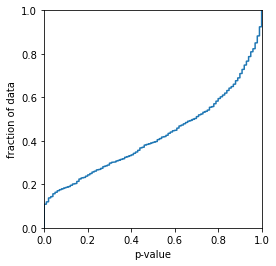

  0%|                                                                              | 1/1000 [00:44<12:22:53, 44.62s/it]

P-value: 0.84
Test stat: 0.137068020094801
Null dist: [0.13701265457442824, 0.1449908829044011, 0.13740616088381707, 0.1396689569202355, 0.13827466498015473]


  0%|▏                                                                             | 2/1000 [01:28<12:18:04, 44.37s/it]

P-value: 0.0
Test stat: 0.15228624603038377
Null dist: [0.14772934922712433, 0.1451649116936674, 0.14095263819427983, 0.14603277200599984, 0.14506607465199728]


  0%|▏                                                                             | 3/1000 [02:12<12:15:40, 44.27s/it]

P-value: 0.12
Test stat: 0.14092883304335502
Null dist: [0.14196465374557043, 0.14391538357844502, 0.13714355118548005, 0.13532560211792066, 0.13766548987295568]


  0%|▎                                                                             | 4/1000 [02:56<12:15:14, 44.29s/it]

P-value: 0.93
Test stat: 0.13883329280662737
Null dist: [0.14850209232581169, 0.1387747441648728, 0.14178556636111106, 0.1408818329213377, 0.14328787000526044]


  0%|▍                                                                             | 5/1000 [03:40<12:12:46, 44.19s/it]

P-value: 0.93
Test stat: 0.1361398278116691
Null dist: [0.1440050900080052, 0.148437388702085, 0.1401983116699982, 0.13923707772486538, 0.1347145930857111]


  1%|▍                                                                             | 6/1000 [04:26<12:18:41, 44.59s/it]

P-value: 1.0
Test stat: 0.13403408941495798
Null dist: [0.13974739190954322, 0.1447231558524158, 0.13964066490027827, 0.14687879872114407, 0.13855531807256094]


  1%|▌                                                                             | 7/1000 [05:11<12:20:44, 44.76s/it]

P-value: 0.26
Test stat: 0.14109025554272625
Null dist: [0.13904134218412667, 0.13668853536448622, 0.13857380384560547, 0.1391716720648033, 0.13699021554428137]


  1%|▌                                                                             | 8/1000 [05:54<12:12:51, 44.33s/it]

P-value: 0.0
Test stat: 0.14915865059546407
Null dist: [0.1444270240182105, 0.1407400167709456, 0.14304927375934195, 0.13778091438872198, 0.14193403806926763]


  1%|▋                                                                             | 9/1000 [06:38<12:08:09, 44.09s/it]

P-value: 0.01
Test stat: 0.14491632652247388
Null dist: [0.13601067469409844, 0.1448806752516828, 0.1363677967595559, 0.13797806946378344, 0.14252740701519084]


  1%|▊                                                                            | 10/1000 [07:24<12:16:47, 44.65s/it]

P-value: 0.0
Test stat: 0.16455670348021323
Null dist: [0.13955741790338871, 0.13391519270324148, 0.1390664145145668, 0.14091313559160212, 0.14343154179781836]


  1%|▊                                                                            | 11/1000 [08:08<12:12:49, 44.46s/it]

P-value: 0.02
Test stat: 0.14791756649077747
Null dist: [0.1412638853719198, 0.14295273947353948, 0.14118808668691052, 0.1417431195285599, 0.14242539515310848]


  1%|▉                                                                            | 12/1000 [09:00<12:52:52, 46.94s/it]

P-value: 0.68
Test stat: 0.13887501095037214
Null dist: [0.1502814989434177, 0.1391341918750606, 0.13758602467399084, 0.13649533735957087, 0.1456767180505517]


  1%|█                                                                            | 13/1000 [09:45<12:39:39, 46.18s/it]

P-value: 1.0
Test stat: 0.13347325417016975
Null dist: [0.13879613764535692, 0.14038005149033517, 0.14273529921904105, 0.1404300608079082, 0.14463985421201164]


  1%|█                                                                            | 14/1000 [10:29<12:27:48, 45.51s/it]

P-value: 0.94
Test stat: 0.13609430743304263
Null dist: [0.14372775603255628, 0.14435917087633543, 0.1429267607452429, 0.1418135953497205, 0.13576523647667438]


  2%|█▏                                                                           | 15/1000 [11:15<12:29:59, 45.68s/it]

P-value: 0.75
Test stat: 0.1397209935807211
Null dist: [0.13966974160049095, 0.1383907280112605, 0.13730350590613927, 0.14632894985731282, 0.14778081929378994]


  2%|█▏                                                                           | 16/1000 [11:59<12:21:39, 45.22s/it]

P-value: 0.0
Test stat: 0.15958037204718323
Null dist: [0.14094303487816984, 0.14224346080658978, 0.13633419267956304, 0.14182950820051643, 0.13167936705918237]


  2%|█▎                                                                           | 17/1000 [12:44<12:17:15, 45.00s/it]

P-value: 0.35
Test stat: 0.14209846887727395
Null dist: [0.1398997975977293, 0.14446985596940443, 0.14412796503924197, 0.14143205730203456, 0.13500753309238844]


  2%|█▍                                                                           | 18/1000 [13:27<12:10:09, 44.61s/it]

P-value: 0.0
Test stat: 0.15196253648494917
Null dist: [0.1488111408632905, 0.14337328001770833, 0.1405132196667781, 0.14498007199185825, 0.14617255715631927]


  2%|█▍                                                                           | 19/1000 [14:11<12:06:10, 44.41s/it]

P-value: 0.03
Test stat: 0.14560923448931717
Null dist: [0.13744217309602658, 0.1381183513157871, 0.13877609862367934, 0.14287020492391456, 0.13865313329155549]


  2%|█▌                                                                           | 20/1000 [14:56<12:06:04, 44.45s/it]

P-value: 0.94
Test stat: 0.13418936612190902
Null dist: [0.14714042630490387, 0.1394922227969312, 0.13549206607318576, 0.1421175813869744, 0.13780126536399995]


  2%|█▌                                                                           | 21/1000 [15:40<12:03:57, 44.37s/it]

P-value: 0.98
Test stat: 0.13609527705837177
Null dist: [0.1450035690986058, 0.1454896893592187, 0.14820728055362553, 0.14318219986259506, 0.14236975520660844]


  2%|█▋                                                                           | 22/1000 [16:24<12:01:06, 44.24s/it]

P-value: 0.98
Test stat: 0.13518801771969702
Null dist: [0.14405621748575181, 0.14425873284181512, 0.1374483577253085, 0.14263784006935964, 0.14755415455253007]


  2%|█▊                                                                           | 23/1000 [17:10<12:11:08, 44.90s/it]

P-value: 0.14
Test stat: 0.14420468556216137
Null dist: [0.13684996964532825, 0.1427490885320697, 0.1376919928485576, 0.14552645995369684, 0.13422025377292068]


  2%|█▊                                                                           | 24/1000 [17:55<12:07:44, 44.74s/it]

P-value: 0.49
Test stat: 0.14008093164605817
Null dist: [0.14053738514973946, 0.13951552780518361, 0.14287683675216845, 0.13991252086437767, 0.14658497023478811]


  2%|█▉                                                                           | 25/1000 [18:42<12:21:40, 45.64s/it]

P-value: 1.0
Test stat: 0.12980366365788087
Null dist: [0.14176323573747107, 0.13553900783463613, 0.13885808013855483, 0.14795023811542352, 0.14246365253568227]


  3%|██                                                                           | 26/1000 [19:27<12:14:17, 45.23s/it]

P-value: 1.0
Test stat: 0.13157688598244344
Null dist: [0.13860787162199606, 0.1400644546246247, 0.1406113487361248, 0.13924301390391525, 0.14479977280328415]


  3%|██                                                                           | 27/1000 [20:11<12:09:38, 44.99s/it]

P-value: 0.0
Test stat: 0.1437289626539261
Null dist: [0.1369758808863637, 0.13425036364163878, 0.13654739144713102, 0.13366276494848273, 0.13768926032827167]


  3%|██▏                                                                          | 28/1000 [20:55<12:05:31, 44.78s/it]

P-value: 0.98
Test stat: 0.13396078267021305
Null dist: [0.14092923257856793, 0.1450100908089259, 0.14191882085894403, 0.14332823116914295, 0.13957351589139777]


  3%|██▏                                                                          | 29/1000 [21:39<11:59:44, 44.47s/it]

P-value: 0.62
Test stat: 0.14175262580431158
Null dist: [0.1378415314531014, 0.13547178430457396, 0.13985284461246394, 0.14173205964171232, 0.1448531236336108]


  3%|██▎                                                                          | 30/1000 [22:23<11:54:50, 44.22s/it]

P-value: 0.85
Test stat: 0.13754644019062157
Null dist: [0.13898605976751188, 0.13914796592893097, 0.14181963539279308, 0.135526681775598, 0.1432323906347246]


  3%|██▍                                                                          | 31/1000 [23:07<11:56:18, 44.35s/it]

P-value: 0.21
Test stat: 0.140427677657065
Null dist: [0.13996739934217184, 0.14154769073735662, 0.13664800020172874, 0.1398515499271359, 0.1435489260028895]


  3%|██▍                                                                          | 32/1000 [23:51<11:53:28, 44.22s/it]

P-value: 0.52
Test stat: 0.13858000155769745
Null dist: [0.144135329001975, 0.14022870286607525, 0.1371950169291497, 0.13701770327068175, 0.13776307525018527]


  3%|██▌                                                                          | 33/1000 [24:35<11:50:36, 44.09s/it]

P-value: 1.0
Test stat: 0.12920367121224363
Null dist: [0.14092149868696457, 0.1453479918512628, 0.14050239133821285, 0.13896385348777263, 0.13616044217492707]


  3%|██▌                                                                          | 34/1000 [25:20<11:54:01, 44.35s/it]

P-value: 0.82
Test stat: 0.13743108145338467
Null dist: [0.14360053860443367, 0.14215253837866593, 0.13601441932316372, 0.14038347084830394, 0.1414363340685263]


  4%|██▋                                                                          | 35/1000 [26:04<11:50:40, 44.19s/it]

P-value: 0.48
Test stat: 0.14125207993065492
Null dist: [0.14122378355042453, 0.14281306953634842, 0.1370857754628444, 0.13575369687871552, 0.13680854499217177]


  4%|██▊                                                                          | 36/1000 [26:48<11:49:36, 44.17s/it]

P-value: 0.0
Test stat: 0.15601966732074213
Null dist: [0.14268700642499732, 0.13132391155042678, 0.144797199412533, 0.14232859029000378, 0.14032687483742068]


  4%|██▊                                                                          | 37/1000 [27:32<11:50:02, 44.24s/it]

P-value: 0.97
Test stat: 0.13292644342902005
Null dist: [0.1401075452002446, 0.13470220178517456, 0.139436045663767, 0.13679965402421013, 0.14231773101798129]


  4%|██▉                                                                          | 38/1000 [28:16<11:46:50, 44.09s/it]

P-value: 0.17
Test stat: 0.1423142437863295
Null dist: [0.1385823262797925, 0.13557376112547848, 0.13856867933839134, 0.13585861383314357, 0.14207750374626127]


  4%|███                                                                          | 39/1000 [29:04<12:05:21, 45.29s/it]

P-value: 0.99
Test stat: 0.13575169957830935
Null dist: [0.146172083831709, 0.13875530373480405, 0.1428963213556006, 0.14280575247199467, 0.14206374127161725]


  4%|███                                                                          | 40/1000 [29:48<11:56:30, 44.78s/it]

P-value: 0.18
Test stat: 0.1422279164739655
Null dist: [0.14175951268367826, 0.13627405645708168, 0.14631776581139133, 0.136296502225267, 0.14003212850823843]


  4%|███▏                                                                         | 41/1000 [30:32<11:52:30, 44.58s/it]

P-value: 0.0
Test stat: 0.1481552108807076
Null dist: [0.1420186757655707, 0.12706194643489876, 0.1400080183968483, 0.13694941210463085, 0.13958507298715683]


  4%|███▏                                                                         | 42/1000 [31:16<11:51:23, 44.56s/it]

P-value: 1.0
Test stat: 0.13217530658326837
Null dist: [0.1383365790719805, 0.1418355628624025, 0.1374415110915146, 0.13627138443891174, 0.13702994509548527]


  4%|███▎                                                                         | 43/1000 [32:00<11:45:31, 44.23s/it]

P-value: 0.92
Test stat: 0.137171635489567
Null dist: [0.13796793853806666, 0.14247827105442568, 0.13975615758616167, 0.1347207680713639, 0.13838630886209136]


  4%|███▍                                                                         | 44/1000 [32:44<11:44:50, 44.24s/it]

P-value: 0.21
Test stat: 0.14299656021761964
Null dist: [0.13825365538452006, 0.14042818829844594, 0.1428595215723052, 0.14334321376125392, 0.13845405519399412]


  4%|███▍                                                                         | 45/1000 [33:29<11:45:58, 44.35s/it]

P-value: 0.12
Test stat: 0.14526140366146745
Null dist: [0.14466422499770415, 0.14296968676110056, 0.14503673475570977, 0.14292364958446802, 0.1366139342065077]


  5%|███▌                                                                         | 46/1000 [34:13<11:46:40, 44.45s/it]

P-value: 0.99
Test stat: 0.13468882029506324
Null dist: [0.14189997224607565, 0.14496526073386562, 0.14391863903179647, 0.14529726621642547, 0.14160908768681457]


  5%|███▌                                                                         | 47/1000 [34:58<11:46:50, 44.50s/it]

P-value: 1.0
Test stat: 0.13301678000612038
Null dist: [0.1336351736358118, 0.13361459613731197, 0.14572419787555724, 0.141383183965068, 0.13718010904981692]


  5%|███▋                                                                         | 48/1000 [35:42<11:44:34, 44.41s/it]

P-value: 0.96
Test stat: 0.13515090340897362
Null dist: [0.14239961241881816, 0.14021906241713944, 0.13735575680363243, 0.13816788691875004, 0.14266437400334042]


  5%|███▊                                                                         | 49/1000 [36:26<11:42:20, 44.31s/it]

P-value: 0.64
Test stat: 0.13691862784237063
Null dist: [0.13552319323347173, 0.13642782192886993, 0.13578888162289082, 0.13307481068799476, 0.13822417529843356]


  5%|███▊                                                                         | 50/1000 [37:11<11:44:02, 44.47s/it]

P-value: 1.0
Test stat: 0.13062988998698433
Null dist: [0.1417023975507622, 0.1469634880685381, 0.1433756746123256, 0.1412890111663868, 0.1392965580118486]


  5%|███▉                                                                         | 51/1000 [37:55<11:39:35, 44.23s/it]

P-value: 0.97
Test stat: 0.13177577418372588
Null dist: [0.1316458152812955, 0.13857791752652193, 0.14047675331834042, 0.14089120677219513, 0.1420299185712912]


  5%|████                                                                         | 52/1000 [38:48<12:21:44, 46.95s/it]

P-value: 0.0
Test stat: 0.14872565735632215
Null dist: [0.136952031757274, 0.1462371522959417, 0.14474402318345958, 0.1370617781030995, 0.1441487551406868]


  5%|████                                                                         | 53/1000 [39:33<12:08:38, 46.16s/it]

P-value: 0.61
Test stat: 0.13675671078514706
Null dist: [0.13642582676978388, 0.14086911825048498, 0.13261047619199096, 0.1425996715938942, 0.13515949228010904]


  5%|████▏                                                                        | 54/1000 [40:16<11:57:29, 45.51s/it]

P-value: 0.0
Test stat: 0.14846874923562292
Null dist: [0.1405854267005998, 0.13908127966913109, 0.1411151473282456, 0.13968890718212812, 0.14636143081282416]


  6%|████▏                                                                        | 55/1000 [41:02<11:56:27, 45.49s/it]

P-value: 1.0
Test stat: 0.12946276801604029
Null dist: [0.1413886199517841, 0.13983681784330448, 0.1404788800134833, 0.1329696053571191, 0.13638678903514023]


  6%|████▎                                                                        | 56/1000 [41:45<11:46:30, 44.91s/it]

P-value: 0.0
Test stat: 0.15461914801017673
Null dist: [0.1451900978813664, 0.1459810037927063, 0.14455931266817246, 0.14177440445408063, 0.13514830987516124]


  6%|████▍                                                                        | 57/1000 [42:30<11:42:18, 44.69s/it]

P-value: 1.0
Test stat: 0.13073884443800066
Null dist: [0.1411407968777314, 0.140175182836782, 0.14021673044145133, 0.13857475699065414, 0.13818989086955114]


  6%|████▍                                                                        | 58/1000 [43:14<11:41:48, 44.70s/it]

P-value: 0.73
Test stat: 0.13898029849386162
Null dist: [0.13727661684740267, 0.13747364459078937, 0.13609180936723664, 0.1436573934811266, 0.14222191085118685]


  6%|████▌                                                                        | 59/1000 [43:58<11:35:59, 44.38s/it]

P-value: 0.12
Test stat: 0.14775749277428185
Null dist: [0.14415148513328935, 0.1411405546365252, 0.1449054507262666, 0.13878418535716175, 0.1389226416721948]


  6%|████▌                                                                        | 60/1000 [44:42<11:35:06, 44.37s/it]

P-value: 0.02
Test stat: 0.14760473651481754
Null dist: [0.13939753978560698, 0.1384604295251044, 0.1409124442582146, 0.14031765230136706, 0.14349583065538218]


  6%|████▋                                                                        | 61/1000 [45:27<11:34:22, 44.37s/it]

P-value: 0.99
Test stat: 0.132413400275327
Null dist: [0.13497852721934034, 0.1356319615084366, 0.13736298593683138, 0.14419765595983258, 0.13784914503878076]


  6%|████▊                                                                        | 62/1000 [46:11<11:32:28, 44.30s/it]

P-value: 0.83
Test stat: 0.13839116506879523
Null dist: [0.14504549149937573, 0.14403876774889302, 0.13855911919491437, 0.13989814364221043, 0.13941015618037622]


  6%|████▊                                                                        | 63/1000 [46:55<11:31:30, 44.28s/it]

P-value: 0.0
Test stat: 0.15149713566287182
Null dist: [0.14123703033212465, 0.1392605224380441, 0.13922310266325233, 0.14915916487600556, 0.1412177369025136]


  6%|████▉                                                                        | 64/1000 [47:39<11:27:26, 44.07s/it]

P-value: 1.0
Test stat: 0.13420093019461432
Null dist: [0.1408380728078007, 0.1369506626947733, 0.14482181534422234, 0.14519205904778876, 0.14019500305527766]


  6%|█████                                                                        | 65/1000 [48:23<11:26:41, 44.07s/it]

P-value: 0.2
Test stat: 0.14365943090898303
Null dist: [0.1373952605187062, 0.14256880220412005, 0.1435545823577049, 0.13939504010586368, 0.139077158198736]


  7%|█████                                                                        | 66/1000 [49:10<11:40:19, 44.99s/it]

P-value: 0.99
Test stat: 0.13357845297212123
Null dist: [0.14147594681226416, 0.14741947262730593, 0.1443440807340729, 0.14133500246780695, 0.14313463765525358]


  7%|█████▏                                                                       | 67/1000 [49:53<11:32:52, 44.56s/it]

P-value: 0.22
Test stat: 0.14751621745276133
Null dist: [0.15055920731210348, 0.1406355638900586, 0.14209092339411877, 0.14348437695238037, 0.14480830483804485]


  7%|█████▏                                                                       | 68/1000 [50:38<11:32:57, 44.61s/it]

P-value: 0.56
Test stat: 0.14282246564894419
Null dist: [0.14454598196437074, 0.14187494925547317, 0.1412358672164027, 0.14653876136991262, 0.1478357798217873]


  7%|█████▎                                                                       | 69/1000 [51:23<11:31:22, 44.56s/it]

P-value: 0.71
Test stat: 0.1386772641922509
Null dist: [0.14114799580945314, 0.13992400080862943, 0.13907773576290117, 0.13073280559300182, 0.1385674407258165]


  7%|█████▍                                                                       | 70/1000 [52:06<11:26:11, 44.27s/it]

P-value: 0.0
Test stat: 0.1577554862544578
Null dist: [0.14117261306597606, 0.1434006914253122, 0.1467695282848207, 0.14379181783228334, 0.14354766349799963]


  7%|█████▍                                                                       | 71/1000 [52:51<11:29:14, 44.51s/it]

P-value: 0.99
Test stat: 0.13574267678181473
Null dist: [0.14368230172133967, 0.13943369050958498, 0.1452888965917909, 0.14784838645236142, 0.1411156779152971]


  7%|█████▌                                                                       | 72/1000 [53:36<11:27:40, 44.46s/it]

P-value: 0.92
Test stat: 0.13866523608633063
Null dist: [0.14069294092014883, 0.14152868060925283, 0.14624856205131953, 0.15128701074772544, 0.1406836107059415]


  7%|█████▌                                                                       | 73/1000 [54:20<11:24:13, 44.29s/it]

P-value: 0.81
Test stat: 0.1414127478723628
Null dist: [0.14324416013256946, 0.15019794583340818, 0.14763058312196797, 0.14376717200587563, 0.14381695150987606]


  7%|█████▋                                                                       | 74/1000 [55:04<11:23:58, 44.32s/it]

P-value: 0.83
Test stat: 0.13871394940485293
Null dist: [0.14313896399969372, 0.1419681237772511, 0.14683874994092394, 0.14298578201369938, 0.1394708141540265]


  8%|█████▊                                                                       | 75/1000 [55:48<11:21:48, 44.23s/it]

P-value: 0.95
Test stat: 0.13964761048635765
Null dist: [0.14947383651692048, 0.14644060033244521, 0.14519939934539516, 0.1426085055779296, 0.1411703337164878]


  8%|█████▊                                                                       | 76/1000 [56:32<11:19:46, 44.14s/it]

P-value: 0.94
Test stat: 0.13605343055646135
Null dist: [0.13219489165640597, 0.14816382103424564, 0.14187919446692665, 0.13735425882000996, 0.14235456549730519]


  8%|█████▉                                                                       | 77/1000 [57:17<11:21:24, 44.30s/it]

P-value: 0.09
Test stat: 0.14266235477120948
Null dist: [0.13216145164151327, 0.14535770687979688, 0.13150855491976854, 0.1389434827623779, 0.14035724716531828]


  8%|██████                                                                       | 78/1000 [58:00<11:18:41, 44.17s/it]

P-value: 0.96
Test stat: 0.13498535304824066
Null dist: [0.140681734051622, 0.14226753247360702, 0.1341024070401966, 0.14095642932193242, 0.1423070021745214]


  8%|██████                                                                       | 79/1000 [58:48<11:32:39, 45.12s/it]

P-value: 0.77
Test stat: 0.13745385524602982
Null dist: [0.14079474158434213, 0.1423679913072512, 0.14217148038203808, 0.135079078486801, 0.1384933485146801]


  8%|██████                                                                     | 80/1000 [1:00:01<13:43:27, 53.70s/it]

P-value: 0.83
Test stat: 0.13617162701933794
Null dist: [0.14439532138776034, 0.14137083513101967, 0.13878927211517467, 0.1377520811856351, 0.14494861908094114]


  8%|██████                                                                     | 81/1000 [1:01:04<14:22:33, 56.31s/it]

P-value: 0.75
Test stat: 0.14144060522310875
Null dist: [0.14267495968210886, 0.1464413962536596, 0.14485449117277782, 0.1443716663417861, 0.13973485045058476]


  8%|██████▏                                                                    | 82/1000 [1:02:27<16:22:36, 64.22s/it]

P-value: 0.99
Test stat: 0.1320824508184184
Null dist: [0.1424854412671791, 0.14411496595951212, 0.14226479391714875, 0.14289271956818184, 0.13701959366103322]


  8%|██████▏                                                                    | 83/1000 [1:03:33<16:33:41, 65.02s/it]

P-value: 0.02
Test stat: 0.1470872053904111
Null dist: [0.1284819707678796, 0.13569154421651508, 0.13625422382791474, 0.15162362091053594, 0.138177209604332]


  8%|██████▎                                                                    | 84/1000 [1:04:26<15:34:30, 61.21s/it]

P-value: 1.0
Test stat: 0.13284885981640548
Null dist: [0.1457789250226864, 0.14183135530128577, 0.1392660075436718, 0.14418553318633054, 0.13809415827512128]


  8%|██████▍                                                                    | 85/1000 [1:05:18<14:53:14, 58.57s/it]

P-value: 0.0
Test stat: 0.15431386171586492
Null dist: [0.14361074968548204, 0.13866966135718806, 0.14117699190553712, 0.1414343015719739, 0.1402862097082861]


  9%|██████▍                                                                    | 86/1000 [1:06:08<14:11:46, 55.92s/it]

P-value: 0.55
Test stat: 0.14062585474795108
Null dist: [0.13911847438122782, 0.14656864834994132, 0.1426703318317093, 0.1431409445248587, 0.14841653862650728]


  9%|██████▌                                                                    | 87/1000 [1:07:01<13:59:15, 55.15s/it]

P-value: 0.91
Test stat: 0.1376593538192945
Null dist: [0.14250843920230483, 0.1420834549397233, 0.1419517974413318, 0.14789482691831435, 0.14099698496024604]


  9%|██████▌                                                                    | 88/1000 [1:07:48<13:21:27, 52.73s/it]

P-value: 0.0
Test stat: 0.17717541464316877
Null dist: [0.1395625920452055, 0.13737917449141335, 0.1384881875182581, 0.13709701897004412, 0.1379719817175976]


  9%|██████▋                                                                    | 89/1000 [1:08:41<13:19:01, 52.63s/it]

P-value: 0.5
Test stat: 0.14107676973737138
Null dist: [0.1456321437672955, 0.13977479671533355, 0.1376530493102951, 0.13805820649724543, 0.14317017976996282]


  9%|██████▊                                                                    | 90/1000 [1:09:29<12:57:55, 51.29s/it]

P-value: 0.64
Test stat: 0.14027607836096778
Null dist: [0.14143576524597956, 0.147829898898861, 0.14008934990105393, 0.1426124015495156, 0.1411630825092548]


  9%|██████▊                                                                    | 91/1000 [1:10:16<12:35:54, 49.90s/it]

P-value: 0.34
Test stat: 0.14219555037528742
Null dist: [0.13616369400406803, 0.13801730789872801, 0.14629358352306454, 0.14065996981598228, 0.14090268125928374]


  9%|██████▉                                                                    | 92/1000 [1:11:22<13:48:15, 54.73s/it]

P-value: 0.89
Test stat: 0.13652082103385677
Null dist: [0.13917828156858847, 0.14252901863525758, 0.1418923800989076, 0.13800785586242847, 0.14009982061134585]


  9%|██████▉                                                                    | 93/1000 [1:12:44<15:52:24, 63.00s/it]

P-value: 0.2
Test stat: 0.14535342344407598
Null dist: [0.13929555348840894, 0.14269037588420042, 0.13774611328365138, 0.1500448228980289, 0.1387048473667668]


  9%|███████                                                                    | 94/1000 [1:13:36<15:03:47, 59.85s/it]

P-value: 0.97
Test stat: 0.13446745548473205
Null dist: [0.1407850031643748, 0.14074307132856723, 0.14277400071078183, 0.1430925082375203, 0.13886593788864443]


 10%|███████▏                                                                   | 95/1000 [1:14:45<15:42:59, 62.52s/it]

P-value: 0.99
Test stat: 0.13191288736544204
Null dist: [0.1498120338329978, 0.13740376872326787, 0.13905013510250896, 0.1409632574102958, 0.1404139941331397]


 10%|███████▏                                                                   | 96/1000 [1:15:44<15:26:27, 61.49s/it]

P-value: 0.45
Test stat: 0.14237452082606594
Null dist: [0.1428621841403649, 0.14201828247477255, 0.14182066538955762, 0.14648384924310698, 0.14587083705097803]


 10%|███████▎                                                                   | 97/1000 [1:16:43<15:11:52, 60.59s/it]

P-value: 0.36
Test stat: 0.14488638943542131
Null dist: [0.14178255507057358, 0.14317205186781712, 0.14412086281684022, 0.13795750700406306, 0.14565843369238618]


 10%|███████▎                                                                   | 98/1000 [1:17:35<14:35:51, 58.26s/it]

P-value: 0.52
Test stat: 0.1408718560027037
Null dist: [0.1394877087694294, 0.1412715872217014, 0.1428636073128392, 0.1422834950268992, 0.14105384058427506]


 10%|███████▍                                                                   | 99/1000 [1:18:23<13:48:02, 55.14s/it]

P-value: 0.01
Test stat: 0.14648014916126495
Null dist: [0.13549025278174287, 0.14002467836761678, 0.13403676207458637, 0.1395665891982545, 0.13693086725339731]


 10%|███████▍                                                                  | 100/1000 [1:19:21<13:59:06, 55.94s/it]

P-value: 0.71
Test stat: 0.13699770839880743
Null dist: [0.13993217250018708, 0.1359141380826986, 0.1424638036061704, 0.14041369247692614, 0.14469958793699522]


 10%|███████▍                                                                  | 101/1000 [1:20:14<13:45:58, 55.13s/it]

P-value: 0.93
Test stat: 0.1323428839382198
Null dist: [0.13566200992163657, 0.13745969951166837, 0.13943723232136396, 0.13553197610479195, 0.13528688261863164]


 10%|███████▌                                                                  | 102/1000 [1:21:12<13:57:40, 55.97s/it]

P-value: 0.0
Test stat: 0.1481086499147628
Null dist: [0.143188933727875, 0.14230728440503448, 0.13345459367689505, 0.13873856387794947, 0.13595128000552048]


 10%|███████▌                                                                  | 103/1000 [1:22:10<14:05:28, 56.55s/it]

P-value: 0.0
Test stat: 0.15380967132697554
Null dist: [0.14289661564151745, 0.14147888297590572, 0.14116464229915893, 0.13793423796153315, 0.14054044634818674]


 10%|███████▋                                                                  | 104/1000 [1:23:02<13:45:14, 55.26s/it]

P-value: 0.68
Test stat: 0.13957659903031527
Null dist: [0.1432830912121471, 0.14449670196269682, 0.13995627353991913, 0.1426736684396983, 0.1427094609601378]


 10%|███████▊                                                                  | 105/1000 [1:23:51<13:15:43, 53.34s/it]

P-value: 1.0
Test stat: 0.133630870320269
Null dist: [0.14264002681324806, 0.13875845527224917, 0.14508263290678525, 0.13860207664187818, 0.1422435432599063]


 11%|███████▊                                                                  | 106/1000 [1:24:41<12:58:00, 52.22s/it]

P-value: 0.11
Test stat: 0.14590205169463166
Null dist: [0.1415194668226405, 0.1451192672399244, 0.14474017457243993, 0.14501050301098417, 0.1452098003940102]


 11%|███████▉                                                                  | 107/1000 [1:25:35<13:03:39, 52.65s/it]

P-value: 0.93
Test stat: 0.13579163714754183
Null dist: [0.14127670765568234, 0.14266076531155059, 0.14132051074946161, 0.1445002049869203, 0.1425959321254241]


 11%|███████▉                                                                  | 108/1000 [1:26:30<13:16:06, 53.55s/it]

P-value: 0.04
Test stat: 0.14952033949424348
Null dist: [0.14013617815607304, 0.14161462618001164, 0.14469959770903662, 0.1396590007193974, 0.13900096517203642]


 11%|████████                                                                  | 109/1000 [1:27:26<13:23:24, 54.10s/it]

P-value: 0.48
Test stat: 0.13786437455941247
Null dist: [0.14068600131793274, 0.1373366680108743, 0.13896596089783053, 0.13828173556042545, 0.13717367620126997]


 11%|████████▏                                                                 | 110/1000 [1:28:13<12:53:30, 52.15s/it]

P-value: 0.18
Test stat: 0.14605310876982291
Null dist: [0.14681666986443243, 0.13674699765373832, 0.14451707841345107, 0.14084422352874093, 0.13998544934807722]


 11%|████████▏                                                                 | 111/1000 [1:29:07<12:58:36, 52.55s/it]

P-value: 0.84
Test stat: 0.14243549869295125
Null dist: [0.14832726046370326, 0.14178625410737844, 0.1465835330626315, 0.14589404160061104, 0.14309145246572408]


 11%|████████▎                                                                 | 112/1000 [1:30:03<13:14:50, 53.71s/it]

P-value: 0.66
Test stat: 0.144458208441413
Null dist: [0.14828625918849303, 0.15186372350048294, 0.14874674807468846, 0.137851194444518, 0.15004845985028958]


 11%|████████▎                                                                 | 113/1000 [1:30:59<13:22:19, 54.27s/it]

P-value: 0.58
Test stat: 0.14086597128476874
Null dist: [0.14060192799456672, 0.14790198798662246, 0.1413062793710289, 0.1300042668316833, 0.1385075957721459]


 11%|████████▍                                                                 | 114/1000 [1:31:45<12:47:33, 51.98s/it]

P-value: 0.07
Test stat: 0.14728239145630484
Null dist: [0.14392055143922033, 0.1418868041222422, 0.14152353183514055, 0.14191549531802428, 0.13819544646905868]


 12%|████████▌                                                                 | 115/1000 [1:32:32<12:22:06, 50.31s/it]

P-value: 0.0
Test stat: 0.15787868362806323
Null dist: [0.1399779848168945, 0.14203442630232566, 0.14177228462313562, 0.1428763661589888, 0.1373626043447007]


 12%|████████▌                                                                 | 116/1000 [1:33:19<12:06:19, 49.30s/it]

P-value: 0.88
Test stat: 0.132943904932197
Null dist: [0.1321259892596749, 0.13898775452762002, 0.13196832970747796, 0.1381291848891958, 0.13040202956905733]


 12%|████████▋                                                                 | 117/1000 [1:34:04<11:49:16, 48.20s/it]

P-value: 0.27
Test stat: 0.14174614038130906
Null dist: [0.1381144675272391, 0.13786847552749526, 0.13974903815191986, 0.1457476649425653, 0.14447185520650163]


 12%|████████▋                                                                 | 118/1000 [1:34:50<11:39:28, 47.58s/it]

P-value: 0.81
Test stat: 0.13420058505646937
Null dist: [0.14023840627070705, 0.13990962574466326, 0.13857993512190525, 0.14397276274851345, 0.14070413753472844]


 12%|████████▊                                                                 | 119/1000 [1:35:36<11:30:58, 47.06s/it]

P-value: 0.95
Test stat: 0.13397793701394112
Null dist: [0.14152674200263415, 0.14350097568778208, 0.1398285578549402, 0.1355523347786044, 0.13959008996660127]


 12%|████████▉                                                                 | 120/1000 [1:36:24<11:30:56, 47.11s/it]

P-value: 0.0
Test stat: 0.1547744906466697
Null dist: [0.1443078363756477, 0.14905261949205617, 0.1428597364801324, 0.13798673618645485, 0.1511455953599633]


 12%|████████▉                                                                 | 121/1000 [1:37:11<11:29:54, 47.09s/it]

P-value: 0.85
Test stat: 0.13903241599566796
Null dist: [0.14321063746043228, 0.14167863079394527, 0.13789396673747523, 0.14199118008647515, 0.14643598901485266]


 12%|█████████                                                                 | 122/1000 [1:37:56<11:22:48, 46.66s/it]

P-value: 1.0
Test stat: 0.13548315370553954
Null dist: [0.1400704534466608, 0.1395965363600501, 0.14341527259286502, 0.1468094506217097, 0.13570281307645848]


 12%|█████████                                                                 | 123/1000 [1:38:51<11:58:17, 49.14s/it]

P-value: 0.99
Test stat: 0.1335286211056369
Null dist: [0.1440644856378579, 0.14143251074132557, 0.1412481226483281, 0.13734944225985957, 0.14104827499754113]


 12%|█████████▏                                                                | 124/1000 [1:39:36<11:39:36, 47.92s/it]

P-value: 0.71
Test stat: 0.14014100900982573
Null dist: [0.14445151042118898, 0.13871493871042184, 0.14150288904581276, 0.14669788065675105, 0.14170658860364105]


 12%|█████████▎                                                                | 125/1000 [1:40:24<11:37:52, 47.85s/it]

P-value: 0.99
Test stat: 0.13764862988176252
Null dist: [0.14978157360419708, 0.14542108615703186, 0.14693381390297688, 0.14955672214465954, 0.14523862953146383]


 13%|█████████▎                                                                | 126/1000 [1:41:12<11:37:12, 47.86s/it]

P-value: 0.18
Test stat: 0.14554023482914658
Null dist: [0.14024326567828405, 0.14159806383093743, 0.13965260546153602, 0.14072682286509686, 0.13840149009151104]


 13%|█████████▍                                                                | 127/1000 [1:41:58<11:29:29, 47.39s/it]

P-value: 0.38
Test stat: 0.14379493093967388
Null dist: [0.1396643943203909, 0.14186518311804797, 0.14576019627594294, 0.14448636567686857, 0.13465380184016107]


 13%|█████████▍                                                                | 128/1000 [1:42:44<11:22:11, 46.94s/it]

P-value: 0.95
Test stat: 0.1345693518605392
Null dist: [0.14434652615058097, 0.1406985237030267, 0.137446190781626, 0.1418603580003851, 0.1378008713032275]


 13%|█████████▌                                                                | 129/1000 [1:43:30<11:17:06, 46.64s/it]

P-value: 0.07
Test stat: 0.1441555596665639
Null dist: [0.14309622957835166, 0.1381061932703619, 0.1387503693380846, 0.13590313551841182, 0.14169697294569294]


 13%|█████████▌                                                                | 130/1000 [1:44:16<11:12:35, 46.39s/it]

P-value: 0.01
Test stat: 0.1490960341223334
Null dist: [0.14278749783360245, 0.14146061506433127, 0.1442660318613067, 0.14103478072572195, 0.1440985857195788]


 13%|█████████▋                                                                | 131/1000 [1:45:03<11:14:38, 46.58s/it]

P-value: 0.0
Test stat: 0.15213961028784795
Null dist: [0.13432609392155825, 0.1366782762343267, 0.13216836099769613, 0.1361926389932313, 0.14428675540434577]


 13%|█████████▊                                                                | 132/1000 [1:45:50<11:15:33, 46.70s/it]

P-value: 0.45
Test stat: 0.14014481535764411
Null dist: [0.13961371715558601, 0.1419916900567133, 0.13977251467149854, 0.1398814557344411, 0.14054744712940304]


 13%|█████████▊                                                                | 133/1000 [1:46:36<11:11:54, 46.50s/it]

P-value: 0.9
Test stat: 0.13679728205159825
Null dist: [0.14209064771533297, 0.14043385357420823, 0.1445841387526544, 0.1437451985465107, 0.13668148253618895]


 13%|█████████▉                                                                | 134/1000 [1:47:23<11:13:25, 46.66s/it]

P-value: 0.0
Test stat: 0.15209319560527457
Null dist: [0.13842170780349683, 0.14141934210856955, 0.14106831395842434, 0.14507646468126, 0.14270533459925405]


 14%|█████████▉                                                                | 135/1000 [1:48:09<11:10:48, 46.53s/it]

P-value: 0.83
Test stat: 0.13415070459807
Null dist: [0.14287961413239125, 0.13995687429554438, 0.14174538695043448, 0.12931932344532338, 0.13716984272758515]


 14%|██████████                                                                | 136/1000 [1:48:57<11:17:09, 47.03s/it]

P-value: 0.02
Test stat: 0.14631845352607498
Null dist: [0.1401965776482622, 0.14118241775754525, 0.14016533607200166, 0.13964840134162992, 0.137926398105379]


 14%|██████████▏                                                               | 137/1000 [1:49:44<11:13:40, 46.84s/it]

P-value: 0.92
Test stat: 0.13756385721558972
Null dist: [0.14674358143838528, 0.14223797814647132, 0.14468525903205343, 0.14908768292225538, 0.14274795507024596]


 14%|██████████▏                                                               | 138/1000 [1:50:31<11:14:06, 46.92s/it]

P-value: 0.96
Test stat: 0.13612882946172666
Null dist: [0.13993938919886684, 0.14619675811553212, 0.1458682533130451, 0.14439919732677686, 0.1442488588497539]


 14%|██████████▎                                                               | 139/1000 [1:51:18<11:14:13, 46.98s/it]

P-value: 0.5
Test stat: 0.14133534981396412
Null dist: [0.13943990333352663, 0.1353848435318118, 0.1416372370139044, 0.1383026265974846, 0.1365617168010942]


 14%|██████████▎                                                               | 140/1000 [1:52:17<12:04:56, 50.58s/it]

P-value: 0.99
Test stat: 0.1350621266369344
Null dist: [0.13903889652629065, 0.142421172746794, 0.14152700692477693, 0.14061783670239913, 0.1445755362705745]


 14%|██████████▍                                                               | 141/1000 [1:53:04<11:50:12, 49.61s/it]

P-value: 0.95
Test stat: 0.1370813169663304
Null dist: [0.1370124189791233, 0.14296266430945803, 0.14267214631478875, 0.1376712541485352, 0.13810865255945715]


 14%|██████████▌                                                               | 142/1000 [1:53:50<11:31:42, 48.37s/it]

P-value: 0.01
Test stat: 0.1501033090648246
Null dist: [0.1448521565058989, 0.14444143738888326, 0.14202700049590378, 0.1430396583044493, 0.1405300158643873]


 14%|██████████▌                                                               | 143/1000 [1:54:36<11:20:19, 47.63s/it]

P-value: 0.53
Test stat: 0.1402388186391118
Null dist: [0.14225899941698017, 0.1448853148262801, 0.13804494263839118, 0.13429636221994146, 0.143764668669483]


 14%|██████████▋                                                               | 144/1000 [1:55:23<11:19:45, 47.65s/it]

P-value: 0.99
Test stat: 0.1277466861372928
Null dist: [0.13936528887212607, 0.14357468286099273, 0.1392946453518924, 0.1383886854817291, 0.14249227827082644]


 14%|██████████▋                                                               | 145/1000 [1:56:14<11:33:08, 48.64s/it]

P-value: 0.93
Test stat: 0.13877849196784875
Null dist: [0.1441776836066867, 0.13902934025732383, 0.14307236558690062, 0.1371786666903535, 0.13750486676651785]


 15%|██████████▊                                                               | 146/1000 [1:57:01<11:24:48, 48.11s/it]

P-value: 0.94
Test stat: 0.1378792534191714
Null dist: [0.14316867624360463, 0.14370667769568357, 0.1409282872013523, 0.13958253026178735, 0.14245017094876722]


 15%|██████████▉                                                               | 147/1000 [1:57:58<12:01:14, 50.73s/it]

P-value: 0.69
Test stat: 0.1391482671278449
Null dist: [0.13784611260181823, 0.13997043823356115, 0.1393137296214203, 0.1481786380771618, 0.14211420402187025]


 15%|██████████▉                                                               | 148/1000 [1:58:47<11:53:21, 50.24s/it]

P-value: 0.01
Test stat: 0.14633431386861329
Null dist: [0.13403342612070523, 0.13434661474388865, 0.13340240482870025, 0.13606988380829232, 0.13667036775730323]


 15%|███████████                                                               | 149/1000 [1:59:33<11:35:05, 49.01s/it]

P-value: 0.29
Test stat: 0.1414553351221428
Null dist: [0.1399190118858633, 0.13762308384623867, 0.13926401847730818, 0.14090135376156754, 0.13437301202105878]


 15%|███████████                                                               | 150/1000 [2:00:20<11:23:34, 48.25s/it]

P-value: 0.2
Test stat: 0.14404390130481737
Null dist: [0.14400223217760943, 0.1431181135728874, 0.13916102432736033, 0.13468694082355814, 0.135362823014746]


 15%|███████████▏                                                              | 151/1000 [2:01:06<11:15:23, 47.73s/it]

P-value: 0.21
Test stat: 0.14235225746763003
Null dist: [0.14479859523673255, 0.14322239611036347, 0.14627731911953545, 0.13972046251756465, 0.1423852092848854]


 15%|███████████▏                                                              | 152/1000 [2:01:53<11:10:23, 47.43s/it]

P-value: 0.99
Test stat: 0.1341721003767007
Null dist: [0.1429611649280378, 0.137655032379829, 0.14535490910735804, 0.1335352738960578, 0.14275650752922997]


 15%|███████████▎                                                              | 153/1000 [2:02:39<11:04:32, 47.07s/it]

P-value: 0.97
Test stat: 0.13416227459546648
Null dist: [0.1385721462244559, 0.13898747550525226, 0.13811979004884256, 0.13859119519442953, 0.13878323686693195]


 15%|███████████▍                                                              | 154/1000 [2:03:26<11:02:45, 47.00s/it]

P-value: 0.01
Test stat: 0.15024601325337472
Null dist: [0.14412615635194959, 0.14260593523625076, 0.1397658934979037, 0.1366111806330491, 0.13943228100247573]


 16%|███████████▍                                                              | 155/1000 [2:04:12<10:58:43, 46.77s/it]

P-value: 0.42
Test stat: 0.1416877371707903
Null dist: [0.14293496172455, 0.14208066462173063, 0.1400140709063078, 0.14094227873612608, 0.14279232224052973]


 16%|███████████▌                                                              | 156/1000 [2:05:00<11:00:10, 46.93s/it]

P-value: 0.61
Test stat: 0.13922876315516064
Null dist: [0.14480486941679682, 0.13369640010739625, 0.14167742655083182, 0.13700602742427637, 0.14248685724292576]


 16%|███████████▌                                                              | 157/1000 [2:05:46<10:56:47, 46.75s/it]

P-value: 0.98
Test stat: 0.135355647306047
Null dist: [0.13941772604635716, 0.13779218918288483, 0.14453839029583193, 0.13700792081800617, 0.14272348558272507]


 16%|███████████▋                                                              | 158/1000 [2:06:32<10:52:49, 46.52s/it]

P-value: 0.0
Test stat: 0.15741732095319438
Null dist: [0.13793929454785636, 0.13746925714811786, 0.1361384058359446, 0.14067008526191083, 0.142432584825663]


 16%|███████████▊                                                              | 159/1000 [2:07:19<10:53:51, 46.65s/it]

P-value: 0.0
Test stat: 0.1482714227523142
Null dist: [0.1337221691919399, 0.13361798825111137, 0.1351709925424298, 0.13532338217830808, 0.13282453545991924]


 16%|███████████▊                                                              | 160/1000 [2:08:04<10:49:05, 46.36s/it]

P-value: 0.08
Test stat: 0.1464284971013453
Null dist: [0.14216081830852123, 0.13849157548572844, 0.13765206875264846, 0.14314186358998693, 0.1400771737419484]


 16%|███████████▉                                                              | 161/1000 [2:09:05<11:46:07, 50.50s/it]

P-value: 0.95
Test stat: 0.134437154305038
Null dist: [0.139087491665709, 0.13404575896344684, 0.140031407424681, 0.1368504202662143, 0.13707659902548053]


 16%|███████████▉                                                              | 162/1000 [2:09:51<11:29:40, 49.38s/it]

P-value: 0.25
Test stat: 0.14092328016884248
Null dist: [0.14610341388159198, 0.1392373137448908, 0.1378448462064572, 0.1400076647424242, 0.13784326118875168]


 16%|████████████                                                              | 163/1000 [2:10:39<11:20:07, 48.75s/it]

P-value: 0.82
Test stat: 0.13479823016722303
Null dist: [0.1363311771119724, 0.13509021622808348, 0.13859192368794448, 0.13851317994305035, 0.1363967866036795]


 16%|████████████▏                                                             | 164/1000 [2:11:27<11:19:12, 48.75s/it]

P-value: 0.25
Test stat: 0.147896782393813
Null dist: [0.14068450571371027, 0.14967425731420325, 0.15072761390246536, 0.1390918727774293, 0.14581841658749872]


 16%|████████████▏                                                             | 165/1000 [2:12:13<11:07:03, 47.93s/it]

P-value: 0.74
Test stat: 0.13892321118398132
Null dist: [0.13869486604763948, 0.1429070298057843, 0.14343600544744695, 0.14012988137075577, 0.13971422816093104]


 17%|████████████▎                                                             | 166/1000 [2:13:00<10:59:23, 47.44s/it]

P-value: 0.0
Test stat: 0.15738191899894305
Null dist: [0.14077808497680466, 0.1357005398707709, 0.13095670167285223, 0.13728438521881592, 0.13656806606389427]


 17%|████████████▎                                                             | 167/1000 [2:13:46<10:53:06, 47.04s/it]

P-value: 0.99
Test stat: 0.1338926159835061
Null dist: [0.13936750787716368, 0.14133626642475217, 0.14026064697232077, 0.14644711833671897, 0.14498197844340455]


 17%|████████████▍                                                             | 168/1000 [2:14:32<10:48:22, 46.76s/it]

P-value: 1.0
Test stat: 0.1321987892979325
Null dist: [0.14539095993501183, 0.1446506671392045, 0.14691355334596556, 0.1472783463255818, 0.14356600534356256]


 17%|████████████▌                                                             | 169/1000 [2:15:19<10:47:43, 46.77s/it]

P-value: 0.15
Test stat: 0.14575165498122333
Null dist: [0.1407092032505367, 0.14455310753521988, 0.13907119170827442, 0.13872349667649153, 0.1390680840469728]


 17%|████████████▌                                                             | 170/1000 [2:16:06<10:48:46, 46.90s/it]

P-value: 0.98
Test stat: 0.1318052046992676
Null dist: [0.13646762039171256, 0.15157295705724583, 0.13486946004535338, 0.14194462526019513, 0.1382009009103804]


 17%|████████████▋                                                             | 171/1000 [2:16:56<11:02:07, 47.92s/it]

P-value: 0.33
Test stat: 0.14419094719958048
Null dist: [0.1464850446580872, 0.14650322111498326, 0.1371906765741554, 0.14140391465689905, 0.14673681328757537]


 17%|████████████▋                                                             | 172/1000 [2:17:42<10:53:00, 47.32s/it]

P-value: 0.64
Test stat: 0.1427949430353368
Null dist: [0.14039494071002712, 0.14736174117928902, 0.14870941687289563, 0.15019438954885278, 0.14380754990788303]


 17%|████████████▊                                                             | 173/1000 [2:18:29<10:48:41, 47.06s/it]

P-value: 0.0
Test stat: 0.14561395002812083
Null dist: [0.13519859799981415, 0.1399832723911968, 0.14118597088101603, 0.13562447561732782, 0.13361204592691844]


 17%|████████████▉                                                             | 174/1000 [2:19:20<11:05:16, 48.33s/it]

P-value: 0.03
Test stat: 0.1465518938499084
Null dist: [0.14059772067315346, 0.13907998735041627, 0.13583494096344884, 0.14341499877921882, 0.14914615735298808]


 18%|████████████▉                                                             | 175/1000 [2:20:06<10:53:50, 47.55s/it]

P-value: 0.58
Test stat: 0.1408505300421664
Null dist: [0.13849102054995344, 0.13747070637587755, 0.14296151173325422, 0.13657953816570678, 0.14207317223109084]


 18%|█████████████                                                             | 176/1000 [2:20:52<10:47:45, 47.17s/it]

P-value: 0.0
Test stat: 0.1524908572693019
Null dist: [0.14711846155727115, 0.1401735626575038, 0.1419760945133568, 0.14193705884065533, 0.13566330093747148]


 18%|█████████████                                                             | 177/1000 [2:21:38<10:42:05, 46.81s/it]

P-value: 0.01
Test stat: 0.1469747556322064
Null dist: [0.13700653682256192, 0.13904406662275204, 0.14120771218540484, 0.13830633583058272, 0.1415333071174969]


 18%|█████████████▏                                                            | 178/1000 [2:22:24<10:38:29, 46.61s/it]

P-value: 0.9
Test stat: 0.134985059436168
Null dist: [0.1362870140006811, 0.14062709920307992, 0.13660482608500146, 0.14490418514235703, 0.13592109188488888]


 18%|█████████████▏                                                            | 179/1000 [2:23:22<11:24:34, 50.03s/it]

P-value: 0.61
Test stat: 0.13877100983992396
Null dist: [0.13687164660222528, 0.13836301562955688, 0.1419241944480213, 0.13526782641133817, 0.13979578341500953]


 18%|█████████████▎                                                            | 180/1000 [2:24:24<12:12:14, 53.58s/it]

P-value: 0.99
Test stat: 0.13750457569988328
Null dist: [0.1456584745068229, 0.14148572889213407, 0.14252156586964193, 0.1462910972478314, 0.1367864218745376]


 18%|█████████████▍                                                            | 181/1000 [2:25:11<11:43:55, 51.57s/it]

P-value: 0.92
Test stat: 0.13273087692984686
Null dist: [0.14430463981832176, 0.1408389268205451, 0.1401474887143932, 0.14583617793728587, 0.1387886132752828]


 18%|█████████████▍                                                            | 182/1000 [2:26:06<11:56:31, 52.56s/it]

P-value: 0.02
Test stat: 0.14564910370597128
Null dist: [0.1465861200101689, 0.1403754446902864, 0.1400937653121055, 0.14016998391159363, 0.14145722315743858]


 18%|█████████████▌                                                            | 183/1000 [2:26:53<11:32:28, 50.86s/it]

P-value: 0.82
Test stat: 0.13694499401196392
Null dist: [0.14061547175398836, 0.1392647323837084, 0.13968137159690042, 0.1441223477343484, 0.14511501273612948]


 18%|█████████████▌                                                            | 184/1000 [2:27:39<11:13:43, 49.54s/it]

P-value: 1.0
Test stat: 0.12836426560267455
Null dist: [0.1403077033058613, 0.13798548364791863, 0.14201429403755772, 0.1349503598084315, 0.13969919611846726]


 18%|█████████████▋                                                            | 185/1000 [2:28:25<10:59:21, 48.54s/it]

P-value: 0.73
Test stat: 0.13991509998117158
Null dist: [0.13738160778544772, 0.14327868743286631, 0.14212311386218668, 0.14218624788865364, 0.13865637965014121]


 19%|█████████████▊                                                            | 186/1000 [2:29:16<11:08:32, 49.28s/it]

P-value: 0.17
Test stat: 0.14163301307242915
Null dist: [0.14348451102682003, 0.13833598268206515, 0.1352178794678961, 0.1371956625226748, 0.14082911323375713]


 19%|█████████████▊                                                            | 187/1000 [2:30:03<10:56:43, 48.47s/it]

P-value: 0.0
Test stat: 0.15523708180290086
Null dist: [0.1393682797538438, 0.14836524314698507, 0.14654330733964793, 0.13558076543339947, 0.1406969383354817]


 19%|█████████████▉                                                            | 188/1000 [2:30:49<10:48:53, 47.95s/it]

P-value: 0.21
Test stat: 0.13948308777026985
Null dist: [0.13718131914014298, 0.1417050085050624, 0.13957618358466128, 0.13769121782646265, 0.1381634955140817]


 19%|█████████████▉                                                            | 189/1000 [2:31:36<10:43:22, 47.60s/it]

P-value: 0.43
Test stat: 0.14106952129813166
Null dist: [0.13858528007498672, 0.13677980344832164, 0.13822083100734994, 0.1465239170653071, 0.14171198395758]


 19%|██████████████                                                            | 190/1000 [2:32:23<10:37:44, 47.24s/it]

P-value: 0.72
Test stat: 0.13713448088293834
Null dist: [0.1378192441789965, 0.14053821354335205, 0.134841091106901, 0.1402196222444021, 0.13594348966241832]


 19%|██████████████▏                                                           | 191/1000 [2:33:10<10:36:21, 47.20s/it]

P-value: 0.8
Test stat: 0.13987084390757298
Null dist: [0.14463813902841705, 0.14325558636296531, 0.14293555812143743, 0.14415181462398508, 0.1511523042333066]


 19%|██████████████▏                                                           | 192/1000 [2:33:56<10:30:52, 46.85s/it]

P-value: 1.0
Test stat: 0.1312892478742187
Null dist: [0.14188071581425377, 0.14000681147020488, 0.14294326326877538, 0.1382119255104156, 0.1441230193906654]


 19%|██████████████▎                                                           | 193/1000 [2:34:43<10:30:48, 46.90s/it]

P-value: 1.0
Test stat: 0.13511151921212328
Null dist: [0.14423415992930344, 0.14039425960467877, 0.13512884296783112, 0.13922592587836902, 0.14417710421330598]


 19%|██████████████▎                                                           | 194/1000 [2:35:29<10:28:33, 46.79s/it]

P-value: 0.16
Test stat: 0.14439953740884182
Null dist: [0.13997677198369007, 0.1410150983727827, 0.13762934539231086, 0.1410131262298402, 0.14699506740479928]


 20%|██████████████▍                                                           | 195/1000 [2:36:16<10:25:40, 46.63s/it]

P-value: 0.35
Test stat: 0.14395497794240986
Null dist: [0.13968959917031476, 0.13710270725188023, 0.14149091136886716, 0.13768393534119283, 0.14061322195799641]


 20%|██████████████▌                                                           | 196/1000 [2:37:02<10:23:51, 46.56s/it]

P-value: 0.65
Test stat: 0.13740294265410224
Null dist: [0.13863578836018198, 0.13728998865205033, 0.1442205399463603, 0.1348375326668816, 0.13375019325113502]


 20%|██████████████▌                                                           | 197/1000 [2:37:48<10:20:48, 46.39s/it]

P-value: 0.25
Test stat: 0.14177806535447324
Null dist: [0.1399335273255662, 0.14608931397477898, 0.14167801040998407, 0.13765753772766576, 0.14413271815511963]


 20%|██████████████▋                                                           | 198/1000 [2:38:39<10:38:12, 47.75s/it]

P-value: 0.79
Test stat: 0.14133739666832446
Null dist: [0.14880704300118142, 0.1404603748663249, 0.14463579567685525, 0.14024079375971532, 0.14669939944124455]


 20%|██████████████▋                                                           | 199/1000 [2:39:28<10:41:09, 48.03s/it]

P-value: 0.77
Test stat: 0.1389775832482385
Null dist: [0.13836635106812745, 0.14114014847458556, 0.14112121435005576, 0.1401315650753685, 0.14114169823263434]


 20%|██████████████▊                                                           | 200/1000 [2:40:14<10:32:54, 47.47s/it]

P-value: 0.97
Test stat: 0.1344413472784638
Null dist: [0.14169490986915667, 0.13742022865770098, 0.14237024306003487, 0.14630184920653355, 0.13789920107031362]


 20%|██████████████▊                                                           | 201/1000 [2:41:00<10:27:25, 47.12s/it]

P-value: 0.68
Test stat: 0.1384170982382733
Null dist: [0.14398996855149127, 0.13955692075203363, 0.13604392503830243, 0.13619592907879152, 0.1423308962981309]


 20%|██████████████▉                                                           | 202/1000 [2:41:47<10:25:40, 47.04s/it]

P-value: 0.87
Test stat: 0.13801776075359995
Null dist: [0.1349987833371724, 0.13977972560107355, 0.1454901729755551, 0.13478124410920622, 0.14101371255418527]


 20%|███████████████                                                           | 203/1000 [2:42:33<10:22:07, 46.83s/it]

P-value: 0.28
Test stat: 0.14371761586524656
Null dist: [0.1446095306552907, 0.13860793082488898, 0.1425238321159903, 0.13713172819053077, 0.14364044092096717]


 20%|███████████████                                                           | 204/1000 [2:43:21<10:25:35, 47.16s/it]

P-value: 0.83
Test stat: 0.13710892202348746
Null dist: [0.14434467580095356, 0.1366680396180664, 0.14126813243629988, 0.1448735628054969, 0.13933087102044717]


 20%|███████████████▏                                                          | 205/1000 [2:44:07<10:19:02, 46.72s/it]

P-value: 0.58
Test stat: 0.14200427526939907
Null dist: [0.1395126081221194, 0.1412857141102698, 0.1468684958981934, 0.13630919645029316, 0.14035552069243673]


 21%|███████████████▏                                                          | 206/1000 [2:44:53<10:17:14, 46.64s/it]

P-value: 0.0
Test stat: 0.14990292963545548
Null dist: [0.13614338419902428, 0.13199166952394858, 0.1311467776024976, 0.13166328633965763, 0.13593819689026365]


 21%|███████████████▎                                                          | 207/1000 [2:45:40<10:17:44, 46.74s/it]

P-value: 0.75
Test stat: 0.13983210777066457
Null dist: [0.14266310338681765, 0.14481858858052643, 0.1431309853002568, 0.13912410769347583, 0.15089689942896012]


 21%|███████████████▍                                                          | 208/1000 [2:46:26<10:12:42, 46.42s/it]

P-value: 0.0
Test stat: 0.14829210987026187
Null dist: [0.13844701690392447, 0.14206830506699764, 0.14505693704070377, 0.1369240763470121, 0.14092686613953576]


 21%|███████████████▍                                                          | 209/1000 [2:47:13<10:13:43, 46.55s/it]

P-value: 0.79
Test stat: 0.1395307600317378
Null dist: [0.1406117133809882, 0.14226392885138406, 0.14109319058238534, 0.1396889333146233, 0.14382923272742976]


 21%|███████████████▌                                                          | 210/1000 [2:47:59<10:11:12, 46.42s/it]

P-value: 0.64
Test stat: 0.14260286978851067
Null dist: [0.13663815261083245, 0.1425685515457159, 0.1399367170293514, 0.14811502187211134, 0.14386347194801075]


 21%|███████████████▌                                                          | 211/1000 [2:48:47<10:17:23, 46.95s/it]

P-value: 0.0
Test stat: 0.15010901262456788
Null dist: [0.1327046375956138, 0.13766657987408126, 0.13652353452476684, 0.13950222477176566, 0.136243220894955]


 21%|███████████████▋                                                          | 212/1000 [2:49:34<10:16:08, 46.91s/it]

P-value: 0.22
Test stat: 0.14539097792671096
Null dist: [0.14189692856744407, 0.14283834419099872, 0.14475058918795736, 0.14142845377485425, 0.1397876962927338]


 21%|███████████████▊                                                          | 213/1000 [2:50:21<10:14:02, 46.81s/it]

P-value: 0.92
Test stat: 0.13503410705993402
Null dist: [0.13487614462493225, 0.13456060999175723, 0.1358683437727497, 0.1458709082384888, 0.13872882624730987]


 21%|███████████████▊                                                          | 214/1000 [2:51:07<10:13:11, 46.81s/it]

P-value: 0.0
Test stat: 0.15587009113023298
Null dist: [0.14407931992845113, 0.14632067525365056, 0.14237264505359193, 0.14726731494945222, 0.14289806244816017]


 22%|███████████████▉                                                          | 215/1000 [2:51:54<10:10:24, 46.66s/it]

P-value: 0.49
Test stat: 0.14226973223194972
Null dist: [0.13996802488976645, 0.1484452718955276, 0.13742146480908368, 0.14521374394276387, 0.1423089029907567]


 22%|███████████████▉                                                          | 216/1000 [2:52:40<10:07:15, 46.47s/it]

P-value: 1.0
Test stat: 0.13487556730478145
Null dist: [0.14723857031932852, 0.14506362015017416, 0.1459207878052352, 0.14092243047470887, 0.14658274710637476]


 22%|████████████████                                                          | 217/1000 [2:53:27<10:09:36, 46.71s/it]

P-value: 1.0
Test stat: 0.13268260604184978
Null dist: [0.14006614065328882, 0.14469740428482414, 0.14489011192472334, 0.14703439059751722, 0.13762140650727261]


 22%|████████████████▏                                                         | 218/1000 [2:54:13<10:06:10, 46.51s/it]

P-value: 0.02
Test stat: 0.14794438753299988
Null dist: [0.13446629165957213, 0.1354572218940242, 0.13751026126423138, 0.14162538037214523, 0.13769197774823017]


 22%|████████████████▏                                                         | 219/1000 [2:54:59<10:03:09, 46.34s/it]

P-value: 0.94
Test stat: 0.140142545388925
Null dist: [0.14423840251535414, 0.14243437509415513, 0.14959252907583354, 0.142039415560703, 0.14304926632394743]


 22%|████████████████▌                                                          | 220/1000 [2:55:45<9:59:24, 46.11s/it]

P-value: 0.74
Test stat: 0.13742993968625006
Null dist: [0.1423314403281123, 0.1407493296409026, 0.14113805480949204, 0.13378619801194758, 0.14122671397349262]


 22%|████████████████▎                                                         | 221/1000 [2:56:35<10:15:26, 47.40s/it]

P-value: 0.76
Test stat: 0.13588879752825256
Null dist: [0.13979859588367716, 0.13610327512247555, 0.1392223791542625, 0.1428376557230755, 0.13793576457224677]


 22%|████████████████▍                                                         | 222/1000 [2:57:20<10:06:16, 46.76s/it]

P-value: 0.9
Test stat: 0.1418271176665723
Null dist: [0.14387075093694535, 0.14215610022464165, 0.14576918316347243, 0.1511917776367141, 0.143645361758984]


 22%|████████████████▋                                                          | 223/1000 [2:58:05<9:57:08, 46.11s/it]

P-value: 1.0
Test stat: 0.1296772576430747
Null dist: [0.14442541326847413, 0.13974164490639207, 0.14155567996928875, 0.14935700512315486, 0.15022967046138136]


 22%|████████████████▌                                                         | 224/1000 [2:58:53<10:05:58, 46.85s/it]

P-value: 0.05
Test stat: 0.1452478674611306
Null dist: [0.13668359779473183, 0.14097101773569176, 0.13508592679629483, 0.14445916255272395, 0.14454938490661862]


 22%|████████████████▋                                                         | 225/1000 [2:59:39<10:01:05, 46.54s/it]

P-value: 0.0
Test stat: 0.17102176314807682
Null dist: [0.14221431203796875, 0.1367735284224576, 0.13531033172695917, 0.13811072167438965, 0.14191955126710842]


 23%|████████████████▉                                                          | 226/1000 [3:00:25<9:55:45, 46.18s/it]

P-value: 0.58
Test stat: 0.1408772278955731
Null dist: [0.13491880776981569, 0.14040878557568026, 0.1431571620541664, 0.14239011799182777, 0.14559616707524092]


 23%|█████████████████                                                          | 227/1000 [3:01:10<9:52:46, 46.01s/it]

P-value: 0.28
Test stat: 0.13694068479762644
Null dist: [0.1380511738791237, 0.13464852707968988, 0.12932507759237066, 0.13480302982325199, 0.13417620808029296]


 23%|█████████████████                                                          | 228/1000 [3:01:54<9:45:32, 45.51s/it]

P-value: 0.07
Test stat: 0.14069081749603585
Null dist: [0.13289171645795284, 0.13714923608160723, 0.1322248669909618, 0.13668945872668659, 0.13887105183780046]


 23%|█████████████████▏                                                         | 229/1000 [3:02:38<9:38:16, 45.00s/it]

P-value: 0.99
Test stat: 0.1314350438187999
Null dist: [0.1442949666121478, 0.13767074407524282, 0.14465233941712086, 0.1412612391083904, 0.13751515208963705]


 23%|█████████████████▎                                                         | 230/1000 [3:03:23<9:36:28, 44.92s/it]

P-value: 0.54
Test stat: 0.13821595637521888
Null dist: [0.1409553739075956, 0.13665936438803916, 0.14442775903821126, 0.13553801476831273, 0.1420724587020571]


 23%|█████████████████▎                                                         | 231/1000 [3:04:07<9:32:14, 44.65s/it]

P-value: 0.98
Test stat: 0.13594147655021382
Null dist: [0.1425003218758919, 0.14225186700739245, 0.14185205921161947, 0.1384768515532755, 0.13657729509010952]


 23%|█████████████████▍                                                         | 232/1000 [3:04:52<9:31:06, 44.62s/it]

P-value: 0.25
Test stat: 0.14250991535079838
Null dist: [0.1343453652625023, 0.1355461497214484, 0.1435585953072821, 0.1427293242531723, 0.1438012943882876]


 23%|█████████████████▍                                                         | 233/1000 [3:05:36<9:28:42, 44.49s/it]

P-value: 0.98
Test stat: 0.1347955172359464
Null dist: [0.13910293729468848, 0.15238945226385137, 0.13909671272504243, 0.14148593133489595, 0.14049556865516533]


 23%|█████████████████▌                                                         | 234/1000 [3:06:20<9:27:43, 44.47s/it]

P-value: 0.0
Test stat: 0.14675229196004413
Null dist: [0.13999677040461111, 0.13598958416850548, 0.14002158080238225, 0.13615236181463564, 0.1389731975673819]


 24%|█████████████████▍                                                        | 235/1000 [3:07:14<10:04:24, 47.40s/it]

P-value: 0.98
Test stat: 0.13638775418523452
Null dist: [0.14679828542693607, 0.14060133666420915, 0.13806241225668847, 0.14324177901262625, 0.13796627748809442]


 24%|█████████████████▍                                                        | 236/1000 [3:08:01<10:00:35, 47.17s/it]

P-value: 0.3
Test stat: 0.14092164114152905
Null dist: [0.13810261644677613, 0.13879148815392206, 0.1393229474408586, 0.13898818159282655, 0.13250470769906542]


 24%|█████████████████▌                                                        | 237/1000 [3:08:58<10:36:09, 50.03s/it]

P-value: 0.04
Test stat: 0.14473894848206303
Null dist: [0.13753159662289782, 0.13105847646582525, 0.14300282628701722, 0.13889371297880626, 0.13899179364202607]


 24%|█████████████████▌                                                        | 238/1000 [3:09:44<10:19:46, 48.80s/it]

P-value: 0.56
Test stat: 0.14059773511970286
Null dist: [0.14562252238901385, 0.14820384071891046, 0.14812620668700271, 0.13941158996577696, 0.1426722041419759]


 24%|█████████████████▋                                                        | 239/1000 [3:10:55<11:43:30, 55.47s/it]

P-value: 0.16
Test stat: 0.1434002041303868
Null dist: [0.14137225138900622, 0.1402797629855208, 0.13707248463877209, 0.13941928157456496, 0.13970146671375117]


 24%|█████████████████▊                                                        | 240/1000 [3:12:00<12:20:10, 58.44s/it]

P-value: 0.97
Test stat: 0.13273222864294043
Null dist: [0.13738081597672758, 0.1418211217614853, 0.13255786304862716, 0.14073582108494975, 0.1447513833683951]


 24%|█████████████████▊                                                        | 241/1000 [3:12:59<12:21:17, 58.60s/it]

P-value: 0.07
Test stat: 0.14764485526936832
Null dist: [0.14521505461328488, 0.14304743919767948, 0.14210079125534414, 0.14254568337550177, 0.14360110388113712]


 24%|█████████████████▉                                                        | 242/1000 [3:13:58<12:22:14, 58.75s/it]

P-value: 0.79
Test stat: 0.14129413022337078
Null dist: [0.14388941819604417, 0.14295140189652789, 0.13798137875000382, 0.14441863788125542, 0.14465724143418845]


 24%|█████████████████▉                                                        | 243/1000 [3:15:03<12:43:58, 60.55s/it]

P-value: 0.74
Test stat: 0.13913870576249454
Null dist: [0.1456072128830619, 0.14364925824419594, 0.13915768317640242, 0.13864537905305596, 0.1387570497812417]


 24%|██████████████████                                                        | 244/1000 [3:16:03<12:40:07, 60.33s/it]

P-value: 0.96
Test stat: 0.13502561317810657
Null dist: [0.13831737462029114, 0.13886875349686023, 0.14332903816733356, 0.14115801811826045, 0.14565586113631335]


 24%|██████████████████▏                                                       | 245/1000 [3:17:13<13:17:33, 63.38s/it]

P-value: 1.0
Test stat: 0.13358744131110745
Null dist: [0.1442020999062089, 0.14121713044494055, 0.13722166709571337, 0.14595595806117068, 0.1451737340477437]


 25%|██████████████████▏                                                       | 246/1000 [3:18:24<13:44:23, 65.60s/it]

P-value: 0.25
Test stat: 0.139477550407075
Null dist: [0.13943395255589863, 0.1389303028552814, 0.13550111659471065, 0.13825562794075763, 0.128377421653611]


 25%|██████████████████▎                                                       | 247/1000 [3:19:29<13:39:27, 65.30s/it]

P-value: 0.93
Test stat: 0.13447168306019797
Null dist: [0.13905052504156534, 0.13625284828412554, 0.13495373380821907, 0.1383299146558482, 0.1371568433745355]


 25%|██████████████████▎                                                       | 248/1000 [3:20:27<13:10:51, 63.10s/it]

P-value: 0.92
Test stat: 0.14084611741924769
Null dist: [0.14574415622660541, 0.14785277318460466, 0.14151060242137725, 0.14857170517559215, 0.1441613941350609]


 25%|██████████████████▍                                                       | 249/1000 [3:21:27<12:59:47, 62.30s/it]

P-value: 0.93
Test stat: 0.13870433890814182
Null dist: [0.1436643005249223, 0.14204464095236513, 0.1427869696744043, 0.14755968588093893, 0.1482743136579161]


 25%|██████████████████▌                                                       | 250/1000 [3:22:26<12:45:47, 61.26s/it]

P-value: 0.56
Test stat: 0.14092741849451684
Null dist: [0.14495937275597215, 0.13760394400001474, 0.1405974295935274, 0.1375375273436934, 0.13883024739767413]


 25%|██████████████████▌                                                       | 251/1000 [3:23:26<12:38:58, 60.80s/it]

P-value: 0.0
Test stat: 0.15423327557315725
Null dist: [0.14300012223501712, 0.14525243610793614, 0.13547753736072443, 0.14125160185258434, 0.14524478302721733]


 25%|██████████████████▋                                                       | 252/1000 [3:24:34<13:08:11, 63.22s/it]

P-value: 0.35
Test stat: 0.14315452850048604
Null dist: [0.1383539179472647, 0.1444061482310739, 0.14261766885063876, 0.14465058207640258, 0.14627680534019627]


 25%|██████████████████▋                                                       | 253/1000 [3:25:33<12:51:01, 61.93s/it]

P-value: 0.21
Test stat: 0.14814293867186834
Null dist: [0.14590188106010826, 0.1458710759339552, 0.14194955287157118, 0.1441874936599652, 0.14444047778729951]


 25%|██████████████████▊                                                       | 254/1000 [3:26:33<12:39:45, 61.11s/it]

P-value: 0.55
Test stat: 0.14163530997674967
Null dist: [0.14208045500121969, 0.1411813482061871, 0.14349424151539614, 0.1420188112102212, 0.1427833065569427]


 26%|██████████████████▊                                                       | 255/1000 [3:27:32<12:32:55, 60.64s/it]

P-value: 1.0
Test stat: 0.13137661775346143
Null dist: [0.14040412167795036, 0.14230077225703652, 0.13712297924733186, 0.1427021361387102, 0.1388186469873235]


 26%|██████████████████▉                                                       | 256/1000 [3:28:31<12:26:46, 60.22s/it]

P-value: 0.0
Test stat: 0.1478827129747804
Null dist: [0.1376497463840889, 0.13315390104641112, 0.14345155961677336, 0.1378967816027714, 0.14143403832763335]


 26%|███████████████████                                                       | 257/1000 [3:29:36<12:41:03, 61.46s/it]

P-value: 0.41
Test stat: 0.1412936266366165
Null dist: [0.1348639280505589, 0.14030120727904793, 0.136762369817508, 0.1356080016303577, 0.14186496997104237]


 26%|███████████████████                                                       | 258/1000 [3:30:37<12:38:24, 61.33s/it]

P-value: 0.19
Test stat: 0.14784808675058014
Null dist: [0.14265801423865831, 0.13697472087172058, 0.1484036276912577, 0.14349863227331983, 0.1427383272690408]


 26%|███████████████████▏                                                      | 259/1000 [3:31:36<12:30:55, 60.80s/it]

P-value: 1.0
Test stat: 0.13036382310722827
Null dist: [0.14627178860980683, 0.14233437279497974, 0.14109718431194684, 0.1374425092577941, 0.14280347092965995]


 26%|███████████████████▏                                                      | 260/1000 [3:32:34<12:18:37, 59.89s/it]

P-value: 1.0
Test stat: 0.12745059323855168
Null dist: [0.13584481494649348, 0.13703904668063782, 0.1387392964806211, 0.14037091149115954, 0.13719249741143325]


 26%|███████████████████▎                                                      | 261/1000 [3:33:33<12:14:52, 59.66s/it]

P-value: 0.86
Test stat: 0.1415728055810367
Null dist: [0.14527023801216654, 0.14686338751140193, 0.1485337988857286, 0.14223234642358928, 0.1403706320218855]


 26%|███████████████████▍                                                      | 262/1000 [3:34:32<12:09:06, 59.28s/it]

P-value: 0.99
Test stat: 0.1318750395246523
Null dist: [0.1487698099351049, 0.13971311787461183, 0.14465793064645005, 0.14120682526994477, 0.143698311956575]


 26%|███████████████████▍                                                      | 263/1000 [3:35:34<12:18:30, 60.12s/it]

P-value: 0.91
Test stat: 0.1355735326220141
Null dist: [0.14588048679031673, 0.138571823504256, 0.13865112842819183, 0.14069613808632875, 0.14559543019184518]


 26%|███████████████████▌                                                      | 264/1000 [3:36:32<12:12:06, 59.68s/it]

P-value: 0.3
Test stat: 0.14097395457439277
Null dist: [0.1370857610558096, 0.1406821447086588, 0.13686798313989568, 0.13769772518151568, 0.1387140926071566]


 26%|███████████████████▌                                                      | 265/1000 [3:37:36<12:26:09, 60.91s/it]

P-value: 0.77
Test stat: 0.1413597928779997
Null dist: [0.14209620821532043, 0.1427284197925136, 0.14209311442611616, 0.14515817249323015, 0.14144262755287718]


 27%|███████████████████▋                                                      | 266/1000 [3:38:40<12:34:30, 61.68s/it]

P-value: 0.15
Test stat: 0.14558663931208415
Null dist: [0.14396948873912496, 0.14281445383336266, 0.1396680881851855, 0.14204280424769777, 0.14331734685654507]


 27%|███████████████████▊                                                      | 267/1000 [3:39:42<12:37:04, 61.97s/it]

P-value: 0.99
Test stat: 0.13343412299549584
Null dist: [0.14286665362742756, 0.13862518168242122, 0.13798854338311595, 0.13848967696395886, 0.1468650740744295]


 27%|███████████████████▊                                                      | 268/1000 [3:40:43<12:31:44, 61.62s/it]

P-value: 0.01
Test stat: 0.15055833169640775
Null dist: [0.14724870710822124, 0.1422375790900975, 0.14720139603936133, 0.14289599093820948, 0.1431172599152959]


 27%|███████████████████▉                                                      | 269/1000 [3:41:38<12:08:07, 59.76s/it]

P-value: 0.64
Test stat: 0.14214911585109902
Null dist: [0.14128140069110962, 0.13981878524825186, 0.14548759145648416, 0.14198158908078917, 0.15053748842576364]


 27%|███████████████████▉                                                      | 270/1000 [3:42:34<11:52:52, 58.59s/it]

P-value: 0.04
Test stat: 0.15124070973941306
Null dist: [0.14509496314356507, 0.14621289463763165, 0.14905959022167126, 0.14063860437333797, 0.1373834997747675]


 27%|████████████████████                                                      | 271/1000 [3:43:39<12:14:48, 60.48s/it]

P-value: 0.95
Test stat: 0.13770719624331829
Null dist: [0.1454086021362868, 0.14462331440879728, 0.1443272643563822, 0.14347802241814234, 0.1428932413192141]


 27%|████████████████████▏                                                     | 272/1000 [3:44:42<12:22:33, 61.20s/it]

P-value: 0.97
Test stat: 0.13582686111096942
Null dist: [0.13952771390589647, 0.13672885586284977, 0.13988786715473267, 0.1378236204095452, 0.1498789480714926]


 27%|████████████████████▏                                                     | 273/1000 [3:45:45<12:26:34, 61.62s/it]

P-value: 0.34
Test stat: 0.14363746225920915
Null dist: [0.14140344483707057, 0.14280140115113948, 0.13995805837650555, 0.14369113000115386, 0.14778724805887034]


 27%|████████████████████▎                                                     | 274/1000 [3:46:42<12:09:06, 60.26s/it]

P-value: 1.0
Test stat: 0.13402484957154148
Null dist: [0.14459087272620574, 0.13913538373006773, 0.14235045878974706, 0.1404772779037794, 0.13766920176344477]


 28%|████████████████████▎                                                     | 275/1000 [3:47:42<12:06:30, 60.13s/it]

P-value: 0.06
Test stat: 0.14934323997653176
Null dist: [0.13998668046940188, 0.14413606647413602, 0.14909767140532737, 0.14545855241788785, 0.1416230478058359]


 28%|████████████████████▍                                                     | 276/1000 [3:48:49<12:31:38, 62.29s/it]

P-value: 0.86
Test stat: 0.1391521966923691
Null dist: [0.1426747203066704, 0.1475773054478836, 0.14498979201699702, 0.1397985358040421, 0.13834561755174601]


 28%|████████████████████▍                                                     | 277/1000 [3:49:47<12:15:14, 61.02s/it]

P-value: 0.97
Test stat: 0.13507543107633047
Null dist: [0.1409432587563325, 0.1444695642864373, 0.1361752168322128, 0.13786310962722936, 0.13723848464857946]


 28%|████████████████████▌                                                     | 278/1000 [3:50:45<12:03:17, 60.11s/it]

P-value: 0.02
Test stat: 0.14898172107889152
Null dist: [0.13745107549567515, 0.14139396677865246, 0.1375838054815497, 0.14331283004228113, 0.14399942724729542]


 28%|████████████████████▋                                                     | 279/1000 [3:51:41<11:47:00, 58.84s/it]

P-value: 0.98
Test stat: 0.135955406849392
Null dist: [0.14076672003637236, 0.14310457201331206, 0.14068757837186074, 0.1481768258892202, 0.13803735885381285]


 28%|████████████████████▋                                                     | 280/1000 [3:52:40<11:46:35, 58.88s/it]

P-value: 0.06
Test stat: 0.14129492564522173
Null dist: [0.13756421599915747, 0.13478945390292818, 0.1382397942061001, 0.13526977291523512, 0.13394609594007556]


 28%|████████████████████▊                                                     | 281/1000 [3:53:39<11:46:21, 58.94s/it]

P-value: 1.0
Test stat: 0.1296882193485489
Null dist: [0.14216995001361565, 0.13727967831637078, 0.14674333096403247, 0.14062005641438935, 0.1369356196931646]


 28%|████████████████████▊                                                     | 282/1000 [3:54:34<11:31:24, 57.78s/it]

P-value: 0.0
Test stat: 0.16172430206887056
Null dist: [0.13618993041016814, 0.14669125557797424, 0.13769251803156046, 0.140509251520885, 0.138402856550232]


 28%|████████████████████▉                                                     | 283/1000 [3:55:37<11:50:37, 59.47s/it]

P-value: 1.0
Test stat: 0.13482780466553135
Null dist: [0.14732135823787984, 0.13948254333992982, 0.1452989648237546, 0.14545656305123977, 0.14311346872295394]


 28%|█████████████████████                                                     | 284/1000 [3:56:36<11:47:03, 59.25s/it]

P-value: 1.0
Test stat: 0.13040236684118311
Null dist: [0.13805276731935578, 0.14208856038430817, 0.13329369693835091, 0.13581453000383092, 0.14181587109879668]


 28%|█████████████████████                                                     | 285/1000 [3:57:34<11:42:16, 58.93s/it]

P-value: 0.12
Test stat: 0.14712614099433763
Null dist: [0.13804745552560216, 0.14002905728717718, 0.14427185086933225, 0.14409396440912814, 0.14790726308597535]


 29%|█████████████████████▏                                                    | 286/1000 [3:58:32<11:36:39, 58.54s/it]

P-value: 0.62
Test stat: 0.13891575481689755
Null dist: [0.14469578490510082, 0.1389539126442727, 0.1441820832277887, 0.14397132764868237, 0.13938798542462816]


 29%|█████████████████████▏                                                    | 287/1000 [3:59:48<12:37:35, 63.75s/it]

P-value: 0.11
Test stat: 0.14385278631491283
Null dist: [0.13998283131727474, 0.13632746286598396, 0.14834525678596733, 0.14200937443043837, 0.1398558152851035]


 29%|█████████████████████▎                                                    | 288/1000 [4:01:01<13:11:14, 66.68s/it]

P-value: 0.91
Test stat: 0.13613793376890382
Null dist: [0.14041774723479117, 0.1381571669162016, 0.14463890303350957, 0.13807618401255983, 0.14421545545052106]


 29%|█████████████████████▍                                                    | 289/1000 [4:01:59<12:37:27, 63.92s/it]

P-value: 0.0
Test stat: 0.14529070553638612
Null dist: [0.1318282552044373, 0.12859433141432208, 0.13578187423081922, 0.13519150505243127, 0.13416208640749672]


 29%|█████████████████████▍                                                    | 290/1000 [4:02:59<12:21:57, 62.70s/it]

P-value: 0.84
Test stat: 0.13750559113290728
Null dist: [0.1432123975241918, 0.1368035005013042, 0.13826998801032442, 0.13943642927059863, 0.14076200901893]


 29%|█████████████████████▌                                                    | 291/1000 [4:03:52<11:46:21, 59.78s/it]

P-value: 0.85
Test stat: 0.1368503132081348
Null dist: [0.14498934961923315, 0.13333307047565657, 0.14348498735749915, 0.14494750325132244, 0.14454996674315967]


 29%|█████████████████████▌                                                    | 292/1000 [4:04:50<11:41:10, 59.42s/it]

P-value: 0.99
Test stat: 0.1330830280544495
Null dist: [0.1454608290240128, 0.14032088432776868, 0.137445388093013, 0.14335845946588865, 0.13931439352356467]


 29%|█████████████████████▋                                                    | 293/1000 [4:05:49<11:38:44, 59.30s/it]

P-value: 0.99
Test stat: 0.1348634160284079
Null dist: [0.14128258743738897, 0.1401723967550801, 0.134984687384067, 0.1471720552632888, 0.14426333994335838]


 29%|█████████████████████▊                                                    | 294/1000 [4:06:48<11:37:04, 59.24s/it]

P-value: 0.64
Test stat: 0.13863501410212087
Null dist: [0.1407343340423436, 0.14311056127937627, 0.13760360023286355, 0.14028034678800338, 0.14134452171816458]


 30%|█████████████████████▊                                                    | 295/1000 [4:07:46<11:29:50, 58.71s/it]

P-value: 0.31
Test stat: 0.14391318793388486
Null dist: [0.14379158760182487, 0.14204310147608057, 0.1447921660926479, 0.13786545684958396, 0.14816304895597132]


 30%|█████████████████████▉                                                    | 296/1000 [4:08:55<12:04:37, 61.76s/it]

P-value: 0.0
Test stat: 0.14806596297303598
Null dist: [0.14074875599503456, 0.14035786406854, 0.14007668595264933, 0.1424645284362388, 0.14183453524195788]


 30%|█████████████████████▉                                                    | 297/1000 [4:09:53<11:51:14, 60.70s/it]

P-value: 0.0
Test stat: 0.14907594801523527
Null dist: [0.13682709895821465, 0.13423888141971418, 0.1307821198280089, 0.13783414893245038, 0.1344452691827812]


 30%|██████████████████████                                                    | 298/1000 [4:10:53<11:48:52, 60.59s/it]

P-value: 0.0
Test stat: 0.1483712747773135
Null dist: [0.14303863601875055, 0.1390068075985691, 0.13912253110162698, 0.14201191187451234, 0.134944378193519]


 30%|██████████████████████▏                                                   | 299/1000 [4:11:55<11:52:54, 61.02s/it]

P-value: 0.58
Test stat: 0.14241464156829697
Null dist: [0.1408845918156516, 0.1438035597647227, 0.14204734281645637, 0.14570557913181648, 0.14411466283436858]


 30%|██████████████████████▏                                                   | 300/1000 [4:13:10<12:41:25, 65.26s/it]

P-value: 0.5
Test stat: 0.14100494833642296
Null dist: [0.14145487542879265, 0.14762080129009214, 0.1361198450150899, 0.13848070687440484, 0.14335701101732035]


 30%|██████████████████████▎                                                   | 301/1000 [4:13:59<11:42:58, 60.34s/it]

P-value: 0.98
Test stat: 0.13380745131538463
Null dist: [0.13462037388460257, 0.13404193429971167, 0.13715351604994208, 0.14348733070792186, 0.13679868526506211]


 30%|██████████████████████▎                                                   | 302/1000 [4:14:47<10:58:05, 56.57s/it]

P-value: 1.0
Test stat: 0.13223687112705595
Null dist: [0.14390105289343613, 0.1398371201562889, 0.14662237534489175, 0.1422775890741519, 0.13675137454066189]


 30%|██████████████████████▍                                                   | 303/1000 [4:15:33<10:19:56, 53.37s/it]

P-value: 0.31
Test stat: 0.1477346354458977
Null dist: [0.14324988100193647, 0.14521175281029097, 0.14671621860473805, 0.14281452642282266, 0.14827016968885876]


 30%|██████████████████████▊                                                    | 304/1000 [4:16:19<9:53:07, 51.13s/it]

P-value: 0.91
Test stat: 0.13547908834783906
Null dist: [0.14688105858018186, 0.13815301436335115, 0.1374960691261985, 0.1375964220204028, 0.1382623105961649]


 30%|██████████████████████▉                                                    | 305/1000 [4:17:10<9:51:24, 51.06s/it]

P-value: 0.07
Test stat: 0.14621273343973562
Null dist: [0.14434081985709424, 0.1451282966363795, 0.14223867215085528, 0.1445668262666453, 0.1448058849520275]


 31%|██████████████████████▉                                                    | 306/1000 [4:17:55<9:31:58, 49.45s/it]

P-value: 0.51
Test stat: 0.1392055012450646
Null dist: [0.139358627249217, 0.13397887262482722, 0.14239948807368463, 0.13952277427774318, 0.1337198040530616]


 31%|███████████████████████                                                    | 307/1000 [4:18:45<9:31:01, 49.44s/it]

P-value: 0.48
Test stat: 0.14175865235705454
Null dist: [0.14132793505362162, 0.13941622242014662, 0.1455701276095167, 0.13776968558845948, 0.1454507436712955]


 31%|███████████████████████                                                    | 308/1000 [4:19:31<9:17:11, 48.31s/it]

P-value: 0.51
Test stat: 0.1425099672024741
Null dist: [0.14125262551914908, 0.13715880944667314, 0.14418550055786894, 0.14362061109151225, 0.14081451999804528]


 31%|███████████████████████▏                                                   | 309/1000 [4:20:17<9:11:28, 47.89s/it]

P-value: 0.0
Test stat: 0.1617588203203546
Null dist: [0.1375561418247213, 0.12991498087733833, 0.13249243294425395, 0.13212663347959652, 0.13632946582992678]


 31%|███████████████████████▎                                                   | 310/1000 [4:21:04<9:06:32, 47.53s/it]

P-value: 0.43
Test stat: 0.14359590315157067
Null dist: [0.13856413236262577, 0.14090998781972774, 0.14372061047669116, 0.1495435390346136, 0.14059906774831343]


 31%|███████████████████████▎                                                   | 311/1000 [4:21:50<8:58:48, 46.92s/it]

P-value: 1.0
Test stat: 0.1321646208831211
Null dist: [0.14757644744969267, 0.13966369884675411, 0.1451742861690567, 0.14594055271117, 0.14380363311222866]


 31%|███████████████████████▍                                                   | 312/1000 [4:22:35<8:53:48, 46.55s/it]

P-value: 0.91
Test stat: 0.13424647378307852
Null dist: [0.13677629959020687, 0.13833884409104769, 0.1421331924707152, 0.13670011832777595, 0.13917363091335133]


 31%|███████████████████████▍                                                   | 313/1000 [4:23:23<8:57:50, 46.97s/it]

P-value: 0.06
Test stat: 0.14247277975326844
Null dist: [0.14180744674532664, 0.13974351745152258, 0.13249829799067525, 0.1376921772304297, 0.12880697159763244]


 31%|███████████████████████▌                                                   | 314/1000 [4:24:10<8:55:38, 46.85s/it]

P-value: 1.0
Test stat: 0.13181023955296645
Null dist: [0.1391733820381177, 0.1411816520655217, 0.14028144128327025, 0.14201682393700898, 0.14226060889588232]


 32%|███████████████████████▋                                                   | 315/1000 [4:24:56<8:51:20, 46.54s/it]

P-value: 0.86
Test stat: 0.1370925543965421
Null dist: [0.13570505149146905, 0.14053083304250225, 0.13875976147952274, 0.13849853880904206, 0.14029778815290894]


 32%|███████████████████████▋                                                   | 316/1000 [4:25:42<8:48:35, 46.37s/it]

P-value: 0.02
Test stat: 0.14951344605444883
Null dist: [0.14534145903429252, 0.1512014183100573, 0.14801091820874346, 0.14400047510195824, 0.14663617394082717]


 32%|███████████████████████▊                                                   | 317/1000 [4:26:31<8:59:28, 47.39s/it]

P-value: 0.14
Test stat: 0.14660774637964835
Null dist: [0.1395459250595763, 0.14793862231418298, 0.142251615559561, 0.14523336529274788, 0.14450905760654298]


 32%|███████████████████████▊                                                   | 318/1000 [4:27:20<9:01:53, 47.67s/it]

P-value: 0.84
Test stat: 0.13666750229473734
Null dist: [0.14178685271856006, 0.13683559043353055, 0.1369094565001755, 0.13733004431264462, 0.1356715992524833]


 32%|███████████████████████▉                                                   | 319/1000 [4:28:05<8:54:01, 47.05s/it]

P-value: 0.64
Test stat: 0.14104817698496774
Null dist: [0.14058714261516037, 0.13281738739463722, 0.14053219672680828, 0.14160055545209504, 0.14169913165758163]


 32%|████████████████████████                                                   | 320/1000 [4:28:56<9:03:57, 48.00s/it]

P-value: 0.9
Test stat: 0.13417562266511107
Null dist: [0.1432186553614937, 0.13995895812819037, 0.13681939570047197, 0.13539950875581974, 0.13511346756883147]


 32%|████████████████████████                                                   | 321/1000 [4:29:43<8:59:45, 47.70s/it]

P-value: 0.96
Test stat: 0.13609003583726287
Null dist: [0.1454563781602265, 0.1440437280371485, 0.14885133622197066, 0.14527204282244643, 0.1417187628714781]


 32%|████████████████████████▏                                                  | 322/1000 [4:30:28<8:53:02, 47.17s/it]

P-value: 0.95
Test stat: 0.13350750046255733
Null dist: [0.1454087531614836, 0.13385409490083022, 0.1376969154618869, 0.1426611033302576, 0.1383925202783871]


 32%|████████████████████████▏                                                  | 323/1000 [4:31:15<8:50:33, 47.02s/it]

P-value: 0.01
Test stat: 0.1464487269716398
Null dist: [0.1352719562694601, 0.13751216156121682, 0.13813217104854825, 0.13911328766192466, 0.13802457853137562]


 32%|████████████████████████▎                                                  | 324/1000 [4:32:01<8:45:09, 46.61s/it]

P-value: 0.37
Test stat: 0.14256104290869476
Null dist: [0.13850719149416613, 0.13754133642256006, 0.14579532347083746, 0.1433103634224402, 0.14181679222521482]


 32%|████████████████████████▍                                                  | 325/1000 [4:32:48<8:47:19, 46.87s/it]

P-value: 0.67
Test stat: 0.14094282793501012
Null dist: [0.1416831048133499, 0.14441450463401828, 0.1364492668384628, 0.14330119673054942, 0.13782452694093938]


 33%|████████████████████████▍                                                  | 326/1000 [4:33:36<8:49:00, 47.09s/it]

P-value: 1.0
Test stat: 0.1318985813974437
Null dist: [0.14086419473757983, 0.14013152088992242, 0.1350750073217334, 0.1413940262165988, 0.14448438307010447]


 33%|████████████████████████▌                                                  | 327/1000 [4:34:22<8:43:16, 46.65s/it]

P-value: 0.32
Test stat: 0.14240331741845802
Null dist: [0.1445931244931169, 0.13840722187867904, 0.14258286894468863, 0.14620333384907058, 0.1398826728850281]


 33%|████████████████████████▌                                                  | 328/1000 [4:35:08<8:43:25, 46.73s/it]

P-value: 0.98
Test stat: 0.13376614447666002
Null dist: [0.13648617015238607, 0.1391844052707648, 0.141469376875214, 0.13965022349794798, 0.14467253656954804]


 33%|████████████████████████▋                                                  | 329/1000 [4:35:55<8:40:57, 46.58s/it]

P-value: 0.98
Test stat: 0.13394595992089475
Null dist: [0.14616344145712368, 0.14454064882767703, 0.13975177219377444, 0.13836974974966765, 0.13713531072439078]


 33%|████████████████████████▊                                                  | 330/1000 [4:36:41<8:37:50, 46.37s/it]

P-value: 0.49
Test stat: 0.13912901494853602
Null dist: [0.1404024501321014, 0.14496587596747434, 0.1387495433967456, 0.13899173582671642, 0.14011426476054967]


 33%|████████████████████████▊                                                  | 331/1000 [4:37:27<8:36:31, 46.32s/it]

P-value: 0.16
Test stat: 0.14524290431664133
Null dist: [0.1368999460728224, 0.1420150276194031, 0.14442431053702798, 0.14386363701522975, 0.13794374018024746]


 33%|████████████████████████▉                                                  | 332/1000 [4:38:15<8:43:03, 46.98s/it]

P-value: 0.78
Test stat: 0.14278551961046726
Null dist: [0.1435307118732173, 0.14181834568879725, 0.14856984579134636, 0.14841419180494975, 0.1509146744458857]


 33%|████████████████████████▋                                                 | 333/1000 [4:39:44<11:02:22, 59.58s/it]

P-value: 0.0
Test stat: 0.1566324295489362
Null dist: [0.13835815030182974, 0.14105596893842853, 0.13980619399638172, 0.1413862368533133, 0.13647195144222202]


 33%|████████████████████████▋                                                 | 334/1000 [4:40:54<11:36:27, 62.74s/it]

P-value: 0.36
Test stat: 0.1429627885440563
Null dist: [0.13894780642771398, 0.1483757214189203, 0.14197453667757776, 0.14140980294516037, 0.14718225268356344]


 34%|████████████████████████▊                                                 | 335/1000 [4:42:01<11:48:18, 63.91s/it]

P-value: 0.05
Test stat: 0.14403792838265905
Null dist: [0.13946154994506899, 0.13373346942975106, 0.1417719439001125, 0.1368632528634589, 0.14201251221969646]


 34%|████████████████████████▊                                                 | 336/1000 [4:43:11<12:07:22, 65.73s/it]

P-value: 0.73
Test stat: 0.13979104974099987
Null dist: [0.1395620611931533, 0.13741819633637709, 0.13938446234448465, 0.13924694571441498, 0.14211198318961993]


 34%|████████████████████████▉                                                 | 337/1000 [4:44:19<12:12:29, 66.29s/it]

P-value: 0.31
Test stat: 0.13786072228905766
Null dist: [0.1388114322733065, 0.13372006386326485, 0.13110987119441098, 0.1337435129192882, 0.13580846426107407]


 34%|█████████████████████████                                                 | 338/1000 [4:45:30<12:29:41, 67.95s/it]

P-value: 0.15
Test stat: 0.14517374973677533
Null dist: [0.142404291276506, 0.13972547929834678, 0.1430890289725706, 0.15201637671345714, 0.14281901012385767]


 34%|█████████████████████████                                                 | 339/1000 [4:46:57<13:29:33, 73.49s/it]

P-value: 0.24
Test stat: 0.14292406258851598
Null dist: [0.14028191779409538, 0.14238516532483492, 0.14856951592487433, 0.13708651879519063, 0.14161279658672976]


 34%|█████████████████████████▏                                                | 340/1000 [4:48:11<13:29:50, 73.62s/it]

P-value: 0.0
Test stat: 0.16788148239794087
Null dist: [0.13749858084319788, 0.1395049967618498, 0.1422279193176511, 0.14053079424917825, 0.14793110940147147]


 34%|█████████████████████████▏                                                | 341/1000 [4:49:19<13:10:55, 72.01s/it]

P-value: 0.85
Test stat: 0.13750919053923027
Null dist: [0.1428281025966036, 0.1396346113151653, 0.1403646151475766, 0.13803351795135255, 0.14067936670469716]


 34%|█████████████████████████▎                                                | 342/1000 [4:50:15<12:18:01, 67.30s/it]

P-value: 0.33
Test stat: 0.14149251400011698
Null dist: [0.13950908695441033, 0.13743958088806096, 0.1398462069361862, 0.13970612541167104, 0.14302677763926397]


 34%|█████████████████████████▍                                                | 343/1000 [4:51:14<11:48:46, 64.73s/it]

P-value: 0.11
Test stat: 0.14123820990952674
Null dist: [0.13540244506253074, 0.13610377909394133, 0.14057881590071908, 0.13330295909680523, 0.1390373384551299]


 34%|█████████████████████████▍                                                | 344/1000 [4:52:11<11:21:38, 62.35s/it]

P-value: 1.0
Test stat: 0.13425570908856665
Null dist: [0.14362511618432483, 0.1387927446227023, 0.14299390348846852, 0.1351166346615308, 0.13966739491385016]


 34%|█████████████████████████▌                                                | 345/1000 [4:53:12<11:15:58, 61.92s/it]

P-value: 0.97
Test stat: 0.13708137429365874
Null dist: [0.14494240174394857, 0.14482816586376301, 0.14089147795208135, 0.13739015312435376, 0.1447013486224722]


 35%|█████████████████████████▌                                                | 346/1000 [4:54:36<12:26:32, 68.49s/it]

P-value: 0.0
Test stat: 0.15474021227784496
Null dist: [0.13660464189951083, 0.14449295197537182, 0.14263596731574446, 0.14314753082855025, 0.1445131465469579]


In [ ]:
estimate_power(SIMULATIONS[0], n_jobs=4)

In [28]:
import matplotlib.pyplot as plt
def plot_power2(): 
    
    sim_title = [
        #"Linear", 
        "Independence"
    ]
    sim = multimodal_independence
    power = np.genfromtxt('multimodal_independence_power.csv',
                                      delimiter=',')
    plt.plot(power)
    plt.yticks([0, 1])
    plt.axhline(y=0.05, color='b', linestyle='--')
    positions = (0, 3, 5)
    labels = ("5", "65", "105")
    plt.xticks(positions, labels)
    plt.xlabel("Sample Size")
    plt.ylabel("Mean Power from 20 Reps")
    plt.savefig("C:/Users/siptest/Desktop/NDD/Independence_UF_HonestSampling.jpg", bbox_inches='tight')
    

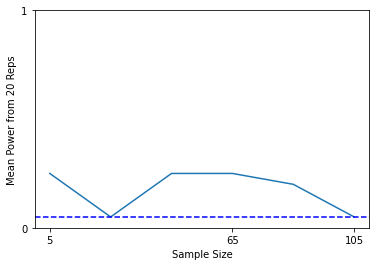

In [29]:
plot_power2()